In [25]:
import cv2
import mediapipe as mp
import numpy as np
from numpy import asarray
from numpy import save

In [26]:
# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils

# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence = 0.5)

In [27]:
# Getting the input video for pose estimation

#cap = cv2.VideoCapture('1_2-3.mp4')
#cap = cv2.VideoCapture('v1_2-1.mp4')
#cap = cv2.VideoCapture('2v_2-1.mp4')
cap = cv2.VideoCapture('2_2-1.mp4')

# Number to convert the real world coordinate from meters to milimeters
num = 1000

In [28]:
# Landmarks dictionary to define body segments landmarks according to BlazePose Topology

landmarks_coordinates = {}

thigh_segments = {"Left Thigh": [23, 25], "Right Thigh": [24, 26]}

upperarm_segments = {"Left Upper Arm": [11, 13], "Right Upper Arm": [12, 14]}

forearm_segments = {"Left Fore Arm": [13, 15], "Right Fore Arm": [14, 16]}

leg_segments = {"Left Leg": [25, 27], "Right Leg": [26, 28]}

foot_segments = {"Left foot": [27, 31], "Right foot": [28, 32]}

hands_segments = {"Left hand": [15, 19], "Right hand": [16, 20]}

shoulder_segment = {"Shoulder": [12, 11]}

hips_segment = {"Hips": [24, 23]}

trunk_segment = {"trunk": [34, 33]}

In [29]:
# Function to calculate CoM coordinates for segments defined in the dictionary

def calculate_foot_CoM(x_i, x_j, y_i, y_j, z_i, z_j):
    x1 = (x_i + x_j) * 0.5
    y1 = (y_i + y_j) * 0.5
    z1 = (z_i + z_j) * 0.5

    return x1, y1, z1

def calculate_Leg_CoM(x_g, x_h, y_g, y_h, z_g, z_h):
    x2 = x_g + 0.433 * (x_h - x_g)
    y2 = y_g - 0.433 * (y_g - y_h)
    z2 = z_g - 0.433 * (z_g - z_h)

    return x2, y2, z2


def calculate_thigh_CoM(x_a, x_b, y_a, y_b, z_a, z_b):
    x3 = x_a + 0.433 * (x_b - x_a)
    y3 = y_a - 0.433 * (y_a - y_b)
    z3 = z_a - 0.433 * (z_a - z_b)

    return x3, y3, z3


def calculate_UpperArm_CoM(x_c, x_d, y_c, y_d, z_c, z_d):
    x4 = x_c + 0.436 * (x_d - x_c)
    y4 = y_c - 0.436 * (y_c - y_d)
    z4 = z_c - 0.436 * (z_c - z_d)

    return x4, y4, z4


def calculate_ForeArm_CoM(x_e, x_f, y_e, y_f, z_e, z_f):
    x5 = x_e + 0.430 * (x_f - x_e)
    y5 = y_e - 0.430 * (y_e - y_f)
    z5 = z_e - 0.430 * (z_e - z_f)

    return x5, y5, z5


def calculate_hands_CoM(x_o, x_p, y_o, y_p, z_o, z_p):
    x6 = x_o + 0.506 * (x_p - x_o)
    y6 = y_o - 0.506 * (y_o - y_p)
    z6 = z_o - 0.506 * (z_o - z_p)

    return x6, y6, z6


def calculate_trunk_CoM(x_q, x_r, y_q, y_r, z_q, z_r):
    x7 = x_q - 0.66 * (x_q - x_r)
    y7 = y_q - 0.66 * (y_q - y_r)
    z7 = z_q - 0.66 * (z_q - z_r)    

    return x7, y7, z7


def calculate_average(x_l, x_r, y_l, y_r, z_l, z_r):
    x = (x_l + x_r) * 0.5
    y = (y_l + y_r) * 0.5
    z = (z_l + z_r) * 0.5
    
    return x, y, z

In [6]:
### Pose estimation for one individual in a video

# While the video is running, perform pose detection 
while True:
    success, image = cap.read()
    results = pose.process(image)
    
    # Defining a variable to calculate the whole body CoM in the end, by getting
    # all the segment´s CoM coordinates values
    com_body = 0
    
    # Check if any landmarks are found.
    if results.pose_world_landmarks:
        # draw the connections between joint landmarks
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 ) 
        # Enumerate each landmark according to BlazePose Topology 
        for idx, lm in enumerate(results.pose_landmarks.landmark):
            h, w, c = image.shape
            cx, cy = int(lm.x * w), int(lm.y * h)
            #cv2.circle(image, (cx, cy), 2, (0, 0, 255), cv2.FILLED)
            if idx == 29:
                #print(idx, lm.x, lm.y, lm.z)
                print("[%s, %s, %s],\n" % (str(lm.x), str(lm.y), str(lm.z)))
            landmarks_coordinates[idx] = {"x": lm.x, "y": lm.y, "z": lm.z}

       # Calculating trunk CoM coordinates by defining the average point in the shoulder and
        # hips segment
        x_left_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][1]]["x"]
        y_left_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][1]]["y"]
        z_left_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][1]]["z"]
        x_right_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][0]]["x"]
        y_right_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][0]]["y"]
        z_right_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][0]]["z"]
        x_average_shoulder, y_average_shoulder, z_average_shoulder = calculate_average(
            x_left_shoulder, x_right_shoulder, y_left_shoulder, y_right_shoulder, z_left_shoulder, z_right_shoulder
        )

        landmarks_coordinates[33] = {"x": x_average_shoulder, "y": y_average_shoulder, "z": z_average_shoulder}

        x_left_hips = landmarks_coordinates[hips_segment["Hips"][1]]["x"]
        y_left_hips = landmarks_coordinates[hips_segment["Hips"][1]]["y"]
        z_left_hips = landmarks_coordinates[hips_segment["Hips"][1]]["z"]
        x_right_hips = landmarks_coordinates[hips_segment["Hips"][0]]["x"]
        y_right_hips = landmarks_coordinates[hips_segment["Hips"][0]]["y"]
        z_right_hips = landmarks_coordinates[hips_segment["Hips"][0]]["y"]
        x_average_hips, y_average_hips, z_average_hips = calculate_average(
            x_left_hips, x_right_hips, y_left_hips, y_right_hips, z_left_hips, z_right_hips
        )

        landmarks_coordinates[34] = {"x": x_average_hips, "y": y_average_hips, "z": z_average_hips}

    # Calculate Body segments CoM

    foot_com_x = 0
    foot_com_y = 0
    foot_com_z = 0
    for segment in foot_segments:
        # print("%s COM:" % segment)
        x_i = landmarks_coordinates[foot_segments[segment][0]]["x"]
        x_j = landmarks_coordinates[foot_segments[segment][1]]["x"]
        y_i = landmarks_coordinates[foot_segments[segment][0]]["y"]
        y_j = landmarks_coordinates[foot_segments[segment][1]]["y"]
        z_i = landmarks_coordinates[foot_segments[segment][0]]["z"]
        z_j = landmarks_coordinates[foot_segments[segment][1]]["z"]
        
        x1, y1, z1 = calculate_foot_CoM(x_i, x_j, y_i, y_j, z_i, z_j)
        #print("x: %s, y: %s\n" % (str(x1), str(y1)))
        #print("[%s, %s],\n" % (str(x1), str(y1)))
        #print("[%s, %s],\n" % (str(y_i), str(y_j)))

        #h, w, c = image.shape
        cx, cy = int(x1*w), int(y1*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        foot_com_x += x1
        foot_com_y += y1
        foot_com_z += z1

    leg_com_x = 0
    leg_com_y = 0
    leg_com_z = 0
    for segment in leg_segments:
        # print("%s COM:" % segment)
        x_g = landmarks_coordinates[leg_segments[segment][0]]["x"]
        x_h = landmarks_coordinates[leg_segments[segment][1]]["x"]
        y_g = landmarks_coordinates[leg_segments[segment][0]]["y"]
        y_h = landmarks_coordinates[leg_segments[segment][1]]["y"]
        z_g = landmarks_coordinates[leg_segments[segment][0]]["z"]
        z_h = landmarks_coordinates[leg_segments[segment][1]]["z"]
        
        x2, y2, z2 = calculate_Leg_CoM(x_g, x_h, y_g, y_h, z_g, z_h)
        # print("x: %s, y: %s\n" % (str(x2), str(y2)))

        #h, w, c = image.shape
        cx, cy = int(x2*w), int(y2*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        leg_com_x += x2
        leg_com_y += y2
        leg_com_z += z2
        
    thigh_com_x = 0
    thigh_com_y = 0
    thigh_com_z = 0
    for segment in thigh_segments:
        # print("%s COM:" % segment)
        x_a = landmarks_coordinates[thigh_segments[segment][0]]["x"]
        x_b = landmarks_coordinates[thigh_segments[segment][1]]["x"]
        y_a = landmarks_coordinates[thigh_segments[segment][0]]["y"]
        y_b = landmarks_coordinates[thigh_segments[segment][1]]["y"]
        z_a = landmarks_coordinates[thigh_segments[segment][0]]["z"]
        z_b = landmarks_coordinates[thigh_segments[segment][1]]["z"]
        
        x3, y3, z3 = calculate_thigh_CoM(x_a, x_b, y_a, y_b, z_a, z_b)
        #print("x: %s, y: %s\n" % (str(x3), str(y3)))

        #h, w, c = image.shape
        cx, cy = int(x3*w), int(y3*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        thigh_com_x += x3
        thigh_com_y += y3
        thigh_com_z += z3

    upperarm_com_x = 0
    upperarm_com_y = 0
    upperarm_com_z = 0
    for segment in upperarm_segments:
        # print("%s COM:" % segment)
        x_c = landmarks_coordinates[upperarm_segments[segment][0]]["x"]
        x_d = landmarks_coordinates[upperarm_segments[segment][1]]["x"]
        y_c = landmarks_coordinates[upperarm_segments[segment][0]]["y"]
        y_d = landmarks_coordinates[upperarm_segments[segment][1]]["y"]
        z_c = landmarks_coordinates[upperarm_segments[segment][0]]["z"]
        z_d = landmarks_coordinates[upperarm_segments[segment][1]]["z"]
        
        x4, y4, z4 = calculate_UpperArm_CoM(x_c, x_d, y_c, y_d, z_c, z_d)
        # print("x: %s, y: %s\n" % (str(x4), str(y4)))

        #h, w, c = image.shape
        cx, cy = int(x4*w), int(y4*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)
        upperarm_com_x += x4
        upperarm_com_y += y4
        upperarm_com_z += z4

    forearm_com_x = 0
    forearm_com_y = 0
    forearm_com_z = 0
    for segment in forearm_segments:
        # print("%s COM:" % segment)
        x_e = landmarks_coordinates[forearm_segments[segment][0]]["x"]
        x_f = landmarks_coordinates[forearm_segments[segment][1]]["x"]
        y_e = landmarks_coordinates[forearm_segments[segment][0]]["y"]
        y_f = landmarks_coordinates[forearm_segments[segment][1]]["y"]
        z_e = landmarks_coordinates[forearm_segments[segment][0]]["z"]
        z_f = landmarks_coordinates[forearm_segments[segment][1]]["z"]
        
        x5, y5, z5 = calculate_ForeArm_CoM(x_e, x_f, y_e, y_f, z_e, z_f)
        # print("x: %s, y: %s\n" % (str(x5), str(y5)))

        #h, w, c = image.shape
        cx, cy = int(x5*w), int(y5*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)
        forearm_com_x += x5
        forearm_com_y += y5
        forearm_com_z += z5

    hands_com_x = 0
    hands_com_y = 0
    hands_com_z = 0
    for segment in hands_segments:
        # print("%s COM:" % segment)
        x_o = landmarks_coordinates[hands_segments[segment][0]]["x"]
        x_p = landmarks_coordinates[hands_segments[segment][1]]["x"]
        y_o = landmarks_coordinates[hands_segments[segment][0]]["y"]
        y_p = landmarks_coordinates[hands_segments[segment][1]]["y"]
        z_o = landmarks_coordinates[hands_segments[segment][0]]["z"]
        z_p = landmarks_coordinates[hands_segments[segment][1]]["z"]
        
        x6, y6, z6 = calculate_hands_CoM(x_o, x_p, y_o, y_p, z_o, z_p)
        # print("x: %s, y: %s\n" % (str(x6), str(y6)))

        #h, w, c = image.shape
        cx, cy = int(x6*w), int(y6*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        hands_com_x += x6
        hands_com_y += y6

    trunk_com_x = 0
    trunk_com_y = 0
    trunk_com_z = 0
    for segment in trunk_segment:
        # print("%s COM:" % segment)
        x_q = landmarks_coordinates[trunk_segment[segment][0]]["x"]
        x_r = landmarks_coordinates[trunk_segment[segment][1]]["x"]
        y_q = landmarks_coordinates[trunk_segment[segment][0]]["y"]
        y_r = landmarks_coordinates[trunk_segment[segment][1]]["y"]
        z_q = landmarks_coordinates[trunk_segment[segment][0]]["z"]
        z_r = landmarks_coordinates[trunk_segment[segment][1]]["z"]
        
        x7, y7, z7 = calculate_trunk_CoM(x_q, x_r, y_q, y_r, z_q, z_r)
        #print("x: %s, y: %s\n" % (str(x7), str(y7)))

        #h, w, c = image.shape
        cx, cy = int(x7*w), int(y7*h)
        #  cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        trunk_com_x += x7
        trunk_com_y += y7
        trunk_com_z += z7

    # Calculate the whole body CoM
    body_com_x = (0.0145 * foot_com_x + 0.0465 * leg_com_x + 0.1 * thigh_com_x + 0.578 * trunk_com_x + 0.006 * hands_com_x + 0.028 * upperarm_com_x + 0.016 * forearm_com_x)
    body_com_y = (0.0145 * foot_com_y + 0.0465 * leg_com_y + 0.1 * thigh_com_y + 0.578 * trunk_com_y + 0.006 * hands_com_y + 0.028 * upperarm_com_y + 0.016 * forearm_com_y)
    body_com_z = (0.0145 * foot_com_z + 0.0465 * leg_com_z + 0.1 * thigh_com_z + 0.578 * trunk_com_z + 0.006 * hands_com_z + 0.028 * upperarm_com_z + 0.016 * forearm_com_z)
    
    cx, cy = int(body_com_x * w), int(body_com_y * h)
    cv2.circle(image, (cx, cy), 5, (0, 255, 255), cv2.FILLED)
    #print("[ %s,  %s, %s],\n" % (str(body_com_x), str(body_com_y), str(body_com_z)))
    
    # Show the output image with the pose estimation and the CoM plotted
    #cv2.imshow("Video", image)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


[0.5098162889480591, 0.5213826298713684, 0.08976192772388458],

[0.5099811553955078, 0.5184251070022583, 0.07561378180980682],

[0.5102290511131287, 0.5171859860420227, 0.06193488836288452],

[0.510278046131134, 0.517205536365509, 0.03385057672858238],

[0.5104894042015076, 0.517295241355896, 0.001310786698013544],

[0.5106852054595947, 0.5183222889900208, 0.01054454781115055],

[0.5106214284896851, 0.5194190144538879, -0.021787893027067184],

[0.5105909109115601, 0.5189431309700012, 0.002217263448983431],

[0.5106019973754883, 0.5172730684280396, 0.014629374258220196],

[0.5104450583457947, 0.516699492931366, 0.02245990000665188],

[0.5103413462638855, 0.5161428451538086, 0.030578020960092545],

[0.510226309299469, 0.5162625312805176, 0.02912057936191559],

[0.5101772546768188, 0.5170223712921143, 0.020630499348044395],

[0.5101579427719116, 0.5171107649803162, 0.021422801539301872],

[0.5101058483123779, 0.5183380842208862, 0.021967705339193344],

[0.5099762082099915, 0.5215772986412

[0.49460697174072266, 0.7158957719802856, 0.20037825405597687],

[0.49487417936325073, 0.7186821699142456, 0.19010046124458313],

[0.4964657425880432, 0.7338632345199585, 0.16047437489032745],

[0.4972696900367737, 0.7695050835609436, 0.15139545500278473],

[0.4976678788661957, 0.7925670146942139, 0.09251829236745834],

[0.49763479828834534, 0.8031890988349915, 0.02667234279215336],

[0.4975184500217438, 0.8142172694206238, 0.03616684675216675],

[0.49818068742752075, 0.8167876601219177, -0.004111451096832752],

[0.5021792650222778, 0.8101711869239807, 0.0105168167501688],

[0.5053913593292236, 0.8140909671783447, -0.06438709795475006],

[0.5090695023536682, 0.8124874830245972, -0.10543885082006454],

[0.5104775428771973, 0.8086850643157959, -0.1148589700460434],

[0.5101701617240906, 0.7983664870262146, -0.13975144922733307],

[0.5113484263420105, 0.7834269404411316, -0.13630728423595428],

[0.5118619203567505, 0.7739288210868835, -0.09075171500444412],

[0.5124573111534119, 0.7599069

AttributeError: 'NoneType' object has no attribute 'shape'

Teste 1-1

In [63]:
foot29 = np.array([[0.491464763879776, 0.5212883949279785, 0.20494148135185242],

[0.49199241399765015, 0.5242984890937805, 0.08588754385709763],

[0.49219149351119995, 0.5251277685165405, 0.09224635362625122],

[0.49219751358032227, 0.5249936580657959, 0.08325231820344925],

[0.4924592971801758, 0.5249364376068115, 0.09128676354885101],

[0.49249735474586487, 0.524855375289917, 0.08677467703819275],

[0.49247995018959045, 0.5248299241065979, 0.09024685621261597],

[0.4923952519893646, 0.5248044729232788, 0.09367234259843826],

[0.49256500601768494, 0.5253955721855164, 0.08740731328725815],

[0.49263864755630493, 0.5263828039169312, 0.08220160007476807],

[0.492642879486084, 0.5274036526679993, 0.08193095773458481],

[0.4926418364048004, 0.5272663831710815, 0.0880298763513565],

[0.49267274141311646, 0.5272212028503418, 0.08950343728065491],

[0.4928082525730133, 0.5241986513137817, 0.08205797523260117],

[0.49336308240890503, 0.5189461708068848, 0.10537584125995636],

[0.49371442198753357, 0.5169482231140137, 0.11503641307353973],

[0.4938512444496155, 0.5170238614082336, 0.1103210598230362],

[0.49409326910972595, 0.5100990533828735, 0.10803564637899399],

[0.4943033754825592, 0.5063800811767578, 0.10940393060445786],

[0.49473175406455994, 0.5023698806762695, 0.11944063752889633],

[0.49472054839134216, 0.5021293759346008, 0.12231992185115814],

[0.49458327889442444, 0.5047979950904846, 0.12532858550548553],

[0.4943457245826721, 0.5090224146842957, 0.12444499880075455],

[0.49409088492393494, 0.5202258825302124, 0.11477957665920258],

[0.49404972791671753, 0.5313946008682251, 0.10142028331756592],

[0.49402227997779846, 0.5395493507385254, 0.08949968218803406],

[0.49394768476486206, 0.5450707077980042, 0.07665514945983887],

[0.49373871088027954, 0.5495111346244812, 0.07517712563276291],

[0.49337705969810486, 0.5494232773780823, 0.07579651474952698],

[0.4930310845375061, 0.5490453243255615, 0.06821036338806152],

[0.4925803244113922, 0.5476349592208862, 0.07704748213291168],

[0.49144020676612854, 0.5489746332168579, 0.07908718287944794],

[0.490090548992157, 0.5552854537963867, 0.061720140278339386],

[0.48907607793807983, 0.5567882061004639, 0.06454748660326004],

[0.4887557029724121, 0.5586779713630676, 0.06099521368741989],

[0.48848575353622437, 0.5596701502799988, 0.054914020001888275],

[0.48714011907577515, 0.5576329827308655, 0.06270737946033478],

[0.4866771101951599, 0.5572171211242676, 0.06311164051294327],

[0.4870021343231201, 0.5565004348754883, 0.07903371751308441],

[0.4871149957180023, 0.5560134053230286, 0.09062156826257706],

[0.4873010516166687, 0.5556495785713196, 0.09695921838283539],

[0.48746228218078613, 0.5562041997909546, 0.09811713546514511],

[0.48757749795913696, 0.559822142124176, 0.101190485060215],

[0.48757022619247437, 0.5646123290061951, 0.09638987481594086],

[0.4875760078430176, 0.5686226487159729, 0.09545661509037018],

[0.48759931325912476, 0.5685383677482605, 0.09702498465776443],

[0.487251341342926, 0.5672596096992493, 0.11824474483728409],

[0.48706549406051636, 0.5667067170143127, 0.13023492693901062],

[0.48639869689941406, 0.5664082169532776, 0.1352493166923523],

[0.48632049560546875, 0.5655066967010498, 0.1547887623310089],

[0.48665469884872437, 0.5594801306724548, 0.1823292076587677],

[0.4868531823158264, 0.5590680837631226, 0.16813839972019196],

[0.4869728684425354, 0.5583422183990479, 0.16921454668045044],

[0.48718827962875366, 0.5503093004226685, 0.1938040554523468],

[0.487276166677475, 0.5474299192428589, 0.18018373847007751],

[0.4873574376106262, 0.5493347644805908, 0.17431868612766266],

[0.48736730217933655, 0.5501434803009033, 0.1761036217212677],

[0.487312376499176, 0.5640313625335693, 0.15877704322338104],

[0.4866827428340912, 0.5786236524581909, 0.13969624042510986],

[0.4854987561702728, 0.5923917293548584, 0.12996414303779602],

[0.4842420220375061, 0.6071722507476807, 0.11475570499897003],

[0.4835084080696106, 0.6115885376930237, 0.09009338915348053],

[0.4827100336551666, 0.6110649704933167, 0.07435790449380875],

[0.4827442169189453, 0.6132779717445374, 0.07271360605955124],

[0.4814460277557373, 0.6192637085914612, 0.05597318336367607],

[0.48011836409568787, 0.6271389722824097, 0.06310735642910004],

[0.47939521074295044, 0.631626307964325, 0.06425490975379944],

[0.4785825312137604, 0.6340997815132141, 0.07894032448530197],

[0.47873297333717346, 0.6341859102249146, 0.09316658228635788],

[0.4787398874759674, 0.6353044509887695, 0.10292734950780869],

[0.478738933801651, 0.632926881313324, 0.12797106802463531],

[0.4784506857395172, 0.6299771070480347, 0.14274045825004578],

[0.47854581475257874, 0.6319672465324402, 0.1390857845544815],

[0.4780293405056, 0.636350154876709, 0.12933634221553802],

[0.47759804129600525, 0.6416148543357849, 0.11915572732686996],

[0.4774591326713562, 0.6403262615203857, 0.12367957830429077],

[0.47691354155540466, 0.6405068039894104, 0.1512490212917328],

[0.4762031137943268, 0.636741578578949, 0.19106003642082214],

[0.47615623474121094, 0.6342726349830627, 0.22485606372356415],

[0.4776034951210022, 0.6208813190460205, 0.25714436173439026],

[0.47839823365211487, 0.6153845191001892, 0.2594098150730133],

[0.4789893627166748, 0.6080105900764465, 0.25876569747924805],

[0.4800470769405365, 0.6085011959075928, 0.24387764930725098],

[0.4821018576622009, 0.6111662983894348, 0.22477571666240692],

[0.4848968982696533, 0.6121396422386169, 0.24516579508781433],

[0.486093670129776, 0.6128761172294617, 0.23471494019031525],

[0.48636919260025024, 0.6325269341468811, 0.21195006370544434],

[0.48692065477371216, 0.6581421494483948, 0.16958408057689667],

[0.48692232370376587, 0.6734329462051392, 0.13394439220428467],

[0.4875389635562897, 0.6851783990859985, 0.12092103064060211],

[0.4902164340019226, 0.6985190510749817, 0.10103784501552582],

[0.49179011583328247, 0.710352897644043, 0.06192680075764656],

[0.49308261275291443, 0.7153534889221191, 0.05858392268419266],

[0.49418264627456665, 0.7166311740875244, 0.04987882822751999],

[0.4937771260738373, 0.7177236676216125, 0.02462882548570633],

[0.4935235381126404, 0.723773181438446, 0.03748708590865135],

[0.4931944012641907, 0.7268260717391968, 0.06575357913970947],

[0.4930580258369446, 0.7296877503395081, 0.0756017416715622],

[0.49325284361839294, 0.7275112867355347, 0.08340341597795486],

[0.493917316198349, 0.7287298440933228, 0.07921893894672394],

[0.49383458495140076, 0.7257359027862549, 0.07171797752380371],

[0.49380606412887573, 0.7245200872421265, 0.07439229637384415],

[0.493731826543808, 0.7243614792823792, 0.11895455420017242],

[0.49367576837539673, 0.7184388041496277, 0.10702341794967651],

[0.4936094284057617, 0.7179286479949951, 0.10827001184225082],

[0.4932674765586853, 0.7175958156585693, 0.09431696683168411],

[0.492288738489151, 0.7184436321258545, 0.08020658791065216],

[0.4917904734611511, 0.7199909687042236, 0.0788525640964508],

[0.49106281995773315, 0.719826340675354, 0.11909643560647964],

[0.4906151294708252, 0.7196528315544128, 0.11001177132129669],

[0.49037966132164, 0.7194707989692688, 0.11022629588842392],

[0.4903627038002014, 0.7176023721694946, 0.08936569839715958],

[0.49084916710853577, 0.7071710228919983, 0.10409162938594818],

[0.4912814199924469, 0.7000759840011597, 0.14845800399780273],

[0.4918981194496155, 0.6889020204544067, 0.14596401154994965],

[0.49227339029312134, 0.6781733632087708, 0.14548099040985107],

[0.4924677014350891, 0.6810493469238281, 0.23697642982006073],

[0.4927254617214203, 0.6787378787994385, 0.27945730090141296],

[0.492897093296051, 0.6742512583732605, 0.27066534757614136],

[0.49408602714538574, 0.672186553478241, 0.2324814796447754],

[0.4956130087375641, 0.6678848266601562, 0.214395210146904],

[0.495511919260025, 0.6702274084091187, 0.20212224125862122],

[0.495492547750473, 0.6793370842933655, 0.171207994222641],

[0.49474865198135376, 0.6937015056610107, 0.1643412709236145],

[0.49405622482299805, 0.7002400159835815, 0.16530923545360565],

[0.4941729009151459, 0.7138041853904724, 0.143199622631073],

[0.4939804673194885, 0.7241835594177246, 0.12542572617530823],

[0.49424177408218384, 0.7285417318344116, 0.10245981067419052],

[0.4957094192504883, 0.7321233153343201, 0.09514107555150986],

[0.4966859817504883, 0.7331974506378174, 0.09518854320049286],

[0.49794426560401917, 0.734159529209137, 0.09119513630867004],

[0.49885812401771545, 0.7336457371711731, 0.06662468612194061],

[0.4990754723548889, 0.734822154045105, 0.06816798448562622],

[0.49893516302108765, 0.7331543564796448, 0.05171860381960869],

[0.4988575875759125, 0.7328528761863708, 0.043946798890829086],

[0.49874457716941833, 0.7272173762321472, 0.046135202050209045],

[0.49899163842201233, 0.7169323563575745, 0.04538755118846893],

[0.4991636276245117, 0.708278477191925, 0.05888442322611809],

[0.4992874562740326, 0.704456627368927, 0.06294764578342438],

[0.4990937113761902, 0.7042359113693237, 0.08961706608533859],

[0.49907922744750977, 0.6991298794746399, 0.10847549140453339],

[0.4990009367465973, 0.6979097723960876, 0.11787748336791992],

[0.49885258078575134, 0.699522078037262, 0.12646564841270447],

[0.4984554350376129, 0.7005878686904907, 0.11524243652820587],

[0.4980766177177429, 0.7018884420394897, 0.11052112281322479],

[0.4979061186313629, 0.7082914710044861, 0.10780934989452362],

[0.4977568984031677, 0.7107733488082886, 0.11800985038280487],

[0.4975438714027405, 0.7107387781143188, 0.13763098418712616],

[0.49726635217666626, 0.7107352614402771, 0.16412486135959625],

[0.4970974326133728, 0.7099199295043945, 0.19031459093093872],

[0.49700742959976196, 0.7100386023521423, 0.20172902941703796],

[0.49691110849380493, 0.7094503045082092, 0.2545529901981354],

[0.4969141483306885, 0.708566427230835, 0.2624504268169403],

[0.4969991147518158, 0.7043744921684265, 0.24674348533153534],

[0.49700218439102173, 0.6996371150016785, 0.12960347533226013],

[0.49713754653930664, 0.695356547832489, 0.2834100127220154],

[0.4971376955509186, 0.6928898692131042, 0.2712542414665222],

[0.4973410964012146, 0.6916646957397461, 0.2592920958995819],

[0.4981381893157959, 0.6892093420028687, 0.2656444311141968],

[0.4992625117301941, 0.6869066953659058, 0.29309970140457153],

[0.5002119541168213, 0.6883395910263062, 0.25995832681655884],

[0.5004380941390991, 0.6892492771148682, 0.2598379850387573],

[0.5007116794586182, 0.6916345953941345, 0.2565005421638489],

[0.5002099275588989, 0.7170275449752808, 0.21816730499267578],

[0.49883079528808594, 0.7365554571151733, 0.21894343197345734],

[0.4983728528022766, 0.7586430311203003, 0.19478318095207214],

[0.4983765482902527, 0.7755012512207031, 0.1687539964914322],

[0.4983829855918884, 0.7879883646965027, 0.12773050367832184],

[0.4991386830806732, 0.7953280210494995, 0.12765498459339142],

[0.4991433024406433, 0.8041427731513977, 0.10677460581064224],

[0.49896687269210815, 0.8081100583076477, 0.10261912643909454],

[0.49852290749549866, 0.8081817030906677, 0.11186648905277252],

[0.4979759156703949, 0.8100447654724121, 0.09691481292247772],

[0.4977983832359314, 0.8081477880477905, 0.10657255351543427],

[0.4977623522281647, 0.8056368231773376, 0.12091571092605591],

[0.4977131485939026, 0.803433895111084, 0.12304173409938812],

[0.4975789487361908, 0.8031367063522339, 0.14025212824344635],

[0.4977855086326599, 0.8043533563613892, 0.14364910125732422],

[0.49779170751571655, 0.8068478107452393, 0.14349448680877686],

[0.49779051542282104, 0.8091936707496643, 0.15610860288143158],

[0.4977206289768219, 0.8143032789230347, 0.15273745357990265],

[0.4975130558013916, 0.8163894414901733, 0.14817139506340027],

[0.4970706105232239, 0.8199495077133179, 0.14688193798065186],

[0.4968625605106354, 0.8220620155334473, 0.13980835676193237],

[0.4967105984687805, 0.8201866149902344, 0.14276407659053802],

[0.49653881788253784, 0.8197270631790161, 0.15355058014392853],

[0.49625128507614136, 0.8209924697875977, 0.1611705720424652],

[0.49602824449539185, 0.8214699029922485, 0.15849055349826813],

[0.4959745407104492, 0.8216472864151001, 0.14790432155132294],

[0.49589651823043823, 0.8219081163406372, 0.15242835879325867],

[0.4958946704864502, 0.8215416073799133, 0.1672043651342392],

[0.49587616324424744, 0.8212558031082153, 0.16286532580852509],

[0.4958445429801941, 0.8210909366607666, 0.15272371470928192],

[0.495839923620224, 0.8209495544433594, 0.14957886934280396],

[0.4958382248878479, 0.8208701014518738, 0.15639163553714752],

[0.49583378434181213, 0.8207234144210815, 0.15606968104839325],

[0.4959138333797455, 0.8202264308929443, 0.15687569975852966],

[0.4959828853607178, 0.8199030756950378, 0.16319343447685242]])


foot30 = np.array([[0.483695924282074, 0.5178114771842957, 0.17862680554389954],

[0.4835907816886902, 0.5211745500564575, 0.13083705306053162],

[0.48359251022338867, 0.5229206085205078, 0.1127135157585144],

[0.48352211713790894, 0.5229529738426208, 0.09519729018211365],

[0.48359161615371704, 0.5242461562156677, 0.0928400531411171],

[0.48363223671913147, 0.5255433917045593, 0.09141413867473602],

[0.48364463448524475, 0.5264557600021362, 0.09383522719144821],

[0.4836151599884033, 0.5292710065841675, 0.09151668846607208],

[0.4838946759700775, 0.5314373970031738, 0.08918188512325287],

[0.48392948508262634, 0.5330823063850403, 0.08664336800575256],

[0.48392853140830994, 0.5338774919509888, 0.08586719632148743],

[0.4838770925998688, 0.5346381664276123, 0.0865098163485527],

[0.48388728499412537, 0.5356045365333557, 0.0865560919046402],

[0.4849225580692291, 0.5380164384841919, 0.08079557120800018],

[0.48568907380104065, 0.5383468866348267, 0.0731034055352211],

[0.48597002029418945, 0.5387725830078125, 0.06778580695390701],

[0.48651227355003357, 0.5389696955680847, 0.07373271882534027],

[0.48683494329452515, 0.5384756922721863, 0.08446449786424637],

[0.48715147376060486, 0.5375772714614868, 0.09218606352806091],

[0.4868953227996826, 0.5373620390892029, 0.09196130186319351],

[0.4860472083091736, 0.5368971824645996, 0.10107244551181793],

[0.4853617250919342, 0.5368185043334961, 0.10248764604330063],

[0.485292911529541, 0.5367342233657837, 0.0992649644613266],

[0.485024631023407, 0.5371856689453125, 0.09820647537708282],

[0.48503366112709045, 0.5378854274749756, 0.09781743586063385],

[0.4854440689086914, 0.5397787094116211, 0.09750686585903168],

[0.48599886894226074, 0.5415381789207458, 0.0979301780462265],

[0.4862152636051178, 0.5417280197143555, 0.11009643971920013],

[0.4865837097167969, 0.5425251722335815, 0.1165052279829979],

[0.4869280457496643, 0.5424055457115173, 0.13985687494277954],

[0.4869922995567322, 0.5399293899536133, 0.14796596765518188],

[0.4867616593837738, 0.5378128886222839, 0.15753798186779022],

[0.4867473244667053, 0.53609699010849, 0.1913817971944809],

[0.48686450719833374, 0.5353162288665771, 0.1930270493030548],

[0.4862174093723297, 0.5335155725479126, 0.20031535625457764],

[0.48561158776283264, 0.5303675532341003, 0.21760661900043488],

[0.4856122136116028, 0.523952841758728, 0.21047163009643555],

[0.48460784554481506, 0.5189793705940247, 0.2142447680234909],

[0.48350825905799866, 0.5197880268096924, 0.20800423622131348],

[0.4828154146671295, 0.520816445350647, 0.19872479140758514],

[0.48182034492492676, 0.5244342088699341, 0.17862814664840698],

[0.4806469976902008, 0.5339269042015076, 0.1631346046924591],

[0.4800260066986084, 0.546612024307251, 0.12030742317438126],

[0.47836536169052124, 0.5605529546737671, 0.1021810993552208],

[0.47734135389328003, 0.5701746940612793, 0.09727588295936584],

[0.4767877161502838, 0.5729634761810303, 0.10165651142597198],

[0.4754510819911957, 0.5773171186447144, 0.10588414967060089],

[0.47478771209716797, 0.5813187956809998, 0.09918439388275146],

[0.4732213616371155, 0.5825066566467285, 0.10132522881031036],

[0.4719788432121277, 0.5857422947883606, 0.0841432735323906],

[0.4724474549293518, 0.5902472734451294, 0.04853680357336998],

[0.4729556441307068, 0.5922004580497742, 0.06176622584462166],

[0.47312235832214355, 0.5931345820426941, 0.0701553151011467],

[0.4724109172821045, 0.5947071313858032, 0.07002481073141098],

[0.47170495986938477, 0.596304178237915, 0.08821775019168854],

[0.4719865322113037, 0.5954427719116211, 0.100303053855896],

[0.4721603989601135, 0.5939468741416931, 0.14775240421295166],

[0.47220873832702637, 0.5941232442855835, 0.13290874660015106],

[0.4730299115180969, 0.5968537330627441, 0.13731007277965546],

[0.473074734210968, 0.5969892740249634, 0.1387159526348114],

[0.47295260429382324, 0.5984859466552734, 0.1335860639810562],

[0.47297143936157227, 0.5976575016975403, 0.1648508906364441],

[0.47365355491638184, 0.5918424129486084, 0.20483775436878204],

[0.4744794964790344, 0.5900567173957825, 0.22599966824054718],

[0.47473230957984924, 0.590081512928009, 0.2392851859331131],

[0.4747285842895508, 0.5914939641952515, 0.23193733394145966],

[0.47424954175949097, 0.5892391204833984, 0.2537607252597809],

[0.47307252883911133, 0.5770614147186279, 0.2589389681816101],

[0.47186559438705444, 0.5684860348701477, 0.26709118485450745],

[0.4707183837890625, 0.5708190202713013, 0.27028360962867737],

[0.4693889021873474, 0.5735156536102295, 0.2443663626909256],

[0.4675636291503906, 0.5870127081871033, 0.2138947695493698],

[0.466572105884552, 0.6089798212051392, 0.1720198541879654],

[0.46631231904029846, 0.6301572322845459, 0.14446917176246643],

[0.4654066562652588, 0.6452247500419617, 0.11532213538885117],

[0.4656405448913574, 0.656955361366272, 0.11099214851856232],

[0.4646148681640625, 0.6649411916732788, 0.058478087186813354],

[0.46372953057289124, 0.6639963984489441, 0.06478722393512726],

[0.46368923783302307, 0.6701977252960205, 0.03050779365003109],

[0.4674546718597412, 0.6778284907341003, 0.017130637541413307],

[0.4693945050239563, 0.6796209812164307, 0.013940694741904736],

[0.46993741393089294, 0.6806855797767639, 0.04430268704891205],

[0.4697880744934082, 0.6821585893630981, 0.05401843786239624],

[0.4696953296661377, 0.6858053207397461, 0.06810034811496735],

[0.46963173151016235, 0.6844891309738159, 0.08469934016466141],

[0.4695739150047302, 0.6803494691848755, 0.10591314733028412],

[0.4695460796356201, 0.6790648102760315, 0.15005943179130554],

[0.4700908064842224, 0.6815739274024963, 0.15763996541500092],

[0.4706529974937439, 0.6821169257164001, 0.13884378969669342],

[0.4714426100254059, 0.6836426854133606, 0.1345907598733902],

[0.47249382734298706, 0.6841642260551453, 0.13654646277427673],

[0.4731314778327942, 0.6863198280334473, 0.12244579941034317],

[0.4737703800201416, 0.6863594651222229, 0.14791344106197357],

[0.47469860315322876, 0.6866574287414551, 0.15212391316890717],

[0.47505801916122437, 0.6872332096099854, 0.1427585333585739],

[0.47486838698387146, 0.6868625283241272, 0.1681167185306549],

[0.4747256636619568, 0.6864727735519409, 0.21955974400043488],

[0.47473177313804626, 0.6831767559051514, 0.2520885467529297],

[0.4752291142940521, 0.677088737487793, 0.2624524235725403],

[0.47534966468811035, 0.6686535477638245, 0.27414923906326294],

[0.4752843379974365, 0.6634349226951599, 0.2704022526741028],

[0.4749702513217926, 0.663515031337738, 0.29447126388549805],

[0.4745211601257324, 0.6631954908370972, 0.2884112298488617],

[0.47471338510513306, 0.6637048125267029, 0.26655641198158264],

[0.4757847785949707, 0.6726518869400024, 0.265168160200119],

[0.47688737511634827, 0.692020058631897, 0.13368335366249084],

[0.47711992263793945, 0.7107995748519897, 0.10104986280202866],

[0.47773727774620056, 0.7246724367141724, 0.10464648902416229],

[0.4776802659034729, 0.7315417528152466, 0.1317768543958664],

[0.47734108567237854, 0.7398124933242798, 0.10249161720275879],

[0.47653764486312866, 0.7459564208984375, 0.06287109106779099],

[0.4763396382331848, 0.7549384236335754, 0.01919281855225563],

[0.4761451184749603, 0.7583841681480408, 0.005823842249810696],

[0.47535309195518494, 0.7633863687515259, -0.018018944188952446],

[0.47526949644088745, 0.769633412361145, -0.013184629380702972],

[0.475269079208374, 0.768511950969696, 0.01584736630320549],

[0.4755162298679352, 0.7676313519477844, 0.0032731755636632442],

[0.475614458322525, 0.7663666009902954, 0.02142227068543434],

[0.47564902901649475, 0.7635959386825562, 0.039694275707006454],

[0.4759591519832611, 0.7616469264030457, 0.054295025765895844],

[0.4759925901889801, 0.7596997022628784, 0.07111978530883789],

[0.47598427534103394, 0.7536109685897827, 0.0892564207315445],

[0.475818932056427, 0.7409573793411255, 0.09583501517772675],

[0.4759652614593506, 0.7331530451774597, 0.12820421159267426],

[0.47679001092910767, 0.7256284356117249, 0.138212189078331],

[0.47908249497413635, 0.7251983880996704, 0.14396752417087555],

[0.4798956513404846, 0.72590172290802, 0.146951824426651],

[0.48158565163612366, 0.7232804894447327, 0.1621500551700592],

[0.4831182360649109, 0.7162889838218689, 0.17838236689567566],

[0.48373943567276, 0.7123145461082458, 0.18489350378513336],

[0.484485924243927, 0.709203839302063, 0.20067057013511658],

[0.48548465967178345, 0.7027873396873474, 0.2142152339220047],

[0.48578888177871704, 0.6942685842514038, 0.2451827973127365],

[0.48601430654525757, 0.6887401938438416, 0.2469787895679474],

[0.48671260476112366, 0.6836152672767639, 0.2518030107021332],

[0.4872286915779114, 0.6758578419685364, 0.2682970464229584],

[0.4872835576534271, 0.669817328453064, 0.2715248167514801],

[0.4870842397212982, 0.6613826751708984, 0.2616952657699585],

[0.48694729804992676, 0.6609804630279541, 0.2490040510892868],

[0.4866878390312195, 0.6582175493240356, 0.261857271194458],

[0.4866293966770172, 0.6605207324028015, 0.2619064748287201],

[0.4866088032722473, 0.6643553972244263, 0.2467481642961502],

[0.48672428727149963, 0.665962278842926, 0.2381490170955658],

[0.48700588941574097, 0.6799403429031372, 0.2148132026195526],

[0.487476646900177, 0.6940632462501526, 0.19454334676265717],

[0.4874345362186432, 0.7108744978904724, 0.14624769985675812],

[0.4874763488769531, 0.7219601273536682, 0.14016130566596985],

[0.48701199889183044, 0.7294190526008606, 0.11765815317630768],

[0.48589515686035156, 0.7387877702713013, 0.07364397495985031],

[0.4844852387905121, 0.7465356588363647, 0.05405641719698906],

[0.48364686965942383, 0.7532097101211548, 0.03636827692389488],

[0.48307642340660095, 0.7618727087974548, 0.0019474007422104478],

[0.4830814301967621, 0.7680104374885559, 0.0066755241714417934],

[0.4831889569759369, 0.7757795453071594, 0.011161275207996368],

[0.483267605304718, 0.7825888991355896, 0.04739532619714737],

[0.48343411087989807, 0.7865385413169861, 0.03501294553279877],

[0.48356103897094727, 0.7878940105438232, 0.04317358508706093],

[0.48397547006607056, 0.7906397581100464, 0.05251612514257431],

[0.48413020372390747, 0.7921823859214783, 0.0561535470187664],

[0.48414748907089233, 0.7917420864105225, 0.08642047643661499],

[0.4840932786464691, 0.7928689122200012, 0.10070829093456268],

[0.4840429723262787, 0.7915237545967102, 0.1046571135520935],

[0.4838113784790039, 0.7899169325828552, 0.10981718450784683],

[0.4838051199913025, 0.7884528040885925, 0.12048010528087616],

[0.48372864723205566, 0.7880938053131104, 0.15845665335655212],

[0.4837387204170227, 0.7878007888793945, 0.16173139214515686],

[0.4842749238014221, 0.7898010015487671, 0.1617683619260788],

[0.4846837520599365, 0.7922334671020508, 0.15898624062538147],

[0.48521819710731506, 0.7938298583030701, 0.1738448441028595],

[0.4853687882423401, 0.7946885824203491, 0.1815830022096634],

[0.4854426383972168, 0.7947273254394531, 0.1973426342010498],

[0.4854421615600586, 0.7945097088813782, 0.19254907965660095],

[0.48546066880226135, 0.794282078742981, 0.20339210331439972],

[0.4859555661678314, 0.7932571172714233, 0.20594871044158936],

[0.4864674210548401, 0.7913398146629333, 0.24836567044258118],

[0.487008661031723, 0.7892053127288818, 0.24050581455230713],

[0.4873782694339752, 0.7869965434074402, 0.26866137981414795],

[0.4880288243293762, 0.7869084477424622, 0.2716171443462372],

[0.48787036538124084, 0.7889127731323242, 0.2559344172477722],

[0.48711591958999634, 0.7925471067428589, 0.24190568923950195],

[0.4848511815071106, 0.8010035157203674, 0.21067115664482117],

[0.4819720387458801, 0.8101819157600403, 0.17773351073265076],

[0.47889843583106995, 0.8213027119636536, 0.1539987027645111],

[0.4777162969112396, 0.8249768614768982, 0.15095695853233337],

[0.47700047492980957, 0.8232753276824951, 0.1612875759601593],

[0.47648268938064575, 0.822860062122345, 0.16870549321174622],

[0.47646036744117737, 0.8255243301391602, 0.1693892776966095],

[0.47641125321388245, 0.8260520696640015, 0.1671251356601715],

[0.4764139652252197, 0.8260138034820557, 0.15647372603416443],

[0.476471483707428, 0.8261169195175171, 0.1632886826992035],

[0.4764583110809326, 0.8257207274436951, 0.1656680405139923],

[0.47630199790000916, 0.82546067237854, 0.1634429693222046],

[0.47616130113601685, 0.8254029154777527, 0.15707111358642578],

[0.4760960638523102, 0.8252619504928589, 0.15595456957817078],

[0.4760536551475525, 0.8251895308494568, 0.15864019095897675],

[0.4759453237056732, 0.8250487446784973, 0.15407678484916687],

[0.4759630560874939, 0.8249540328979492, 0.15664970874786377],

[0.4759778082370758, 0.8248686194419861, 0.1649685800075531]])


foot31 = np.array([[0.49047499895095825, 0.5472021102905273, 0.16434141993522644],

[0.49054306745529175, 0.547469973564148, 0.008935341611504555],

[0.49095600843429565, 0.547027051448822, 0.024998512119054794],

[0.4911445677280426, 0.5455156564712524, 0.012513609603047371],

[0.49174433946609497, 0.5453153252601624, 0.021129164844751358],

[0.4917360246181488, 0.5449535846710205, 0.016318274661898613],

[0.4917752146720886, 0.5447800755500793, 0.020383890718221664],

[0.4919094443321228, 0.5437661409378052, 0.024437708780169487],

[0.4918749928474426, 0.5438274145126343, 0.017039213329553604],

[0.491715669631958, 0.5438809990882874, 0.013336521573364735],

[0.49158987402915955, 0.5438970923423767, 0.012956294231116772],

[0.49158549308776855, 0.5439170598983765, 0.018989197909832],

[0.4915984570980072, 0.5435423254966736, 0.021063007414340973],

[0.49151021242141724, 0.5406695008277893, 0.018741818144917488],

[0.49166226387023926, 0.5386894941329956, 0.04863915219902992],

[0.4920791983604431, 0.5384585857391357, 0.059657298028469086],

[0.49206680059432983, 0.5386118292808533, 0.05445384979248047],

[0.4920300543308258, 0.5377885103225708, 0.05483054369688034],

[0.4919665455818176, 0.5366949439048767, 0.058713722974061966],

[0.4928305745124817, 0.5365899205207825, 0.06873597204685211],

[0.49335718154907227, 0.536852240562439, 0.06999843567609787],

[0.49410921335220337, 0.5384908318519592, 0.07137589901685715],

[0.4949585795402527, 0.5423115491867065, 0.06762264668941498],

[0.4954560697078705, 0.5486417412757874, 0.047331247478723526],

[0.49646663665771484, 0.5561367869377136, 0.031349945813417435],

[0.4962333142757416, 0.5610325336456299, 0.019276443868875504],

[0.49620866775512695, 0.5630470514297485, 0.009785780683159828],

[0.49448949098587036, 0.564765214920044, 0.008309835568070412],

[0.4921587407588959, 0.5660420060157776, 0.007546856999397278],

[0.4901391863822937, 0.5659260749816895, -0.00019173343025613576],

[0.4898756444454193, 0.567188024520874, 0.01118878461420536],

[0.48926711082458496, 0.5693132877349854, 0.013819495216012001],

[0.48862117528915405, 0.571986973285675, -0.006549554876983166],

[0.488210529088974, 0.5740942358970642, -0.002939923433586955],

[0.4876302182674408, 0.5778020024299622, -0.007165108807384968],

[0.4873977601528168, 0.5788787603378296, -0.01559036411345005],

[0.4873858094215393, 0.578606903553009, -0.005980030633509159],

[0.4873855710029602, 0.5789187550544739, -0.0033167642541229725],

[0.48722735047340393, 0.5794435143470764, 0.009204904548823833],

[0.48725229501724243, 0.5811052322387695, 0.020927276462316513],

[0.486706405878067, 0.58253413438797, 0.02577412687242031],

[0.48665690422058105, 0.5851854085922241, 0.027593355625867844],

[0.4867437481880188, 0.5873652696609497, 0.02768087014555931],

[0.48679715394973755, 0.5905618667602539, 0.02491268888115883],

[0.4868350625038147, 0.5919159650802612, 0.014546294696629047],

[0.48689714074134827, 0.5911737084388733, 0.01715715602040291],

[0.48807233572006226, 0.5903530716896057, 0.04249349609017372],

[0.4884450435638428, 0.5904241800308228, 0.05348872020840645],

[0.4884410798549652, 0.5911486744880676, 0.059439223259687424],

[0.4884371757507324, 0.5906616449356079, 0.07983018457889557],

[0.4884914457798004, 0.5887259840965271, 0.11742983758449554],

[0.4888571798801422, 0.5886157155036926, 0.10013854503631592],

[0.48898911476135254, 0.5885294079780579, 0.1015092134475708],

[0.4893321096897125, 0.5885054469108582, 0.13309061527252197],

[0.48930826783180237, 0.588482141494751, 0.1211409717798233],

[0.488650381565094, 0.590573251247406, 0.11022496223449707],

[0.48847970366477966, 0.5956700444221497, 0.1176394373178482],

[0.4876784384250641, 0.604013204574585, 0.08801625669002533],

[0.4866349697113037, 0.6130012273788452, 0.06641831994056702],

[0.48668336868286133, 0.6235286593437195, 0.04853105917572975],

[0.4870845675468445, 0.6293198466300964, 0.03393377363681793],

[0.4863632321357727, 0.634710967540741, 0.009887035936117172],

[0.4831143319606781, 0.6320670247077942, -0.008807588368654251],

[0.4800701141357422, 0.6375419497489929, -0.012017546221613884],

[0.4784568250179291, 0.6468520760536194, -0.029675235971808434],

[0.47816506028175354, 0.6550202965736389, -0.02428213320672512],

[0.4768896996974945, 0.6606505513191223, -0.023593086749315262],

[0.47623148560523987, 0.6611550450325012, -0.004684028215706348],

[0.47651877999305725, 0.6604318022727966, 0.011752882972359657],

[0.47553738951683044, 0.6614961624145508, 0.020760295912623405],

[0.4755573272705078, 0.6631527543067932, 0.044005125761032104],

[0.47548922896385193, 0.6643886566162109, 0.05355146527290344],

[0.4758117198944092, 0.6685253381729126, 0.047961633652448654],

[0.4759882390499115, 0.6727880835533142, 0.040392838418483734],

[0.4766848683357239, 0.6730639934539795, 0.013397661969065666],

[0.4768575131893158, 0.6696687936782837, 0.017769625410437584],

[0.47691434621810913, 0.6691386699676514, 0.052678100764751434],

[0.4770278036594391, 0.6679378747940063, 0.098244309425354],

[0.4775902330875397, 0.6676007509231567, 0.13740307092666626],

[0.479391485452652, 0.6665538549423218, 0.17941685020923615],

[0.48030248284339905, 0.6611887216567993, 0.18467757105827332],

[0.4810337424278259, 0.6561018824577332, 0.18527497351169586],

[0.4809659421443939, 0.6569539308547974, 0.1686965674161911],

[0.4809696078300476, 0.6619766354560852, 0.1473519206047058],

[0.4859107434749603, 0.6656475067138672, 0.17302297055721283],

[0.4891679883003235, 0.67170250415802, 0.16160376369953156],

[0.4916139543056488, 0.6888508200645447, 0.12905897200107574],

[0.49191814661026, 0.7056397199630737, 0.06529267132282257],

[0.4925452768802643, 0.7170016169548035, 0.02454049326479435],

[0.4932110905647278, 0.7303637266159058, 0.011598259210586548],

[0.4928913116455078, 0.7406991720199585, -0.005255370866507292],

[0.4925011992454529, 0.746208131313324, -0.04235842078924179],

[0.49174195528030396, 0.7490910887718201, -0.04995012283325195],

[0.4908178448677063, 0.7497530579566956, -0.06007145717740059],

[0.49050265550613403, 0.7551961541175842, -0.07885043323040009],

[0.49027782678604126, 0.7615294456481934, -0.06852270662784576],

[0.4899107813835144, 0.7666977047920227, -0.041225679218769073],

[0.4893585741519928, 0.7718033790588379, -0.030484188348054886],

[0.4890931248664856, 0.7722790241241455, -0.026082584634423256],

[0.4887825548648834, 0.7712684869766235, -0.029753699898719788],

[0.4880329668521881, 0.7681905031204224, -0.0360526368021965],

[0.4880426526069641, 0.7678676247596741, -0.032065730541944504],

[0.4880443215370178, 0.7658154964447021, 0.01715010218322277],

[0.48803576827049255, 0.7653975486755371, 0.002994305919855833],

[0.4878830313682556, 0.7646612524986267, 0.002460737247020006],

[0.4880773425102234, 0.7658731937408447, -0.00817153137177229],

[0.4882567524909973, 0.7658717036247253, -0.027669116854667664],

[0.48809900879859924, 0.7659962177276611, -0.02727542258799076],

[0.4883543848991394, 0.7656655311584473, 0.007942740805447102],

[0.49092382192611694, 0.7608754634857178, 0.0045204805210232735],

[0.49250540137290955, 0.7569210529327393, 0.013247443363070488],

[0.49276846647262573, 0.7490858435630798, 0.005580098833888769],

[0.493054062128067, 0.7398623824119568, 0.028117423877120018],

[0.493750661611557, 0.7341466546058655, 0.07373413443565369],

[0.49447885155677795, 0.7274181842803955, 0.042208231985569],

[0.49481502175331116, 0.7239145636558533, 0.07770031690597534],

[0.494926780462265, 0.7249372601509094, 0.16498993337154388],

[0.4948022961616516, 0.725864827632904, 0.21200791001319885],

[0.4947379529476166, 0.7262670993804932, 0.20599952340126038],

[0.49458208680152893, 0.7263087034225464, 0.1634335219860077],

[0.49450692534446716, 0.7263116836547852, 0.14953826367855072],

[0.494316965341568, 0.7300975322723389, 0.14896835386753082],

[0.49483007192611694, 0.7336660027503967, 0.08974946290254593],

[0.49572640657424927, 0.7387227416038513, 0.07387392222881317],

[0.49634313583374023, 0.7414424419403076, 0.07372524589300156],

[0.4985722601413727, 0.7513120174407959, 0.0465521439909935],

[0.4986364245414734, 0.759765625, 0.02492569014430046],

[0.4984160363674164, 0.7651548385620117, 0.0036608476657420397],

[0.49743562936782837, 0.7691984176635742, -0.00044942289241589606],

[0.4963015913963318, 0.7685934901237488, 0.002357408870011568],

[0.4961513578891754, 0.7679605484008789, -0.0002680331817828119],

[0.4961668848991394, 0.7658966779708862, -0.02331041917204857],

[0.4961622655391693, 0.7646711468696594, -0.023238331079483032],

[0.49605870246887207, 0.7630014419555664, -0.0370870977640152],

[0.49556994438171387, 0.7583527565002441, -0.041599713265895844],

[0.4953576624393463, 0.7557629942893982, -0.042192380875349045],

[0.49535077810287476, 0.7495757341384888, -0.04334511235356331],

[0.4954500198364258, 0.7431325912475586, -0.035950373858213425],

[0.49550071358680725, 0.7407962083816528, -0.021604908630251884],

[0.4955008625984192, 0.7406477928161621, 0.012613840401172638],

[0.49547505378723145, 0.7390100359916687, 0.031063714995980263],

[0.49526578187942505, 0.737705647945404, 0.03793828934431076],

[0.4949033856391907, 0.7383502721786499, 0.04698881134390831],

[0.4949008524417877, 0.739040195941925, 0.03581392019987106],

[0.4948297441005707, 0.7407963275909424, 0.027599399909377098],

[0.4947182238101959, 0.7440097332000732, 0.024020515382289886],

[0.49498113989830017, 0.7444202899932861, 0.03195617347955704],

[0.49666810035705566, 0.7443785071372986, 0.055549539625644684],

[0.4982999861240387, 0.7443827986717224, 0.08699336647987366],

[0.49935850501060486, 0.7443333268165588, 0.11364545673131943],

[0.49974432587623596, 0.7443389296531677, 0.12489573657512665],

[0.5003045797348022, 0.7429412007331848, 0.18460777401924133],

[0.5007327795028687, 0.741771936416626, 0.19383783638477325],

[0.5014404058456421, 0.7377306818962097, 0.18448422849178314],

[0.501173734664917, 0.7354597449302673, 0.06543480604887009],

[0.5019680857658386, 0.7339328527450562, 0.22865638136863708],

[0.5017477869987488, 0.7342936396598816, 0.21257781982421875],

[0.5015976428985596, 0.7347869277000427, 0.20648321509361267],

[0.5010829567909241, 0.7350411415100098, 0.20975501835346222],

[0.5008090734481812, 0.7388789057731628, 0.2436949759721756],

[0.5007097721099854, 0.7508416771888733, 0.20577403903007507],

[0.5009862184524536, 0.7530460953712463, 0.20819564163684845],

[0.5024891495704651, 0.7618065476417542, 0.19739070534706116],

[0.5047330856323242, 0.7737826704978943, 0.15282325446605682],

[0.5059493184089661, 0.7881638407707214, 0.14131048321723938],

[0.5063744783401489, 0.805599570274353, 0.10461584478616714],

[0.5060505867004395, 0.8227719068527222, 0.06949546933174133],

[0.5059028267860413, 0.8372679948806763, 0.02406422607600689],

[0.503503680229187, 0.8460347652435303, 0.017934445291757584],

[0.5004169344902039, 0.8540697693824768, -0.0019017955055460334],

[0.4973292350769043, 0.8584928512573242, -0.0053381952457129955],

[0.49588388204574585, 0.8637498617172241, 0.005490525159984827],

[0.49454689025878906, 0.8630646467208862, -0.009722268208861351],

[0.49334827065467834, 0.8609025478363037, 0.0044028121046721935],

[0.49281272292137146, 0.8616190552711487, 0.017266051843762398],

[0.4928233027458191, 0.8614218831062317, 0.026709839701652527],

[0.49297279119491577, 0.8630770444869995, 0.04428694397211075],

[0.4931693971157074, 0.8640561699867249, 0.04559696093201637],

[0.4933164715766907, 0.8680092096328735, 0.043543025851249695],

[0.4933362901210785, 0.8700407147407532, 0.05048471689224243],

[0.49343472719192505, 0.8731390237808228, 0.044713061302900314],

[0.49345555901527405, 0.8749589920043945, 0.035587288439273834],

[0.4935073256492615, 0.876363217830658, 0.02978530153632164],

[0.4934452474117279, 0.8780421614646912, 0.021604131907224655],

[0.49348902702331543, 0.8770605325698853, 0.025804150849580765],

[0.4935174584388733, 0.8768162131309509, 0.03975539654493332],

[0.4935438632965088, 0.8769734501838684, 0.047191910445690155],

[0.4937601089477539, 0.8781363368034363, 0.046623654663562775],

[0.4940623342990875, 0.8787299394607544, 0.035275641828775406],

[0.49435076117515564, 0.8791030645370483, 0.039613813161849976],

[0.49476438760757446, 0.8787052631378174, 0.05176503583788872],

[0.4948822855949402, 0.8786233067512512, 0.04938874393701553],

[0.4948848783969879, 0.8788413405418396, 0.04183921962976456],

[0.4949343204498291, 0.878800094127655, 0.037362854927778244],

[0.49496111273765564, 0.8786904215812683, 0.041290972381830215],

[0.49499091506004333, 0.8786199688911438, 0.041224975138902664],

[0.49499350786209106, 0.8785970211029053, 0.041901595890522],

[0.49499696493148804, 0.8785741925239563, 0.04814594238996506]])


foot32 = np.array([[0.47980666160583496, 0.5442096590995789, 0.13494275510311127],

[0.4790431559085846, 0.5442076325416565, 0.06116832047700882],

[0.4788780212402344, 0.5435197353363037, 0.04695717245340347],

[0.4789198040962219, 0.5433623194694519, 0.026159539818763733],

[0.47913652658462524, 0.543559730052948, 0.02268296852707863],

[0.47977280616760254, 0.5441415309906006, 0.022023489698767662],

[0.48050355911254883, 0.5447912216186523, 0.02487337589263916],

[0.4809902310371399, 0.5460336804389954, 0.020391002297401428],

[0.48098811507225037, 0.5476201772689819, 0.017981307581067085],

[0.4810473322868347, 0.547852098941803, 0.016785506159067154],

[0.4810841977596283, 0.5477757453918457, 0.015984658151865005],

[0.48149341344833374, 0.5477133989334106, 0.014735018834471703],

[0.48184695839881897, 0.5476609468460083, 0.014639000408351421],

[0.48181477189064026, 0.548494279384613, 0.011255478486418724],

[0.4818492829799652, 0.5499824285507202, 0.0035991487093269825],

[0.4818817973136902, 0.5528911352157593, -0.002446649130433798],

[0.481834352016449, 0.5542739033699036, 0.0023470220621675253],

[0.4818979799747467, 0.5542435646057129, 0.0213237963616848],

[0.4820535182952881, 0.5540480017662048, 0.02993883565068245],

[0.482499361038208, 0.5544013381004333, 0.027546007186174393],

[0.4828035831451416, 0.5547787547111511, 0.035675205290317535],

[0.48283958435058594, 0.5551425218582153, 0.03670622780919075],

[0.48308616876602173, 0.555949330329895, 0.03003031574189663],

[0.48303717374801636, 0.5570289492607117, 0.029657363891601562],

[0.48296260833740234, 0.5582960247993469, 0.029162531718611717],

[0.48292869329452515, 0.5596317648887634, 0.028056208044290543],

[0.48290127515792847, 0.5596478581428528, 0.03315696865320206],

[0.48270100355148315, 0.5594437718391418, 0.04794948175549507],

[0.4823974072933197, 0.5598800182342529, 0.0540766641497612],

[0.481799453496933, 0.5595192313194275, 0.08043674379587173],

[0.4817841947078705, 0.5593895316123962, 0.09294242411851883],

[0.4815618097782135, 0.5592730641365051, 0.10449913889169693],

[0.4813757538795471, 0.559202253818512, 0.14180490374565125],

[0.48131704330444336, 0.5590442419052124, 0.14417605102062225],

[0.4811788499355316, 0.5580092668533325, 0.15289035439491272],

[0.48112449049949646, 0.5569391250610352, 0.17111645638942719],

[0.4814954698085785, 0.5550260543823242, 0.16624335944652557],

[0.48148995637893677, 0.5518692135810852, 0.17075185477733612],

[0.48045793175697327, 0.5520756840705872, 0.16095519065856934],

[0.4787631630897522, 0.5525882244110107, 0.14964404702186584],

[0.47575753927230835, 0.5589762926101685, 0.12414921820163727],

[0.4749224781990051, 0.5682529807090759, 0.10630160570144653],

[0.47398537397384644, 0.5766070485115051, 0.05201415345072746],

[0.4731590747833252, 0.5876745581626892, 0.025437748059630394],

[0.4720118045806885, 0.5960880517959595, 0.019054176285862923],

[0.4719730019569397, 0.599324643611908, 0.021845193579792976],

[0.47248154878616333, 0.6020467877388, 0.024350132793188095],

[0.47282513976097107, 0.6039186120033264, 0.013103889301419258],

[0.47279414534568787, 0.6058052778244019, 0.015589220449328423],

[0.47242769598960876, 0.6078411340713501, -0.005931308958679438],

[0.4721461832523346, 0.6124153137207031, -0.041474588215351105],

[0.47197118401527405, 0.6152366995811462, -0.027034783735871315],

[0.4720092713832855, 0.616037130355835, -0.017481189221143723],

[0.4720521569252014, 0.6173787117004395, -0.017512122169137],

[0.4715936779975891, 0.6184020638465881, 0.0047337766736745834],

[0.4713514745235443, 0.6194406151771545, 0.017070690169930458],

[0.4711531102657318, 0.6203346848487854, 0.07355137169361115],

[0.47100144624710083, 0.6206722855567932, 0.051258452236652374],

[0.4703725278377533, 0.6226727366447449, 0.05595628544688225],

[0.4697522521018982, 0.6242223381996155, 0.0566219687461853],

[0.46941137313842773, 0.623920202255249, 0.05372760817408562],

[0.4689974784851074, 0.623100221157074, 0.09478987753391266],

[0.4690698981285095, 0.6205456852912903, 0.14212024211883545],

[0.46901240944862366, 0.6203024983406067, 0.16587182879447937],

[0.469031423330307, 0.6210050582885742, 0.18223348259925842],

[0.4690702557563782, 0.6233455538749695, 0.17229463160037994],

[0.4690805971622467, 0.6233004927635193, 0.19708801805973053],

[0.46911707520484924, 0.6200639605522156, 0.20703594386577606],

[0.46812406182289124, 0.6152608394622803, 0.2228926420211792],

[0.46620145440101624, 0.615389883518219, 0.22140434384346008],

[0.46456313133239746, 0.622589647769928, 0.1882525533437729],

[0.4623061716556549, 0.638280987739563, 0.1435810625553131],

[0.4602511525154114, 0.6540740132331848, 0.09089517593383789],

[0.4592646062374115, 0.6662196516990662, 0.053640954196453094],

[0.4584290385246277, 0.6775491237640381, 0.013075826689600945],

[0.4575931131839752, 0.6838798522949219, 0.007474399171769619],

[0.45790553092956543, 0.6849952936172485, -0.05327202007174492],

[0.4628280699253082, 0.6842862367630005, -0.04752885177731514],

[0.4658067226409912, 0.6970279216766357, -0.08480262011289597],

[0.4662095606327057, 0.7050052881240845, -0.09567827731370926],

[0.46738624572753906, 0.710603654384613, -0.09696576744318008],

[0.46751126646995544, 0.7123644351959229, -0.06557779759168625],

[0.4676770567893982, 0.7141445875167847, -0.04332073777914047],

[0.46772441267967224, 0.7147587537765503, -0.03783763200044632],

[0.4684758186340332, 0.7154334187507629, -0.023407932370901108],

[0.46964532136917114, 0.7142490744590759, 0.0026044268161058426],

[0.4695093631744385, 0.7169630527496338, 0.046681810170412064],

[0.4693661630153656, 0.7184923887252808, 0.049743615090847015],

[0.4682988226413727, 0.7193732261657715, 0.031998682767152786],

[0.4680132269859314, 0.7225898504257202, 0.029487932100892067],

[0.4675096869468689, 0.7251769304275513, 0.04031503200531006],

[0.46714967489242554, 0.7264896631240845, 0.030700141564011574],

[0.4666481018066406, 0.7266131639480591, 0.05863738805055618],

[0.46607136726379395, 0.7274811863899231, 0.0643448606133461],

[0.46607455611228943, 0.7283772230148315, 0.05893843621015549],

[0.46605101227760315, 0.7276448607444763, 0.0908806174993515],

[0.4659738540649414, 0.7270702123641968, 0.14265887439250946],

[0.4659422039985657, 0.7265872359275818, 0.18235138058662415],

[0.46599745750427246, 0.726402223110199, 0.19623461365699768],

[0.4661037027835846, 0.7236030697822571, 0.20961430668830872],

[0.4661122262477875, 0.7205252051353455, 0.204635888338089],

[0.46608543395996094, 0.7197898626327515, 0.22768886387348175],

[0.4661075472831726, 0.7198094725608826, 0.21997134387493134],

[0.4660123884677887, 0.7224323749542236, 0.1988588273525238],

[0.4659903049468994, 0.7284696102142334, 0.18030238151550293],

[0.46616625785827637, 0.7433003783226013, 0.046457745134830475],

[0.46596449613571167, 0.7542393803596497, -0.0017258021980524063],

[0.4658418297767639, 0.7677289247512817, 0.0027885083109140396],

[0.4659034311771393, 0.7756945490837097, 0.020772697404026985],

[0.46590739488601685, 0.781861424446106, -0.00733907287940383],

[0.4660595953464508, 0.7851808071136475, -0.046819012612104416],

[0.4661270081996918, 0.7875946164131165, -0.08975770324468613],

[0.4669942855834961, 0.7880942225456238, -0.09695978462696075],

[0.4675349295139313, 0.7887750267982483, -0.12509629130363464],

[0.4676138758659363, 0.7945849895477295, -0.11578035354614258],

[0.4676033556461334, 0.7972562313079834, -0.08386997133493423],

[0.4697229862213135, 0.7961809039115906, -0.10712456703186035],

[0.47026342153549194, 0.7955164313316345, -0.07910118997097015],

[0.47131162881851196, 0.794453501701355, -0.06564124673604965],

[0.4717632234096527, 0.793093204498291, -0.05225464701652527],

[0.4722428321838379, 0.7908270955085754, -0.028810694813728333],

[0.47304481267929077, 0.784834623336792, -0.011965121142566204],

[0.4736066460609436, 0.7761918902397156, -0.007138106971979141],

[0.47369593381881714, 0.7711693048477173, 0.02453595958650112],

[0.47391659021377563, 0.7637497782707214, 0.0360678993165493],

[0.4738397002220154, 0.7609304785728455, 0.04573431611061096],

[0.47380495071411133, 0.7581853270530701, 0.0506797656416893],

[0.47362345457077026, 0.754910945892334, 0.07420295476913452],

[0.4740625321865082, 0.74985671043396, 0.09866694360971451],

[0.47449320554733276, 0.7429424524307251, 0.10835818946361542],

[0.4749515652656555, 0.7381068468093872, 0.12786754965782166],

[0.47539806365966797, 0.7298086285591125, 0.14848168194293976],

[0.4758237898349762, 0.7219346165657043, 0.18338727951049805],

[0.47610944509506226, 0.7155674695968628, 0.18870672583580017],

[0.47634950280189514, 0.7108842134475708, 0.19917047023773193],

[0.47652554512023926, 0.7071866989135742, 0.21522748470306396],

[0.4773501455783844, 0.7043665647506714, 0.21734559535980225],

[0.47909218072891235, 0.7010089755058289, 0.2118484526872635],

[0.4792507588863373, 0.6996937394142151, 0.19654510915279388],

[0.4791809916496277, 0.6983518600463867, 0.2140667885541916],

[0.4790603518486023, 0.6976838707923889, 0.2096230685710907],

[0.4790235459804535, 0.7007794976234436, 0.1869591325521469],

[0.4781619608402252, 0.7026522755622864, 0.1810997724533081],

[0.4781271517276764, 0.7147282361984253, 0.15573343634605408],

[0.4779496192932129, 0.729440450668335, 0.12550058960914612],

[0.47671255469322205, 0.7429918646812439, 0.06595068424940109],

[0.4766945242881775, 0.7533294558525085, 0.055136531591415405],

[0.4766967296600342, 0.7655820846557617, 0.02776229940354824],

[0.47670894861221313, 0.7714677453041077, -0.021825214847922325],

[0.4769456386566162, 0.7746258974075317, -0.04687923938035965],

[0.4772860109806061, 0.7778505682945251, -0.06867209821939468],

[0.47757166624069214, 0.7825343608856201, -0.10398928821086884],

[0.4783761501312256, 0.7859817743301392, -0.09907495975494385],

[0.47898420691490173, 0.7927518486976624, -0.08895281702280045],

[0.4791819453239441, 0.8001594543457031, -0.0488346703350544],

[0.4796333312988281, 0.8065376281738281, -0.06579413264989853],

[0.47984957695007324, 0.813468337059021, -0.05764103680849075],

[0.4798077940940857, 0.8201558589935303, -0.045188575983047485],

[0.47978153824806213, 0.8242834210395813, -0.04021032527089119],

[0.4797542095184326, 0.8277403116226196, -0.010080201551318169],

[0.4797329902648926, 0.8296620845794678, 0.007902015000581741],

[0.47913551330566406, 0.828928530216217, 0.01225495245307684],

[0.4790850579738617, 0.8275848627090454, 0.017849629744887352],

[0.47907528281211853, 0.8270625472068787, 0.024872146546840668],

[0.4784366488456726, 0.8267490863800049, 0.05739089101552963],

[0.4780854284763336, 0.8293808698654175, 0.059728898108005524],

[0.47745800018310547, 0.8334346413612366, 0.059834904968738556],

[0.4770272374153137, 0.8354695439338684, 0.060389675199985504],

[0.4767112135887146, 0.8357254266738892, 0.07165724039077759],

[0.47613969445228577, 0.835132360458374, 0.08623345196247101],

[0.47601383924484253, 0.8354294896125793, 0.10757508128881454],

[0.47600236535072327, 0.8369827270507812, 0.10257010161876678],

[0.47589272260665894, 0.8360639810562134, 0.11812782287597656],

[0.47574934363365173, 0.8355518579483032, 0.1226501315832138],

[0.47546935081481934, 0.8351168036460876, 0.1712866574525833],

[0.47549328207969666, 0.8347904682159424, 0.1637519896030426],

[0.47573190927505493, 0.834572434425354, 0.20060071349143982],

[0.4757891595363617, 0.8359991908073425, 0.2017575055360794],

[0.47468796372413635, 0.8403304815292358, 0.18184249103069305],

[0.47371211647987366, 0.8458021283149719, 0.16532565653324127],

[0.4720633924007416, 0.8535581827163696, 0.11642954498529434],

[0.4698278307914734, 0.8641324639320374, 0.07479831576347351],

[0.4682820737361908, 0.8733125329017639, 0.04174833744764328],

[0.4668019711971283, 0.8758394122123718, 0.03854266554117203],

[0.4662180542945862, 0.8754539489746094, 0.05259581655263901],

[0.4658887982368469, 0.8745678663253784, 0.061842869967222214],

[0.4660009443759918, 0.873984694480896, 0.059741873294115067],

[0.4662202000617981, 0.8750301599502563, 0.058588188141584396],

[0.46640777587890625, 0.8753722310066223, 0.04877642169594765],

[0.466558039188385, 0.8755946755409241, 0.05609907954931259],

[0.46657809615135193, 0.8753081560134888, 0.05971899628639221],

[0.46665772795677185, 0.8755175471305847, 0.05506492778658867],

[0.4667632579803467, 0.8755447268486023, 0.04955065995454788],

[0.4668042063713074, 0.8755486607551575, 0.046450741589069366],

[0.46688777208328247, 0.875628650188446, 0.04686947911977768],

[0.46724432706832886, 0.8758116960525513, 0.0407663956284523],

[0.46759119629859924, 0.8759781718254089, 0.04472418129444122],

[0.46760043501853943, 0.8760103583335876, 0.04959492012858391]])


body_com = np.array([[ 0.49040892302505673,  0.3442890256147682, 0.013619967783628024],

[ 0.49069964893203977,  0.32934880429044366, -0.018410712224828325],

[ 0.4906318356721699,  0.3277551272968203, -0.004563025280629758],

[ 0.49062494607955215,  0.32563225206606083, -0.009421798119286545],

[ 0.4905599723554551,  0.32636737466761473, -0.006776186612567281],

[ 0.49068449754329024,  0.32759905295768377, -0.010601536055291898],

[ 0.49072966851608457,  0.32818137979379297, -0.008171090815208282],

[ 0.490748155622378,  0.32883739733155065, -0.00713807967617724],

[ 0.49070148750308157,  0.32925281320615113, -0.007494235946867682],

[ 0.4906127560742199,  0.32954540503905716, -0.008744690390419014],

[ 0.49051937497642634,  0.3302803858847469, -0.014171828010988402],

[ 0.49038356696957347,  0.3309137530488371, -0.018467618518857525],

[ 0.4902582262741774,  0.3314174605906158, -0.019777794086642573],

[ 0.49013562109681963,  0.33159580051214993, -0.018681960918504985],

[ 0.4900173415532708,  0.3315628302323073, -0.008861519155790105],

[ 0.48978442682400347,  0.3317930664221048, -0.008640243920239632],

[ 0.4893306953267305,  0.3319231534668505, -0.0076230975631391765],

[ 0.4887587135654688,  0.3317742218847126, -0.006032855860518995],

[ 0.4881992761020064,  0.3314324729940295, -0.0034545432523183425],

[ 0.4878717768988013,  0.33047175235448767, -0.0016518431198409623],

[ 0.48751400282257795,  0.3296721371579319, -0.0030384573275411423],

[ 0.48719141619683803,  0.32941834013143184, -0.0004795370701828057],

[ 0.4869383985558003,  0.32914065959639843, 4.778748547704017e-05],

[ 0.4867459672027677,  0.3291813598054499, -0.00010546569720958684],

[ 0.4865094546773731,  0.3294078645611554, -0.0027747218445802603],

[ 0.4863105636431873,  0.3298440812111646, -0.0032063884319609623],

[ 0.4861546243835986,  0.3307524535408765, 0.001115098072029884],

[ 0.4860533380001486,  0.33148014791032665, -0.007549613375261435],

[ 0.48588682458512483,  0.33205138441134996, -0.008296708559431607],

[ 0.48578065039435026,  0.33311665362888576, -0.008827538855307418],

[ 0.48575393184542653,  0.33468563540554047, -0.00714666007145541],

[ 0.48573235959772765,  0.33580453469872473, -0.006793284817582464],

[ 0.4857136677166671,  0.33695097109520433, -0.006503055681508042],

[ 0.4857990691609979,  0.33806576782645287, -0.0052609325373810705],

[ 0.48597029934628305,  0.3380719911248237, -0.005894116318926217],

[ 0.48627515643712865,  0.3378112196271121, -0.007001669322540982],

[ 0.4864024780021011,  0.3374188153942823, -0.007197037735321571],

[ 0.48650631985706094,  0.3365756798090935, -0.006877523743712354],

[ 0.4864781057463437,  0.3357239022229016, -0.0067172766157072026],

[ 0.4865021313177049,  0.33481333179344236, -0.006721436007055926],

[ 0.4864822841224223,  0.3336022277788222, -0.005885316906681079],

[ 0.4862547737496346,  0.33302288672389085, -0.007374941130825783],

[ 0.4861087211252153,  0.3331729645889252, -0.014127152140055037],

[ 0.4859066437925994,  0.3336004358458966, -0.012809663949240931],

[ 0.48557478987085817,  0.33459881886756415, -0.016239370638666154],

[ 0.4853064738410115,  0.33604457016626005, -0.017578119545736348],

[ 0.48490969221241775,  0.3388135885927081, -0.017380048377941368],

[ 0.48445410240221026,  0.3417580312371254, -0.0261395301994565],

[ 0.4839055074654817,  0.3437820105792135, -0.02539563529918064],

[ 0.4834274797437935,  0.34483247677358986, -0.027409851401378867],

[ 0.48268874713055787,  0.34569307240562136, -0.0270810009435243],

[ 0.4820691410216689,  0.3457107513141781, -0.025758951594652503],

[ 0.481277843374759,  0.3457942308261693, -0.02750095915138187],

[ 0.4806195380850286,  0.34550850214007495, -0.028273083512372805],

[ 0.48006786460220807,  0.34477961630824216, -0.022959875673119922],

[ 0.47958602134673295,  0.34383026630800967, -0.01939916682181577],

[ 0.47919829697248334,  0.3431572321499586, -0.018316668002471094],

[ 0.47889351197274027,  0.34289204515022037, -0.01525445443014533],

[ 0.4785046679646074,  0.34309588230751453, -0.01206809802398645],

[ 0.4781512341813743,  0.3435461391401439, -0.012604090707676952],

[ 0.47776922204025085,  0.3435995272084623, -0.016598661044232785],

[ 0.47732161305300896,  0.3441256154015809, -0.018621157679880505],

[ 0.476955528736353,  0.3444241923936754, -0.015037281687552119],

[ 0.47666853957034644,  0.3460929925539195, -0.010982702884634968],

[ 0.4766076552127301,  0.3480192198535055, -0.011453867365785887],

[ 0.4766595926983506,  0.35128704395064714, -0.004648486205958764],

[ 0.47666465354105825,  0.3536709021475017, -0.005389374909987687],

[ 0.4767787035746425,  0.35387140170133113, -0.006595740773131153],

[ 0.4768673302945346,  0.353142739615947, -0.010362323104429059],

[ 0.47691242696030434,  0.3523890838872492, -0.012817931117167702],

[ 0.47697852410507197,  0.3510626814421415, -0.012672527218414713],

[ 0.4770229849160909,  0.3482687375338077, -0.015160655848943643],

[ 0.4769412474768013,  0.34684937758275874, -0.017778278146379632],

[ 0.4767225656978339,  0.3465354779412747, -0.01966314042936011],

[ 0.4765447029533684,  0.3454872383876144, -0.02038812118738238],

[ 0.4763535707449765,  0.3457705561438203, -0.023395485121500685],

[ 0.47646261329661305,  0.34534042632886774, -0.023396040744734347],

[ 0.47647524782860273,  0.3468382728865743, -0.016578916003407683],

[ 0.4764626898537725,  0.3498333203857839, -0.01236806677338574],

[ 0.4764256441447139,  0.35463926556852465, -0.0065225963636371415],

[ 0.4762907246070654,  0.35762362410372495, -0.0017180706173712513],

[ 0.47603427165795864,  0.3589364841986, -0.010247188455440571],

[ 0.47587050647464396,  0.35948003953012825, -0.008401383863709411],

[ 0.47589153086891767,  0.35901386452284456, -0.008293201794595466],

[ 0.4759253544050604,  0.35805766755160684, -0.01807100703159906],

[ 0.4757684630357623,  0.35663465597504374, -0.015209556750557397],

[ 0.47553524507585165,  0.3565489039002061, -0.011759781538756571],

[ 0.4753560879369229,  0.35615273771113154, -0.021500054643686393],

[ 0.4754316005550474,  0.3547988936382533, -0.02213929793977109],

[ 0.47567769725343584,  0.35436177474987507, -0.019248357719669127],

[ 0.476033157908529,  0.35421693203449245, 0.0025901688768812463],

[ 0.476393057656914,  0.35296290986374024, 0.011804188583414242],

[ 0.47684244499550765,  0.35443508177572486, 0.009051931618276983],

[ 0.4773159173897505,  0.35528110210734604, 0.01370970763818732],

[ 0.47789025572367017,  0.3560062552718222, 0.0052532854725352955],

[ 0.4786067142397314,  0.35779667290705436, 0.002588434105960185],

[ 0.4794077436409146,  0.36004241317412256, 0.0009868847049556702],

[ 0.48045745831182596,  0.3623284672134519, -0.00649342371029151],

[ 0.48138208062508697,  0.3644625937953591, -0.009885371118625396],

[ 0.4826431246363818,  0.3655288952145278, -0.007717927587531507],

[ 0.48385973755495243,  0.3650234814178646, -0.02015082548361621],

[ 0.48473336504690345,  0.36625037312382464, -0.022940851960868584],

[ 0.4855609458664209,  0.36628968814688917, -0.026967166785967535],

[ 0.4860777562533319,  0.3654390806300044, -0.025290416802233328],

[ 0.48657982248111065,  0.36595666644191743, -0.03338174797029188],

[ 0.48681756676237287,  0.3673040261871219, -0.04111447227419726],

[ 0.4867315224620253,  0.36865702880588175, -0.040812807334948326],

[ 0.486987243408218,  0.3715172035239041, -0.037845582265664826],

[ 0.4869576375359744,  0.3742680150734484, -0.04403514258653717],

[ 0.48701087917611,  0.3783263011643588, -0.041347063569137844],

[ 0.48693904297767576,  0.38333171253386134, -0.03861466483206767],

[ 0.48685920379959047,  0.3862447644565403, -0.040823426994282756],

[ 0.486861827826038,  0.39069536907944086, -0.03264000712412899],

[ 0.48672158768963814,  0.39495210227859023, -0.029808196054963158],

[ 0.4866242430246919,  0.39875965830945964, -0.02618915901494702],

[ 0.4863349948630631,  0.40311578241494295, -0.026311088463153227],

[ 0.4859575699395537,  0.4057602195784748, -0.02065244152251015],

[ 0.4853468465004862,  0.4078279592410028, -0.016381431406182825],

[ 0.48509105616106096,  0.411272496781677, -0.013604136027582456],

[ 0.4846018298385293,  0.4119394613767863, -0.015567704135312353],

[ 0.48414925636328754,  0.4126903359820544, -0.01666643445130857],

[ 0.4838741182074695,  0.41306510941353447, -0.016646532192952],

[ 0.4836126639111936,  0.4122419105327726, -0.01138111273686309],

[ 0.4834950929811597,  0.4136141250234246, -0.004015899911748656],

[ 0.48346143838272987,  0.4150316861480773, -0.001996720763791182],

[ 0.48367887498618656,  0.41808970160517095, -0.013404323073061768],

[ 0.48387616223607954,  0.420486433421135, -0.020612990004289147],

[ 0.4841237536985874,  0.4245643574760258, -0.021143374136974116],

[ 0.4845643578309566,  0.42745577373376487, -0.006935231335745959],

[ 0.4852893062455952,  0.4307348031730354, 0.004490181952978014],

[ 0.48569295325326917,  0.4350816448771655, 0.006062469924598116],

[ 0.48673823366892344,  0.43798449412238594, 0.02131474001555749],

[ 0.48730575972723955,  0.44004478957715626, 0.01375298160217003],

[ 0.4881504294064045,  0.4426440869906545, 0.011645778865925967],

[ 0.48925618366649737,  0.4433950001063048, 0.012993376678302877],

[ 0.49007710569129886,  0.44443257709565764, 0.010588787669569251],

[ 0.4909637809368223,  0.4449515516645014, 0.01124285336509533],

[ 0.49180357179088896,  0.44689330762216445, 0.01657025380392],

[ 0.4923297876090407,  0.4459867498495281, 0.01620978336766176],

[ 0.4926350066079944,  0.4461735619155765, 0.01863813523828424],

[ 0.49327765314738453,  0.4460262916948497, 0.017969254020675084],

[ 0.4937366920922995,  0.44539963733321425, 0.018493694642505606],

[ 0.49410899293008437,  0.44528883099293715, 0.012150719809900032],

[ 0.4942608301556408,  0.4458418685246407, 0.005404747370415594],

[ 0.49431227939456696,  0.4463058985705078, -0.009094039019026924],

[ 0.49434526320524513,  0.4468624793048799, -0.00994376607005205],

[ 0.49439493512459104,  0.4472177513964474, -0.007833329051014975],

[ 0.49446902538861337,  0.4479435691267549, -0.00903759541237379],

[ 0.4945193753490597,  0.4493617089455426, -0.009745507339865846],

[ 0.49452436662749943,  0.4506897858489752, -0.01067154514903109],

[ 0.49444689733587205,  0.4523795969205797, -0.02026596528679693],

[ 0.4942121121683717,  0.4542839626066983, -0.014322970632569277],

[ 0.4940432656573802,  0.4559499497545362, -0.010649941684887055],

[ 0.49387693995450443,  0.4573570942326486, -0.011288072883665571],

[ 0.4935174708046764,  0.4599773099156619, -0.018661126235283924],

[ 0.4929634442246854,  0.4619728603967429, -0.00695117325019651],

[ 0.4921801828105897,  0.46251897530320285, -0.006313113934962088],

[ 0.49159829791812604,  0.46282720371925823, 0.0019155451372461288],

[ 0.49094066730280217,  0.4624319571795165, 0.005996559595542957],

[ 0.49003011400413515,  0.4632091644725799, 0.006323290717890137],

[ 0.48955479826095694,  0.46284353540173173, 0.007214162282068271],

[ 0.4891527640216351,  0.46207704654946924, 0.0018296898482097232],

[ 0.4887136014160067,  0.4618492454678715, 0.0007429107028157425],

[ 0.48844502492865915,  0.4621304059403538, -0.0007789545233780645],

[ 0.48824688834752145,  0.4623422457507849, -0.001051131656790384],

[ 0.4881236199195087,  0.46262753832939274, -0.003473076497170139],

[ 0.4880421604824215,  0.4628077676483989, -0.00263773511612929],

[ 0.4880140174238533,  0.4624406576060355, -0.0031945002921090738],

[ 0.4879210102309287,  0.4620288639400005, -0.004458496685604111],

[ 0.4879294757827669,  0.46227050374504924, 0.00028457143184006713],

[ 0.4879493619175255,  0.46288015096136936, 0.0038989296412630923],

[ 0.48824582321292154,  0.4630492609921395, 0.0051016048489888124],

[ 0.4884221006747335,  0.4635382876256704, 0.007778967233226169],

[ 0.48868805573154994,  0.4637401737433374, 0.00605233074863766],

[ 0.4892808507691771,  0.464739500539869, -0.004977628372558404],

[ 0.4897346527377218,  0.46491439038842913, -0.0077400072099887834],

[ 0.4902692318098843,  0.46660594208222633, -0.009437452125579348],

[ 0.49076377678035193,  0.46785520159164073, -0.007005612547209015],

[ 0.4910207196021825,  0.4683368487249911, -0.007343572957435749],

[ 0.4912467260927856,  0.46850803580936784, -0.004207825151442782],

[ 0.49126557343882327,  0.468579363838166, 0.0005356683859913513],

[ 0.4911545055690854,  0.46859836398240917, 0.005563635429072647],

[ 0.4911248203766345,  0.4688788033001124, 0.0043507842689692],

[ 0.4909482602330595,  0.4687582626608908, 0.004203209978265796],

[ 0.49062024575731156,  0.46785278027454014, -0.0016337051402562953],

[ 0.49008509577517206,  0.4670709036187529, -0.008152597396480388],

[ 0.48975958677245673,  0.46664792316022513, -0.011078593425439084],

[ 0.4893951125760525,  0.46693905792853235, -0.0141160697352264],

[ 0.4890787436903864,  0.4668850488732458, -0.013072557912626884],

[ 0.48876362543639534,  0.4667500032516122, -0.013128819454557954],

[ 0.48844682542184,  0.4665306425076425, -0.0178690873932616],

[ 0.4881281121158749,  0.4664561710219086, -0.015442555977074916],

[ 0.4879500456848144,  0.4662654318253398, -0.013382787716076028],

[ 0.48784401212812956,  0.4659350656111538, -0.010661139179793878],

[ 0.48776440752369166,  0.46562135332795973, -0.014087411980643593],

[ 0.4877330438308567,  0.4652723091273308, -0.013361275426002683],

[ 0.48772102526122335,  0.4651444119294882, -0.01284209583950061],

[ 0.4877344525664597,  0.4652450073576569, -0.012437399128859883]])


Teste 1v-1

In [72]:
foot29 = np.array([[0.5263962149620056, 0.4971045255661011, 0.13620147109031677],

[0.5276885032653809, 0.4970766305923462, 0.13722553849220276],

[0.5283951163291931, 0.4968945384025574, 0.15595068037509918],

[0.5286902189254761, 0.4966089129447937, 0.1731082648038864],

[0.5287839770317078, 0.49555474519729614, 0.1728549301624298],

[0.5289413928985596, 0.4949643909931183, 0.17022936046123505],

[0.5292298197746277, 0.4947367012500763, 0.16619250178337097],

[0.5294172763824463, 0.49466532468795776, 0.16443921625614166],

[0.5294081568717957, 0.494689404964447, 0.16624654829502106],

[0.5291423797607422, 0.4946999251842499, 0.15373694896697998],

[0.5291046500205994, 0.49497029185295105, 0.15431074798107147],

[0.5290791988372803, 0.4956466257572174, 0.1841607391834259],

[0.5290231108665466, 0.49661651253700256, 0.2162078619003296],

[0.5289878845214844, 0.4966355562210083, 0.20424501597881317],

[0.5290029048919678, 0.4968496859073639, 0.20856238901615143],

[0.5291230082511902, 0.4968521296977997, 0.2352420687675476],

[0.5291705131530762, 0.4963594973087311, 0.23360764980316162],

[0.5291634798049927, 0.495902419090271, 0.2299526482820511],

[0.5291756391525269, 0.49559739232063293, 0.22175046801567078],

[0.5291805863380432, 0.49542295932769775, 0.22704145312309265],

[0.5292113423347473, 0.495360791683197, 0.2260892391204834],

[0.5292368531227112, 0.49534985423088074, 0.2235693782567978],

[0.5291980504989624, 0.49536916613578796, 0.2217903584241867],

[0.5290064811706543, 0.49529215693473816, 0.22264911234378815],

[0.5289058089256287, 0.4952680170536041, 0.2231580764055252],

[0.5288839340209961, 0.49515974521636963, 0.2232915610074997],

[0.5287869572639465, 0.494615763425827, 0.2176990658044815],

[0.5287685394287109, 0.4945867955684662, 0.22468861937522888],

[0.5288481116294861, 0.4946279525756836, 0.24291568994522095],

[0.5289360880851746, 0.4946894943714142, 0.23840779066085815],

[0.5290049910545349, 0.494687557220459, 0.24746297299861908],

[0.5291752815246582, 0.49468937516212463, 0.245222270488739],

[0.5291748642921448, 0.4948616623878479, 0.2461622953414917],

[0.5289841294288635, 0.4947451055049896, 0.23023229837417603],

[0.5286319851875305, 0.4947194457054138, 0.22565414011478424],

[0.5284538865089417, 0.4947526752948761, 0.22591868042945862],

[0.5282139778137207, 0.49458929896354675, 0.21729204058647156],

[0.5281332731246948, 0.4945972263813019, 0.219294011592865],

[0.5282347798347473, 0.4945776164531708, 0.2375718504190445],

[0.5284116268157959, 0.4945848286151886, 0.26202523708343506],

[0.5284324288368225, 0.4945734143257141, 0.25949645042419434],

[0.5284366011619568, 0.4945515990257263, 0.2551872432231903],

[0.5284191370010376, 0.49479812383651733, 0.2588704526424408],

[0.5283995866775513, 0.49533823132514954, 0.25698721408843994],

[0.5284000039100647, 0.49581050872802734, 0.25761082768440247],

[0.527988076210022, 0.493871808052063, 0.2563331425189972],

[0.5273104906082153, 0.49445202946662903, 0.2598923146724701],

[0.5270903706550598, 0.4948009252548218, 0.2623647451400757],

[0.527024507522583, 0.5000608563423157, 0.3307526409626007],

[0.5272440314292908, 0.5057632923126221, 0.32794633507728577],

[0.5274295210838318, 0.5117384791374207, 0.35791683197021484],

[0.5281902551651001, 0.516052782535553, 0.36876460909843445],

[0.5294882655143738, 0.5169451832771301, 0.3932308852672577],

[0.5296604633331299, 0.5140814781188965, 0.40494489669799805],

[0.5294404029846191, 0.5059090256690979, 0.3701290488243103],

[0.5289719700813293, 0.49488741159439087, 0.3273497521877289],

[0.5281515717506409, 0.4865718483924866, 0.28886598348617554],

[0.5261980891227722, 0.48080965876579285, 0.26404544711112976],

[0.5222264528274536, 0.47335025668144226, 0.2009703814983368],

[0.5179381370544434, 0.46912461519241333, 0.17589446902275085],

[0.512719988822937, 0.4654097259044647, 0.14248652756214142],

[0.511654794216156, 0.4672126770019531, 0.1532226800918579],

[0.5127416849136353, 0.4667200446128845, 0.15827982127666473],

[0.5144863128662109, 0.4666450321674347, 0.1872585117816925],

[0.5174729824066162, 0.46347013115882874, 0.19249384105205536],

[0.5195925235748291, 0.4624579846858978, 0.19628039002418518],

[0.5208480954170227, 0.4623546004295349, 0.19247737526893616],

[0.5211689472198486, 0.4633771777153015, 0.16623564064502716],

[0.5229410529136658, 0.46443745493888855, 0.17766359448432922],

[0.5228857398033142, 0.4650057554244995, 0.1832580864429474],

[0.522872269153595, 0.46550723910331726, 0.2158375084400177],

[0.5229425430297852, 0.46580764651298523, 0.23950132727622986],

[0.5234261155128479, 0.4651733636856079, 0.23148636519908905],

[0.5234260559082031, 0.46064862608909607, 0.23264668881893158],

[0.5236995220184326, 0.457837849855423, 0.24185650050640106],

[0.5244199633598328, 0.4548903703689575, 0.2355557382106781],

[0.5260372757911682, 0.4544154405593872, 0.25223052501678467],

[0.528082549571991, 0.4550345242023468, 0.25138065218925476],

[0.5299477577209473, 0.4558568000793457, 0.271931916475296],

[0.5300000905990601, 0.4575461149215698, 0.291155606508255],

[0.5298526287078857, 0.4597051441669464, 0.31018921732902527],

[0.5306304097175598, 0.4621143937110901, 0.32566744089126587],

[0.5321164131164551, 0.46300533413887024, 0.3358074724674225],

[0.5319921970367432, 0.464893639087677, 0.3647851049900055],

[0.5319936871528625, 0.46972593665122986, 0.37459883093833923],

[0.53191739320755, 0.473741352558136, 0.4496542811393738],

[0.5319251418113708, 0.47804000973701477, 0.4591224193572998],

[0.5333084464073181, 0.47776854038238525, 0.49862247705459595],

[0.5371232032775879, 0.47268131375312805, 0.43349918723106384],

[0.5395580530166626, 0.4633614420890808, 0.4259463846683502],

[0.5433083772659302, 0.44839373230934143, 0.350940078496933],

[0.5465689897537231, 0.43740397691726685, 0.2254217118024826],

[0.5493965744972229, 0.4323510229587555, 0.2260046899318695],

[0.5483269691467285, 0.4296604096889496, 0.216464102268219],

[0.5476433038711548, 0.4277547299861908, 0.2525829076766968],

[0.5471495389938354, 0.4265044927597046, 0.24390244483947754],

[0.547254204750061, 0.42434605956077576, 0.2329033613204956],

[0.5470764636993408, 0.4211216866970062, 0.23031280934810638],

[0.5460214614868164, 0.4206787645816803, 0.15705785155296326],

[0.5459693670272827, 0.4242557883262634, 0.20303864777088165],

[0.5452111959457397, 0.42605164647102356, 0.1997843235731125],

[0.5446800589561462, 0.4251055121421814, 0.11923088878393173],

[0.5437561273574829, 0.4256669282913208, 0.1599932163953781],

[0.5435770750045776, 0.42603152990341187, 0.23491625487804413],

[0.5422306060791016, 0.4261353611946106, 0.23014408349990845],

[0.5411096811294556, 0.42503252625465393, 0.24426285922527313],

[0.540446400642395, 0.42265743017196655, 0.18580228090286255],

[0.5404414534568787, 0.4199208915233612, 0.18799002468585968],

[0.5401123762130737, 0.42017248272895813, 0.2364317774772644],

[0.5396983027458191, 0.420830100774765, 0.2789844870567322],

[0.5383350253105164, 0.42247068881988525, 0.3888675272464752],

[0.5376157164573669, 0.4240609407424927, 0.36003750562667847],

[0.5358022451400757, 0.4267509877681732, 0.33767274022102356],

[0.5336275696754456, 0.43021154403686523, 0.3195933997631073],

[0.5318403244018555, 0.43152129650115967, 0.3725799024105072],

[0.5295334458351135, 0.43165159225463867, 0.3345654606819153],

[0.5236653685569763, 0.43864190578460693, 0.4339921176433563],

[0.5230878591537476, 0.44263955950737, 0.5517082214355469],

[0.5194699764251709, 0.44133472442626953, 0.5310052633285522],

[0.518588125705719, 0.4344388544559479, 0.35234344005584717],

[0.5179773569107056, 0.4231289029121399, 0.2130446583032608],

[0.5187200903892517, 0.41617345809936523, 0.22407998144626617],

[0.5183373093605042, 0.4098290503025055, 0.19662931561470032],

[0.5126428008079529, 0.40639278292655945, 0.19566626846790314],

[0.5056190490722656, 0.404790997505188, 0.15247316658496857],

[0.5050925016403198, 0.40222281217575073, 0.10845410078763962],

[0.5068353414535522, 0.40610408782958984, 0.1633041799068451],

[0.5078997611999512, 0.4052431881427765, 0.17009641230106354],

[0.5099557638168335, 0.40405628085136414, 0.1263960301876068],

[0.5110809206962585, 0.4046006500720978, 0.11786200106143951],

[0.5112015604972839, 0.40515124797821045, 0.06588727980852127],

[0.511549711227417, 0.40587228536605835, 0.061549413949251175],

[0.5109288692474365, 0.40609481930732727, 0.08886971324682236],

[0.5087600350379944, 0.41188403964042664, 0.12351780384778976],

[0.508724570274353, 0.4135993421077728, 0.14770768582820892],

[0.5089223384857178, 0.414004385471344, 0.18040916323661804],

[0.5090065002441406, 0.4137112498283386, 0.16747678816318512],

[0.5104584097862244, 0.4116051495075226, 0.16609519720077515],

[0.5112942457199097, 0.4112997353076935, 0.16073517501354218],

[0.5129683613777161, 0.40956351161003113, 0.1665644347667694],

[0.5137048959732056, 0.4079936742782593, 0.1393580287694931],

[0.513805091381073, 0.40663349628448486, 0.18551385402679443],

[0.5157783627510071, 0.4055090844631195, 0.17480674386024475],

[0.5182791948318481, 0.4058496654033661, 0.21437624096870422],

[0.5182567238807678, 0.40410253405570984, 0.22749388217926025],

[0.5181174278259277, 0.402384489774704, 0.22075676918029785],

[0.5152146220207214, 0.40847599506378174, 0.4051993191242218],

[0.5140615701675415, 0.4189249277114868, 0.4878692030906677],

[0.5088886022567749, 0.42486444115638733, 0.4762057363986969],

[0.5028803944587708, 0.4250414967536926, 0.4656578600406647],

[0.5032411813735962, 0.42424747347831726, 0.45375436544418335],

[0.5033706426620483, 0.4250016212463379, 0.4727787673473358],

[0.5009579062461853, 0.42428913712501526, 0.38779065012931824],

[0.4968061149120331, 0.4152545630931854, 0.22131361067295074],

[0.49273234605789185, 0.40581047534942627, 0.24943605065345764],

[0.49406173825263977, 0.39356523752212524, 0.15221773087978363],

[0.49169132113456726, 0.38367411494255066, 0.17288920283317566],

[0.49175596237182617, 0.37633082270622253, 0.14621621370315552],

[0.4894903004169464, 0.3704916536808014, 0.1317819505929947],

[0.48567938804626465, 0.3653264343738556, 0.09529142826795578],

[0.485880583524704, 0.363037109375, 0.09359090030193329],

[0.48683595657348633, 0.35808247327804565, 0.06361343711614609],

[0.48725059628486633, 0.35712960362434387, 0.06532461941242218],

[0.4912024140357971, 0.35458430647850037, 0.022692106664180756],

[0.4957538843154907, 0.3520674407482147, 0.06273955851793289],

[0.49665164947509766, 0.35068365931510925, 0.09020388871431351],

[0.4971703290939331, 0.35144275426864624, 0.12304271757602692],

[0.49773430824279785, 0.35105791687965393, 0.172438845038414],

[0.4967375695705414, 0.3512938320636749, 0.16557438671588898],

[0.49673688411712646, 0.3527030050754547, 0.23528149724006653],

[0.4983612596988678, 0.35164082050323486, 0.1383609175682068],

[0.49833154678344727, 0.3526901602745056, 0.1491663157939911],

[0.4982764422893524, 0.3537912666797638, 0.22210277616977692],

[0.49806302785873413, 0.35390952229499817, 0.2872009873390198],

[0.4970300793647766, 0.3543265163898468, 0.2681923508644104],

[0.4970398545265198, 0.35365208983421326, 0.2327607125043869],

[0.49713122844696045, 0.3479916453361511, 0.22292259335517883],

[0.4972313344478607, 0.34580352902412415, 0.2447333186864853],

[0.49896252155303955, 0.3434853255748749, 0.2854740023612976],

[0.5003185272216797, 0.3444002866744995, 0.32279112935066223],

[0.5010755062103271, 0.34412020444869995, 0.4086371660232544],

[0.5016533732414246, 0.3445814847946167, 0.363127738237381],

[0.5021331906318665, 0.3444458842277527, 0.4615200459957123],

[0.5020692944526672, 0.34472453594207764, 0.538154125213623],

[0.5016447901725769, 0.34483060240745544, 0.507319986820221],

[0.5004565119743347, 0.3462735712528229, 0.5619134306907654],

[0.5004299879074097, 0.3471713066101074, 0.5510231852531433],

[0.49816370010375977, 0.3513868451118469, 0.48584356904029846],

[0.4965406060218811, 0.3521765470504761, 0.4704436957836151],

[0.4953922927379608, 0.3546896278858185, 0.5036528706550598],

[0.4953593611717224, 0.3557766079902649, 0.4931742250919342],

[0.4964696764945984, 0.3558818995952606, 0.48453059792518616],

[0.49859845638275146, 0.3444908857345581, 0.40104877948760986],

[0.4991217851638794, 0.3346371650695801, 0.4091736674308777],

[0.5016615986824036, 0.32357004284858704, 0.3688557744026184],

[0.5028337240219116, 0.31617608666419983, 0.366697758436203],

[0.5044817924499512, 0.3060084581375122, 0.3172312080860138],

[0.5049509406089783, 0.30087074637413025, 0.3373793959617615],

[0.5034509897232056, 0.2902669608592987, 0.24610553681850433],

[0.5008865594863892, 0.28297746181488037, 0.17159110307693481],

[0.500041127204895, 0.27818912267684937, 0.16596569120883942],

[0.49918219447135925, 0.2777131199836731, 0.19502530992031097],

[0.49866893887519836, 0.27767282724380493, 0.2253328263759613],

[0.4983261525630951, 0.27611789107322693, 0.22502145171165466],

[0.4953349828720093, 0.2745610773563385, 0.1894782930612564],

[0.4945712685585022, 0.2774285674095154, 0.18798096477985382],

[0.49435943365097046, 0.27952322363853455, 0.1898476630449295],

[0.4943573474884033, 0.2765097916126251, 0.16757100820541382],

[0.49453413486480713, 0.277504563331604, 0.24289444088935852],

[0.4945506453514099, 0.2782502770423889, 0.24092912673950195],

[0.49470803141593933, 0.27683699131011963, 0.2142346054315567],

[0.4943102300167084, 0.27699488401412964, 0.09389521926641464],

[0.4935648739337921, 0.2764953672885895, 0.07181672006845474],

[0.49311965703964233, 0.2766929864883423, 0.051885172724723816],

[0.4929250180721283, 0.2741802930831909, 0.0019823997281491756],

[0.49295005202293396, 0.27156299352645874, 0.07193799316883087],

[0.49363571405410767, 0.2683286964893341, 0.07929354906082153],

[0.4947265684604645, 0.2650297284126282, 0.2700897753238678],

[0.4956229329109192, 0.2648462653160095, 0.25346463918685913],

[0.49562445282936096, 0.26459506154060364, 0.274411141872406],

[0.49633872509002686, 0.2654963433742523, 0.4560179114341736],

[0.4962104558944702, 0.2660572826862335, 0.5217483639717102],

[0.49638277292251587, 0.2699280381202698, 0.571727454662323],

[0.49636274576187134, 0.2703109681606293, 0.516714870929718],

[0.49695613980293274, 0.27254411578178406, 0.5352568626403809],

[0.5002233982086182, 0.2709340453147888, 0.5198941230773926],

[0.5021666884422302, 0.26920413970947266, 0.46878722310066223],

[0.5051591396331787, 0.26842737197875977, 0.5087847709655762],

[0.5048848986625671, 0.26740509271621704, 0.48074522614479065],

[0.5026108026504517, 0.26778802275657654, 0.468363881111145],

[0.5026050209999084, 0.26691150665283203, 0.4695122241973877],

[0.5025488138198853, 0.2669279873371124, 0.564618706703186],

[0.5039573907852173, 0.26052290201187134, 0.5190600156784058],

[0.5059845447540283, 0.25432270765304565, 0.5032225251197815],

[0.5084854364395142, 0.24177934229373932, 0.48559242486953735],

[0.510895311832428, 0.23606610298156738, 0.3089337944984436],

[0.5154747366905212, 0.2275237739086151, 0.3330055773258209]])


foot30 = np.array([[0.5635277032852173, 0.4972585439682007, 0.2232203632593155],

[0.5643019080162048, 0.4972888231277466, 0.18520863354206085],

[0.5650513768196106, 0.4972819983959198, 0.18634836375713348],

[0.5650933384895325, 0.49715569615364075, 0.1939382255077362],

[0.5650852918624878, 0.4961601495742798, 0.18110516667366028],

[0.5650837421417236, 0.4954625368118286, 0.17527571320533752],

[0.5650607943534851, 0.49527648091316223, 0.17726561427116394],

[0.5650238394737244, 0.4953044056892395, 0.17942634224891663],

[0.5648152828216553, 0.4953794479370117, 0.1961398869752884],

[0.5638864040374756, 0.4957064688205719, 0.17059090733528137],

[0.5633288621902466, 0.4961356818675995, 0.17568330466747284],

[0.5632901787757874, 0.49624162912368774, 0.1855774074792862],

[0.5632700324058533, 0.49651774764060974, 0.20339298248291016],

[0.5632529854774475, 0.4965209662914276, 0.21905671060085297],

[0.5633283257484436, 0.4962720572948456, 0.21432432532310486],

[0.5640108585357666, 0.4960118234157562, 0.23659631609916687],

[0.564335823059082, 0.49577462673187256, 0.23962238430976868],

[0.5643185973167419, 0.4957641363143921, 0.2434195578098297],

[0.5643247961997986, 0.4957466125488281, 0.2382897585630417],

[0.5643287301063538, 0.4957653284072876, 0.259419322013855],

[0.564354658126831, 0.49581432342529297, 0.2708023190498352],

[0.5643249750137329, 0.49607053399086, 0.2710975110530853],

[0.5641711950302124, 0.4962334632873535, 0.2683635950088501],

[0.5640125870704651, 0.4962344765663147, 0.2723238170146942],

[0.5639532804489136, 0.4962484538555145, 0.27490779757499695],

[0.5639141798019409, 0.49624931812286377, 0.2714383006095886],

[0.563427209854126, 0.4959913492202759, 0.26763173937797546],

[0.5632765889167786, 0.4958319365978241, 0.2650754451751709],

[0.5632733106613159, 0.4957495331764221, 0.2637268602848053],

[0.5633223652839661, 0.49565786123275757, 0.2542422115802765],

[0.5633677840232849, 0.4953268766403198, 0.2525061368942261],

[0.563256561756134, 0.4953294098377228, 0.2526705861091614],

[0.562344491481781, 0.4960842728614807, 0.25251123309135437],

[0.5601367354393005, 0.496086984872818, 0.23944281041622162],

[0.5580502152442932, 0.4963937997817993, 0.24998146295547485],

[0.5571962594985962, 0.4963929355144501, 0.2501266896724701],

[0.5560480356216431, 0.495993971824646, 0.25847652554512024],

[0.5562167167663574, 0.4955749213695526, 0.2570982575416565],

[0.5567824840545654, 0.49441927671432495, 0.2538313567638397],

[0.5568153262138367, 0.4927111864089966, 0.25968295335769653],

[0.5565356016159058, 0.4911837577819824, 0.2639070749282837],

[0.5562324523925781, 0.48812204599380493, 0.26583337783813477],

[0.5547875761985779, 0.48529401421546936, 0.2672957181930542],

[0.5498132705688477, 0.48347511887550354, 0.24534392356872559],

[0.5490178465843201, 0.48224344849586487, 0.24847997725009918],

[0.5486504435539246, 0.4807129502296448, 0.2697916626930237],

[0.5488229393959045, 0.47985050082206726, 0.26817119121551514],

[0.5489967465400696, 0.47911199927330017, 0.2674650549888611],

[0.5491932034492493, 0.47963905334472656, 0.23656699061393738],

[0.5497646927833557, 0.48021888732910156, 0.23898586630821228],

[0.5518174171447754, 0.48057952523231506, 0.21277298033237457],

[0.553666889667511, 0.4830215275287628, 0.2642337381839752],

[0.5551612377166748, 0.4851025938987732, 0.2857222855091095],

[0.555790364742279, 0.4850849509239197, 0.2980667054653168],

[0.5550945401191711, 0.48462894558906555, 0.3199841380119324],

[0.5550827383995056, 0.4843471348285675, 0.31300482153892517],

[0.5545926690101624, 0.48390617966651917, 0.3145984411239624],

[0.5523668527603149, 0.48249781131744385, 0.30767539143562317],

[0.5500469207763672, 0.4803002178668976, 0.31536179780960083],

[0.5489204525947571, 0.4804447293281555, 0.3583173155784607],

[0.548369288444519, 0.48054417967796326, 0.4037284553050995],

[0.5457977652549744, 0.4806014895439148, 0.40897274017333984],

[0.5454361438751221, 0.48065435886383057, 0.43440601229667664],

[0.545523464679718, 0.48070356249809265, 0.4178077280521393],

[0.5461024641990662, 0.48073670268058777, 0.4388223886489868],

[0.5464836955070496, 0.4818364083766937, 0.4564676582813263],

[0.5469383001327515, 0.4848195016384125, 0.5012307167053223],

[0.5470631122589111, 0.4879974126815796, 0.5563479661941528],

[0.5484294891357422, 0.4937860667705536, 0.5714086294174194],

[0.5487804412841797, 0.4967547655105591, 0.5895562171936035],

[0.5485429763793945, 0.4963320195674896, 0.59091717004776],

[0.5485671162605286, 0.4956188201904297, 0.576598584651947],

[0.5487212538719177, 0.4857233762741089, 0.5002555251121521],

[0.5488855242729187, 0.4750813841819763, 0.43688657879829407],

[0.5525248050689697, 0.4621928632259369, 0.3117144703865051],

[0.5567958950996399, 0.4550873935222626, 0.2679435908794403],

[0.5622648000717163, 0.44937923550605774, 0.2289286106824875],

[0.569020688533783, 0.44621288776397705, 0.17618505656719208],

[0.5755062103271484, 0.4454582631587982, 0.21650631725788116],

[0.5820465087890625, 0.4455925524234772, 0.21971210837364197],

[0.5859238505363464, 0.4446240961551666, 0.19556201994419098],

[0.5869731307029724, 0.4401552081108093, 0.10591930150985718],

[0.5862415432929993, 0.4373420774936676, 0.1043223962187767],

[0.5845702290534973, 0.43766534328460693, 0.1780545860528946],

[0.5847176909446716, 0.4382496476173401, 0.19944261014461517],

[0.5853806138038635, 0.4383048117160797, 0.20841148495674133],

[0.5848528742790222, 0.4380384385585785, 0.22871525585651398],

[0.584326982498169, 0.4392254948616028, 0.2780132591724396],

[0.5840336084365845, 0.4399930536746979, 0.3207661509513855],

[0.5838654637336731, 0.4405144453048706, 0.3454281985759735],

[0.5827016234397888, 0.4397154450416565, 0.3230282962322235],

[0.5815622210502625, 0.438072144985199, 0.26109763979911804],

[0.5802526473999023, 0.43827345967292786, 0.30508166551589966],

[0.5775396823883057, 0.43858060240745544, 0.33200228214263916],

[0.5737702250480652, 0.4399864375591278, 0.4707809388637543],

[0.572977602481842, 0.4412357211112976, 0.4723455607891083],

[0.5722519159317017, 0.4417661726474762, 0.5226331949234009],

[0.5718249082565308, 0.44166696071624756, 0.516015350818634],

[0.5715701580047607, 0.4452533423900604, 0.5310318470001221],

[0.5714402794837952, 0.44910866022109985, 0.5435657501220703],

[0.5702360272407532, 0.45471400022506714, 0.627651572227478],

[0.5702617168426514, 0.4571087658405304, 0.6429494023323059],

[0.569787859916687, 0.45610135793685913, 0.5874800086021423],

[0.569254457950592, 0.45537069439888, 0.5637882351875305],

[0.5658271908760071, 0.4451877176761627, 0.4091476798057556],

[0.5660943388938904, 0.428764283657074, 0.2859412729740143],

[0.5661682486534119, 0.4201148450374603, 0.2165757566690445],

[0.5652875900268555, 0.41194474697113037, 0.18882638216018677],

[0.5655703544616699, 0.4084809124469757, 0.18824723362922668],

[0.5693880915641785, 0.4072374701499939, 0.21629001200199127],

[0.574492871761322, 0.40506047010421753, 0.10705715417861938],

[0.5740494728088379, 0.4063129723072052, 0.1480357050895691],

[0.563390851020813, 0.40541738271713257, 0.13190852105617523],

[0.5550066828727722, 0.40540552139282227, 0.1163216307759285],

[0.5536277890205383, 0.4066315293312073, 0.08816145360469818],

[0.550708532333374, 0.4037395715713501, 0.09344026446342468],

[0.5492797493934631, 0.403406023979187, 0.08301543444395065],

[0.5457450151443481, 0.4061618149280548, 0.049502406269311905],

[0.5471997857093811, 0.40709561109542847, -0.013692144304513931],

[0.5466805696487427, 0.40886005759239197, 0.16389299929141998],

[0.5470632314682007, 0.40902918577194214, 0.15725471079349518],

[0.5471296310424805, 0.4090500771999359, 0.22538544237613678],

[0.5460036396980286, 0.4093153178691864, 0.2305183857679367],

[0.5423914790153503, 0.41014915704727173, 0.25574544072151184],

[0.5406215786933899, 0.4105459153652191, 0.23420484364032745],

[0.5396206378936768, 0.4128112196922302, 0.24624718725681305],

[0.540283739566803, 0.41367223858833313, 0.22630740702152252],

[0.5406924486160278, 0.41408127546310425, 0.22468332946300507],

[0.5402916669845581, 0.41551122069358826, 0.28102976083755493],

[0.5392445921897888, 0.4186631441116333, 0.31629395484924316],

[0.538733720779419, 0.41923239827156067, 0.28767260909080505],

[0.5389115214347839, 0.42756330966949463, 0.34786778688430786],

[0.5389519929885864, 0.43151408433914185, 0.43206560611724854],

[0.5392350554466248, 0.4372207820415497, 0.49736255407333374],

[0.5385128259658813, 0.43370094895362854, 0.40745124220848083],

[0.5378708839416504, 0.43164360523223877, 0.38221821188926697],

[0.5373662710189819, 0.42640694975852966, 0.29356613755226135],

[0.5366677641868591, 0.4169316589832306, 0.24294596910476685],

[0.5365631580352783, 0.41042768955230713, 0.18188829720020294],

[0.5366434454917908, 0.40255579352378845, 0.15627792477607727],

[0.5366679430007935, 0.39744627475738525, 0.1171836256980896],

[0.5348256230354309, 0.3954767882823944, 0.11447857320308685],

[0.5301981568336487, 0.3924683630466461, 0.023919913917779922],

[0.524350643157959, 0.39115265011787415, 0.009976646862924099],

[0.5175682306289673, 0.3881326913833618, 0.038135506212711334],

[0.5129124522209167, 0.3851981461048126, -0.012322026304900646],

[0.51125168800354, 0.3851623237133026, -0.03215411677956581],

[0.5124081373214722, 0.3842543661594391, -0.0360630564391613],

[0.5135576128959656, 0.3858776390552521, 0.008668942376971245],

[0.5147093534469604, 0.38576382398605347, 0.014532390050590038],

[0.5141445398330688, 0.384972482919693, 0.06566468626260757],

[0.5133723020553589, 0.3845463991165161, 0.05056431517004967],

[0.5137478709220886, 0.3854573369026184, 0.10817816108465195],

[0.515204906463623, 0.3858933448791504, 0.15928782522678375],

[0.5150969624519348, 0.38582712411880493, 0.20740316808223724],

[0.5153073072433472, 0.3843371272087097, 0.1643032282590866],

[0.5152779817581177, 0.38309890031814575, 0.195562943816185],

[0.5153170824050903, 0.3792378604412079, 0.18664725124835968],

[0.5152080059051514, 0.378145694732666, 0.25315865874290466],

[0.5130774974822998, 0.37523868680000305, 0.2330130636692047],

[0.5129802823066711, 0.3767605125904083, 0.2702304422855377],

[0.5103156566619873, 0.37759920954704285, 0.36094194650650024],

[0.5081782341003418, 0.3781566321849823, 0.39300891757011414],

[0.5067675113677979, 0.3783441483974457, 0.38086631894111633],

[0.5058555603027344, 0.3749457597732544, 0.3729095160961151],

[0.5060812830924988, 0.3756665885448456, 0.4511846601963043],

[0.5059804916381836, 0.3765927255153656, 0.44643425941467285],

[0.5065470933914185, 0.38301020860671997, 0.5673396587371826],

[0.5069863200187683, 0.3829335570335388, 0.5998716950416565],

[0.512433648109436, 0.38369882106781006, 0.5840258002281189],

[0.5169082283973694, 0.3881465196609497, 0.597675085067749],

[0.5206619501113892, 0.3878759741783142, 0.6490239500999451],

[0.5230708718299866, 0.3842061161994934, 0.6252575516700745],

[0.5227609872817993, 0.37940487265586853, 0.6028737425804138],

[0.522463321685791, 0.37165364623069763, 0.5682421922683716],

[0.5234264135360718, 0.3623282313346863, 0.4278274178504944],

[0.5250811576843262, 0.3492576479911804, 0.2870224416255951],

[0.5269830226898193, 0.3411480188369751, 0.2736402451992035],

[0.5361433625221252, 0.33471184968948364, 0.26724350452423096],

[0.5414755940437317, 0.33117371797561646, 0.23010532557964325],

[0.5475785732269287, 0.3248331844806671, 0.18677610158920288],

[0.5506497025489807, 0.3241397440433502, 0.11559617519378662],

[0.5522547960281372, 0.32162633538246155, 0.21994905173778534],

[0.5502948760986328, 0.31805357336997986, 0.19263941049575806],

[0.5484946370124817, 0.31841936707496643, 0.23326802253723145],

[0.547766387462616, 0.31626373529434204, 0.24207687377929688],

[0.5479624271392822, 0.3132641017436981, 0.29455476999282837],

[0.5483464598655701, 0.3123742938041687, 0.333556592464447],

[0.5480347871780396, 0.31097033619880676, 0.3535991609096527],

[0.54811692237854, 0.3109976351261139, 0.351241797208786],

[0.5480467081069946, 0.31102341413497925, 0.35437679290771484],

[0.5481280088424683, 0.31245237588882446, 0.34705203771591187],

[0.5480678677558899, 0.31319063901901245, 0.37667274475097656],

[0.5470049381256104, 0.313811719417572, 0.4154764711856842],

[0.5461819171905518, 0.3135453462600708, 0.42202696204185486],

[0.5440746545791626, 0.31202685832977295, 0.43284064531326294],

[0.5427301526069641, 0.30722862482070923, 0.44115978479385376],

[0.5420225262641907, 0.3054320216178894, 0.4936082065105438],

[0.5407894253730774, 0.3043731153011322, 0.4933861494064331],

[0.540495753288269, 0.3042506277561188, 0.49272117018699646],

[0.5405286550521851, 0.3049546778202057, 0.559609055519104],

[0.5403940677642822, 0.3044450879096985, 0.5179266929626465],

[0.5403828024864197, 0.303507924079895, 0.5292573571205139],

[0.5403916239738464, 0.30386701226234436, 0.6344955563545227],

[0.5375450253486633, 0.303927481174469, 0.7458789944648743],

[0.5351208448410034, 0.3041043281555176, 0.7277438640594482],

[0.5345470905303955, 0.305212140083313, 0.7361375689506531],

[0.5338084697723389, 0.30578377842903137, 0.7492355108261108],

[0.5339289903640747, 0.3065323531627655, 0.7875320911407471],

[0.5344387888908386, 0.30656176805496216, 0.8015567660331726],

[0.5360107421875, 0.3066912889480591, 0.7552942037582397],

[0.5372937917709351, 0.310639351606369, 0.626076340675354],

[0.5379752516746521, 0.31054484844207764, 0.609098494052887],

[0.5379375219345093, 0.3061887323856354, 0.5097480416297913],

[0.5374997854232788, 0.2978628873825073, 0.4227505624294281],

[0.5347586870193481, 0.2883366346359253, 0.49418702721595764],

[0.534801721572876, 0.27720749378204346, 0.3310025632381439],

[0.5348691344261169, 0.2666916847229004, 0.3883485794067383],

[0.5353368520736694, 0.25751596689224243, 0.3090919852256775],

[0.5354543328285217, 0.2514715790748596, 0.32076963782310486],

[0.5443411469459534, 0.2491464465856552, 0.3898879587650299],

[0.5555530190467834, 0.23978205025196075, 0.4053153693675995],

[0.5598559975624084, 0.23554281890392303, 0.34406137466430664],

[0.5650518536567688, 0.23261411488056183, 0.3447059392929077],

[0.5695712566375732, 0.23037222027778625, 0.26482823491096497],

[0.5705514550209045, 0.2293858677148819, 0.32225000858306885],

[0.5705013871192932, 0.22898170351982117, 0.34197336435317993],

[0.5697070360183716, 0.23024560511112213, 0.40377938747406006],

[0.5689157843589783, 0.22890932857990265, 0.40302085876464844],

[0.5685389041900635, 0.2246566265821457, 0.38274630904197693],

[0.5691997408866882, 0.22179287672042847, 0.38130316138267517],

[0.5698584914207458, 0.2187393605709076, 0.42903760075569153],

[0.5696539282798767, 0.22014127671718597, 0.444774866104126],

[0.5694194436073303, 0.22170834243297577, 0.4773080348968506],

[0.5693547129631042, 0.22281254827976227, 0.47233259677886963],

[0.5692850351333618, 0.2214594930410385, 0.3512897193431854],

[0.5690309405326843, 0.21999578177928925, 0.4021771252155304]])


foot31 = np.array([[0.5258806347846985, 0.4725620150566101, -0.053077198565006256],

[0.5269519686698914, 0.4733591377735138, -0.050192683935165405],

[0.5271629691123962, 0.4740995168685913, -0.03822076693177223],

[0.5271782875061035, 0.4741400480270386, -0.021778173744678497],

[0.5271654725074768, 0.4741078317165375, -0.02001107484102249],

[0.5271320939064026, 0.47410598397254944, -0.02252385765314102],

[0.5271424055099487, 0.4741024374961853, -0.040920767933130264],

[0.5271871089935303, 0.47416120767593384, -0.06797800958156586],

[0.5275246500968933, 0.47405922412872314, -0.06177974119782448],

[0.5276826024055481, 0.4740322530269623, -0.06376521289348602],

[0.5277528166770935, 0.47408491373062134, -0.06535185128450394],

[0.5279460549354553, 0.4740803837776184, -0.04503129422664642],

[0.5280296802520752, 0.47418078780174255, -0.013960275799036026],

[0.5280407667160034, 0.4738846719264984, -0.022612057626247406],

[0.5280236601829529, 0.4738706052303314, -0.020612036809325218],

[0.5280026197433472, 0.47384700179100037, 0.0068581802770495415],

[0.5279908180236816, 0.47361767292022705, 0.0029754748102277517],

[0.5279906392097473, 0.4737270474433899, -0.0012303992407396436],

[0.5279906988143921, 0.4738720655441284, -0.0033598674926906824],

[0.5279877185821533, 0.4739818871021271, -0.0022822890896350145],

[0.5279905200004578, 0.47416508197784424, -0.0029666589107364416],

[0.5280085802078247, 0.47424185276031494, -0.004213349428027868],

[0.5280091762542725, 0.474291056394577, -0.006099014542996883],

[0.5280153751373291, 0.47429439425468445, -0.004704224411398172],

[0.528018057346344, 0.47426649928092957, -0.004511428531259298],

[0.5280342698097229, 0.4741043746471405, -0.003920664545148611],

[0.5281797647476196, 0.4737469255924225, -0.010543959215283394],

[0.5282177925109863, 0.47341158986091614, -0.0010670785559341311],

[0.5282372832298279, 0.4729471206665039, 0.017667466774582863],

[0.5280469059944153, 0.4725395739078522, 0.014940797351300716],

[0.5280254483222961, 0.47209686040878296, 0.024362046271562576],

[0.5280187726020813, 0.471260666847229, 0.02039390616118908],

[0.5278708934783936, 0.47086766362190247, 0.023083500564098358],

[0.5272390246391296, 0.4702164828777313, 0.0105454595759511],

[0.5273736119270325, 0.4695702791213989, 0.00531731778755784],

[0.5273976922035217, 0.469514399766922, 0.005302045028656721],

[0.5274026989936829, 0.46914127469062805, -0.009154345840215683],

[0.527503490447998, 0.469192236661911, -0.006683389190584421],

[0.5275357365608215, 0.4686081111431122, 0.008716543205082417],

[0.5280036926269531, 0.46895161271095276, 0.03651028871536255],

[0.5287047028541565, 0.4692547917366028, 0.03361297398805618],

[0.5290687084197998, 0.4717090427875519, 0.02862161584198475],

[0.5293627977371216, 0.4740922152996063, 0.03471384570002556],

[0.5308476090431213, 0.4769546389579773, 0.03926892206072807],

[0.5340434908866882, 0.47724542021751404, 0.04720505699515343],

[0.5349739789962769, 0.4761112332344055, 0.043097108602523804],

[0.5349202752113342, 0.47639110684394836, 0.05334270000457764],

[0.5348491072654724, 0.4764482080936432, 0.056223124265670776],

[0.5344690680503845, 0.47878164052963257, 0.13247711956501007],

[0.5341527462005615, 0.4794219732284546, 0.1365950107574463],

[0.5330464839935303, 0.48030611872673035, 0.17531456053256989],

[0.5311750173568726, 0.482107549905777, 0.19205302000045776],

[0.5273328423500061, 0.4828609526157379, 0.22600939869880676],

[0.5229732394218445, 0.4827699065208435, 0.23843011260032654],

[0.5218251943588257, 0.476919025182724, 0.18776333332061768],

[0.5218725204467773, 0.46878188848495483, 0.10743075609207153],

[0.5207708477973938, 0.4612622559070587, 0.06445363909006119],

[0.5189482569694519, 0.4562738239765167, 0.031095705926418304],

[0.5170633792877197, 0.4538794457912445, -0.0338866263628006],

[0.5153647065162659, 0.44795089960098267, -0.06432592123746872],

[0.5150354504585266, 0.44640570878982544, -0.09983797371387482],

[0.515312910079956, 0.4480140805244446, -0.08421390503644943],

[0.5159996747970581, 0.4465843141078949, -0.07989144325256348],

[0.5204923748970032, 0.4452855885028839, -0.04241402819752693],

[0.5223393440246582, 0.4425409138202667, -0.03642383590340614],

[0.5247735977172852, 0.43942007422447205, -0.03243516758084297],

[0.5261496901512146, 0.4385300576686859, -0.041556086391210556],

[0.5264954566955566, 0.4385947287082672, -0.07149638235569],

[0.5294373035430908, 0.4391131103038788, -0.05315612629055977],

[0.5291436910629272, 0.4388512969017029, -0.03988105431199074],

[0.5289223790168762, 0.43796131014823914, 0.00215372396633029],

[0.5287567973136902, 0.4361701011657715, 0.02064252458512783],

[0.5286898612976074, 0.4360877573490143, -0.007576164323836565],

[0.5281422138214111, 0.43394047021865845, -0.008776074275374413],

[0.5282611846923828, 0.4329686760902405, 2.905954170273617e-05],

[0.5277659296989441, 0.4326433539390564, -0.0019891499541699886],

[0.5277205109596252, 0.43104487657546997, 0.014391818083822727],

[0.5278781056404114, 0.431458443403244, 0.018339132890105247],

[0.5276519060134888, 0.43194058537483215, 0.036883383989334106],

[0.5277090072631836, 0.43156999349594116, 0.05977553501725197],

[0.5277154445648193, 0.43185919523239136, 0.08134310692548752],

[0.529829204082489, 0.431925892829895, 0.10937643051147461],

[0.5336419343948364, 0.4321233928203583, 0.1263979822397232],

[0.533581018447876, 0.43189704418182373, 0.15241312980651855],

[0.5333148837089539, 0.43225863575935364, 0.17556904256343842],

[0.5327667593955994, 0.43460115790367126, 0.26811933517456055],

[0.5312955379486084, 0.43675535917282104, 0.27815693616867065],

[0.5312100052833557, 0.4372583031654358, 0.3278043866157532],

[0.5347010493278503, 0.43235525488853455, 0.23984600603580475],

[0.5369784235954285, 0.4264291524887085, 0.20097190141677856],

[0.5390836000442505, 0.419474720954895, 0.12202537059783936],

[0.5396473407745361, 0.41459450125694275, -0.0010853528510779142],

[0.5402575731277466, 0.4080527424812317, -0.003707911353558302],

[0.5439092516899109, 0.40108194947242737, -0.02414495125412941],

[0.5475208163261414, 0.3995139002799988, 0.01076447032392025],

[0.5475180149078369, 0.40068748593330383, 0.002832934493198991],

[0.5467809438705444, 0.3986039161682129, -0.007224214728921652],

[0.546404242515564, 0.3941052258014679, -0.00738411583006382],

[0.5462760329246521, 0.3938648998737335, -0.06882623583078384],

[0.5458568334579468, 0.395483136177063, -0.024742431938648224],

[0.5456175804138184, 0.3965884745121002, -0.02435259334743023],

[0.5443452596664429, 0.39650648832321167, -0.10693960636854172],

[0.541084885597229, 0.39631709456443787, -0.060134004801511765],

[0.5410727262496948, 0.39669501781463623, 0.022534038871526718],

[0.5410346984863281, 0.39675506949424744, 0.018091406673192978],

[0.5399174094200134, 0.3969774544239044, 0.013164780102670193],

[0.5398991107940674, 0.39648374915122986, -0.05410138890147209],

[0.5397900342941284, 0.39638346433639526, -0.05342200770974159],

[0.538685142993927, 0.3957858681678772, -0.01160277146846056],

[0.5377591252326965, 0.39495769143104553, 0.03294055908918381],

[0.5355944037437439, 0.39503857493400574, 0.16541990637779236],

[0.5357937216758728, 0.3946181535720825, 0.13183490931987762],

[0.5353211760520935, 0.39798033237457275, 0.12182792276144028],

[0.5353772044181824, 0.4011583924293518, 0.1060456931591034],

[0.5340582132339478, 0.4013586938381195, 0.16399380564689636],

[0.5331335067749023, 0.4020649492740631, 0.13868248462677002],

[0.527397632598877, 0.40560415387153625, 0.24561476707458496],

[0.5211306810379028, 0.4109188914299011, 0.3713247776031494],

[0.5167198181152344, 0.4099982976913452, 0.36613351106643677],

[0.5142862200737, 0.40692266821861267, 0.15655460953712463],

[0.5111040472984314, 0.39801648259162903, 0.00939352810382843],

[0.5074752569198608, 0.3910389244556427, 0.009314273484051228],

[0.5085178017616272, 0.38670623302459717, -0.031074460595846176],

[0.5087438821792603, 0.3835100531578064, -0.027483418583869934],

[0.5097196698188782, 0.38281840085983276, -0.08038940280675888],

[0.5103883147239685, 0.3832533657550812, -0.11319926381111145],

[0.51072096824646, 0.38396283984184265, -0.04064934328198433],

[0.512308657169342, 0.3842487335205078, -0.030411574989557266],

[0.515074610710144, 0.38488084077835083, -0.07018373161554337],

[0.5150980353355408, 0.38493141531944275, -0.07808134704828262],

[0.5151033401489258, 0.3851412236690521, -0.1289123147726059],

[0.5151658654212952, 0.38516515493392944, -0.12589894235134125],

[0.5151854753494263, 0.38627010583877563, -0.1000290960073471],

[0.5151981711387634, 0.38869422674179077, -0.0576624795794487],

[0.5151685476303101, 0.3901813328266144, -0.03218143433332443],

[0.5151746273040771, 0.39023250341415405, 0.0026935182977467775],

[0.514799952507019, 0.3902169466018677, -0.014861534349620342],

[0.5147625803947449, 0.38983678817749023, -0.019604632630944252],

[0.515229344367981, 0.38953766226768494, -0.023007944226264954],

[0.5150929093360901, 0.3894381523132324, -0.02341979369521141],

[0.5152879357337952, 0.38883036375045776, -0.05046584829688072],

[0.5141869187355042, 0.3890526592731476, 0.0025882567279040813],

[0.5142021179199219, 0.3891984820365906, 0.0005325912497937679],

[0.5130826830863953, 0.39032644033432007, 0.05371362715959549],

[0.5130895376205444, 0.38811925053596497, 0.06835726648569107],

[0.5136420130729675, 0.3815600574016571, 0.06383591890335083],

[0.5034225583076477, 0.3862585425376892, 0.26423758268356323],

[0.49649709463119507, 0.391719251871109, 0.35243797302246094],

[0.49817556142807007, 0.4020625948905945, 0.33573079109191895],

[0.49808257818222046, 0.3997749984264374, 0.3234262466430664],

[0.49919065833091736, 0.396081805229187, 0.30905815958976746],

[0.49923163652420044, 0.3993244171142578, 0.3338080942630768],

[0.49634766578674316, 0.3951247036457062, 0.23805007338523865],

[0.49119970202445984, 0.3823693096637726, 0.058384813368320465],

[0.48633602261543274, 0.3744078576564789, 0.07309125363826752],

[0.48316824436187744, 0.36490634083747864, -0.01962052285671234],

[0.47833389043807983, 0.3561719059944153, -0.009116236120462418],

[0.48145920038223267, 0.35003337264060974, -0.04379289597272873],

[0.4830169677734375, 0.3452662527561188, -0.06645169854164124],

[0.4858419895172119, 0.3421580195426941, -0.10878188163042068],

[0.4931051731109619, 0.3421805799007416, -0.10709871351718903],

[0.4986847937107086, 0.3421202003955841, -0.1454342156648636],

[0.49988922476768494, 0.33939820528030396, -0.1433860808610916],

[0.5011163949966431, 0.3367496728897095, -0.18328431248664856],

[0.5014057159423828, 0.33113691210746765, -0.14237765967845917],

[0.5020917057991028, 0.32824718952178955, -0.11272694170475006],

[0.5027828216552734, 0.32845059037208557, -0.08217655122280121],

[0.5025657415390015, 0.3278765380382538, -0.03090222366154194],

[0.501573920249939, 0.3274877369403839, -0.07323959469795227],

[0.5014375448226929, 0.3270595967769623, 0.020104264840483665],

[0.5009123682975769, 0.3257581293582916, -0.09291412681341171],

[0.500863254070282, 0.32692384719848633, -0.08748892694711685],

[0.5010707974433899, 0.3268986642360687, -0.008517824113368988],

[0.5010363459587097, 0.32554247975349426, 0.06428029388189316],

[0.5010203719139099, 0.3242819607257843, 0.03524065390229225],

[0.5012277960777283, 0.32250943779945374, 0.033563487231731415],

[0.500737190246582, 0.3190143406391144, -0.0028593612369149923],

[0.4997122883796692, 0.31882932782173157, 0.0005247718072496355],

[0.49747782945632935, 0.3180767297744751, 0.04315652325749397],

[0.49710172414779663, 0.31813254952430725, 0.09015947580337524],

[0.49486637115478516, 0.31755343079566956, 0.17486336827278137],

[0.49407947063446045, 0.3173781931400299, 0.13083872199058533],

[0.49195703864097595, 0.3164544105529785, 0.23892322182655334],

[0.4920751452445984, 0.31689226627349854, 0.3246428966522217],

[0.49225711822509766, 0.3171952962875366, 0.2845689654350281],

[0.4924236238002777, 0.31741446256637573, 0.3560869097709656],

[0.4901167154312134, 0.3175134062767029, 0.3433457016944885],

[0.49214255809783936, 0.31625688076019287, 0.268787682056427],

[0.49522021412849426, 0.31541189551353455, 0.25316593050956726],

[0.49424636363983154, 0.3162492513656616, 0.29799896478652954],

[0.49247899651527405, 0.316332072019577, 0.28945377469062805],

[0.49021074175834656, 0.3163192868232727, 0.2772676944732666],

[0.49003928899765015, 0.30856555700302124, 0.16743049025535583],

[0.4898020327091217, 0.29979097843170166, 0.168435737490654],

[0.4912036955356598, 0.28848183155059814, 0.11822297424077988],

[0.4919474720954895, 0.2794937193393707, 0.10364784300327301],

[0.4956176280975342, 0.2714865803718567, 0.046329766511917114],

[0.503577470779419, 0.2664945423603058, 0.06204255297780037],

[0.5033761262893677, 0.2552560865879059, -0.029452424496412277],

[0.5054293274879456, 0.25012847781181335, -0.11118359863758087],

[0.5047091841697693, 0.24729029834270477, -0.11948516219854355],

[0.5042416453361511, 0.24548903107643127, -0.08734938502311707],

[0.5020329356193542, 0.24076054990291595, -0.04816335067152977],

[0.499065101146698, 0.23743771016597748, -0.047692473977804184],

[0.4982200860977173, 0.2352762520313263, -0.08919370174407959],

[0.49822381138801575, 0.23573480546474457, -0.10368724912405014],

[0.4989016056060791, 0.23554232716560364, -0.11024778336286545],

[0.4998760521411896, 0.23652635514736176, -0.10965195298194885],

[0.4999452233314514, 0.23537226021289825, -0.04211978241801262],

[0.49993935227394104, 0.23481713235378265, -0.041367772966623306],

[0.49935370683670044, 0.23403070867061615, -0.04175002872943878],

[0.4988023638725281, 0.23305240273475647, -0.11274606734514236],

[0.49761611223220825, 0.2316519170999527, -0.12898413836956024],

[0.497657835483551, 0.23166869580745697, -0.13729707896709442],

[0.49758610129356384, 0.23065327107906342, -0.18572519719600677],

[0.49703481793403625, 0.22943450510501862, -0.14719083905220032],

[0.4960496723651886, 0.22735613584518433, -0.13988004624843597],

[0.4944901764392853, 0.22563932836055756, 0.008833235129714012],

[0.49356767535209656, 0.22446395456790924, -0.0008729095570743084],

[0.4918942451477051, 0.2248602956533432, 0.007014118134975433],

[0.48609432578086853, 0.2241201549768448, 0.17076541483402252],

[0.48322048783302307, 0.22360770404338837, 0.2469092756509781],

[0.4830898642539978, 0.22510820627212524, 0.32909372448921204],

[0.48274457454681396, 0.22536158561706543, 0.2777355909347534],

[0.4830991327762604, 0.22552146017551422, 0.32191160321235657],

[0.48332372307777405, 0.22409312427043915, 0.29488274455070496],

[0.48447367548942566, 0.2223709225654602, 0.24978351593017578],

[0.48652952909469604, 0.22140517830848694, 0.2727512717247009],

[0.48903441429138184, 0.21948674321174622, 0.25872352719306946],

[0.48551833629608154, 0.2198299616575241, 0.25643932819366455],

[0.4855347275733948, 0.2192119061946869, 0.26008471846580505],

[0.48342499136924744, 0.21887712180614471, 0.3312239646911621],

[0.4813578426837921, 0.21595337986946106, 0.2957046329975128],

[0.48179224133491516, 0.20629216730594635, 0.2856813073158264],

[0.48717746138572693, 0.1954623907804489, 0.201081782579422],

[0.49475663900375366, 0.186756893992424, 0.047970835119485855],

[0.4995347261428833, 0.1755097508430481, 0.05407092347741127]])


foot32 = np.array([[0.5599460601806641, 0.4720614552497864, 0.052762359380722046],

[0.5619074106216431, 0.4741387963294983, 0.009827490895986557],

[0.5629440546035767, 0.47532737255096436, 0.002512442646548152],

[0.5631711483001709, 0.4755280315876007, 0.010392450727522373],

[0.5638041496276855, 0.4755496084690094, -0.008208309300243855],

[0.5641645789146423, 0.47580984234809875, -0.029062559828162193],

[0.5645225048065186, 0.47607237100601196, -0.031485434621572495],

[0.5645533204078674, 0.4762892723083496, -0.024089599028229713],

[0.5647693872451782, 0.4764223098754883, -0.022867931053042412],

[0.5658046007156372, 0.47656339406967163, -0.032627642154693604],

[0.5660764575004578, 0.47701704502105713, -0.03426463156938553],

[0.5664549469947815, 0.47697728872299194, -0.02844976633787155],

[0.5664317011833191, 0.4769533574581146, -0.024392019957304],

[0.5665629506111145, 0.4768085777759552, -0.008741632103919983],

[0.5666727423667908, 0.47619110345840454, -0.019579749554395676],

[0.5666913390159607, 0.47559377551078796, 0.00717652402818203],

[0.5669583082199097, 0.47548043727874756, 0.01069039199501276],

[0.5672047734260559, 0.4756638705730438, 0.014574791304767132],

[0.5672701001167297, 0.4757290184497833, 0.010730810463428497],

[0.5672702193260193, 0.4759770333766937, 0.035157009959220886],

[0.5672573447227478, 0.4762924015522003, 0.04984169080853462],

[0.5672556161880493, 0.4765201508998871, 0.05245596915483475],

[0.5674117207527161, 0.4767008423805237, 0.04891562461853027],

[0.567553699016571, 0.4767945110797882, 0.054213378578424454],

[0.567665696144104, 0.4768841564655304, 0.05667232349514961],

[0.5676921606063843, 0.4768899977207184, 0.053346212953329086],

[0.5677546858787537, 0.4768613576889038, 0.051442861557006836],

[0.5678229331970215, 0.4766942262649536, 0.04854932427406311],

[0.5677027702331543, 0.47632917761802673, 0.048186272382736206],

[0.5676600337028503, 0.4761515259742737, 0.03721840679645538],

[0.5676698088645935, 0.4756072163581848, 0.031747862696647644],

[0.5674667954444885, 0.4749447703361511, 0.03143966197967529],

[0.5673682689666748, 0.47475776076316833, 0.03157513961195946],

[0.5669377446174622, 0.4743604063987732, 0.021975655108690262],

[0.5669587254524231, 0.4742896854877472, 0.03903651610016823],

[0.5670362710952759, 0.474062442779541, 0.037830278277397156],

[0.568514347076416, 0.47348353266716003, 0.041388142853975296],

[0.5690781474113464, 0.47316738963127136, 0.036799486726522446],

[0.5687215924263, 0.47140777111053467, 0.02448280341923237],

[0.5682951211929321, 0.4705403745174408, 0.02787034399807453],

[0.5676515698432922, 0.4699619710445404, 0.032003726810216904],

[0.5669868588447571, 0.46991491317749023, 0.032372958958148956],

[0.5668120980262756, 0.46968594193458557, 0.03512507304549217],

[0.5670293569564819, 0.4696064293384552, 0.016849467530846596],

[0.566733181476593, 0.4690183401107788, 0.029101606458425522],

[0.5667972564697266, 0.4674801230430603, 0.052187561988830566],

[0.5667060017585754, 0.4667730927467346, 0.04858691990375519],

[0.566338062286377, 0.4663258492946625, 0.04670754820108414],

[0.5653684139251709, 0.46606481075286865, 0.014194902963936329],

[0.5643990635871887, 0.4658309817314148, 0.021404115483164787],

[0.5637115836143494, 0.465395987033844, -0.008686925284564495],

[0.5622169971466064, 0.465462863445282, 0.04956851154565811],

[0.5607556104660034, 0.4654923975467682, 0.07480103522539139],

[0.5608761310577393, 0.46469932794570923, 0.08833335340023041],

[0.5609617233276367, 0.46403762698173523, 0.10739438980817795],

[0.562698245048523, 0.46339648962020874, 0.0902085080742836],

[0.5641473531723022, 0.46214166283607483, 0.09310723841190338],

[0.5646763443946838, 0.4609096944332123, 0.08527868986129761],

[0.5658978819847107, 0.4608003795146942, 0.09503749012947083],

[0.5658993124961853, 0.45956751704216003, 0.1444295346736908],

[0.5667493343353271, 0.4595281481742859, 0.19590581953525543],

[0.5686113834381104, 0.459494024515152, 0.20720985531806946],

[0.5695250630378723, 0.45921602845191956, 0.23526515066623688],

[0.5695746541023254, 0.4590833783149719, 0.22100898623466492],

[0.5695027709007263, 0.458893746137619, 0.24613943696022034],

[0.5694563984870911, 0.45852789282798767, 0.26648107171058655],

[0.5691219568252563, 0.45859986543655396, 0.31402388215065],

[0.5680902004241943, 0.4586130678653717, 0.3759409189224243],

[0.5682227611541748, 0.4600650668144226, 0.4146834909915924],

[0.5682143568992615, 0.46172428131103516, 0.43914854526519775],

[0.5692545771598816, 0.46188876032829285, 0.4426010847091675],

[0.5706142783164978, 0.4596518874168396, 0.4171313941478729],

[0.5728557705879211, 0.4541682004928589, 0.3016258776187897],

[0.5780786275863647, 0.44684696197509766, 0.21657805144786835],

[0.5803511738777161, 0.43866077065467834, 0.07592818140983582],

[0.5825427174568176, 0.4330051839351654, 0.030769910663366318],

[0.5830224752426147, 0.4260796904563904, -0.02029280923306942],

[0.5835258960723877, 0.4251839518547058, -0.07286485284566879],

[0.5832584500312805, 0.4256129264831543, -0.03689057007431984],

[0.5835753679275513, 0.4253310263156891, -0.03165588155388832],

[0.5835692286491394, 0.42480456829071045, -0.059305157512426376],

[0.5843384265899658, 0.4226941466331482, -0.15085916221141815],

[0.5848431587219238, 0.42028290033340454, -0.14578840136528015],

[0.5848124027252197, 0.4184570908546448, -0.06139647960662842],

[0.5846487283706665, 0.4172050654888153, -0.040354665368795395],

[0.5847563147544861, 0.4165581166744232, -0.03634928539395332],

[0.5846933126449585, 0.41643431782722473, -0.007558292709290981],

[0.5837141275405884, 0.4171789586544037, 0.05389724299311638],

[0.5836880207061768, 0.4177600145339966, 0.09489177912473679],

[0.5836629867553711, 0.4177948534488678, 0.11479225009679794],

[0.5849640965461731, 0.4170900881290436, 0.09121064841747284],

[0.5861347913742065, 0.41683483123779297, 0.030219636857509613],

[0.5861602425575256, 0.41610273718833923, 0.08046288043260574],

[0.5878809094429016, 0.4147239029407501, 0.10429845750331879],

[0.5878382325172424, 0.41497495770454407, 0.26167118549346924],

[0.5878196358680725, 0.41537144780158997, 0.267593115568161],

[0.5874941349029541, 0.41620105504989624, 0.32673776149749756],

[0.5860335826873779, 0.4162440896034241, 0.32430458068847656],

[0.5850198268890381, 0.4167143404483795, 0.35819244384765625],

[0.5837945938110352, 0.4169856607913971, 0.36405158042907715],

[0.5832956433296204, 0.42015665769577026, 0.47315964102745056],

[0.5824668407440186, 0.4229568839073181, 0.4898916184902191],

[0.5824673771858215, 0.42263540625572205, 0.4296455979347229],

[0.5837459564208984, 0.41949784755706787, 0.3978929817676544],

[0.5838038921356201, 0.41281792521476746, 0.21020376682281494],

[0.5838041305541992, 0.4025501608848572, 0.04889329895377159],

[0.5854927897453308, 0.3948768377304077, -0.020582225173711777],

[0.5856097936630249, 0.38952258229255676, -0.05841975286602974],

[0.5842838287353516, 0.38697516918182373, -0.07139565050601959],

[0.5790632963180542, 0.3867422342300415, -0.04613889753818512],

[0.5710465908050537, 0.3856007754802704, -0.15767653286457062],

[0.5661119818687439, 0.3855108320713043, -0.11197412759065628],

[0.5645811557769775, 0.3833118975162506, -0.11792726814746857],

[0.5633103847503662, 0.38141393661499023, -0.12655125558376312],

[0.5590053796768188, 0.38293737173080444, -0.15964694321155548],

[0.5558711886405945, 0.38366249203681946, -0.14493513107299805],

[0.5536112785339355, 0.38393232226371765, -0.15572519600391388],

[0.5446547269821167, 0.38412243127822876, -0.19493427872657776],

[0.5479162931442261, 0.3846117854118347, -0.23864556849002838],

[0.5493348240852356, 0.38540375232696533, -0.0612739622592926],

[0.5505426526069641, 0.38616514205932617, -0.06010717526078224],

[0.5514042377471924, 0.38657084107398987, 0.0061690788716077805],

[0.5519028306007385, 0.387751966714859, 0.008125325664877892],

[0.5505757927894592, 0.3884636163711548, 0.04016415402293205],

[0.5509541034698486, 0.3895135521888733, 0.015824029222130775],

[0.5512476563453674, 0.39197635650634766, 0.046914756298065186],

[0.549895167350769, 0.3926474452018738, 0.03093070350587368],

[0.5501026511192322, 0.3943200409412384, 0.03046555630862713],

[0.5502148866653442, 0.39892277121543884, 0.1114695817232132],

[0.5455455780029297, 0.3999253511428833, 0.1533813178539276],

[0.5458504557609558, 0.40107905864715576, 0.12430845201015472],

[0.5463669896125793, 0.40665382146835327, 0.20629431307315826],

[0.5464757680892944, 0.4095872938632965, 0.29649388790130615],

[0.5467112064361572, 0.4123983681201935, 0.3657603859901428],

[0.5485930442810059, 0.41048839688301086, 0.2602638006210327],

[0.5494169592857361, 0.40998849272727966, 0.233857661485672],

[0.5507855415344238, 0.4044273793697357, 0.13436418771743774],

[0.5524624586105347, 0.39714911580085754, 0.06448140740394592],

[0.5527775883674622, 0.3892894983291626, -0.0009088756050914526],

[0.5519208312034607, 0.3821982741355896, -0.042380914092063904],

[0.5497500896453857, 0.37919434905052185, -0.08366581797599792],

[0.5428314805030823, 0.3781970739364624, -0.08851739764213562],

[0.5333057045936584, 0.3793047368526459, -0.17004141211509705],

[0.5259994864463806, 0.37848061323165894, -0.18923500180244446],

[0.520720899105072, 0.3751157224178314, -0.1592070311307907],

[0.5165977478027344, 0.3699437379837036, -0.20993947982788086],

[0.5121040940284729, 0.3674515187740326, -0.23482677340507507],

[0.5125718712806702, 0.3657221496105194, -0.24408882856369019],

[0.5139164924621582, 0.366613507270813, -0.1968715935945511],

[0.5149907469749451, 0.36511245369911194, -0.1936376392841339],

[0.5144311785697937, 0.36320051550865173, -0.14460870623588562],

[0.514596700668335, 0.36329957842826843, -0.15930385887622833],

[0.5151348114013672, 0.3639838993549347, -0.09014014154672623],

[0.5153034329414368, 0.36371269822120667, -0.030628949403762817],

[0.5156416893005371, 0.36100202798843384, 0.011167287826538086],

[0.5158219933509827, 0.3579256236553192, -0.021383965387940407],

[0.5165258049964905, 0.35561496019363403, 0.013547300361096859],

[0.5182987451553345, 0.3552880883216858, 0.003961425740271807],

[0.5184491872787476, 0.35446882247924805, 0.07459992170333862],

[0.5188961625099182, 0.3537226617336273, 0.05173412337899208],

[0.5200176239013672, 0.3548133671283722, 0.09951669722795486],

[0.5200701951980591, 0.35545966029167175, 0.20341472327709198],

[0.5201095938682556, 0.3555986285209656, 0.24011507630348206],

[0.5196397304534912, 0.3557816743850708, 0.2314910739660263],

[0.5198250412940979, 0.3522529900074005, 0.21678337454795837],

[0.5186520218849182, 0.3529254198074341, 0.29923534393310547],

[0.5165294408798218, 0.353322833776474, 0.2959496080875397],

[0.516584038734436, 0.35504376888275146, 0.43290674686431885],

[0.516674816608429, 0.3550921082496643, 0.4566163420677185],

[0.5167639851570129, 0.35502293705940247, 0.4398653507232666],

[0.5168214440345764, 0.3574656844139099, 0.44993242621421814],

[0.5221127867698669, 0.35717180371284485, 0.5018414258956909],

[0.5296051502227783, 0.3532218039035797, 0.4550754129886627],

[0.5360450744628906, 0.3479076325893402, 0.43870487809181213],

[0.5418182015419006, 0.34107834100723267, 0.36104917526245117],

[0.5500385761260986, 0.3336871862411499, 0.215464785695076],

[0.5522971153259277, 0.323660671710968, 0.0564790777862072],

[0.5546345114707947, 0.31569281220436096, 0.02494015544652939],

[0.5531976819038391, 0.30868080258369446, 0.01587989553809166],

[0.5544458627700806, 0.30154526233673096, -0.028520788997411728],

[0.5561485290527344, 0.29711729288101196, -0.08704452216625214],

[0.5565776824951172, 0.29694831371307373, -0.16093690693378448],

[0.5567910075187683, 0.29326847195625305, -0.043108101934194565],

[0.557508647441864, 0.2897844910621643, -0.08039651066064835],

[0.5568410754203796, 0.28971394896507263, -0.03490890562534332],

[0.5566818714141846, 0.2877654731273651, -0.026031065732240677],

[0.5567876100540161, 0.28730350732803345, 0.02198493853211403],

[0.5565125942230225, 0.28680819272994995, 0.06999331712722778],

[0.5569896697998047, 0.2850601077079773, 0.0945729911327362],

[0.5577029585838318, 0.2850159704685211, 0.09580187499523163],

[0.5582709908485413, 0.28202396631240845, 0.10307887196540833],

[0.5596860647201538, 0.2828913629055023, 0.09177101403474808],

[0.5617439150810242, 0.28151997923851013, 0.12109961360692978],

[0.5616394877433777, 0.28193509578704834, 0.16194167733192444],

[0.562613308429718, 0.2804078161716461, 0.17779043316841125],

[0.5626470446586609, 0.27947548031806946, 0.17751197516918182],

[0.562954843044281, 0.2783516049385071, 0.19048435986042023],

[0.5636060237884521, 0.27686458826065063, 0.2471873015165329],

[0.564924418926239, 0.27593129873275757, 0.2597988545894623],

[0.5659382343292236, 0.2747335433959961, 0.2597287595272064],

[0.5675517916679382, 0.27520790696144104, 0.3378003239631653],

[0.5687515139579773, 0.2754627466201782, 0.28558337688446045],

[0.5698999166488647, 0.2753598988056183, 0.3012005388736725],

[0.5698084235191345, 0.27547547221183777, 0.42346885800361633],

[0.5703285336494446, 0.27560552954673767, 0.5516402125358582],

[0.5698442459106445, 0.2751932144165039, 0.5151894688606262],

[0.5688994526863098, 0.275188148021698, 0.5187692642211914],

[0.5689865350723267, 0.2752680480480194, 0.5597526431083679],

[0.5689167380332947, 0.2745368778705597, 0.5871976613998413],

[0.5688842535018921, 0.27202308177948, 0.6076743006706238],

[0.5686570405960083, 0.27132225036621094, 0.5753862261772156],

[0.5682573318481445, 0.271049439907074, 0.535119354724884],

[0.5682348012924194, 0.2708849310874939, 0.5314756631851196],

[0.5685787200927734, 0.26666727662086487, 0.3917262852191925],

[0.5703086853027344, 0.260872483253479, 0.2943991422653198],

[0.5703175067901611, 0.2516118884086609, 0.33829793334007263],

[0.5716870427131653, 0.241149440407753, 0.14180991053581238],

[0.5716454386711121, 0.23124809563159943, 0.14847877621650696],

[0.5742921829223633, 0.2202003002166748, 0.059342171996831894],

[0.5743574500083923, 0.2121284455060959, 0.05394194275140762],

[0.5743280649185181, 0.20382274687290192, 0.09724260121583939],

[0.5771369934082031, 0.19693391025066376, 0.10355072468519211],

[0.5809536576271057, 0.19481533765792847, 0.04135825112462044],

[0.5829271674156189, 0.1930689960718155, 0.05638875067234039],

[0.585679829120636, 0.18865036964416504, -0.01795439049601555],

[0.5877172350883484, 0.18533572554588318, 0.05121390148997307],

[0.5885301232337952, 0.18543024361133575, 0.07834038138389587],

[0.5891839265823364, 0.18652664124965668, 0.10786411166191101],

[0.5890291333198547, 0.18592418730258942, 0.12272678315639496],

[0.5892490744590759, 0.1833813488483429, 0.12036736309528351],

[0.5898709893226624, 0.18004508316516876, 0.1177094578742981],

[0.592166006565094, 0.17934153974056244, 0.13063646852970123],

[0.5945021510124207, 0.17845481634140015, 0.1506330519914627],

[0.595790445804596, 0.17858567833900452, 0.20255450904369354],

[0.5964238047599792, 0.1792626976966858, 0.18250378966331482],

[0.596202552318573, 0.17799004912376404, 0.09010317921638489],

[0.5966780781745911, 0.177291601896286, 0.14732611179351807]])


body_com = np.array([[ 0.5369732353293598,  0.7003704637813865, 0.12086766003615591],

[ 0.5370218517756461,  0.6998846706903874, 0.11804159356900122],

[ 0.5369569790828823,  0.6986244690169097, 0.11287660577369446],

[ 0.5371857322494686,  0.6978563049258887, 0.10625857920329852],

[ 0.5370800502800047,  0.6977501336201429, 0.11511671319244894],

[ 0.5368074549949765,  0.6980615477938354, 0.11353003065245318],

[ 0.5364350863525866,  0.6992058401336073, 0.08599434494485239],

[ 0.5360359475557506,  0.6998713477525413, 0.052109930187501],

[ 0.5357658910406828,  0.6999038855336012, 0.03733875967580358],

[ 0.5359947839176356,  0.7000431500565707, 0.05403857891920208],

[ 0.53617603362903,  0.7005686010780036, -0.012385440103526239],

[ 0.5362383436536491,  0.7003119934281409, -0.058907378274794676],

[ 0.5363286090020835,  0.7000522908491791, -0.0501408659433853],

[ 0.5363525040096343,  0.6995672568254471, -0.06346800766519459],

[ 0.5365379011332393,  0.6991840328911841, -0.05947019075678289],

[ 0.5368823012069761,  0.6975783623000681, -0.0656886107954262],

[ 0.5370028854091764,  0.6970959802576603, -0.05649284476484638],

[ 0.5372088399162888,  0.6972373609506487, -0.034717474324080885],

[ 0.5373751454800366,  0.6973779803422987, -0.036660407736165926],

[ 0.5375395544470548,  0.6973303183059394, -0.051001766504575975],

[ 0.5376771912194787,  0.6972628525496422, -0.056263678605461026],

[ 0.5377111284501256,  0.6974048239597083, -0.05393208818265703],

[ 0.5377114053203165,  0.6975401450335978, -0.04830478108954989],

[ 0.5377168642278015,  0.6974921954974234, -0.054860868620397546],

[ 0.5376585150725542,  0.6975328042868078, -0.053022673572456484],

[ 0.5373695978184939,  0.6975822605106534, -0.05734227276564857],

[ 0.5368616496864855,  0.6972914891659617, -0.07318533658641113],

[ 0.5361536659949422,  0.6971203036060034, -0.08984243054910447],

[ 0.5353327332587838,  0.6967384761561154, -0.09033468965371698],

[ 0.534595993262589,  0.6964386214128434, -0.09795864864060098],

[ 0.5341628060413003,  0.6965720479570328, -0.09357985322509149],

[ 0.5336630166056158,  0.697009535581559, -0.09458707567598858],

[ 0.5334041747426093,  0.6969035306381285, -0.10124021483949942],

[ 0.533063866230309,  0.6967488584523798, -0.10747973299416157],

[ 0.5326357763400077,  0.6966145822980107, -0.11072920053869581],

[ 0.5322948717606366,  0.6965929236686824, -0.11259893749675715],

[ 0.532000882707417,  0.6966140081291199, -0.12571838020835466],

[ 0.5317942593400775,  0.6963535125751493, -0.12069943791482064],

[ 0.5316565400485097,  0.6957508758492769, -0.11445589792407726],

[ 0.5315361567421854,  0.6952210151751042, -0.10821943612548851],

[ 0.5314483639304937,  0.6948480510019062, -0.10928562307864173],

[ 0.5313442037290632,  0.6939833095865696, -0.12062698790631712],

[ 0.5314249393417836,  0.6936491969657838, -0.11662630752581082],

[ 0.5316025361461043,  0.6934174714140295, -0.11518614929694973],

[ 0.5320416544136702,  0.6927101979965419, -0.0971814045750131],

[ 0.5326525587815046,  0.6920911916384846, -0.09276053731762805],

[ 0.5332743132340014,  0.6920608205803483, -0.08860804554358265],

[ 0.5351213771766723,  0.6920032453015744, -0.08131404637702695],

[ 0.5367973666003942,  0.6922329984689802, -0.07701335073544147],

[ 0.5383177863950431,  0.6927020124566704, -0.07227339624177061],

[ 0.540156250468582,  0.6930296002619116, -0.08076726909420454],

[ 0.5413912557717263,  0.6941546292182803, -0.07481568947988844],

[ 0.5422652012842297,  0.6945183129076957, -0.05978827460505489],

[ 0.5430866613499225,  0.6945812448449283, -0.062037021963854785],

[ 0.5435176407458782,  0.6945475986181051, -0.06453941265997944],

[ 0.5440797933191954,  0.6940433044678718, -0.0904712993311989],

[ 0.5446520081636309,  0.6930994014357924, -0.08844262033052092],

[ 0.5448464825567008,  0.692633053435877, -0.08945110399109267],

[ 0.5448552665052414,  0.6923137574447393, -0.10392045459519139],

[ 0.5449140572982727,  0.6916968664968313, -0.10840514818934538],

[ 0.544745091502577,  0.6909902126265316, -0.10341351494005321],

[ 0.5445042796407044,  0.69054068152079, -0.0883963612902295],

[ 0.5441944662268162,  0.6901605928280056, -0.09957074190751834],

[ 0.5436335601172149,  0.6897563366491051, -0.10026033268518375],

[ 0.5429861823484302,  0.6889130306339711, -0.08812698561908118],

[ 0.5419375550189613,  0.6879901047344208, -0.0876902426803913],

[ 0.5409717213340403,  0.6881355374515653, -0.09232422942298091],

[ 0.5397868071421087,  0.6885059129132629, -0.10174607714141533],

[ 0.5389416252607107,  0.6893722773659975, -0.09024918969795576],

[ 0.5379615662655234,  0.6893785571854115, -0.06640865570714885],

[ 0.5375512162161766,  0.6893870229450018, -0.0699433390548227],

[ 0.5372765378505587,  0.6892089259011744, -0.07722964125191606],

[ 0.5373041401370465,  0.6894348115745633, -0.11075523522533687],

[ 0.537396100439161,  0.6889638936495334, -0.12364040412480505],

[ 0.5378987018651069,  0.6884768563749643, -0.11533133494376402],

[ 0.5388275340359807,  0.6876466206664145, -0.11492240754814914],

[ 0.5398055319115221,  0.6868554980048984, -0.102614216210566],

[ 0.5415795418397188,  0.6860508997692762, -0.10538434789974337],

[ 0.5426154557627142,  0.6848324346991033, -0.10381899233087712],

[ 0.5436491980415582,  0.6836611720257996, -0.10341863303667678],

[ 0.5456342645360529,  0.6825544585257322, -0.10124472790190858],

[ 0.5472812449993193,  0.6809373489722162, -0.09440715013367681],

[ 0.5505155080522002,  0.6795937126742154, -0.08023535345661827],

[ 0.5518343427978158,  0.6783191451545358, -0.08614961778082722],

[ 0.5545025824426413,  0.6773716088736803, -0.08343594818231806],

[ 0.5568205964534283,  0.675944154436931, -0.0790196031518432],

[ 0.5577400381188989,  0.6756935727541001, -0.08614440654026623],

[ 0.559320516784191,  0.6751765235289783, -0.08213152277646635],

[ 0.5597980084657075,  0.6740104329431951, -0.06773459396790714],

[ 0.5600619808573722,  0.6737577122585625, -0.06782841796021782],

[ 0.5609901853113471,  0.6717395027923734, -0.07078977428924316],

[ 0.5607321357802451,  0.6709697693936973, -0.09995114151161048],

[ 0.5607859068771005,  0.6696362935236989, -0.10492483209443279],

[ 0.5605560851284563,  0.6683114586743265, -0.12683978965711876],

[ 0.5603152736018002,  0.665829977833286, -0.12796154209740687],

[ 0.5597139998894334,  0.6634867706085593, -0.12964211472781423],

[ 0.558956626408726,  0.6613782665579616, -0.12842688696714444],

[ 0.5580496681720017,  0.6587985927601904, -0.12273794080980047],

[ 0.5554509823994934,  0.6580193824924381, -0.10637744063615437],

[ 0.5528335431646406,  0.6578748154431283, -0.10479347237471687],

[ 0.5510707554370462,  0.6575548133493513, -0.11002271273907764],

[ 0.5497552062464953,  0.6568205662829579, -0.10713295418770703],

[ 0.5472132779343128,  0.6555810846598894, -0.10879067602024602],

[ 0.5460039187021255,  0.654687209749937, -0.10935959193228467],

[ 0.5450752804354132,  0.654175088986963, -0.11598769904775733],

[ 0.5443020087779165,  0.6527801159462482, -0.137956114723641],

[ 0.5440116668918134,  0.6504844679282308, -0.14834921737934884],

[ 0.5426134240882398,  0.6483632339082063, -0.14687971683243942],

[ 0.5417398833981752,  0.6464421273265033, -0.1415359167139102],

[ 0.5412178168895542,  0.6428635541411192, -0.1406503900644188],

[ 0.5409902564103009,  0.6401058491957934, -0.14527807412572766],

[ 0.5406092514605224,  0.6362859742739946, -0.14017850208221],

[ 0.5404306520397067,  0.6323530453167556, -0.11337301408734916],

[ 0.5401506343395412,  0.6302483252600729, -0.11192989258426989],

[ 0.5398596167883574,  0.6277785480583906, -0.1144977875116337],

[ 0.5395788499410153,  0.6257427051874994, -0.11335268408345804],

[ 0.5390039878015815,  0.6225762525944262, -0.096397346951548],

[ 0.5387372395457626,  0.6224653594139218, -0.09773587064960973],

[ 0.5384633307049872,  0.6216008278676868, -0.09339549268841835],

[ 0.5382176989023686,  0.6202116872930379, -0.09106444596528261],

[ 0.5375056204016209,  0.6167544983357937, -0.10026445898467026],

[ 0.536696314679563,  0.6147098538938462, -0.10024695153341232],

[ 0.5360364406000375,  0.6117634766032247, -0.11372297309605126],

[ 0.5351093480195999,  0.6088243395293355, -0.11667120742723998],

[ 0.5340762259690464,  0.6075242405383884, -0.13465200396310176],

[ 0.5323656948111652,  0.6057063212592602, -0.12694119960337136],

[ 0.530390427999407,  0.6022611350909024, -0.09284752471937636],

[ 0.5282325864925683,  0.5996948255590945, -0.08457821301072554],

[ 0.5255406003320814,  0.5973252987550498, -0.07739986229813613],

[ 0.5240293556679189,  0.5950288838234841, -0.074032891260311],

[ 0.5213311136689485,  0.5941284248775095, -0.07963616806041635],

[ 0.5192458903749585,  0.593061507551402, -0.08061018969593847],

[ 0.5171936980862916,  0.5904867460340858, -0.07351836630005577],

[ 0.515752648857817,  0.588015671908915, -0.08284149899535627],

[ 0.5138621150276065,  0.5874276522924304, -0.08109502469130232],

[ 0.5135313582135737,  0.5861083310829103, -0.08077740983416139],

[ 0.5131256085251421,  0.585976012630403, -0.08250657192700311],

[ 0.5124258697198778,  0.5865938577223421, -0.09088237343789604],

[ 0.5119591295671612,  0.5867516222002208, -0.08119897031753558],

[ 0.5114034579094201,  0.5864198478827773, -0.09625573012682202],

[ 0.510841147975713,  0.5860630726161897, -0.10006957537681423],

[ 0.5103529796735347,  0.5855687778795361, -0.09419487972795405],

[ 0.5096705605921894,  0.5852122220496686, -0.0656314136899952],

[ 0.5091619310219139,  0.5850634808077066, -0.06958043079251114],

[ 0.5086208942880184,  0.584030673976615, -0.0651063897624379],

[ 0.5081601802804471,  0.5828715652623921, -0.05633799148856257],

[ 0.5077768069913388,  0.5828733914477526, -0.05196150125158019],

[ 0.507407691132769,  0.5825322900299131, -0.05513923568675109],

[ 0.5073586025316715,  0.5828270076586007, -0.0610286782112897],

[ 0.5072907923226505,  0.5825032606043368, -0.06974962593422271],

[ 0.5075813410953581,  0.5821188419058472, -0.07241980582488329],

[ 0.50818053517282,  0.5824919250914008, -0.07950588842349314],

[ 0.5089386623376906,  0.5823548234633058, -0.07953328795512302],

[ 0.5095035557221174,  0.5816429941000938, -0.08880067562080177],

[ 0.5099596174057573,  0.5808204609919637, -0.08295964147337154],

[ 0.5100834774697423,  0.5799115310631394, -0.08824562268089317],

[ 0.5098904073625803,  0.5789984590791614, -0.08453876042977349],

[ 0.5098458267234713,  0.5789826642751992, -0.08125316991155968],

[ 0.5098330519903898,  0.5789033693481087, -0.08154306528974],

[ 0.5099955478206128,  0.578655408296138, -0.07967671186448819],

[ 0.5097814172552079,  0.5782151526253969, -0.07606694811281191],

[ 0.5093838546094,  0.5767748099047989, -0.07938244934445808],

[ 0.5090108758438527,  0.5756802486205697, -0.08849120414368435],

[ 0.5086169698129743,  0.574785089496985, -0.08948450562997536],

[ 0.5080028638755083,  0.5732165643147678, -0.08740919180958907],

[ 0.5067387579523176,  0.5724537486474364, -0.08439708888711221],

[ 0.5061144478528201,  0.5723557681739032, -0.0825743147948971],

[ 0.505186028110817,  0.5723000760344862, -0.0909538626455022],

[ 0.504246835390076,  0.5726601559867263, -0.10441523702267556],

[ 0.5034067630309611,  0.5726462582507132, -0.09616621344664485],

[ 0.5031205890792609,  0.5733817152826041, -0.10399743382693294],

[ 0.5033382566442489,  0.5738822476270795, -0.09753937955736648],

[ 0.5035751193128377,  0.5739294063960165, -0.10632177202122381],

[ 0.5037192884141952,  0.5739821062058359, -0.11975900541625763],

[ 0.5038880060138702,  0.5751912703400999, -0.12688886017372694],

[ 0.5037488405665904,  0.5751815015252679, -0.1387369134143726],

[ 0.504148482252866,  0.5748694126224517, -0.14123084943441558],

[ 0.504424093396604,  0.5745833165153861, -0.1528872576962466],

[ 0.5052399780646114,  0.5738528018172383, -0.14611879124615668],

[ 0.506000670947045,  0.5730754593158811, -0.13947175356178357],

[ 0.5069126084454953,  0.5721506424063444, -0.15009094388747404],

[ 0.5084952478848398,  0.5717185264662504, -0.1600721643138002],

[ 0.5096214824346305,  0.568534863505885, -0.13764100805270302],

[ 0.5108302717788666,  0.5675058405289203, -0.12175807493877784],

[ 0.513495515714869,  0.5667372050542683, -0.13716265267209335],

[ 0.5164381381064058,  0.5658025143661798, -0.11084005259950554],

[ 0.51806114196001,  0.5647113721605093, -0.08492948011427932],

[ 0.5204240575654506,  0.5652005668157638, -0.08801163551206422],

[ 0.5220216330866219,  0.5653908790141046, -0.09619884574581358],

[ 0.5239953237725795,  0.5656632796241642, -0.09917752853924612],

[ 0.5251584692682921,  0.5660334635564983, -0.09528207525775091],

[ 0.5269322052619307,  0.5669294833244533, -0.07551927293864734],

[ 0.5280213831606954,  0.56636199598746, -0.08224357044332241],

[ 0.528620976460874,  0.5662105301806628, -0.10344677577610778],

[ 0.5294061757818014,  0.5656676325986534, -0.10568367540174582],

[ 0.5299479314628541,  0.5655557714700847, -0.10746191924463212],

[ 0.5299119787443578,  0.5647399579076618, -0.10873892089838162],

[ 0.5300380761971026,  0.5641736392965466, -0.11984841838278996],

[ 0.5304264758287519,  0.5629137389876097, -0.12376807886904852],

[ 0.5301291941232233,  0.5626989933288692, -0.1242394903705418],

[ 0.5297400170392393,  0.5623348263293951, -0.12261790178446474],

[ 0.5292830563733428,  0.5619452350487558, -0.11312682567418368],

[ 0.529288211095363,  0.5612986195273101, -0.07046299131231383],

[ 0.52875336011675,  0.5605548645663411, -0.0985227875509169],

[ 0.5276768833770304,  0.5598116441999376, -0.12857032465296986],

[ 0.5256759774067103,  0.560219717930153, -0.15796988979022208],

[ 0.5235097898394465,  0.5619279582408219, -0.16879471399827672],

[ 0.5220320813296437,  0.5622451111949534, -0.16280879282792657],

[ 0.5208131053002327,  0.5622033557791263, -0.16284201772306947],

[ 0.5195535093149841,  0.561620510374546, -0.17447242089218834],

[ 0.5185073198387177,  0.5616820372984856, -0.17113511245526628],

[ 0.5166371598138659,  0.5627228657861203, -0.15120391057747787],

[ 0.5156989631914497,  0.5626991785106361, -0.1421821196855642],

[ 0.515274344467938,  0.5626819574857055, -0.13385739939269425],

[ 0.5148288062849045,  0.5632763517676889, -0.12291440856772336],

[ 0.5143148986744284,  0.5630793976072818, -0.1460764912847057],

[ 0.514245843623817,  0.5635422086275965, -0.1477205108022243],

[ 0.5142506327540874,  0.562351622010991, -0.1663123268286772],

[ 0.5145898110720665,  0.5620096566538214, -0.16766090752841536],

[ 0.5150982718430459,  0.5613323699454814, -0.17151616184806542],

[ 0.5155558851247877,  0.5596993008987456, -0.17457078026872852],

[ 0.5169003086071312,  0.5573800645466447, -0.16664351998899554],

[ 0.5186510012761055,  0.5563269577847272, -0.16562741719174132],

[ 0.5199349208561181,  0.5551279650187939, -0.1663435391564085],

[ 0.5232479154668004,  0.5535478481916188, -0.1626321079027047],

[ 0.5298528193317801,  0.5511534692121819, -0.08181325780519098],

[ 0.5342832865896969,  0.5517274934032037, -0.11942506726142577],

[ 0.5382103261062503,  0.553599791698657, -0.12407841248123906],

[ 0.5422200213886947,  0.5525763249272406, -0.12225046034540418],

[ 0.545558264415264,  0.5520645178183093, -0.11220773688052223],

[ 0.5475892184092253,  0.5513735564429089, -0.0845796858029071],

[ 0.549276748669371,  0.5513713643577247, -0.0993989111650382],

[ 0.5508122994299233,  0.5513989764542803, -0.10852052323932157],

[ 0.5518873034480364,  0.5514054481151178, -0.12878040911506733],

[ 0.5544514534978121,  0.5514726710917428, -0.140681924438104],

[ 0.5558394913545548,  0.5513692632067725, -0.13280265835185814],

[ 0.5570651263576448,  0.5512579898614883, -0.14815113091673238]])

Teste 2-1

In [87]:
foot29 = np.array([[0.5098162889480591, 0.5213826298713684, 0.08976192772388458],

[0.5099811553955078, 0.5184251070022583, 0.07561378180980682],

[0.5102290511131287, 0.5171859860420227, 0.06193488836288452],

[0.510278046131134, 0.517205536365509, 0.03385057672858238],

[0.5104894042015076, 0.517295241355896, 0.001310786698013544],

[0.5106852054595947, 0.5183222889900208, 0.01054454781115055],

[0.5106214284896851, 0.5194190144538879, -0.021787893027067184],

[0.5105909109115601, 0.5189431309700012, 0.002217263448983431],

[0.5106019973754883, 0.5172730684280396, 0.014629374258220196],

[0.5104450583457947, 0.516699492931366, 0.02245990000665188],

[0.5103413462638855, 0.5161428451538086, 0.030578020960092545],

[0.510226309299469, 0.5162625312805176, 0.02912057936191559],

[0.5101772546768188, 0.5170223712921143, 0.020630499348044395],

[0.5101579427719116, 0.5171107649803162, 0.021422801539301872],

[0.5101058483123779, 0.5183380842208862, 0.021967705339193344],

[0.5099762082099915, 0.5215772986412048, 0.018292199820280075],

[0.5092881917953491, 0.5229296088218689, 0.019165530800819397],

[0.5091145038604736, 0.5231906771659851, 0.021056566387414932],

[0.5092886686325073, 0.5224053859710693, 0.03547053784132004],

[0.5098461508750916, 0.5194710493087769, 0.035211365669965744],

[0.5102377533912659, 0.5170193314552307, 0.021466916427016258],

[0.5104314088821411, 0.5159856081008911, 0.03408665210008621],

[0.510426938533783, 0.5104337334632874, 0.053543854504823685],

[0.5104361176490784, 0.5024717450141907, 0.09427539259195328],

[0.5099120140075684, 0.49453189969062805, 0.15779313445091248],

[0.5092352628707886, 0.49100354313850403, 0.1781858503818512],

[0.5088721513748169, 0.49382027983665466, 0.16206973791122437],

[0.5084245800971985, 0.4969269633293152, 0.14876660704612732],

[0.5078970193862915, 0.5059066414833069, 0.12227926403284073],

[0.5079668760299683, 0.5176860690116882, 0.0756179541349411],

[0.5079479217529297, 0.5322713851928711, 0.031346555799245834],

[0.5083138942718506, 0.535967230796814, -0.0338488444685936],

[0.5085247755050659, 0.5396925806999207, -0.024632100015878677],

[0.5089043974876404, 0.5401758551597595, 0.0008294201688840985],

[0.5090298056602478, 0.5489970445632935, -0.06269778311252594],

[0.5106481313705444, 0.5516578555107117, -0.0555710606276989],

[0.5116232633590698, 0.5530647039413452, -0.07451877743005753],

[0.5117383003234863, 0.5547614097595215, -0.0702965259552002],

[0.5117236375808716, 0.5500867366790771, -0.05219193547964096],

[0.5112663507461548, 0.550809383392334, -0.03606085851788521],

[0.5112181901931763, 0.5533778071403503, -0.009936565533280373],

[0.5112308263778687, 0.5536420345306396, -0.02601766027510166],

[0.5113519430160522, 0.5567354559898376, 0.009160222485661507],

[0.5117729902267456, 0.5576318502426147, 0.021706828847527504],

[0.5117390155792236, 0.5589701533317566, 0.004564386792480946],

[0.5117304921150208, 0.5600467324256897, 0.0014268569648265839],

[0.5116236805915833, 0.5592151880264282, -0.012431072071194649],

[0.5112314820289612, 0.5587334036827087, -0.002650249283760786],

[0.5106006860733032, 0.558487594127655, -0.0021088256035000086],

[0.5100837349891663, 0.5595064163208008, -0.0016785841435194016],

[0.5100568532943726, 0.5635560154914856, -0.0019672210328280926],

[0.5099580883979797, 0.5693305134773254, 0.015969393774867058],

[0.5098341703414917, 0.5715383887290955, 0.021174822002649307],

[0.5083673000335693, 0.5716263055801392, 0.02362770400941372],

[0.5076731443405151, 0.5721794366836548, 0.025027845054864883],

[0.5078185796737671, 0.571020781993866, 0.0426599383354187],

[0.5079118013381958, 0.5717331767082214, 0.03427860513329506],

[0.5079739689826965, 0.5714569687843323, 0.03559872508049011],

[0.5080065131187439, 0.57185298204422, 0.031031448394060135],

[0.5081272721290588, 0.5716778039932251, 0.05727298930287361],

[0.5081607103347778, 0.5640246868133545, 0.11366493999958038],

[0.5081734657287598, 0.5502798557281494, 0.13624276220798492],

[0.5081883668899536, 0.5430230498313904, 0.15333245694637299],

[0.5081971883773804, 0.5449768900871277, 0.15042707324028015],

[0.5082079172134399, 0.5468172430992126, 0.1379690319299698],

[0.5078262686729431, 0.5642343759536743, 0.11347836256027222],

[0.5075579881668091, 0.5752992630004883, 0.088576540350914],

[0.5059674382209778, 0.5839803218841553, 0.06372594088315964],

[0.5047184824943542, 0.5941230058670044, 0.03903891146183014],

[0.5040532946586609, 0.5982404351234436, 0.014898394234478474],

[0.5039901733398438, 0.6024665236473083, -0.0061178565956652164],

[0.5040274858474731, 0.6034474968910217, -0.0014227306237444282],

[0.5032649040222168, 0.6039688587188721, -0.011892393231391907],

[0.5022193193435669, 0.6073988676071167, -0.0035526584833860397],

[0.5014340281486511, 0.6075382828712463, 0.0060654571279883385],

[0.5013684630393982, 0.6124984622001648, 0.012267960235476494],

[0.5009517669677734, 0.6128285527229309, 0.048178527504205704],

[0.5006896257400513, 0.6183804869651794, 0.05180581659078598],

[0.5007811188697815, 0.6222077012062073, 0.0452774278819561],

[0.5009159445762634, 0.623904824256897, 0.044040895998477936],

[0.5009360909461975, 0.6199061274528503, 0.04282288998365402],

[0.5010260343551636, 0.6190593838691711, 0.08159000426530838],

[0.5009269118309021, 0.6181111335754395, 0.08506772667169571],

[0.5000905394554138, 0.6169684529304504, 0.07804078608751297],

[0.49937885999679565, 0.6230499744415283, 0.06949742138385773],

[0.49867257475852966, 0.6288642883300781, 0.06866016238927841],

[0.49761977791786194, 0.6305395364761353, 0.07530137151479721],

[0.4963447153568268, 0.635797381401062, 0.05741424113512039],

[0.4951764941215515, 0.6423072814941406, -0.01183724869042635],

[0.4950392246246338, 0.6380963325500488, 0.08705775439739227],

[0.4951085150241852, 0.6359033584594727, 0.10314176976680756],

[0.4953463077545166, 0.6313126683235168, 0.13363751769065857],

[0.49550098180770874, 0.6233879923820496, 0.16741925477981567],

[0.4955754280090332, 0.605210542678833, 0.22664234042167664],

[0.49567103385925293, 0.6029087901115417, 0.21466147899627686],

[0.49573197960853577, 0.6028406620025635, 0.22325308620929718],

[0.495771586894989, 0.6054942607879639, 0.2164495289325714],

[0.4957963526248932, 0.6267030239105225, 0.1819850653409958],

[0.49577051401138306, 0.6508098244667053, 0.10992823541164398],

[0.49590229988098145, 0.671287477016449, 0.06235518306493759],

[0.49691200256347656, 0.6820735335350037, 0.008738387376070023],

[0.4971207082271576, 0.692689061164856, 0.006307500414550304],

[0.4984370172023773, 0.6971767544746399, -0.03748566657304764],

[0.5002040266990662, 0.705224871635437, -0.10934440046548843],

[0.5009413361549377, 0.7083183526992798, -0.03812959045171738],

[0.5007451772689819, 0.7161026000976562, -0.03834218531847],

[0.49985259771347046, 0.724572479724884, -0.021100034937262535],

[0.49833592772483826, 0.7320858240127563, -0.014078028500080109],

[0.4981345534324646, 0.7310793399810791, -0.00965852290391922],

[0.4981325566768646, 0.7293384075164795, -0.023105867207050323],

[0.4981306493282318, 0.7259188890457153, -0.012686358764767647],

[0.4981411397457123, 0.7269126176834106, -0.01445500086992979],

[0.4976482391357422, 0.723632276058197, 0.03827724978327751],

[0.49704498052597046, 0.7218014001846313, 0.06330955773591995],

[0.4962872564792633, 0.7257930040359497, 0.035396821796894073],

[0.49618664383888245, 0.73218834400177, 0.03665252774953842],

[0.49621033668518066, 0.74074387550354, 0.02893051877617836],

[0.49549347162246704, 0.7418387532234192, 0.02335333451628685],

[0.4949955344200134, 0.7429258823394775, 0.04505329951643944],

[0.49496108293533325, 0.7430092096328735, 0.0527520589530468],

[0.49493640661239624, 0.7484593987464905, 0.042811036109924316],

[0.49493637681007385, 0.7473903298377991, 0.052574872970581055],

[0.49464932084083557, 0.7481297850608826, 0.06693412363529205],

[0.49402815103530884, 0.7474518418312073, 0.0438777357339859],

[0.4933277666568756, 0.7467514872550964, 0.09468142688274384],

[0.4930209219455719, 0.7375098466873169, 0.12670141458511353],

[0.4930651783943176, 0.7327890992164612, 0.18931183218955994],

[0.4944823384284973, 0.7145984172821045, 0.22170040011405945],

[0.49460697174072266, 0.7158957719802856, 0.20037825405597687],

[0.49487417936325073, 0.7186821699142456, 0.19010046124458313],

[0.4964657425880432, 0.7338632345199585, 0.16047437489032745],

[0.4972696900367737, 0.7695050835609436, 0.15139545500278473],

[0.4976678788661957, 0.7925670146942139, 0.09251829236745834],

[0.49763479828834534, 0.8031890988349915, 0.02667234279215336],

[0.4975184500217438, 0.8142172694206238, 0.03616684675216675],

[0.49818068742752075, 0.8167876601219177, -0.004111451096832752],

[0.5021792650222778, 0.8101711869239807, 0.0105168167501688],

[0.5053913593292236, 0.8140909671783447, -0.06438709795475006],

[0.5090695023536682, 0.8124874830245972, -0.10543885082006454],

[0.5104775428771973, 0.8086850643157959, -0.1148589700460434],

[0.5101701617240906, 0.7983664870262146, -0.13975144922733307],

[0.5113484263420105, 0.7834269404411316, -0.13630728423595428],

[0.5118619203567505, 0.7739288210868835, -0.09075171500444412],

[0.5124573111534119, 0.7599069476127625, -0.09334583580493927],

[0.5120629072189331, 0.7478450536727905, -0.08943042904138565],

[0.5118153691291809, 0.7415456771850586, -0.05056079104542732],

[0.5115998983383179, 0.735169529914856, -0.11706389486789703],

[0.511469304561615, 0.7280734777450562, -0.0649653896689415],

[0.511374831199646, 0.7154277563095093, 0.01300656609237194],

[0.511337161064148, 0.7034981846809387, 0.06752597540616989],

[0.5093377828598022, 0.6931948065757751, 0.07538406550884247],

[0.5076567530632019, 0.6931474804878235, 0.06780713051557541],

[0.5069155097007751, 0.6938096880912781, 0.0463532879948616],

[0.5066190958023071, 0.6976094841957092, 0.06028866022825241],

[0.506106972694397, 0.7012300491333008, 0.043080080300569534],

[0.5057240724563599, 0.6976888179779053, 0.04283968359231949],

[0.5052995681762695, 0.699445366859436, 0.07312818616628647],

[0.5048974752426147, 0.6993752121925354, 0.1077045425772667],

[0.5049724578857422, 0.7004138827323914, 0.10277748107910156],

[0.5050793290138245, 0.7002220153808594, 0.1217331513762474],

[0.5050642490386963, 0.7009572982788086, 0.12536713480949402],

[0.5050470232963562, 0.7012271285057068, 0.14992102980613708],

[0.5047811269760132, 0.7013399600982666, 0.16086901724338531],

[0.5047328472137451, 0.7011424899101257, 0.18100591003894806],

[0.5047637224197388, 0.7003785371780396, 0.1614902913570404],

[0.5047914981842041, 0.6934112310409546, 0.19297632575035095],

[0.5052592754364014, 0.6892369985580444, 0.07677659392356873],

[0.5071483850479126, 0.6875207424163818, 0.013745708391070366],

[0.5078478455543518, 0.6867825984954834, 0.07348915189504623],

[0.5086945295333862, 0.6881093978881836, 0.03053762950003147],

[0.5092939734458923, 0.6950279474258423, 0.03448319062590599],

[0.5095616579055786, 0.7179813981056213, 0.07751373201608658],

[0.5100078582763672, 0.7333304286003113, 0.0591912679374218],

[0.5100008845329285, 0.7482657432556152, 0.07108083367347717],

[0.5099156498908997, 0.7612190842628479, 0.06436431407928467],

[0.511678159236908, 0.7723324298858643, 0.012062492780387402],

[0.5149163007736206, 0.7824466228485107, 0.007767018862068653],

[0.5162509083747864, 0.7879115343093872, 0.01007191650569439],

[0.517474889755249, 0.7925037145614624, -0.01799590140581131],

[0.5179280042648315, 0.7948389053344727, -0.028654148802161217],

[0.5174685120582581, 0.7955490946769714, -0.034985534846782684],

[0.5171827673912048, 0.8002111911773682, -0.046567074954509735],

[0.516947865486145, 0.7997500896453857, -0.058766938745975494],

[0.5169901847839355, 0.7989158630371094, -0.05599096417427063],

[0.51716548204422, 0.7972508668899536, -0.0345039926469326],

[0.5170537233352661, 0.7992979288101196, -0.047646742314100266],

[0.517196774482727, 0.7972040772438049, -0.07813291251659393],

[0.5172902345657349, 0.7980747818946838, -0.06659408658742905],

[0.5172489881515503, 0.7984852194786072, -0.04599519819021225],

[0.5178802609443665, 0.7977698445320129, -0.010591783560812473],

[0.5183130502700806, 0.7982962131500244, -0.008711953647434711],

[0.5182617902755737, 0.79864501953125, -0.01387721300125122],

[0.518216609954834, 0.798529326915741, -0.015939485281705856],

[0.5174872875213623, 0.7986646294593811, 0.0010498431511223316],

[0.5165649652481079, 0.7986621260643005, 0.01872306503355503],

[0.5156816244125366, 0.8019989728927612, 0.03728284686803818],

[0.5145193934440613, 0.8037629723548889, 0.022578243166208267],

[0.5140416026115417, 0.8050721883773804, 0.028669197112321854],

[0.5136873126029968, 0.805694043636322, 0.03148794174194336],

[0.5132936239242554, 0.8082362413406372, 0.022233128547668457],

[0.5133079886436462, 0.8079761266708374, 0.021063100546598434],

[0.5130835771560669, 0.8075648546218872, 0.039769530296325684],

[0.5130316019058228, 0.8072887659072876, 0.03211333602666855],

[0.5130351185798645, 0.8071547746658325, 0.03725476190447807],

[0.5130001306533813, 0.8090013861656189, 0.040462426841259],

[0.5131425261497498, 0.8087535500526428, 0.04287860542535782],

[0.5133843421936035, 0.8085850477218628, 0.05416950583457947],

[0.5133944749832153, 0.8084543943405151, 0.06032959371805191],

[0.5136528015136719, 0.8089993596076965, 0.05489160865545273],

[0.5137556791305542, 0.8094283938407898, 0.06364943832159042],

[0.5137783885002136, 0.8093467950820923, 0.06329992413520813],

[0.5139681100845337, 0.8092693090438843, 0.06110198423266411]])


foot30 = np.array([[0.48565998673439026, 0.5180076360702515, 0.11205708980560303],

[0.48579055070877075, 0.5183631181716919, 0.08411504328250885],

[0.4862946569919586, 0.5188552141189575, 0.06950939446687698],

[0.48678621649742126, 0.5187912583351135, 0.04948579519987106],

[0.4886268973350525, 0.5182384848594666, 0.03767617791891098],

[0.49082404375076294, 0.5168277025222778, 0.03201289847493172],

[0.49312251806259155, 0.5170462131500244, 0.025302236899733543],

[0.4941686689853668, 0.5170707702636719, 0.02463316172361374],

[0.4956251084804535, 0.5171075463294983, 0.0421089231967926],

[0.49662408232688904, 0.5169147849082947, 0.046595413237810135],

[0.4970253109931946, 0.5167843699455261, 0.045730095356702805],

[0.49684399366378784, 0.517549455165863, 0.029372116550803185],

[0.49636825919151306, 0.5197463631629944, 0.000372802052879706],

[0.4960412383079529, 0.5203654766082764, 0.002690451219677925],

[0.49579674005508423, 0.5220739841461182, -0.006190734915435314],

[0.49563759565353394, 0.5244772434234619, -0.010349515825510025],

[0.49555230140686035, 0.527970552444458, -0.0037196390330791473],

[0.49560028314590454, 0.5299085974693298, -0.012453705072402954],

[0.4958008825778961, 0.5319526791572571, -0.007348818238824606],

[0.49603280425071716, 0.532259464263916, -0.012851427309215069],

[0.4961020350456238, 0.5315485596656799, -0.021404869854450226],

[0.4964781403541565, 0.5325992107391357, 0.00022986896510701627],

[0.49656885862350464, 0.5330301523208618, 0.01190024521201849],

[0.4968113303184509, 0.5368963479995728, 0.015328723005950451],

[0.4966769814491272, 0.5360081791877747, 0.013142282143235207],

[0.4960309565067291, 0.5352439284324646, 1.7352924260194413e-05],

[0.4957183301448822, 0.5348361134529114, 0.0009818075923249125],

[0.4955940842628479, 0.5347093343734741, 0.0068230899050831795],

[0.4954603612422943, 0.5345499515533447, 0.024152329191565514],

[0.4954603314399719, 0.5346653461456299, 0.053074371069669724],

[0.49553561210632324, 0.5379209518432617, 0.035631097853183746],

[0.4956326484680176, 0.5382983088493347, 0.02000824362039566],

[0.49629002809524536, 0.5384933352470398, 0.030800651758909225],

[0.49681296944618225, 0.5381913781166077, 0.02952711284160614],

[0.49709922075271606, 0.5416014790534973, 0.0078007131814956665],

[0.49728235602378845, 0.5440506339073181, 0.005668650846928358],

[0.49725180864334106, 0.5445047616958618, -0.0038165771402418613],

[0.4972737431526184, 0.5448644161224365, -0.013610536232590675],

[0.497114360332489, 0.5385575890541077, 0.0574738010764122],

[0.49710384011268616, 0.5384554266929626, 0.04980956390500069],

[0.49711185693740845, 0.5384775400161743, 0.09291426092386246],

[0.4972149431705475, 0.5325454473495483, 0.16068586707115173],

[0.49683961272239685, 0.5246942043304443, 0.20125582814216614],

[0.4968399405479431, 0.5164276957511902, 0.21725814044475555],

[0.4963560104370117, 0.5147681832313538, 0.24099111557006836],

[0.49602755904197693, 0.5157099962234497, 0.2211015671491623],

[0.49588432908058167, 0.51808762550354, 0.1755227893590927],

[0.4958259165287018, 0.5310713648796082, 0.10298967361450195],

[0.49575456976890564, 0.5452338457107544, 0.01999218948185444],

[0.4950779378414154, 0.5556082129478455, 0.013220684602856636],

[0.4947555959224701, 0.5674026012420654, -0.006663530133664608],

[0.4939176142215729, 0.5730959177017212, 0.018749933689832687],

[0.4938339591026306, 0.5750417709350586, 0.02356492169201374],

[0.49206748604774475, 0.5782639980316162, 0.002823371673002839],

[0.49077755212783813, 0.581515371799469, -0.007943151518702507],

[0.49110254645347595, 0.5823567509651184, 0.013761265203356743],

[0.4911382794380188, 0.5829572677612305, 0.019600611180067062],

[0.491271436214447, 0.582305371761322, 0.02785002812743187],

[0.49167299270629883, 0.5848100781440735, 0.023298854008316994],

[0.4918285012245178, 0.5870229601860046, 0.0416560135781765],

[0.49181145429611206, 0.584870457649231, 0.045193567872047424],

[0.49159103631973267, 0.5830550193786621, 0.050923027098178864],

[0.4913565218448639, 0.5820897817611694, 0.04729396849870682],

[0.49110108613967896, 0.5823904871940613, 0.05301244184374809],

[0.4911344051361084, 0.5829399228096008, 0.06871332973241806],

[0.4910810589790344, 0.5835701823234558, 0.08115542680025101],

[0.4912373423576355, 0.5858275294303894, 0.08678686618804932],

[0.491157203912735, 0.5887496471405029, 0.07693953067064285],

[0.4911555349826813, 0.5925717949867249, 0.0751485750079155],

[0.49192357063293457, 0.5945494174957275, 0.05715417116880417],

[0.49353933334350586, 0.5979523062705994, 0.028839150443673134],

[0.4956471920013428, 0.6007170081138611, 0.02833688259124756],

[0.49586743116378784, 0.6015669107437134, 0.0333048552274704],

[0.4956020712852478, 0.6007909178733826, 0.046970777213573456],

[0.4954128861427307, 0.6007787585258484, 0.05017717927694321],

[0.4952695369720459, 0.6032053828239441, 0.06193629652261734],

[0.49385395646095276, 0.6006420850753784, 0.1077214702963829],

[0.49279075860977173, 0.5835268497467041, 0.2314254343509674],

[0.4903462529182434, 0.5634163618087769, 0.2874351143836975],

[0.4891059994697571, 0.5599117279052734, 0.30349093675613403],

[0.4879356324672699, 0.5641191601753235, 0.29022017121315],

[0.48681291937828064, 0.5719341039657593, 0.21332760155200958],

[0.4846213757991791, 0.5927475690841675, 0.08854079991579056],

[0.4835548996925354, 0.6065326929092407, 0.08651985228061676],

[0.48176103830337524, 0.6248464584350586, 0.060876477509737015],

[0.4797285199165344, 0.6351906061172485, 0.06267083436250687],

[0.47832006216049194, 0.638215959072113, 0.06176542118191719],

[0.47619086503982544, 0.6465879082679749, 0.018307756632566452],

[0.474954754114151, 0.6572209000587463, -0.043043963611125946],

[0.4751962125301361, 0.6568272113800049, 0.019412899389863014],

[0.476191908121109, 0.6580414175987244, 0.036189280450344086],

[0.4762449860572815, 0.6593133211135864, 0.03914685547351837],

[0.47691312432289124, 0.6623315215110779, -0.0015778748784214258],

[0.4773183763027191, 0.6644259691238403, -0.001080679940059781],

[0.47758227586746216, 0.6666362881660461, 0.01751037873327732],

[0.4773715138435364, 0.6649853587150574, 0.033733438700437546],

[0.477464497089386, 0.6635341048240662, 0.07078315317630768],

[0.4775744378566742, 0.6628057360649109, 0.10346890985965729],

[0.47765666246414185, 0.6655000448226929, 0.09694453328847885],

[0.47778862714767456, 0.6730068922042847, 0.08692149817943573],

[0.4782915711402893, 0.6790608167648315, 0.0723407119512558],

[0.4788261950016022, 0.6787502765655518, 0.08621589839458466],

[0.4788306653499603, 0.6807553768157959, 0.04493629187345505],

[0.47889551520347595, 0.685818612575531, 0.047676727175712585],

[0.4789017140865326, 0.6859167218208313, 0.08559641242027283],

[0.478907972574234, 0.6833697557449341, 0.18863102793693542],

[0.47836676239967346, 0.6821795701980591, 0.2414627969264984],

[0.4775169789791107, 0.6712249517440796, 0.29252955317497253],

[0.47702956199645996, 0.6628539562225342, 0.31968802213668823],

[0.47548922896385193, 0.6492452621459961, 0.36597639322280884],

[0.4744541049003601, 0.6532765030860901, 0.3347155749797821],

[0.47377800941467285, 0.6536744236946106, 0.30163949728012085],

[0.471775621175766, 0.673402726650238, 0.2272297590970993],

[0.47058528661727905, 0.692184567451477, 0.07810823619365692],

[0.4700251519680023, 0.7158640623092651, 0.030219748616218567],

[0.4703941345214844, 0.7366365790367126, 0.04359840601682663],

[0.47053298354148865, 0.753304123878479, 0.030999084934592247],

[0.4705336093902588, 0.7576124668121338, 0.01569737121462822],

[0.4704046845436096, 0.7635008096694946, 0.030837472528219223],

[0.47056952118873596, 0.7680751085281372, 0.0288144052028656],

[0.47035709023475647, 0.7738585472106934, 0.014157612808048725],

[0.4704085886478424, 0.7737382650375366, 0.024993598461151123],

[0.4704276919364929, 0.7761847376823425, 0.04233609884977341],

[0.4704773426055908, 0.7804005146026611, 0.008363135159015656],

[0.470525324344635, 0.7956665754318237, -0.02596716582775116],

[0.4705541133880615, 0.7935822606086731, 0.011247681453824043],

[0.4710240364074707, 0.795839786529541, 0.038453035056591034],

[0.4712257385253906, 0.7978789210319519, 0.04142293334007263],

[0.4712616503238678, 0.7985377907752991, 0.056563396006822586],

[0.47080153226852417, 0.8024072647094727, 0.07433954626321793],

[0.47186213731765747, 0.802735447883606, 0.0841863602399826],

[0.47186359763145447, 0.8057682514190674, 0.08070975542068481],

[0.47244247794151306, 0.806394100189209, 0.08330495655536652],

[0.47263413667678833, 0.8076571822166443, 0.02557617798447609],

[0.47349709272384644, 0.8071030378341675, 0.03928748518228531],

[0.47369393706321716, 0.8056175112724304, 0.03615725040435791],

[0.4737818241119385, 0.7981547117233276, 0.03858238831162453],

[0.4743563234806061, 0.7923140525817871, -0.02976781688630581],

[0.47543278336524963, 0.7763658165931702, 0.09967142343521118],

[0.47743791341781616, 0.7647849917411804, 0.10199501365423203],

[0.4777602553367615, 0.750097930431366, 0.13764688372612],

[0.4785420894622803, 0.7399473190307617, 0.19170911610126495],

[0.47989600896835327, 0.7218677997589111, 0.25400468707084656],

[0.4810544550418854, 0.7108970880508423, 0.24032942950725555],

[0.48249226808547974, 0.7006881833076477, 0.23702672123908997],

[0.48301181197166443, 0.6921648383140564, 0.30772313475608826],

[0.4839204251766205, 0.6766568422317505, 0.2896295189857483],

[0.4843151569366455, 0.6696687340736389, 0.34023329615592957],

[0.4856392443180084, 0.6679680943489075, 0.2843267321586609],

[0.4875706732273102, 0.6721228957176208, 0.24055640399456024],

[0.4892694354057312, 0.6775456666946411, 0.11304159462451935],

[0.48966559767723083, 0.6816414594650269, 0.07182280719280243],

[0.48937612771987915, 0.6881728172302246, 0.06997379660606384],

[0.48921340703964233, 0.7010192275047302, 0.0731394961476326],

[0.488994836807251, 0.7112559676170349, 0.046032387763261795],

[0.48895344138145447, 0.7122781276702881, 0.039960432797670364],

[0.48889613151550293, 0.7174124121665955, 0.053110796958208084],

[0.48879456520080566, 0.7199606895446777, 0.06631806492805481],

[0.4887632429599762, 0.721171498298645, 0.07168600708246231],

[0.488722562789917, 0.7224512100219727, 0.07605581730604172],

[0.4888991713523865, 0.7264488339424133, 0.06209489703178406],

[0.48890867829322815, 0.735235869884491, 0.04102158546447754],

[0.4889216423034668, 0.7411057353019714, 0.04039987176656723],

[0.4889005720615387, 0.7421194911003113, 0.05000605061650276],

[0.48889225721359253, 0.7414167523384094, 0.058742791414260864],

[0.488880455493927, 0.7479627132415771, 0.05871120095252991],

[0.48946714401245117, 0.7517250776290894, 0.07571969926357269],

[0.49031057953834534, 0.7525173425674438, 0.0763896033167839],

[0.4902764856815338, 0.7532393336296082, 0.0853191688656807],

[0.4900553226470947, 0.7535617351531982, 0.08494080603122711],

[0.490032821893692, 0.7547852993011475, 0.07024358212947845],

[0.48999080061912537, 0.7553534507751465, 0.0784669890999794],

[0.49058955907821655, 0.7563340067863464, 0.08500946313142776],

[0.49077582359313965, 0.7592630982398987, 0.10580030828714371],

[0.4907795488834381, 0.7594496011734009, 0.10704603046178818],

[0.4909546971321106, 0.7597423195838928, 0.10246393829584122],

[0.4912335276603699, 0.7594062089920044, 0.11320147663354874],

[0.4914512038230896, 0.7613963484764099, 0.08857814967632294],

[0.49163660407066345, 0.7615867853164673, 0.054209183901548386],

[0.49162864685058594, 0.7625073790550232, 0.05202028900384903],

[0.49156421422958374, 0.7618581056594849, 0.06255792826414108],

[0.49157509207725525, 0.7615101933479309, 0.08976571261882782],

[0.4921225607395172, 0.7611897587776184, 0.11894042789936066],

[0.49287572503089905, 0.761003851890564, 0.15038493275642395],

[0.492887407541275, 0.7600739598274231, 0.20723173022270203],

[0.49286532402038574, 0.7599467039108276, 0.16414114832878113],

[0.4932977259159088, 0.7590195536613464, 0.20720437169075012],

[0.49404391646385193, 0.7569077610969543, 0.2321978509426117],

[0.4943934381008148, 0.7559089064598083, 0.28715890645980835],

[0.4949488639831543, 0.7493332624435425, 0.298290878534317],

[0.495518296957016, 0.7500043511390686, 0.2785162329673767],

[0.495502233505249, 0.7560256123542786, 0.25643646717071533],

[0.49540072679519653, 0.761675238609314, 0.1941101849079132],

[0.4950525164604187, 0.771482527256012, 0.1137625202536583],

[0.49298205971717834, 0.7804352045059204, 0.08471164107322693],

[0.49118953943252563, 0.790885329246521, 0.06966283917427063],

[0.48918119072914124, 0.7974544167518616, 0.04381103813648224],

[0.4869157373905182, 0.8024950623512268, 0.04394731670618057],

[0.48515623807907104, 0.8069307208061218, 0.042061373591423035],

[0.4840221405029297, 0.8104681968688965, 0.029284456744790077],

[0.4832373559474945, 0.8117605447769165, 0.032012663781642914],

[0.48340001702308655, 0.8110695481300354, 0.04977042227983475],

[0.48348942399024963, 0.8106328248977661, 0.04143482819199562],

[0.48309168219566345, 0.8095702528953552, 0.04403418302536011],

[0.48293668031692505, 0.8109146356582642, 0.04575465992093086],

[0.48316264152526855, 0.8096036911010742, 0.048952214419841766],

[0.4833239018917084, 0.8092108964920044, 0.04932929947972298],

[0.48342442512512207, 0.8096279501914978, 0.05882574990391731],

[0.4834194779396057, 0.8113112449645996, 0.05923936888575554],

[0.4834005832672119, 0.8117309808731079, 0.07070590555667877],

[0.4834274351596832, 0.8112815618515015, 0.06499840319156647],

[0.48349466919898987, 0.8112513422966003, 0.0650593489408493]])


foot31 = np.array([[0.5111734867095947, 0.5390295386314392, 0.015764150768518448],

[0.5114346146583557, 0.534726619720459, 0.006959586404263973],

[0.5113211870193481, 0.5330446362495422, -0.004380272701382637],

[0.5113047957420349, 0.531497597694397, -0.03230449557304382],

[0.5113633871078491, 0.5318335890769958, -0.06596313416957855],

[0.5113067030906677, 0.532200038433075, -0.05533111095428467],

[0.5109347105026245, 0.5323817729949951, -0.08908779174089432],

[0.5103482604026794, 0.5322862863540649, -0.0631556361913681],

[0.5101398229598999, 0.5316066741943359, -0.048343807458877563],

[0.5098272562026978, 0.5306068658828735, -0.03484967723488808],

[0.5094074606895447, 0.5305682420730591, -0.029443779960274696],

[0.5090855360031128, 0.5306215286254883, -0.030925121158361435],

[0.5090442895889282, 0.5302287936210632, -0.041361771523952484],

[0.5089412927627563, 0.5303006768226624, -0.04133707657456398],

[0.5088491439819336, 0.5302234888076782, -0.040753208100795746],

[0.5088734030723572, 0.5302670001983643, -0.043063633143901825],

[0.5088326930999756, 0.5298870205879211, -0.03715114668011665],

[0.5090552568435669, 0.5307245850563049, -0.03740037977695465],

[0.5094040632247925, 0.5309528112411499, -0.024908799678087234],

[0.5094183683395386, 0.5345940589904785, -0.03254331648349762],

[0.5094190835952759, 0.5349128842353821, -0.046800289303064346],

[0.5094354748725891, 0.5360165238380432, -0.029502321034669876],

[0.5094360113143921, 0.5355852842330933, -0.0073091634549200535],

[0.5096759796142578, 0.5321221351623535, 0.03826262056827545],

[0.5119116902351379, 0.5254576206207275, 0.10809733718633652],

[0.5138273239135742, 0.5217271447181702, 0.13112527132034302],

[0.5149905681610107, 0.5221559405326843, 0.11232217401266098],

[0.515510618686676, 0.523323118686676, 0.097181037068367],

[0.5161111354827881, 0.5292580723762512, 0.06832966208457947],

[0.5173017382621765, 0.5393736958503723, 0.014959482476115227],

[0.5170166492462158, 0.5486322045326233, -0.032312437891960144],

[0.5166536569595337, 0.5528479814529419, -0.10243172943592072],

[0.5164631605148315, 0.555386483669281, -0.0928613543510437],

[0.5153639912605286, 0.5511720776557922, -0.06363894790410995],

[0.5168330669403076, 0.5494349002838135, -0.13187727332115173],

[0.5176278352737427, 0.5479453802108765, -0.12395691871643066],

[0.5171677470207214, 0.5476580262184143, -0.14565230906009674],

[0.5152004957199097, 0.5530866384506226, -0.14228154718875885],

[0.5120893120765686, 0.5576453804969788, -0.12448243796825409],

[0.5106306076049805, 0.5621047616004944, -0.1074109822511673],

[0.5101179480552673, 0.565342903137207, -0.08223942667245865],

[0.510173499584198, 0.569750189781189, -0.10337519645690918],

[0.5102781057357788, 0.5721496343612671, -0.06382908672094345],

[0.5105026960372925, 0.5762224793434143, -0.05147165805101395],

[0.5106642246246338, 0.5761130452156067, -0.06270677596330643],

[0.5107036828994751, 0.5786282420158386, -0.07036037743091583],

[0.510780930519104, 0.5796961188316345, -0.09023402631282806],

[0.5107855796813965, 0.5815455913543701, -0.07992032170295715],

[0.5106712579727173, 0.5805867314338684, -0.0797681137919426],

[0.5104830861091614, 0.5820061564445496, -0.0776773989200592],

[0.510495662689209, 0.5848588347434998, -0.07842831313610077],

[0.510161817073822, 0.5885264873504639, -0.06138388067483902],

[0.5094764232635498, 0.5886551141738892, -0.05497630685567856],

[0.5093099474906921, 0.5884317755699158, -0.052503835409879684],

[0.5083917379379272, 0.5868083238601685, -0.05069786310195923],

[0.5079547166824341, 0.5857506394386292, -0.03147872909903526],

[0.5087091326713562, 0.5853551030158997, -0.04248820245265961],

[0.5087445378303528, 0.5864453315734863, -0.03937894105911255],

[0.5087169408798218, 0.5877619981765747, -0.043936487287282944],

[0.5115209817886353, 0.5882121324539185, -0.020160922780632973],

[0.5129133462905884, 0.5861415863037109, 0.0402500256896019],

[0.5129470229148865, 0.5783705115318298, 0.06673073768615723],

[0.5134205222129822, 0.5748996138572693, 0.09114977717399597],

[0.5140218734741211, 0.5755030512809753, 0.08701390027999878],

[0.5148726105690002, 0.5792596936225891, 0.07057959586381912],

[0.5152418613433838, 0.5917341709136963, 0.04344391077756882],

[0.5151001214981079, 0.5965232849121094, 0.013530202209949493],

[0.5125957727432251, 0.6018630266189575, -0.01426810771226883],

[0.5114569067955017, 0.6112717986106873, -0.04133370518684387],

[0.5091754198074341, 0.6086183190345764, -0.06300246715545654],

[0.5093956589698792, 0.6073493361473083, -0.0860942006111145],

[0.5086653232574463, 0.6072248220443726, -0.08181272447109222],

[0.5069776773452759, 0.6084683537483215, -0.09343910962343216],

[0.5039172768592834, 0.6134603023529053, -0.08401219546794891],

[0.5021292567253113, 0.6190996170043945, -0.07337337732315063],

[0.5005491971969604, 0.6226886510848999, -0.06748422235250473],

[0.49959617853164673, 0.6286770105361938, -0.03531257063150406],

[0.4991632103919983, 0.6363787055015564, -0.035975974053144455],

[0.4997815191745758, 0.6388760805130005, -0.046556003391742706],

[0.4997149407863617, 0.6427285075187683, -0.057078711688518524],

[0.49988260865211487, 0.6419830918312073, -0.05561188980937004],

[0.4998112618923187, 0.6439756751060486, -0.008812354877591133],

[0.4991060793399811, 0.6440051794052124, -0.0021677345503121614],

[0.4975244402885437, 0.6444010138511658, -0.008062713779509068],

[0.49608463048934937, 0.6547248959541321, -0.012507949955761433],

[0.49523717164993286, 0.6561866402626038, -0.01999838277697563],

[0.4953235983848572, 0.6570338606834412, -0.013974830508232117],

[0.4944344460964203, 0.655385434627533, -0.03277865797281265],

[0.494361013174057, 0.6532710790634155, -0.10092439502477646],

[0.4931691586971283, 0.655104398727417, 0.0005613763933070004],

[0.4934852719306946, 0.6581364870071411, 0.01589709147810936],

[0.49411696195602417, 0.6574972867965698, 0.044974636286497116],

[0.49685603380203247, 0.6567145586013794, 0.08572621643543243],

[0.49919527769088745, 0.6518023014068604, 0.15522466599941254],

[0.5021648406982422, 0.6491820216178894, 0.14079302549362183],

[0.5047187805175781, 0.6484206318855286, 0.15097522735595703],

[0.5064276456832886, 0.6507443189620972, 0.14104878902435303],

[0.5062419176101685, 0.6649166345596313, 0.10298802703619003],

[0.5059954524040222, 0.6806682348251343, 0.02407015673816204],

[0.5055115222930908, 0.6959400773048401, -0.036300189793109894],

[0.5034604072570801, 0.704466700553894, -0.09399180859327316],

[0.5034443140029907, 0.708942711353302, -0.09325618296861649],

[0.5035392045974731, 0.7101163864135742, -0.1356157809495926],

[0.5034591555595398, 0.7140448689460754, -0.21339400112628937],

[0.5016882419586182, 0.7217420935630798, -0.13673792779445648],

[0.49901872873306274, 0.7322333455085754, -0.13986189663410187],

[0.49772992730140686, 0.7452609539031982, -0.11816030740737915],

[0.49687862396240234, 0.7572192549705505, -0.11772613227367401],

[0.49585866928100586, 0.7585426568984985, -0.11312101781368256],

[0.49533456563949585, 0.7582908868789673, -0.1295110583305359],

[0.49516600370407104, 0.7561512589454651, -0.11829297244548798],

[0.4954146444797516, 0.7599740028381348, -0.11712328344583511],

[0.4953145980834961, 0.7607204914093018, -0.05612804368138313],

[0.4952456057071686, 0.7597329616546631, -0.026177670806646347],

[0.4953107237815857, 0.773750901222229, -0.05712173134088516],

[0.49523043632507324, 0.7783761620521545, -0.04839525371789932],

[0.49248790740966797, 0.7842646837234497, -0.05545305088162422],

[0.4913261830806732, 0.7846089005470276, -0.06092149764299393],

[0.4914444088935852, 0.7827855348587036, -0.03824032470583916],

[0.4915089011192322, 0.7828333377838135, -0.03108690120279789],

[0.4916907846927643, 0.7870880365371704, -0.03326203674077988],

[0.4918080270290375, 0.7905492782592773, -0.028567874804139137],

[0.4912809431552887, 0.7962879538536072, -0.025184813886880875],

[0.4913685917854309, 0.799102246761322, -0.026741143316030502],

[0.49118858575820923, 0.7958043217658997, 0.02317788451910019],

[0.49186596274375916, 0.7943511009216309, 0.05543917417526245],

[0.49394553899765015, 0.793581485748291, 0.10598429292440414],

[0.4966227412223816, 0.7795791625976562, 0.15002211928367615],

[0.501367449760437, 0.7785611748695374, 0.11996801942586899],

[0.5048970580101013, 0.7830149531364441, 0.09998636692762375],

[0.5096222162246704, 0.7909939885139465, 0.07875917851924896],

[0.515809178352356, 0.8084588050842285, 0.046559888869524],

[0.5187740921974182, 0.8238477110862732, -0.017235036939382553],

[0.5195527672767639, 0.8334065675735474, -0.0774356797337532],

[0.5219951868057251, 0.8448777198791504, -0.06983959674835205],

[0.5203901529312134, 0.8439071774482727, -0.10364057123661041],

[0.5198244452476501, 0.8373990654945374, -0.09692385047674179],

[0.5202330350875854, 0.8172215223312378, -0.15424484014511108],

[0.5199085474014282, 0.8128581643104553, -0.20518413186073303],

[0.5180616974830627, 0.8133981227874756, -0.2029549777507782],

[0.5146394968032837, 0.810254693031311, -0.23574301600456238],

[0.512315571308136, 0.8093134760856628, -0.23146840929985046],

[0.5111755728721619, 0.802548885345459, -0.1871717870235443],

[0.5101015567779541, 0.7909825444221497, -0.18959015607833862],

[0.5096309185028076, 0.7797390222549438, -0.17923836410045624],

[0.5090317130088806, 0.7703214883804321, -0.14862918853759766],

[0.5082715749740601, 0.7613614201545715, -0.20893815159797668],

[0.5081398487091064, 0.7518454790115356, -0.1570757031440735],

[0.508251428604126, 0.741436243057251, -0.07307568937540054],

[0.5080176591873169, 0.7309030294418335, -0.01667729951441288],

[0.507746160030365, 0.7210327386856079, -0.0034523201175034046],

[0.507006049156189, 0.7194968461990356, -0.011381162330508232],

[0.5062004923820496, 0.723775327205658, -0.03641699254512787],

[0.5054071545600891, 0.7274713516235352, -0.022469770163297653],

[0.5050421953201294, 0.7284592390060425, -0.038457371294498444],

[0.5051988363265991, 0.7228969931602478, -0.03749104589223862],

[0.5055748224258423, 0.7242134213447571, -0.0036643720231950283],

[0.5059305429458618, 0.7252118587493896, 0.03224807232618332],

[0.5059635043144226, 0.7267060279846191, 0.027399197220802307],

[0.5060026049613953, 0.7278311848640442, 0.04682951048016548],

[0.5060204267501831, 0.7283572554588318, 0.05108131095767021],

[0.5064191818237305, 0.7288225889205933, 0.07446761429309845],

[0.5064348578453064, 0.7293107509613037, 0.08803977072238922],

[0.5065265893936157, 0.729638397693634, 0.10996928066015244],

[0.5064769983291626, 0.7297293543815613, 0.08678895980119705],

[0.506485104560852, 0.7291554808616638, 0.12782619893550873],

[0.506501317024231, 0.7270249128341675, 0.0065383948385715485],

[0.5075492858886719, 0.7266954183578491, -0.05998123437166214],

[0.5103598237037659, 0.7269760966300964, -0.0001286993792746216],

[0.5126151442527771, 0.7292495965957642, -0.04816814884543419],

[0.5153311491012573, 0.7382850050926208, -0.04581218585371971],

[0.517789900302887, 0.7538226842880249, -0.03944997861981392],

[0.5201172828674316, 0.7664889693260193, -0.03153437376022339],

[0.52251136302948, 0.7775402665138245, -0.016292594373226166],

[0.5225521326065063, 0.7865319848060608, -0.023376740515232086],

[0.5217514634132385, 0.8010892868041992, -0.07150986045598984],

[0.5217423439025879, 0.8074601888656616, -0.08075325191020966],

[0.5221264362335205, 0.8106384873390198, -0.07733085006475449],

[0.5216010212898254, 0.8148161172866821, -0.10024011135101318],

[0.5211163759231567, 0.8169692754745483, -0.10390523821115494],

[0.5200106501579285, 0.8221312761306763, -0.11705905199050903],

[0.5197468996047974, 0.8277239203453064, -0.12538519501686096],

[0.5196744799613953, 0.8319976925849915, -0.12810662388801575],

[0.5196045637130737, 0.8333673477172852, -0.13196566700935364],

[0.5193824172019958, 0.8328241109848022, -0.11997658014297485],

[0.5193504095077515, 0.8329606056213379, -0.12319046258926392],

[0.5193312168121338, 0.8330584168434143, -0.15775355696678162],

[0.5194054841995239, 0.8347511887550354, -0.14509260654449463],

[0.5193661451339722, 0.8342154622077942, -0.1375405490398407],

[0.5188985466957092, 0.8343505859375, -0.09820956736803055],

[0.518506646156311, 0.8352451920509338, -0.08926931768655777],

[0.5180394053459167, 0.8348113894462585, -0.09198624640703201],

[0.5176075100898743, 0.8358461856842041, -0.09182517230510712],

[0.5173561573028564, 0.8368023633956909, -0.060098797082901],

[0.5164550542831421, 0.8374943137168884, -0.04421298950910568],

[0.5164113640785217, 0.8370141983032227, -0.03290678188204765],

[0.5161889791488647, 0.8380762934684753, -0.04099208489060402],

[0.5158706903457642, 0.8385337591171265, -0.037392206490039825],

[0.5158839225769043, 0.8382936120033264, -0.03456795960664749],

[0.5158909559249878, 0.8381739258766174, -0.043821729719638824],

[0.5159947276115417, 0.8384913206100464, -0.042211588472127914],

[0.5158456563949585, 0.8391872644424438, -0.0278799869120121],

[0.51585453748703, 0.8398944139480591, -0.03561694920063019],

[0.5160005688667297, 0.8400512933731079, -0.03214968368411064],

[0.5161721706390381, 0.8399515151977539, -0.029344338923692703],

[0.5161762237548828, 0.8401173949241638, -0.025955382734537125],

[0.5161002278327942, 0.8402475118637085, -0.018639149144291878],

[0.516148030757904, 0.8402276039123535, -0.015233583748340607],

[0.515982985496521, 0.8402896523475647, -0.021154072135686874],

[0.515915036201477, 0.840269148349762, -0.018430514261126518],

[0.5159174203872681, 0.8402532935142517, -0.025951072573661804],

[0.515733003616333, 0.8404141664505005, -0.029549574479460716]])


foot32 = np.array([[0.4831278324127197, 0.5332956314086914, 0.03994663432240486],

[0.48376694321632385, 0.5338069200515747, 0.014897042885422707],

[0.48402389883995056, 0.5335820913314819, 0.0020690648816525936],

[0.4844639301300049, 0.5323190689086914, -0.016951609402894974],

[0.4846055507659912, 0.530921995639801, -0.027334168553352356],

[0.48587536811828613, 0.52956223487854, -0.032679468393325806],

[0.4891674518585205, 0.5291520357131958, -0.03764038905501366],

[0.4912288188934326, 0.5293243527412415, -0.039289530366659164],

[0.4915524125099182, 0.5291890501976013, -0.02307630330324173],

[0.4923034608364105, 0.5286787152290344, -0.018612219020724297],

[0.4930492341518402, 0.5284407734870911, -0.01755478046834469],

[0.49495363235473633, 0.5282999873161316, -0.03444759547710419],

[0.49575406312942505, 0.5275649428367615, -0.06586326658725739],

[0.4958687424659729, 0.5274659395217896, -0.06388761103153229],

[0.4957695007324219, 0.5275044441223145, -0.07355310022830963],

[0.4960799813270569, 0.5275636911392212, -0.07713949680328369],

[0.49576011300086975, 0.5291839838027954, -0.07011168450117111],

[0.495603084564209, 0.5326706171035767, -0.08030572533607483],

[0.49551767110824585, 0.5384042263031006, -0.07649745047092438],

[0.4966188371181488, 0.5431773066520691, -0.08498230576515198],

[0.4971103072166443, 0.5432193875312805, -0.09364452958106995],

[0.49726343154907227, 0.5452020168304443, -0.06939321011304855],

[0.49749040603637695, 0.5469368100166321, -0.057889021933078766],

[0.4985364079475403, 0.5502305626869202, -0.054637156426906586],

[0.49897322058677673, 0.5492023825645447, -0.05708916857838631],

[0.4988704323768616, 0.5478430986404419, -0.07196750491857529],

[0.4987364411354065, 0.5480204820632935, -0.07134854793548584],

[0.49779337644577026, 0.5489604473114014, -0.06554154306650162],

[0.4972757399082184, 0.550294041633606, -0.04644761607050896],

[0.49696964025497437, 0.5517818331718445, -0.014688986353576183],

[0.4971238672733307, 0.5549129247665405, -0.032070592045784],

[0.4975201487541199, 0.5540541410446167, -0.04047524556517601],

[0.4985467493534088, 0.5533766746520996, -0.0322275385260582],

[0.49862927198410034, 0.5519121885299683, -0.035011399537324905],

[0.49869832396507263, 0.5489323139190674, -0.058178700506687164],

[0.49876028299331665, 0.5480775833129883, -0.06035967543721199],

[0.4980139136314392, 0.5473147034645081, -0.07009032368659973],

[0.4983128011226654, 0.5483643412590027, -0.08159729093313217],

[0.49798616766929626, 0.548884391784668, -0.0055759563110768795],

[0.4973118305206299, 0.5503250956535339, -0.015250717289745808],

[0.49709320068359375, 0.5526071190834045, 0.03043576516211033],

[0.49638858437538147, 0.5525249242782593, 0.1018422469496727],

[0.4957229495048523, 0.5515612959861755, 0.14965344965457916],

[0.494401216506958, 0.5468213558197021, 0.16799120604991913],

[0.4936646521091461, 0.5446599125862122, 0.1898714303970337],

[0.49325767159461975, 0.5449957251548767, 0.16943779587745667],

[0.49310293793678284, 0.5477725267410278, 0.11734054237604141],

[0.49308258295059204, 0.5544425845146179, 0.037293288856744766],

[0.49268656969070435, 0.5650581121444702, -0.05407479405403137],

[0.4920484125614166, 0.5748251676559448, -0.06071906164288521],

[0.49223580956459045, 0.5848705768585205, -0.08613662421703339],

[0.4920941889286041, 0.5913074612617493, -0.059089295566082],

[0.4907856583595276, 0.5914344191551208, -0.053607337176799774],

[0.4908975660800934, 0.5874410271644592, -0.07873594015836716],

[0.4902268052101135, 0.5860057473182678, -0.09058772027492523],

[0.49015188217163086, 0.5914484262466431, -0.06579146534204483],

[0.4899011552333832, 0.5969533920288086, -0.05864341929554939],

[0.4899938106536865, 0.6016160845756531, -0.05669848993420601],

[0.4899854063987732, 0.6019114851951599, -0.0568087175488472],

[0.4899996817111969, 0.6030526757240295, -0.04436803236603737],

[0.4906848967075348, 0.601737380027771, -0.04229293391108513],

[0.4912470877170563, 0.5998033881187439, -0.03466779738664627],

[0.4921848773956299, 0.5991343855857849, -0.035082194954156876],

[0.4927785396575928, 0.6002574563026428, -0.02708953619003296],

[0.4925737977027893, 0.6002833843231201, -0.009966768324375153],

[0.491732656955719, 0.602260947227478, 0.0034179892390966415],

[0.49136480689048767, 0.6047592163085938, 0.009617523290216923],

[0.4912794232368469, 0.6047866940498352, -0.0017928214510902762],

[0.49220752716064453, 0.6049993634223938, -0.004379434045404196],

[0.49225515127182007, 0.6044475436210632, -0.019802818074822426],

[0.49380797147750854, 0.6042659282684326, -0.05165063589811325],

[0.4944646954536438, 0.6054912805557251, -0.053115762770175934],

[0.4947586953639984, 0.6072772741317749, -0.04739268496632576],

[0.4936846196651459, 0.6079530715942383, -0.02913479134440422],

[0.49350738525390625, 0.6117827296257019, -0.02384903095662594],

[0.49284839630126953, 0.6138331294059753, -0.011793575249612331],

[0.4926529824733734, 0.6158007979393005, 0.03244822472333908],

[0.49207568168640137, 0.6147966384887695, 0.16672787070274353],

[0.4887540936470032, 0.6028757691383362, 0.2311367690563202],

[0.4859607219696045, 0.6001319885253906, 0.24539907276630402],

[0.4825665056705475, 0.6009376049041748, 0.22716447710990906],

[0.48000025749206543, 0.6087035536766052, 0.14452844858169556],

[0.4799407124519348, 0.624982476234436, 0.0041496469639241695],

[0.47753921151161194, 0.6372970938682556, 0.0022396035492420197],

[0.47714653611183167, 0.6542729139328003, -0.028993692249059677],

[0.477560430765152, 0.6607849597930908, -0.030661504715681076],

[0.4780319333076477, 0.6614280939102173, -0.031228873878717422],

[0.4777316451072693, 0.6584486365318298, -0.07793473452329636],

[0.47657138109207153, 0.6580591201782227, -0.14105121791362762],

[0.4750206470489502, 0.6685161590576172, -0.07719529420137405],

[0.47380366921424866, 0.6772656440734863, -0.061285436153411865],

[0.47400927543640137, 0.6818929314613342, -0.06381091475486755],

[0.4743522107601166, 0.6862707138061523, -0.10859690606594086],

[0.47468996047973633, 0.6890196800231934, -0.10635234415531158],

[0.47491511702537537, 0.6890097856521606, -0.07822740077972412],

[0.47554898262023926, 0.6887015700340271, -0.07194031774997711],

[0.4756423532962799, 0.6905966997146606, -0.0294799767434597],

[0.47571301460266113, 0.6929651498794556, 0.009609806351363659],

[0.47566109895706177, 0.6959477066993713, 0.004083829931914806],

[0.4754648804664612, 0.6977706551551819, -0.01188744604587555],

[0.47533226013183594, 0.6987317204475403, -0.028231780976057053],

[0.4755331873893738, 0.6969624161720276, -0.008209990337491035],

[0.47516441345214844, 0.6967740058898926, -0.04658765718340874],

[0.4749527871608734, 0.6988067030906677, -0.04463427513837814],

[0.4736846089363098, 0.7017507553100586, -0.003507714718580246],

[0.4737836420536041, 0.7047151327133179, 0.10830887407064438],

[0.4735185503959656, 0.7069858312606812, 0.1707114279270172],

[0.4728180468082428, 0.7053043246269226, 0.2260548174381256],

[0.4708130955696106, 0.7051683068275452, 0.25969162583351135],

[0.4688447117805481, 0.6983753442764282, 0.3082386255264282],

[0.4673045575618744, 0.6983553767204285, 0.26667651534080505],

[0.4649154245853424, 0.7023723721504211, 0.23616495728492737],

[0.46356210112571716, 0.7155978083610535, 0.1574634611606598],

[0.46442803740501404, 0.732329249382019, -0.008074702695012093],

[0.4649070203304291, 0.756740391254425, -0.038472775369882584],

[0.464965283870697, 0.7769663333892822, -0.0397900715470314],

[0.465343177318573, 0.7934690117835999, -0.04858765751123428],

[0.46552348136901855, 0.798305094242096, -0.0641154944896698],

[0.4655742049217224, 0.8004505634307861, -0.05915467068552971],

[0.4663807451725006, 0.7976310849189758, -0.06506770849227905],

[0.467191606760025, 0.799781858921051, -0.06637094169855118],

[0.46902889013290405, 0.8119904398918152, -0.06675280630588531],

[0.47007912397384644, 0.8196152448654175, -0.059458158910274506],

[0.4702407717704773, 0.827931821346283, -0.08099988102912903],

[0.4708234667778015, 0.8288646340370178, -0.12411822378635406],

[0.47137251496315, 0.8330203294754028, -0.08430161327123642],

[0.4717980921268463, 0.8336201310157776, -0.07070900499820709],

[0.47219914197921753, 0.8337728977203369, -0.06691967695951462],

[0.4728536605834961, 0.833268404006958, -0.061087556183338165],

[0.4759348928928375, 0.8353843092918396, -0.04904840886592865],

[0.475669801235199, 0.834260106086731, -0.03162958472967148],

[0.4754040241241455, 0.8329026103019714, -0.034521378576755524],

[0.47467508912086487, 0.8335679769515991, -0.03374867141246796],

[0.4744616150856018, 0.8327468633651733, -0.08818076550960541],

[0.4743073880672455, 0.8292842507362366, -0.07314492762088776],

[0.47453993558883667, 0.8251854777336121, -0.06813070923089981],

[0.4747907221317291, 0.8174258470535278, -0.06835095584392548],

[0.47533440589904785, 0.8017538189888, -0.12336470186710358],

[0.47617143392562866, 0.7892454266548157, 0.015864793211221695],

[0.4762846827507019, 0.782305121421814, 0.03396402299404144],

[0.47634202241897583, 0.7739853858947754, 0.07099858671426773],

[0.47608453035354614, 0.7657994627952576, 0.13164719939231873],

[0.476154625415802, 0.7549188137054443, 0.19250363111495972],

[0.47787919640541077, 0.7444733381271362, 0.18015652894973755],

[0.4787987768650055, 0.7350021600723267, 0.19160202145576477],

[0.4789343774318695, 0.7271593809127808, 0.24843069911003113],

[0.47978243231773376, 0.7142050862312317, 0.24165590107440948],

[0.4800591468811035, 0.701921820640564, 0.2923111319541931],

[0.4811093211174011, 0.6984668970108032, 0.2282346785068512],

[0.4819104075431824, 0.6988871097564697, 0.17489390075206757],

[0.48447370529174805, 0.6996939182281494, 0.03957752138376236],

[0.4861922264099121, 0.7066091895103455, -0.007933678105473518],

[0.48639363050460815, 0.7149812579154968, -0.012262657284736633],

[0.4866892397403717, 0.7279878258705139, -0.01094336062669754],

[0.4871109127998352, 0.7363516092300415, -0.03935639560222626],

[0.4882892668247223, 0.7351371049880981, -0.0473584309220314],

[0.4882853031158447, 0.7393805384635925, -0.03330607712268829],

[0.48843836784362793, 0.7388516664505005, -0.021004144102334976],

[0.4881226122379303, 0.7408519387245178, -0.014404294081032276],

[0.48792439699172974, 0.74512779712677, -0.010965569876134396],

[0.48791366815567017, 0.7505350112915039, -0.026438623666763306],

[0.48781752586364746, 0.7577875852584839, -0.054931990802288055],

[0.4872809052467346, 0.7647799849510193, -0.05437346547842026],

[0.4868834912776947, 0.7677559852600098, -0.04443756490945816],

[0.48678532242774963, 0.7689805626869202, -0.032042089849710464],

[0.48677077889442444, 0.771016001701355, -0.0346662774682045],

[0.48678460717201233, 0.7726944088935852, -0.013650325126945972],

[0.4865919053554535, 0.7743472456932068, -0.011598299257457256],

[0.4865860342979431, 0.7754303812980652, -0.003596301656216383],

[0.4866911768913269, 0.7768309116363525, -0.005405964329838753],

[0.4866911768913269, 0.7781862020492554, -0.02112874574959278],

[0.48668861389160156, 0.7803215980529785, -0.017467539757490158],

[0.48641079664230347, 0.7817041277885437, -0.0053446339443326],

[0.4863296151161194, 0.7846720218658447, 0.013354611583054066],

[0.48533397912979126, 0.7839237451553345, 0.01992228254675865],

[0.4846060276031494, 0.7842284440994263, 0.026396092027425766],

[0.4844725728034973, 0.785323441028595, 0.03573864325881004],

[0.48450905084609985, 0.7863638997077942, 0.014631720259785652],

[0.4848608374595642, 0.7862500548362732, -0.01601513661444187],

[0.48499518632888794, 0.7862371802330017, -0.012663684785366058],

[0.4851248860359192, 0.7858346700668335, 0.002170258667320013],

[0.48540645837783813, 0.785891056060791, 0.033450011163949966],

[0.4853830933570862, 0.786413311958313, 0.07628438621759415],

[0.48538342118263245, 0.786234974861145, 0.10272885859012604],

[0.48525047302246094, 0.7858990430831909, 0.1470775306224823],

[0.4852128028869629, 0.785831093788147, 0.11598902940750122],

[0.48514947295188904, 0.7858009934425354, 0.16184993088245392],

[0.48492521047592163, 0.7857053279876709, 0.1904810070991516],

[0.48415476083755493, 0.7847364544868469, 0.23806604743003845],

[0.48390287160873413, 0.7830702066421509, 0.25196436047554016],

[0.48359251022338867, 0.7834452986717224, 0.23782463371753693],

[0.4831898808479309, 0.786155641078949, 0.21631041169166565],

[0.4822646677494049, 0.7953039407730103, 0.15993204712867737],

[0.4811249375343323, 0.8070814609527588, 0.07379460334777832],

[0.4795944094657898, 0.8163283467292786, 0.03493044525384903],

[0.4773128926753998, 0.8210507035255432, 0.0060028922744095325],

[0.4764021337032318, 0.8275672197341919, -0.011868500150740147],

[0.47521504759788513, 0.831821084022522, -0.017574146389961243],

[0.47429966926574707, 0.8360821008682251, -0.02033853903412819],

[0.4735777974128723, 0.839172899723053, -0.031028207391500473],

[0.4726639688014984, 0.8416045308113098, -0.02713668718934059],

[0.472003310918808, 0.8423447608947754, -0.014372478239238262],

[0.4724489152431488, 0.8412756323814392, -0.022644132375717163],

[0.4725145697593689, 0.8409184217453003, -0.023286817595362663],

[0.47249308228492737, 0.8404228091239929, -0.02255867049098015],

[0.47244206070899963, 0.8396540880203247, -0.01783902570605278],

[0.47207850217819214, 0.8398796319961548, -0.012508837506175041],

[0.47205883264541626, 0.8402312397956848, -0.010097039863467216],

[0.47208547592163086, 0.8401760458946228, -0.013753185048699379],

[0.4721309244632721, 0.839820921421051, -0.01167536061257124],

[0.4721948206424713, 0.8395726680755615, -0.014863449148833752],

[0.4722425043582916, 0.8395647406578064, -0.013214245438575745]])


body_com = np.array([[ 0.5021997624017001,  0.3254081381206364, -0.025607200215352236],

[ 0.502836037741378,  0.32588742767737805, -0.021451372076979613],

[ 0.5034190014140456,  0.32640127509136496, -0.01964084523911013],

[ 0.5041183656609803,  0.32707002165630455, -0.018310104339473426],

[ 0.5050497502496988,  0.32725490933912993, -0.020813536161649653],

[ 0.5056537766240686,  0.32729675197646024, -0.02141485457056947],

[ 0.5061833967311083,  0.32722669399203363, -0.01839673841636535],

[ 0.5065288079759329,  0.32731695002546907, -0.016482221188732576],

[ 0.5067898758470267,  0.3273412701067776, -0.017313258692621264],

[ 0.5070301565861702,  0.32746047572132947, -0.01591610776935611],

[ 0.5072572384034694,  0.3278671648660153, -0.014076924671546566],

[ 0.5074641248133331,  0.32822712950932975, -0.012557747926823803],

[ 0.5075852913568765,  0.32871273742689194, -0.013190436974209071],

[ 0.5075992417702972,  0.3297051703535914, -0.01422916749583429],

[ 0.5075686454828828,  0.3311269935770928, -0.013673139814856692],

[ 0.5075228025886417,  0.33230210785689945, -0.013515435122297623],

[ 0.5073950994781107,  0.3332368395638466, -0.01277305631550309],

[ 0.5072294477800726,  0.3339940916243941, -0.013014314702748327],

[ 0.5067976023804843,  0.33434526496036354, -0.013276264593073637],

[ 0.5061901969880909,  0.3343348471039087, -0.01625037644662941],

[ 0.5054702023674698,  0.3340637186167986, -0.016158806532010912],

[ 0.5044894270495176,  0.3338130705703199, -0.011613099338212063],

[ 0.5036696658790409,  0.33329322533448047, -0.010379630571956292],

[ 0.5031378772319108,  0.3327032414471209, -0.005554915047845811],

[ 0.5026696737959088,  0.3318291034047156, -0.0035987936477931315],

[ 0.5023115075245946,  0.33112453192453084, -0.006573451899392424],

[ 0.5019561344141662,  0.3304895911741108, -0.009146041494357866],

[ 0.5016606137143075,  0.3299341418142617, -0.008553049338358234],

[ 0.5013242653093188,  0.32943329815216366, -0.010419284199765882],

[ 0.5010849530379622,  0.32937067046333846, -0.01066976830772754],

[ 0.5008885497378408,  0.32992283530871575, -0.013960594347670673],

[ 0.5008058744958638,  0.33006831664013864, -0.01337821403872408],

[ 0.50078979965733,  0.3304597935395688, -0.012545214231564676],

[ 0.5007300561897458,  0.3309975934209824, -0.011815596065496273],

[ 0.5007668113717882,  0.33202044222664834, -0.019431927830573185],

[ 0.5008655237886309,  0.3336028072009533, -0.020048285266689964],

[ 0.5009224971996694,  0.3346704163221271, -0.023586746252341195],

[ 0.5011140213904678,  0.33554654143081614, -0.023323333360249183],

[ 0.5014674726905822,  0.3360632174196988, -0.022234202743193602],

[ 0.5020627908506692,  0.33620894331462686, -0.025867138746495363],

[ 0.5026604362321347,  0.337018975831151, -0.02196915885437467],

[ 0.503230983895585,  0.33682129753081497, -0.018954448720134805],

[ 0.5036637611590922,  0.33698937002737817, -0.014903267911896808],

[ 0.5041119154316186,  0.3367658820009082, -0.017958107288015075],

[ 0.5044718803003132,  0.33598876389807464, -0.015435442775365661],

[ 0.5047519616487176,  0.3353463326450884, -0.0159736647199945],

[ 0.5050415882991999,  0.3349661528749913, -0.01647565295686294],

[ 0.5052396723786146,  0.33494706470781566, -0.013490337830831542],

[ 0.5053248440251946,  0.33530023873651027, -0.017581913352047337],

[ 0.5053405865530968,  0.335645890320465, -0.01231421181548969],

[ 0.505367714828968,  0.33690965903873743, -0.012293786796261766],

[ 0.505341596001938,  0.3387529680724292, -0.009045827745686522],

[ 0.5051489283645451,  0.3412220863547922, -0.010403231780750909],

[ 0.5049102205574661,  0.34293332999981935, -0.011890908647610119],

[ 0.5045916673330217,  0.3449952179299742, -0.012486876810244992],

[ 0.5043009280286878,  0.34671984400500355, -0.00908330903083017],

[ 0.5038223640123158,  0.34808971737967426, -0.011335426774275261],

[ 0.5031205388332605,  0.3485337506747544, -0.010269824010576585],

[ 0.5022599477202893,  0.3482397672799825, -0.008666418660339913],

[ 0.5014440377732218,  0.3481318656319231, -0.011337297052958058],

[ 0.5006916268537491,  0.34718486759284134, -0.011787625364074496],

[ 0.5000721841168553,  0.3455788998068124, -0.010261112970712142],

[ 0.49933916899216174,  0.3444419175091535, -0.0053882056556008775],

[ 0.4988216744838655,  0.343271881929338, -0.003742425142949922],

[ 0.4981371887719929,  0.34239658981426063, -0.0011184600622430514],

[ 0.49750799292065206,  0.342234093658775, -0.005265541004786039],

[ 0.49712550665593147,  0.34229241002626715, -0.010960523601663627],

[ 0.4965730872995555,  0.3426223272558748, -0.01979511078346731],

[ 0.49618593318036197,  0.34377459177871056, -0.027017098479478384],

[ 0.4957658535818755,  0.34522998865975435, -0.026434759346019944],

[ 0.4954549536982924,  0.3473695498404801, -0.029396743424778347],

[ 0.4952095071428716,  0.35025853529679774, -0.028349411584507326],

[ 0.495008085691616,  0.35204587141738836, -0.028598817423689644],

[ 0.49482240292392676,  0.35379118531017006, -0.025319379362889693],

[ 0.49478562389664354,  0.354284387885943, -0.018356389185152495],

[ 0.4946261756698042,  0.3548379123611003, -0.015884611602517543],

[ 0.4946886940088868,  0.3543186802507192, -0.02020897835633744],

[ 0.49480247516053916,  0.35362959123961624, -0.0212094907567259],

[ 0.49487713565045593,  0.3524605475291312, -0.01951491072864645],

[ 0.49494470383635164,  0.3511432447450906, -0.024532374336861083],

[ 0.495023874587059,  0.34950379102644324, -0.027289678732490167],

[ 0.4949973327558637,  0.3489935091328174, -0.02294568173479849],

[ 0.4949873275813758,  0.34958676611627637, -0.025876570371461575],

[ 0.4949432625035196,  0.3502434804240465, -0.021793516873329876],

[ 0.4948306108163446,  0.35154451684445137, -0.019573823896864434],

[ 0.49450281926396494,  0.35373674443358183, -0.019205472199114983],

[ 0.4942475865636319,  0.3564986369775981, -0.019507532093625518],

[ 0.4938573961834908,  0.35939838409140706, -0.01990580583834741],

[ 0.49343348452033103,  0.36225779841321704, -0.019437889825070286],

[ 0.49263256459519256,  0.36493531486108904, -0.012385138267898357],

[ 0.49204679351140557,  0.36570302105993036, -0.017320355330606454],

[ 0.49096868342508376,  0.3654628452562988, -0.02008714298492717],

[ 0.4902862237305492,  0.3646414407366812, -0.018218641390647973],

[ 0.48954554501999914,  0.36337644267979263, -0.015488307564299695],

[ 0.4887911100828797,  0.3621581886835396, -0.023203824634169003],

[ 0.4880763537269533,  0.3608689356991946, -0.023280364855342555],

[ 0.4875184644073844,  0.35975694924226403, -0.0225500508575188],

[ 0.4869274479133188,  0.3603433981059492, -0.023351923968969842],

[ 0.48632819683489203,  0.360721206675291, -0.034331000479091836],

[ 0.4862554729891419,  0.3619629912200868, -0.044701211092547516],

[ 0.4859655342020542,  0.363518344024241, -0.043389796246722824],

[ 0.4857994713079482,  0.365739193858087, -0.03922138286496421],

[ 0.48582871400120853,  0.36753264556351295, -0.03604030036695116],

[ 0.4859868075487316,  0.37033742501607536, -0.037968303748503324],

[ 0.48613022678939993,  0.37370842804563037, -0.0282649137553277],

[ 0.48645362736847997,  0.37709537270539994, -0.01801488079037518],

[ 0.48696364576132595,  0.3786207586365044, -0.005176711384637285],

[ 0.4879672112222463,  0.3797896820232272, -0.00853638255863405],

[ 0.48857005887779587,  0.38023292980229856, -0.010078746595134958],

[ 0.4893191553650201,  0.3783446334925592, -0.019741217705558985],

[ 0.4898970761692971,  0.3761361020881533, -0.030436076888768464],

[ 0.49048375485797235,  0.3743187771993578, -0.03052321066034026],

[ 0.4909360308094322,  0.3728030779635906, -0.02970142580403761],

[ 0.4911805103592128,  0.37255080974262944, -0.030980776531482127],

[ 0.4915002033993303,  0.3729457568935752, -0.01293141733092908],

[ 0.49181514451208713,  0.3737725465269983, -0.014155609517856976],

[ 0.4919989495122581,  0.3757388722099066, -0.011018797461071997],

[ 0.49208121141211686,  0.3777819134706855, -0.009039215282490489],

[ 0.4922414168530851,  0.38089544147720933, -0.00957176462026406],

[ 0.49215955615009366,  0.38358888555103543, -0.012831294314268056],

[ 0.49210662160547075,  0.3865582907173931, -0.0005506838102047351],

[ 0.4919292679567933,  0.387753799222976, -0.006664794088897071],

[ 0.4915350034630596,  0.38915521217998855, -0.01921204884834332],

[ 0.4906511053266823,  0.38915750021129847, -0.0029089272600130696],

[ 0.49013343847337365,  0.3903666054978073, -0.0062511383181744155],

[ 0.4896727054669559,  0.39168630795511605, -0.015176325800045801],

[ 0.48880154426582156,  0.3938429429446459, -0.03036229423015612],

[ 0.488373716277197,  0.3928904143589734, -0.023886208653265153],

[ 0.4879993841654807,  0.3927136035321056, -0.029883040793069644],

[ 0.4873386021587849,  0.39271455746290085, -0.03514599265320415],

[ 0.4870265247672349,  0.3920234069323241, -0.037214002037500964],

[ 0.4869448706426025,  0.39280619222426416, -0.0518131241510322],

[ 0.48703535608503223,  0.39351064473646874, -0.04878866846026429],

[ 0.4871338560549766,  0.3942288899030387, -0.049544086075562994],

[ 0.4873118024526686,  0.3962743198769092, -0.05069653272829019],

[ 0.4877384566013217,  0.4002963890048564, -0.05063834563843756],

[ 0.488457158888638,  0.40474132369619603, -0.045412525432099136],

[ 0.4897020554544777,  0.4103713165254592, -0.03502438161778451],

[ 0.4904797741694748,  0.4164915033438802, -0.027098700223665693],

[ 0.49179442492938047,  0.42184858352690935, 0.0019644508143882187],

[ 0.4929120086074173,  0.42535157151222225, -0.011891764744935102],

[ 0.4942186092123985,  0.42988134607520695, -0.009750063652850697],

[ 0.4959496515691727,  0.43376724983927606, -0.006318749419296164],

[ 0.4973053753844202,  0.4366341853168309, -0.007133176558716236],

[ 0.4986888524502069,  0.43859945373672243, -0.00622177736678161],

[ 0.4995692029524147,  0.4411753004906773, -0.009834006285347058],

[ 0.5007559858399331,  0.4433827188932895, -0.005917848718855535],

[ 0.501375938509643,  0.4455552242251932, -0.004265521599970767],

[ 0.5020931960032134,  0.4473711767473519, -0.002872759312374519],

[ 0.5026928262851684,  0.4497503362677097, -0.004243756371410566],

[ 0.5032762735108584,  0.4519402422007024, -0.011462880310471648],

[ 0.5034206964894832,  0.4524719023214579, -0.010294667358801714],

[ 0.5034581859072595,  0.45322934646260743, -0.009833778181468142],

[ 0.5035825207391829,  0.4544825431800187, -0.006922141558499541],

[ 0.5036824282354861,  0.45545521102571485, -0.0033506990931681437],

[ 0.5038179181015342,  0.4559728022989034, -0.003957646000760845],

[ 0.503896815538615,  0.4571328272987306, -0.001614917013605131],

[ 0.5038547592014522,  0.4583638576153219, -0.005935871081443509],

[ 0.5038243922254592,  0.4598492151170373, -0.0047550233790795305],

[ 0.5038096304989159,  0.4617082228403389, -0.0031887334883778855],

[ 0.503663387158677,  0.4636549618529379, -0.0023235547492402933],

[ 0.503373673692897,  0.4657140387119353, -0.008813420279246066],

[ 0.5027368304015398,  0.46706810932156445, -0.003995488920587583],

[ 0.5019094911869765,  0.46797579453563687, -0.0009372730107230698],

[ 0.5008114202840029,  0.46789713775706293, -0.003717573547508581],

[ 0.5000466248441935,  0.46836829879406094, 0.002159484590827948],

[ 0.49914237122820315,  0.4682855380337835, -0.0010792961325775874],

[ 0.49886100522600113,  0.4674961308284998, 0.0032774645540495275],

[ 0.49858205759473145,  0.466861418470651, 0.004227309816919895],

[ 0.49828716584236926,  0.4664059562518894, -0.00027159471783415887],

[ 0.4981277347063124,  0.4660038892816007, -0.001135476269046782],

[ 0.4980031089358032,  0.4665542174510061, -0.014292385795836355],

[ 0.49791778045938906,  0.46675912623715393, -0.018334492010595737],

[ 0.49805362863206865,  0.46794510729596017, -0.014943943024758708],

[ 0.4981026748515963,  0.4687404495795667, -0.010479817396936486],

[ 0.4981883529312759,  0.4696246997790336, -0.0043858678594185145],

[ 0.4985670253835022,  0.47118927435860036, -0.00589404325493053],

[ 0.49902373323634264,  0.47253144682568315, -0.006814614629005554],

[ 0.499518233056128,  0.4735635680559575, -0.004386963750196166],

[ 0.49998695875656607,  0.47464745982831713, 0.0016064994616494391],

[ 0.5007001075888277,  0.4754417107922733, -0.0011396139488248284],

[ 0.501689922245413,  0.4762109018096626, 0.0012782761563034668],

[ 0.5027879550633282,  0.47661005849152804, 0.006705844480048852],

[ 0.5038154995951653,  0.476909493186146, 0.003870196747135371],

[ 0.5048474497188628,  0.4776727864035666, -0.00723635037753732],

[ 0.5056551076356173,  0.47797167857676737, -0.005880158633811413],

[ 0.5067260665849894,  0.4776828457743824, -0.006167589250784375],

[ 0.5074358305572271,  0.4773711161859333, -0.0024263969912957438],

[ 0.5082093939429522,  0.47815695541834835, -0.006245781306851677],

[ 0.5086734455571621,  0.4781113782679736, -0.006025687770642335],

[ 0.5089730271588861,  0.4779567775482535, -0.005285089015592831],

[ 0.5094193435847312,  0.4778353125679493, -0.005212218190089802],

[ 0.5096806642500757,  0.47777713596856586, 0.002961786370561451],

[ 0.5099373166836053,  0.4783016950459778, 0.006815868403931254],

[ 0.5099550936449021,  0.47821203232192994, 0.00605902844441961],

[ 0.510109894331321,  0.47842859496536855, 0.004687865594981935],

[ 0.5100634585891962,  0.47874928261858213, 0.00990685187656996],

[ 0.5099900268639028,  0.47916632428023226, 0.009026125693838923],

[ 0.5098877292381078,  0.47961514774709935, 0.008390598488815935],

[ 0.5097221121004224,  0.47964487548384066, 0.00958658546159043],

[ 0.5094306657349169,  0.47976289226624363, 0.010070412197230608],

[ 0.5089116821375936,  0.4797704642297923, 0.007462132947935536],

[ 0.5080256610831618,  0.4798278510959446, 0.006601402214430561],

[ 0.5070433442806304,  0.47981101999643444, 0.004342730773502716],

[ 0.5059213798182159,  0.4798630837859511, 0.0031751519086150167],

[ 0.5048399527575522,  0.479625722217977, 0.004209748779831393],

[ 0.5035902835512608,  0.4797438174943626, 0.004530671321129742],

[ 0.5024764778914154,  0.47990893145930763, 0.003190924790210955],

[ 0.5016163187966496,  0.47994682694503665, 0.0010449512977390545],

[ 0.500879537968129,  0.47995538645848634, -0.004282635973710095],

[ 0.5003161784329414,  0.47954659345161915, -0.0021180883858978117],

[ 0.49958762310570476,  0.47949731967562437, -0.0008645927477347539]])

Teste v2-1

In [96]:
foot29 = np.array([[0.48226919770240784, 0.439044326543808, -0.12495104223489761],

[0.49124282598495483, 0.4731694459915161, -0.0009718384826555848],

[0.49593567848205566, 0.4780971109867096, 0.054158858954906464],

[0.4923821985721588, 0.43032947182655334, 0.1361750215291977],

[0.49205151200294495, 0.4437882602214813, 0.08386950939893723],

[0.49714869260787964, 0.47353634238243103, -0.017672942951321602],

[0.49536585807800293, 0.4668481945991516, 0.0860932320356369],

[0.5069668889045715, 0.4742530286312103, -0.048879656940698624],

[0.5034176707267761, 0.4592335522174835, -0.0009581493213772774],

[0.4999149441719055, 0.4439062476158142, 0.00037082191556692123],

[0.49879002571105957, 0.4423975348472595, 0.018813572824001312],

[0.5018471479415894, 0.45158499479293823, -0.028510406613349915],

[0.5000633001327515, 0.3428246080875397, 0.12082833051681519],

[0.5045384168624878, 0.4390554130077362, -0.026411402970552444],

[0.5047987699508667, 0.40859103202819824, -0.04687049239873886],

[0.5156813263893127, 0.5241855382919312, 0.04525359347462654],

[0.5153434872627258, 0.5244227647781372, 0.04419316351413727],

[0.5144904255867004, 0.528389036655426, 0.021929699927568436],

[0.5138376951217651, 0.5287569761276245, 0.029381755739450455],

[0.513445258140564, 0.529640793800354, 0.030416209250688553],

[0.5133267045021057, 0.5310932397842407, 0.01721074804663658],

[0.5131799578666687, 0.5308064818382263, 0.030155062675476074],

[0.5131227970123291, 0.5305643081665039, 0.023244943469762802],

[0.5131708383560181, 0.5300588607788086, 0.050571076571941376],

[0.5136822462081909, 0.5249690413475037, 0.05755569413304329],

[0.5136953592300415, 0.5241676568984985, 0.052153028547763824],

[0.5139277577400208, 0.524135172367096, 0.03245586156845093],

[0.5141875147819519, 0.5150899291038513, 0.08226748555898666],

[0.5141862034797668, 0.5046648383140564, 0.15093114972114563],

[0.5129930377006531, 0.498534232378006, 0.15613611042499542],

[0.5119138360023499, 0.49678534269332886, 0.15576843917369843],

[0.5112268328666687, 0.49914440512657166, 0.14173413813114166],

[0.5109976530075073, 0.49993184208869934, 0.12274056673049927],

[0.5100525617599487, 0.5170466303825378, 0.060792844742536545],

[0.509136438369751, 0.5304694771766663, 0.00598041620105505],

[0.5094300508499146, 0.5443286895751953, -0.025980234146118164],

[0.5101389288902283, 0.5515244007110596, -0.05723593756556511],

[0.5122880935668945, 0.5538782477378845, -0.05949560925364494],

[0.5134156942367554, 0.5586315989494324, -0.07989001274108887],

[0.5163407921791077, 0.5647878646850586, -0.10778999328613281],

[0.5176504850387573, 0.5688951015472412, -0.11815700680017471],

[0.517149806022644, 0.5656863451004028, -0.08136945217847824],

[0.5167878866195679, 0.5653523206710815, -0.10667252540588379],

[0.516520082950592, 0.5629000067710876, -0.0935828760266304],

[0.5163838267326355, 0.5614626407623291, -0.08837981522083282],

[0.5162476301193237, 0.5614731907844543, -0.06852342188358307],

[0.5165560245513916, 0.5632599592208862, -0.00945980940014124],

[0.5167950391769409, 0.5667038559913635, -0.028141504153609276],

[0.5167424082756042, 0.5700296759605408, -0.03720235824584961],

[0.5167125463485718, 0.570406436920166, -0.018587574362754822],

[0.5166597962379456, 0.5687373876571655, 0.0006746755097992718],

[0.5165775418281555, 0.5679368376731873, 0.00872525293380022],

[0.5165507197380066, 0.5697816014289856, -0.004236811771988869],

[0.5161077976226807, 0.5711952447891235, -0.01365225575864315],

[0.5154921412467957, 0.5732665061950684, -0.012214896269142628],

[0.5143795609474182, 0.5742570757865906, -0.006940794177353382],

[0.5139159560203552, 0.5774549245834351, 0.004926708526909351],

[0.5141736268997192, 0.57804936170578, 0.008104613050818443],

[0.5141817331314087, 0.5806025862693787, 0.0012287760619074106],

[0.5139849781990051, 0.5837782621383667, -0.02718537114560604],

[0.5138709545135498, 0.5829311013221741, 0.006205604411661625],

[0.5138903260231018, 0.5824193358421326, 0.01661393605172634],

[0.5145009160041809, 0.5761047005653381, 0.07765181362628937],

[0.5150963068008423, 0.5743464827537537, 0.10660611093044281],

[0.5150040984153748, 0.5699421763420105, 0.11794432252645493],

[0.5150212645530701, 0.5633583664894104, 0.14284458756446838],

[0.5149205923080444, 0.556535005569458, 0.14409266412258148],

[0.5144375562667847, 0.5573465824127197, 0.10786165297031403],

[0.5143578052520752, 0.5747601985931396, 0.0330701544880867],

[0.5143486261367798, 0.5914551019668579, -0.00511685898527503],

[0.5143796801567078, 0.6020095348358154, -0.04130275547504425],

[0.515449047088623, 0.6099491715431213, -0.06578744202852249],

[0.5184934139251709, 0.6133867502212524, -0.09379412233829498],

[0.5218376517295837, 0.6153390407562256, -0.13353101909160614],

[0.5237004160881042, 0.6223291158676147, -0.16384214162826538],

[0.5231626033782959, 0.6238179206848145, -0.1534624844789505],

[0.5223326683044434, 0.6218565106391907, -0.11019472777843475],

[0.5222322940826416, 0.6241657733917236, -0.08934936672449112],

[0.5231482982635498, 0.6246991753578186, -0.09401224553585052],

[0.5231209993362427, 0.6258866786956787, -0.07905497401952744],

[0.5240936279296875, 0.6287928819656372, -0.0782461017370224],

[0.5244778990745544, 0.6288465261459351, -0.07435932010412216],

[0.5241827964782715, 0.6300934553146362, 0.011714705266058445],

[0.5239850282669067, 0.6302959322929382, 0.014834428206086159],

[0.5232483148574829, 0.6318582892417908, 0.006560135632753372],

[0.523189127445221, 0.6328699588775635, 0.011622689664363861],

[0.5231431722640991, 0.6335639953613281, 0.02780916914343834],

[0.5228495597839355, 0.6416778564453125, 0.02808830700814724],

[0.521141529083252, 0.6458448767662048, -0.03341134637594223],

[0.5202310085296631, 0.6457274556159973, -0.02875623106956482],

[0.5202713012695312, 0.6440841555595398, 0.020998897030949593],

[0.52032470703125, 0.6433926224708557, 0.07799119502305984],

[0.5203777551651001, 0.6411342024803162, 0.13785751163959503],

[0.5190098881721497, 0.6386956572532654, 0.16477784514427185],

[0.5191277265548706, 0.6183968186378479, 0.20982491970062256],

[0.5190420746803284, 0.61527019739151, 0.18638074398040771],

[0.5183227062225342, 0.6186326742172241, 0.19723740220069885],

[0.516112744808197, 0.6195580959320068, 0.17018891870975494],

[0.5154684782028198, 0.630847692489624, 0.1437264382839203],

[0.5136501789093018, 0.652097225189209, 0.08538725972175598],

[0.5130379796028137, 0.6702207326889038, 0.028790706768631935],

[0.5134846568107605, 0.6851447820663452, 0.009090181440114975],

[0.51694655418396, 0.6949548721313477, -0.036192066967487335],

[0.5211547017097473, 0.700739324092865, -0.07610423117876053],

[0.5226420164108276, 0.7133443355560303, -0.11511634290218353],

[0.5219976902008057, 0.7207200527191162, -0.12238035351037979],

[0.5210554599761963, 0.7211891412734985, -0.15182295441627502],

[0.5209585428237915, 0.7209463119506836, -0.10626466572284698],

[0.5209041833877563, 0.7168917059898376, -0.12018481642007828],

[0.5207090377807617, 0.7148588299751282, -0.0842178612947464],

[0.5210524797439575, 0.7138464450836182, -0.010705819353461266],

[0.5212308168411255, 0.7138916850090027, -0.005396093707531691],

[0.5211211442947388, 0.7119103074073792, 0.013765327632427216],

[0.5204275250434875, 0.7112492918968201, 0.03215504437685013],

[0.5201166868209839, 0.7131052017211914, 0.02624882198870182],

[0.5191196799278259, 0.7162166833877563, 0.0074303895235061646],

[0.5181528925895691, 0.7324270606040955, -0.008062171749770641],

[0.5172582864761353, 0.738534688949585, -0.008423668332397938],

[0.5164042711257935, 0.7366530299186707, 0.006916179321706295],

[0.5146610140800476, 0.7449955344200134, 0.002737839473411441],

[0.5140571594238281, 0.7451632022857666, -0.0034828023053705692],

[0.5140413641929626, 0.7449064254760742, 0.03263531252741814],

[0.514164388179779, 0.7458706498146057, 0.036291636526584625],

[0.5141947865486145, 0.7450443506240845, 0.0432111918926239],

[0.5142463445663452, 0.7431138753890991, 0.03179868310689926],

[0.5145565271377563, 0.7401478886604309, 0.07175715267658234],

[0.5146304965019226, 0.7394236922264099, 0.0845993161201477],

[0.5147913694381714, 0.7184014916419983, 0.10506467521190643],

[0.5150758028030396, 0.7133572101593018, 0.13448059558868408],

[0.5152426362037659, 0.7063847184181213, 0.1586187779903412],

[0.5151473879814148, 0.7098684310913086, 0.1508660614490509],

[0.5151742696762085, 0.7258859276771545, 0.12494387477636337],

[0.5150288939476013, 0.7512384057044983, 0.08587440103292465],

[0.5151296257972717, 0.7675928473472595, 0.05580730363726616],

[0.5146036744117737, 0.7851977944374084, 0.0009064110927283764],

[0.5116896629333496, 0.8022115230560303, -0.024834172800183296],

[0.5025951266288757, 0.81849205493927, -0.047891777008771896],

[0.4997421205043793, 0.8211691379547119, -0.049364298582077026],

[0.49618786573410034, 0.8178572654724121, -0.026163268834352493],

[0.4939368665218353, 0.8248300552368164, -0.05137922614812851],

[0.49197158217430115, 0.8322339653968811, -0.05474833771586418],

[0.4904034733772278, 0.832706093788147, -0.03441683575510979],

[0.4862805902957916, 0.8290935754776001, -0.025343870744109154],

[0.48450374603271484, 0.8279545903205872, 0.005172153003513813],

[0.48591575026512146, 0.8319367170333862, 0.02693779766559601],

[0.4854578375816345, 0.8319315314292908, 0.05490568280220032],

[0.48582154512405396, 0.8299759030342102, 0.057449959218502045],

[0.48655375838279724, 0.8296442031860352, 0.05974052473902702],

[0.48686107993125916, 0.8284708857536316, 0.07441488653421402],

[0.4869075417518616, 0.8240740299224854, 0.07596249133348465],

[0.48714718222618103, 0.8142842054367065, 0.07832865417003632],

[0.4873172342777252, 0.8013538122177124, 0.08791884779930115],

[0.48725247383117676, 0.795048177242279, 0.09247957915067673],

[0.4873243272304535, 0.793360710144043, 0.07982298731803894],

[0.48732298612594604, 0.790663480758667, 0.07753440737724304],

[0.48681268095970154, 0.7870455384254456, 0.0592738501727581],

[0.4861363470554352, 0.7836877703666687, 0.07301704585552216],

[0.4865138530731201, 0.7705057859420776, 0.13669238984584808],

[0.4865639805793762, 0.7612453699111938, 0.14609423279762268],

[0.4866108000278473, 0.7563187479972839, 0.1391977220773697],

[0.4866984486579895, 0.7527072429656982, 0.12590159475803375],

[0.4869967997074127, 0.7433589696884155, 0.16561314463615417],

[0.4870269298553467, 0.7367473840713501, 0.16979199647903442],

[0.48797303438186646, 0.7313246726989746, 0.18350905179977417],

[0.4884214997291565, 0.72218257188797, 0.16700094938278198],

[0.4884204864501953, 0.7130337357521057, 0.15740659832954407],

[0.48826175928115845, 0.7079926133155823, 0.15442702174186707],

[0.48762497305870056, 0.6922775506973267, 0.17610059678554535],

[0.4864019453525543, 0.6815181970596313, 0.18349312245845795],

[0.48592934012413025, 0.6762615442276001, 0.196609228849411],

[0.48571428656578064, 0.6772320866584778, 0.18800261616706848],

[0.4857703745365143, 0.6844576597213745, 0.1749139130115509],

[0.48581165075302124, 0.6897279620170593, 0.14879721403121948],

[0.48565253615379333, 0.6977956295013428, 0.09612169116735458],

[0.4855145514011383, 0.7161344885826111, 0.05723369121551514],

[0.48553723096847534, 0.7263045310974121, 0.05932270735502243],

[0.4857955873012543, 0.7360562682151794, 0.02757176198065281],

[0.486236035823822, 0.740985095500946, 0.004856615327298641],

[0.4865354001522064, 0.745715856552124, 0.015114465728402138],

[0.48717373609542847, 0.7447925806045532, 0.03317815437912941],

[0.4878668189048767, 0.7491483092308044, 0.0336221419274807],

[0.48788008093833923, 0.7530851364135742, 0.02718452736735344],

[0.48767465353012085, 0.7516623735427856, 0.04232223704457283],

[0.48766031861305237, 0.7531421184539795, 0.04433631896972656],

[0.48765450716018677, 0.7543915510177612, 0.03899473324418068],

[0.48763927817344666, 0.7570206522941589, 0.03303835541009903],

[0.4877602159976959, 0.7615004777908325, 0.01556076668202877],

[0.48832130432128906, 0.765931248664856, -0.0007611389155499637],

[0.4882753789424896, 0.7640459537506104, -0.0068999892100691795],

[0.48778852820396423, 0.7631071209907532, -0.00036077716504223645],

[0.4875977039337158, 0.7621638178825378, 0.05402311682701111],

[0.48745521903038025, 0.7624906897544861, 0.05013250187039375],

[0.48732227087020874, 0.7619050145149231, 0.06605998426675797],

[0.48718953132629395, 0.7623319625854492, 0.07553047686815262],

[0.48714905977249146, 0.7629345655441284, 0.07732270658016205],

[0.4868578016757965, 0.7633802890777588, 0.10867077112197876],

[0.4859473705291748, 0.7651433348655701, 0.10699478536844254],

[0.4844326376914978, 0.7696597576141357, 0.09793690592050552],

[0.4832088053226471, 0.7722173929214478, 0.08872716128826141],

[0.48245948553085327, 0.7718885540962219, 0.09497873485088348],

[0.482553094625473, 0.7726237773895264, 0.11119729280471802],

[0.482634961605072, 0.7744766473770142, 0.1168864369392395],

[0.482699453830719, 0.7775704860687256, 0.11121918261051178],

[0.48305773735046387, 0.7771012187004089, 0.12025701999664307],

[0.48313194513320923, 0.7782118320465088, 0.11797157675027847],

[0.4831477999687195, 0.7775992751121521, 0.13355039060115814],

[0.48318737745285034, 0.7771893739700317, 0.1650829315185547],

[0.48321399092674255, 0.7770430445671082, 0.16415028274059296],

[0.48323971033096313, 0.775360107421875, 0.1833622008562088],

[0.4832231104373932, 0.7752220034599304, 0.1770504266023636],

[0.4832201898097992, 0.7765374183654785, 0.1803109347820282],

[0.4831870198249817, 0.7765267491340637, 0.17415472865104675],

[0.48259320855140686, 0.7745932936668396, 0.17006553709506989],

[0.4809645712375641, 0.7745837569236755, 0.1609647572040558],

[0.47932347655296326, 0.7762600183486938, 0.14342521131038666],

[0.4785653054714203, 0.7796946167945862, 0.13656628131866455],

[0.47677865624427795, 0.7862643003463745, 0.13136586546897888],

[0.474393755197525, 0.7913543581962585, 0.13329960405826569],

[0.47296714782714844, 0.7976883053779602, 0.12474694103002548],

[0.47234565019607544, 0.8037016987800598, 0.10169744491577148],

[0.472268670797348, 0.8076738119125366, 0.09160931408405304],

[0.4724612832069397, 0.8104545474052429, 0.09012772887945175],

[0.472393661737442, 0.8135038018226624, 0.09015510976314545],

[0.4725574553012848, 0.8173673748970032, 0.07702922075986862],

[0.4727455973625183, 0.8190802931785583, 0.0879187360405922],

[0.4726106524467468, 0.8189458250999451, 0.09262538701295853]])


foot30 = np.array([[0.498361200094223, 0.44715046882629395, -0.13366226851940155],

[0.49528399109840393, 0.4446069598197937, -0.05674601346254349],

[0.49546560645103455, 0.4333260953426361, -0.0823880285024643],

[0.49577370285987854, 0.4847674071788788, -0.0505487397313118],

[0.4959658980369568, 0.4844158887863159, -0.07780473679304123],

[0.4960828721523285, 0.2845430374145508, -0.1114228367805481],

[0.49487215280532837, 0.29936566948890686, -0.06474755704402924],

[0.4983437657356262, 0.2726934254169464, 0.035994477570056915],

[0.5027573704719543, 0.46637648344039917, -0.09193567931652069],

[0.5066199898719788, 0.48242759704589844, -0.14976702630519867],

[0.5054100751876831, 0.4797757863998413, -0.11853353679180145],

[0.508238673210144, 0.48855653405189514, -0.14768287539482117],

[0.5021840929985046, 0.5048171281814575, -0.1275268942117691],

[0.513433575630188, 0.4602816700935364, -0.03217180445790291],

[0.5160852670669556, 0.3904331624507904, 0.00990375503897667],

[0.49930039048194885, 0.5255979299545288, 0.057462580502033234],

[0.49914249777793884, 0.529984176158905, 0.01600063033401966],

[0.4987989068031311, 0.5320647358894348, -0.0006351957563310862],

[0.4979814887046814, 0.5335938930511475, 0.004100248217582703],

[0.49656492471694946, 0.5335745811462402, 0.002617896068841219],

[0.4951225221157074, 0.5363278985023499, -0.02934817038476467],

[0.49456238746643066, 0.538528561592102, -0.009535165503621101],

[0.4945114254951477, 0.5388845801353455, 8.094288205029443e-05],

[0.4946322441101074, 0.5394235849380493, 0.018771599978208542],

[0.49474114179611206, 0.5404060482978821, 0.021289853379130363],

[0.4948456883430481, 0.5403597354888916, 0.017691005021333694],

[0.4953492283821106, 0.5416384339332581, 0.03358995169401169],

[0.49555540084838867, 0.5440945029258728, 0.029076427221298218],

[0.4954666495323181, 0.5460999608039856, 0.011341855861246586],

[0.49515968561172485, 0.5455280542373657, 0.0188662838190794],

[0.4949350953102112, 0.545111894607544, 0.016049152240157127],

[0.4949367046356201, 0.5451735854148865, 0.01232224889099598],

[0.4948042333126068, 0.5448474287986755, 0.023733360692858696],

[0.4948226511478424, 0.5446527004241943, 0.0449584499001503],

[0.4947517514228821, 0.5445823073387146, 0.029725035652518272],

[0.49486470222473145, 0.5454450845718384, 0.00719846785068512],

[0.49518150091171265, 0.5463155508041382, 0.010420342907309532],

[0.4954771399497986, 0.5470958948135376, 0.014731401577591896],

[0.49562469124794006, 0.547787070274353, 0.0029927785508334637],

[0.4957502782344818, 0.5488044023513794, 0.021226171404123306],

[0.49588823318481445, 0.5491857528686523, 0.023994917050004005],

[0.49605831503868103, 0.5490869283676147, 0.04028455168008804],

[0.496161550283432, 0.5475996136665344, 0.05704089254140854],

[0.4961543679237366, 0.5418170690536499, 0.09653191268444061],

[0.4958302974700928, 0.5390514135360718, 0.108864426612854],

[0.4952949583530426, 0.5333392024040222, 0.1775495707988739],

[0.4952070116996765, 0.5229967832565308, 0.23013313114643097],

[0.49527493119239807, 0.5168690085411072, 0.2477470189332962],

[0.4959341585636139, 0.5163697004318237, 0.22851581871509552],

[0.4965052008628845, 0.5212788581848145, 0.1992950290441513],

[0.49758291244506836, 0.5270873308181763, 0.17200185358524323],

[0.4989891052246094, 0.541599452495575, 0.04651917889714241],

[0.49997544288635254, 0.5538758039474487, 0.007184063084423542],

[0.49977603554725647, 0.5655855536460876, -0.008545538410544395],

[0.49956852197647095, 0.5750121474266052, -0.012808035127818584],

[0.4984455108642578, 0.5770803093910217, -0.01249956525862217],

[0.4951203465461731, 0.5812012553215027, -0.02034168317914009],

[0.4928067624568939, 0.5813257694244385, -0.013757305219769478],

[0.49209126830101013, 0.5859420895576477, -0.02965260110795498],

[0.492708683013916, 0.5893051028251648, -0.029778143391013145],

[0.4928421974182129, 0.5897252559661865, -0.004390299320220947],

[0.4937775731086731, 0.5877879858016968, 0.005856088828295469],

[0.49398475885391235, 0.5881751775741577, 0.005778255872428417],

[0.49526816606521606, 0.5911703705787659, 0.019548969343304634],

[0.4957585334777832, 0.5912776589393616, 0.006736150477081537],

[0.4957703649997711, 0.5912635922431946, 0.006757482886314392],

[0.49577540159225464, 0.5908635258674622, 0.007563993334770203],

[0.4956830143928528, 0.5918115377426147, 0.009449699893593788],

[0.4956905245780945, 0.5931443572044373, 0.015475228428840637],

[0.4958129823207855, 0.5946395993232727, 0.01559267658740282],

[0.49568313360214233, 0.5988730788230896, 0.010497110895812511],

[0.4958145022392273, 0.6003101468086243, 0.010070448741316795],

[0.4958677291870117, 0.6013450026512146, 0.009272395633161068],

[0.49578601121902466, 0.6022506952285767, -0.011011351831257343],

[0.49601325392723083, 0.6010088920593262, 0.01792067289352417],

[0.49704819917678833, 0.600195586681366, 0.01592876762151718],

[0.4970420300960541, 0.5997300744056702, -0.03933221846818924],

[0.49755215644836426, 0.5948053002357483, 0.09096084535121918],

[0.4993503987789154, 0.5790640115737915, 0.25352004170417786],

[0.5000184774398804, 0.5704237818717957, 0.3249972462654114],

[0.5015009641647339, 0.5703579187393188, 0.3190147280693054],

[0.5027453303337097, 0.5719573497772217, 0.28417009115219116],

[0.5037659406661987, 0.5734490156173706, 0.18938370048999786],

[0.5039636492729187, 0.5944689512252808, 0.10454662144184113],

[0.5038801431655884, 0.6142299175262451, 0.03681810945272446],

[0.50358647108078, 0.6318234205245972, 0.02840774692595005],

[0.5005156993865967, 0.644631028175354, 0.009694202803075314],

[0.4951455593109131, 0.653954267501831, 0.005392289254814386],

[0.48957115411758423, 0.6599162220954895, -0.05437295883893967],

[0.4852793216705322, 0.6674332022666931, -0.08031994849443436],

[0.4874669015407562, 0.6684500575065613, -0.054075777530670166],

[0.4891114830970764, 0.664078950881958, -0.005638407543301582],

[0.4898757338523865, 0.6680668592453003, -0.0014782194048166275],

[0.4900529384613037, 0.6699035167694092, 0.025719035416841507],

[0.49025994539260864, 0.6686880588531494, 0.014224143698811531],

[0.4905623495578766, 0.6684950590133667, 0.015682311728596687],

[0.4907523989677429, 0.6704546809196472, 0.02487686648964882],

[0.4908408522605896, 0.6698154211044312, 0.0392584465444088],

[0.4909108579158783, 0.6714693903923035, 0.03619159758090973],

[0.4909677505493164, 0.6721089482307434, 0.06306453049182892],

[0.4911743104457855, 0.6761678457260132, 0.04570338875055313],

[0.4912109971046448, 0.6797148585319519, 0.030100366100668907],

[0.4914124608039856, 0.6799359917640686, -0.006377930752933025],

[0.4914770722389221, 0.6833119988441467, -0.0028056108858436346],

[0.4917256832122803, 0.682873010635376, 0.01354830153286457],

[0.4920925199985504, 0.6818797588348389, 0.05136657878756523],

[0.4921097159385681, 0.6778461933135986, 0.14760209619998932],

[0.492137610912323, 0.6656345129013062, 0.24603036046028137],

[0.49214595556259155, 0.6499831676483154, 0.32038936018943787],

[0.49234718084335327, 0.6398500204086304, 0.3399658501148224],

[0.4929513931274414, 0.6325725317001343, 0.35973262786865234],

[0.49314218759536743, 0.6384347081184387, 0.30869266390800476],

[0.49341678619384766, 0.6470667123794556, 0.24359378218650818],

[0.4941754937171936, 0.6744528412818909, 0.14123618602752686],

[0.4945152699947357, 0.6964548230171204, 0.07193536311388016],

[0.49464359879493713, 0.7104477882385254, 0.03756026178598404],

[0.49462518095970154, 0.735684871673584, 0.016803113743662834],

[0.49459290504455566, 0.747393012046814, 0.021512143313884735],

[0.49393153190612793, 0.7563812136650085, 0.010370761156082153],

[0.493171751499176, 0.7678900957107544, 0.002199107315391302],

[0.4931008815765381, 0.7761671543121338, -0.026852775365114212],

[0.4930674135684967, 0.781675398349762, -0.026443976908922195],

[0.4930647909641266, 0.7895065546035767, -0.0025965296663343906],

[0.4932630658149719, 0.790388822555542, -0.009169116616249084],

[0.4936142563819885, 0.7969542741775513, -0.01899334229528904],

[0.4937307834625244, 0.7927005290985107, -0.0028052544221282005],

[0.493166446685791, 0.795175313949585, -0.002717187162488699],

[0.4930981993675232, 0.7947418093681335, 0.0037713267374783754],

[0.4932173192501068, 0.7966501116752625, 0.009606296196579933],

[0.49319228529930115, 0.796892523765564, 0.019004616886377335],

[0.49181970953941345, 0.7934196591377258, 0.04268299788236618],

[0.4912700057029724, 0.791411817073822, 0.04272148758172989],

[0.4911155700683594, 0.790353536605835, 0.07645375281572342],

[0.49114617705345154, 0.7897561192512512, 0.08199827373027802],

[0.49114733934402466, 0.7906081080436707, 0.06253350526094437],

[0.49077683687210083, 0.7937780618667603, 0.04899204149842262],

[0.4891282021999359, 0.8054307103157043, -0.011916466988623142],

[0.489215612411499, 0.8093011379241943, 0.0018343277042731643],

[0.49147501587867737, 0.8139877319335938, 0.007213978562504053],

[0.4933702349662781, 0.817241907119751, -0.021703558042645454],

[0.49336639046669006, 0.8225604295730591, -0.023034129291772842],

[0.4934931695461273, 0.8239332437515259, -0.01649460569024086],

[0.49347272515296936, 0.821252703666687, -0.01295627374202013],

[0.49235638976097107, 0.8193328976631165, 0.016733290627598763],

[0.491044282913208, 0.8175195455551147, 0.0406154990196228],

[0.489004522562027, 0.8037519454956055, 0.1594616174697876],

[0.4872611463069916, 0.7907624244689941, 0.19729125499725342],

[0.4847828447818756, 0.7659540772438049, 0.2635709047317505],

[0.48280325531959534, 0.758432924747467, 0.25698110461235046],

[0.4787984788417816, 0.7459673285484314, 0.2686536908149719],

[0.47371166944503784, 0.7320006489753723, 0.32216307520866394],

[0.47077250480651855, 0.7355586290359497, 0.2910056710243225],

[0.4669410288333893, 0.743387758731842, 0.17049701511859894],

[0.4637933671474457, 0.7507085800170898, 0.09048200398683548],

[0.4623792767524719, 0.7683330178260803, 0.06819984316825867],

[0.4608345925807953, 0.7869477272033691, 0.03563767299056053],

[0.45655494928359985, 0.793099045753479, 0.054405320435762405],

[0.45579785108566284, 0.793656051158905, 0.05800962448120117],

[0.45596417784690857, 0.7903890609741211, 0.04296588897705078],

[0.45467501878738403, 0.7902701497077942, 0.0164012648165226],

[0.4554252624511719, 0.7891747951507568, -0.008573888801038265],

[0.45619696378707886, 0.782535195350647, 0.013292767107486725],

[0.45670610666275024, 0.7740801572799683, 0.013314398005604744],

[0.45689064264297485, 0.767197847366333, 0.0007462076609954238],

[0.45698484778404236, 0.7580066919326782, 0.007030005566775799],

[0.45895200967788696, 0.752592921257019, 0.01651310734450817],

[0.4598953127861023, 0.7467305660247803, 0.03197519853711128],

[0.4612525403499603, 0.7384240627288818, 0.04472942650318146],

[0.462721049785614, 0.728832483291626, 0.05564926192164421],

[0.4638722836971283, 0.7216797471046448, 0.057597897946834564],

[0.46468305587768555, 0.7202972173690796, 0.04767439141869545],

[0.46525073051452637, 0.7172666192054749, 0.08113161474466324],

[0.465771347284317, 0.7186267375946045, 0.0884523093700409],

[0.46628013253211975, 0.7192418575286865, 0.08055765181779861],

[0.46655330061912537, 0.7221424579620361, 0.07090763747692108],

[0.46689385175704956, 0.7240134477615356, 0.07551071047782898],

[0.4675976634025574, 0.7246277928352356, 0.08130404353141785],

[0.46752628684043884, 0.7253757119178772, 0.08912158012390137],

[0.46735724806785583, 0.7259901165962219, 0.1118183359503746],

[0.46729087829589844, 0.7263025641441345, 0.10503345727920532],

[0.46757882833480835, 0.7270346879959106, 0.11418835818767548],

[0.4675540328025818, 0.7289793491363525, 0.12449884414672852],

[0.4675121307373047, 0.7290456295013428, 0.12544460594654083],

[0.46763649582862854, 0.729090690612793, 0.1515759825706482],

[0.4680163860321045, 0.730434000492096, 0.16291408240795135],

[0.4686190187931061, 0.7320659160614014, 0.16697831451892853],

[0.4685799479484558, 0.7341166138648987, 0.2017976939678192],

[0.4685562252998352, 0.7338666915893555, 0.2607416808605194],

[0.46823692321777344, 0.7266401648521423, 0.3109942078590393],

[0.467986524105072, 0.7223293781280518, 0.30097880959510803],

[0.4678654074668884, 0.7142934203147888, 0.3307111859321594],

[0.46738284826278687, 0.7124946713447571, 0.338198721408844],

[0.466958224773407, 0.7090381979942322, 0.3515470623970032],

[0.4660065770149231, 0.7116893529891968, 0.3274732530117035],

[0.46562638878822327, 0.7149046063423157, 0.3022955060005188],

[0.4652334749698639, 0.7288631200790405, 0.27809518575668335],

[0.46354857087135315, 0.7451820969581604, 0.13355116546154022],

[0.46061983704566956, 0.7591257691383362, 0.0925118625164032],

[0.4552181661128998, 0.7715010046958923, 0.07638895511627197],

[0.4497048258781433, 0.7847922444343567, 0.05541054531931877],

[0.44330984354019165, 0.7943129539489746, 0.04004121571779251],

[0.4403003752231598, 0.8019319176673889, 0.04705410078167915],

[0.43769845366477966, 0.809833288192749, 0.0334344357252121],

[0.43653804063796997, 0.8145419359207153, 0.020735688507556915],

[0.43583083152770996, 0.8156901597976685, 0.010559795424342155],

[0.4356466233730316, 0.814300537109375, 0.04778767377138138],

[0.4343605041503906, 0.8167411684989929, 0.05974100902676582],

[0.43388476967811584, 0.8168825507164001, 0.0610320046544075],

[0.43451085686683655, 0.8155032396316528, 0.07934767752885818],

[0.4347560405731201, 0.8185025453567505, 0.10061509907245636],

[0.43497952818870544, 0.8210427761077881, 0.09467621892690659],

[0.4353664815425873, 0.8208280205726624, 0.11005260795354843],

[0.43551117181777954, 0.818967878818512, 0.10248607397079468],

[0.43547970056533813, 0.8176580667495728, 0.1260426640510559],

[0.4357093274593353, 0.8171473741531372, 0.11245165020227432],

[0.43585705757141113, 0.8176683187484741, 0.10886608064174652],

[0.4359450340270996, 0.8179146647453308, 0.1081509217619896],

[0.43598589301109314, 0.818874180316925, 0.1093909740447998],

[0.43598929047584534, 0.8189089298248291, 0.12583236396312714],

[0.4361899495124817, 0.8197090029716492, 0.12379391491413116],

[0.4370310306549072, 0.8204562664031982, 0.12267670780420303],

[0.43761929869651794, 0.8208463191986084, 0.1329752653837204],

[0.43771013617515564, 0.8208049535751343, 0.13959521055221558],

[0.4380405843257904, 0.8216325640678406, 0.13725367188453674],

[0.4381651282310486, 0.8221818804740906, 0.1427253931760788],

[0.43836718797683716, 0.8220702409744263, 0.1651635617017746]])


foot31 = np.array([[0.5004655718803406, 0.4667310416698456, -0.13763855397701263],

[0.5085223317146301, 0.48905453085899353, -0.01774389110505581],

[0.509003758430481, 0.49486252665519714, 0.02100561559200287],

[0.5077272057533264, 0.4270136058330536, 0.11026202142238617],

[0.5067213177680969, 0.4369356334209442, 0.04770171269774437],

[0.5079196691513062, 0.5076723098754883, -0.04396412894129753],

[0.5095039010047913, 0.4919339120388031, 0.049897171556949615],

[0.5122528672218323, 0.510057806968689, -0.07173645496368408],

[0.5030336976051331, 0.46552035212516785, -0.050176046788692474],

[0.5048428177833557, 0.449868381023407, -0.0485624261200428],

[0.5020923614501953, 0.4478897154331207, -0.037852901965379715],

[0.5097084045410156, 0.47444626688957214, -0.07079000025987625],

[0.5012642741203308, 0.3420431911945343, 0.09946894645690918],

[0.5080773830413818, 0.4820677936077118, -0.05941016227006912],

[0.5081977248191833, 0.43479445576667786, -0.07488180696964264],

[0.5142507553100586, 0.5377563834190369, -0.014299076981842518],

[0.5125614404678345, 0.5406115055084229, -0.01634608395397663],

[0.5125958323478699, 0.5420898199081421, -0.041146036237478256],

[0.5124583840370178, 0.5417754650115967, -0.033192284405231476],

[0.5124174356460571, 0.5414092540740967, -0.03305499255657196],

[0.5125129818916321, 0.5400910377502441, -0.04698691889643669],

[0.5125536918640137, 0.5399984121322632, -0.03515523299574852],

[0.51256263256073, 0.5418164134025574, -0.040231116116046906],

[0.5128386616706848, 0.5429882407188416, -0.010852477513253689],

[0.5128506422042847, 0.5437305569648743, -0.0022522606886923313],

[0.5128282308578491, 0.5435851216316223, -0.007759946398437023],

[0.5128078460693359, 0.544029951095581, -0.02306915447115898],

[0.5130172371864319, 0.541709840297699, 0.030621390789747238],

[0.5132153034210205, 0.536645233631134, 0.09920867532491684],

[0.5139051675796509, 0.5320454239845276, 0.10836102813482285],

[0.5142244100570679, 0.5292840600013733, 0.10677690804004669],

[0.514236330986023, 0.5301398038864136, 0.09150850772857666],

[0.5141425132751465, 0.532711386680603, 0.07596857845783234],

[0.5136594176292419, 0.5416063070297241, 0.005405525676906109],

[0.5130484700202942, 0.5515801906585693, -0.0502268485724926],

[0.514194130897522, 0.5610847473144531, -0.08566097915172577],

[0.5149617791175842, 0.5637231469154358, -0.12140250205993652],

[0.5156335830688477, 0.5630151629447937, -0.12456899881362915],

[0.519649863243103, 0.5622625350952148, -0.1458401381969452],

[0.5216042399406433, 0.5638340711593628, -0.18216335773468018],

[0.5240142345428467, 0.5642366409301758, -0.192198246717453],

[0.5224425792694092, 0.5676409602165222, -0.1508452594280243],

[0.5207392573356628, 0.5777748823165894, -0.1769702285528183],

[0.5192162394523621, 0.5833799839019775, -0.16178478300571442],

[0.5181037783622742, 0.5831443071365356, -0.1540297567844391],

[0.5177245140075684, 0.5839314460754395, -0.1441621631383896],

[0.5174919366836548, 0.585953950881958, -0.08146432042121887],

[0.5174925923347473, 0.5872328877449036, -0.1004243940114975],

[0.5174916982650757, 0.5887070298194885, -0.108279287815094],

[0.5201665163040161, 0.5918126106262207, -0.09180992096662521],

[0.5200520753860474, 0.5903851985931396, -0.07239694893360138],

[0.5189211964607239, 0.5906805396080017, -0.06651469320058823],

[0.517619252204895, 0.5918753743171692, -0.07681908458471298],

[0.5168544054031372, 0.5905134081840515, -0.08556477725505829],

[0.516776978969574, 0.5901569128036499, -0.0848536416888237],

[0.5164922475814819, 0.5898070931434631, -0.08061935007572174],

[0.5173783898353577, 0.5916244387626648, -0.0690092071890831],

[0.5172344446182251, 0.5911495685577393, -0.06820004433393478],

[0.5152289867401123, 0.5946223139762878, -0.07647547870874405],

[0.5142563581466675, 0.6072025299072266, -0.10783988237380981],

[0.5142207145690918, 0.6043689846992493, -0.07138471305370331],

[0.5143367052078247, 0.6031109094619751, -0.060195595026016235],

[0.518652081489563, 0.5963617563247681, 0.007338117808103561],

[0.5205997228622437, 0.5904452204704285, 0.03737330436706543],

[0.5227552652359009, 0.5848017930984497, 0.05101832002401352],

[0.5229858160018921, 0.5843727588653564, 0.07685057818889618],

[0.5226844549179077, 0.5839646458625793, 0.07770071178674698],

[0.5227431058883667, 0.587715208530426, 0.03978912532329559],

[0.5232527852058411, 0.5978349447250366, -0.043054286390542984],

[0.5233473181724548, 0.610403835773468, -0.08504393696784973],

[0.5240998864173889, 0.6172468662261963, -0.12589266896247864],

[0.5240327715873718, 0.6257007122039795, -0.1530458629131317],

[0.5237748026847839, 0.6254003047943115, -0.18060308694839478],

[0.5239664316177368, 0.6196494698524475, -0.2265554964542389],

[0.5240164995193481, 0.6222655177116394, -0.2595711052417755],

[0.5235802531242371, 0.6304078698158264, -0.2469586431980133],

[0.5235222578048706, 0.6436768174171448, -0.20041486620903015],

[0.5244053602218628, 0.6474538445472717, -0.17729058861732483],

[0.5247104167938232, 0.6540091633796692, -0.1880643367767334],

[0.5258399248123169, 0.6603940725326538, -0.18599212169647217],

[0.5275238752365112, 0.6648973822593689, -0.17548015713691711],

[0.5280835032463074, 0.6633428335189819, -0.17355556786060333],

[0.5278879404067993, 0.6605854034423828, -0.0757707804441452],

[0.5275940299034119, 0.6610009670257568, -0.0763888955116272],

[0.5253894329071045, 0.6597163677215576, -0.08303286135196686],

[0.5227183699607849, 0.6619383692741394, -0.08091019093990326],

[0.5227698683738708, 0.6599904298782349, -0.06243337318301201],

[0.5217429399490356, 0.6627382040023804, -0.059260379523038864],

[0.5216497182846069, 0.6613331437110901, -0.12321481853723526],

[0.5214807987213135, 0.6607150435447693, -0.1171223372220993],

[0.5206671953201294, 0.6630188822746277, -0.055831097066402435],

[0.5189619064331055, 0.6679672002792358, 0.005508852191269398],

[0.5191414952278137, 0.6698299646377563, 0.06132534146308899],

[0.5193134546279907, 0.6681627631187439, 0.08796186745166779],

[0.5224643349647522, 0.6578081846237183, 0.13955655694007874],

[0.5227502584457397, 0.6570897698402405, 0.11722743511199951],

[0.5242290496826172, 0.6572756767272949, 0.12546652555465698],

[0.5244256854057312, 0.6592525243759155, 0.10147638618946075],

[0.5239129662513733, 0.6688351035118103, 0.07048388570547104],

[0.5238608121871948, 0.6843136548995972, 0.00501328194513917],

[0.5240383744239807, 0.6951793432235718, -0.054083943367004395],

[0.5242036581039429, 0.7029281854629517, -0.08042288571596146],

[0.5241753458976746, 0.7041051983833313, -0.12052711099386215],

[0.5229750871658325, 0.7020989060401917, -0.16147926449775696],

[0.5217980742454529, 0.7130728960037231, -0.19631177186965942],

[0.5188624262809753, 0.7234151363372803, -0.22580286860466003],

[0.515114963054657, 0.7356958389282227, -0.26267901062965393],

[0.5132533311843872, 0.7461435198783875, -0.2001020908355713],

[0.5133745074272156, 0.7509283423423767, -0.22194938361644745],

[0.5136760473251343, 0.752215564250946, -0.17550139129161835],

[0.5135650634765625, 0.7540415525436401, -0.10084162652492523],

[0.5137017369270325, 0.7572742700576782, -0.0813211128115654],

[0.5139999985694885, 0.7546902894973755, -0.052265118807554245],

[0.5136423707008362, 0.755646824836731, -0.03562748432159424],

[0.5137659907341003, 0.7595126032829285, -0.04515128582715988],

[0.5138339996337891, 0.7661346197128296, -0.06350001692771912],

[0.5120148658752441, 0.7709890007972717, -0.07446851581335068],

[0.510779857635498, 0.7734569311141968, -0.07839887589216232],

[0.5091420412063599, 0.7713364362716675, -0.06202465295791626],

[0.5071436762809753, 0.7743489742279053, -0.06944821774959564],

[0.507381796836853, 0.7713873982429504, -0.07189257442951202],

[0.5075939297676086, 0.7705965638160706, -0.02994527854025364],

[0.5072780251502991, 0.773161768913269, -0.025362741202116013],

[0.5084847211837769, 0.7719014286994934, -0.008903414011001587],

[0.5092591047286987, 0.7718203067779541, -0.02154041826725006],

[0.5119322538375854, 0.7736384868621826, 0.010948008857667446],

[0.5156000852584839, 0.7792078852653503, 0.0281025730073452],

[0.5161364674568176, 0.7756644487380981, 0.05027368664741516],

[0.5180152654647827, 0.770469605922699, 0.0764111578464508],

[0.520706057548523, 0.7675185203552246, 0.1029307097196579],

[0.5223445892333984, 0.7642933130264282, 0.08681376278400421],

[0.5239589810371399, 0.7704351544380188, 0.06429518759250641],

[0.5241071581840515, 0.7869092226028442, 0.005189241375774145],

[0.5237703323364258, 0.8029109239578247, -0.03526490181684494],

[0.5184884071350098, 0.8195003271102905, -0.08513454347848892],

[0.5174564719200134, 0.8273881673812866, -0.10504176467657089],

[0.5157994627952576, 0.8388503789901733, -0.1328001320362091],

[0.513666033744812, 0.8457776308059692, -0.13041532039642334],

[0.5086624026298523, 0.8412972092628479, -0.12578026950359344],

[0.5058203935623169, 0.8406808376312256, -0.1335386037826538],

[0.5037742853164673, 0.8449974060058594, -0.15098229050636292],

[0.5004422068595886, 0.8535944819450378, -0.1240272969007492],

[0.4939858913421631, 0.8578147888183594, -0.11131531000137329],

[0.49198421835899353, 0.8631746768951416, -0.08803394436836243],

[0.49243050813674927, 0.8686271905899048, -0.07034801691770554],

[0.4913594722747803, 0.8693268895149231, -0.04672757908701897],

[0.4906962811946869, 0.865242063999176, -0.040705595165491104],

[0.4910830557346344, 0.8637785911560059, -0.039966337382793427],

[0.49164503812789917, 0.8620300889015198, -0.027359306812286377],

[0.491452693939209, 0.8588686585426331, -0.01945754513144493],

[0.4908864498138428, 0.8521441221237183, -0.018238727003335953],

[0.4885331988334656, 0.8421110510826111, -0.010474485345184803],

[0.4875825047492981, 0.8359026312828064, 0.005475233308970928],

[0.4881860613822937, 0.8313881754875183, -0.005245751701295376],

[0.4885919690132141, 0.825037956237793, -0.009723832830786705],

[0.4893646240234375, 0.8186336755752563, -0.01390704233199358],

[0.4894045889377594, 0.8117955327033997, -0.007062950171530247],

[0.48943978548049927, 0.8030190467834473, 0.04641859978437424],

[0.4903481602668762, 0.7941811680793762, 0.06199305132031441],

[0.49090662598609924, 0.7865878343582153, 0.06086837127804756],

[0.4912731647491455, 0.7796520590782166, 0.05097805708646774],

[0.491565078496933, 0.7696043848991394, 0.08556504547595978],

[0.4920450747013092, 0.7592369318008423, 0.09480874985456467],

[0.49233007431030273, 0.7514138221740723, 0.1047423705458641],

[0.4937368929386139, 0.7413521409034729, 0.0899306982755661],

[0.4941323697566986, 0.7340015172958374, 0.08557503670454025],

[0.4941084384918213, 0.7294518947601318, 0.08276786655187607],

[0.4941652715206146, 0.7191265821456909, 0.1056966781616211],

[0.49422669410705566, 0.7103376388549805, 0.11505115032196045],

[0.4936520457267761, 0.705244779586792, 0.13079287111759186],

[0.49335557222366333, 0.7068807482719421, 0.11868436634540558],

[0.4930838644504547, 0.7126560807228088, 0.10567126423120499],

[0.49298033118247986, 0.7174122929573059, 0.07693389803171158],

[0.492668092250824, 0.7215946912765503, 0.022777516394853592],

[0.49245142936706543, 0.7342053055763245, -0.01590745709836483],

[0.4926516115665436, 0.7451854348182678, -0.01670341193675995],

[0.4926547110080719, 0.755104124546051, -0.05325935408473015],

[0.4924802780151367, 0.7632893919944763, -0.07838836312294006],

[0.49223431944847107, 0.7660247683525085, -0.07230164110660553],

[0.4908718466758728, 0.7628047466278076, -0.05305327847599983],

[0.489820659160614, 0.7614999413490295, -0.054376743733882904],

[0.48928460478782654, 0.7643030881881714, -0.06241529434919357],

[0.488046258687973, 0.7658771872520447, -0.044613420963287354],

[0.48678746819496155, 0.7716763019561768, -0.04582902789115906],

[0.4851853847503662, 0.7755152583122253, -0.05372064188122749],

[0.483406126499176, 0.77788907289505, -0.06023839861154556],

[0.4835395812988281, 0.7837821841239929, -0.08262769132852554],

[0.4832453727722168, 0.7880666851997375, -0.10686083137989044],

[0.4829384386539459, 0.7914362549781799, -0.11320529133081436],

[0.4830750823020935, 0.7934717535972595, -0.10776062309741974],

[0.48251375555992126, 0.7944004535675049, -0.04652346298098564],

[0.4823988080024719, 0.7959349751472473, -0.045759689062833786],

[0.4824061989784241, 0.797171950340271, -0.02763373777270317],

[0.4824953079223633, 0.7989388108253479, -0.018202556297183037],

[0.48247089982032776, 0.7985110878944397, -0.013262011110782623],

[0.4819975793361664, 0.8008814454078674, 0.021817240864038467],

[0.48169517517089844, 0.8004950881004333, 0.02393977716565132],

[0.481738805770874, 0.8017781376838684, 0.011461733840405941],

[0.48178642988204956, 0.8050177693367004, 0.0024911686778068542],

[0.4817642271518707, 0.8063049912452698, 0.008381997235119343],

[0.4817667007446289, 0.8074642419815063, 0.025039061903953552],

[0.48178181052207947, 0.807695746421814, 0.031071951612830162],

[0.4817977845668793, 0.8068673014640808, 0.018369797617197037],

[0.48190292716026306, 0.8063876032829285, 0.034697629511356354],

[0.4820486009120941, 0.8060141801834106, 0.03183304890990257],

[0.4820586144924164, 0.8059583902359009, 0.04883982613682747],

[0.48212751746177673, 0.8065855503082275, 0.07750020176172256],

[0.4821378290653229, 0.8068893551826477, 0.0747784748673439],

[0.4819985330104828, 0.806950032711029, 0.09596934914588928],

[0.4818064570426941, 0.8091077208518982, 0.08597620576620102],

[0.48124170303344727, 0.8097637891769409, 0.08847720921039581],

[0.4806376099586487, 0.8102667331695557, 0.08472178876399994],

[0.47928041219711304, 0.8103107213973999, 0.07801585644483566],

[0.4782784581184387, 0.8115258812904358, 0.07236696779727936],

[0.4779232442378998, 0.8126621842384338, 0.06126449257135391],

[0.4763335585594177, 0.8170178532600403, 0.05637490004301071],

[0.475338876247406, 0.8230367302894592, 0.043553318828344345],

[0.47550344467163086, 0.8265061974525452, 0.04201744869351387],

[0.4752332270145416, 0.8322091102600098, 0.026341164484620094],

[0.47464418411254883, 0.8364356160163879, 0.007373613305389881],

[0.4733866751194, 0.8458619713783264, -0.0015813404461368918],

[0.4723157286643982, 0.8514808416366577, -0.00804629921913147],

[0.4711766839027405, 0.8569498062133789, -0.008909241296350956],

[0.4697877764701843, 0.860476016998291, -0.0202049370855093],

[0.4671437740325928, 0.8631961345672607, -0.015520192682743073],

[0.4674851894378662, 0.8634850382804871, -0.006977459881454706]])


foot32 = np.array([[0.5056780576705933, 0.49142393469810486, -0.15639027953147888],

[0.5015732049942017, 0.45518356561660767, -0.08058106899261475],

[0.5009040236473083, 0.43762046098709106, -0.12205146253108978],

[0.500946044921875, 0.49117639660835266, -0.09273942559957504],

[0.5008458495140076, 0.46764662861824036, -0.09936102479696274],

[0.5010691285133362, 0.2911714017391205, -0.14779628813266754],

[0.5004631876945496, 0.3958643078804016, -0.11594726145267487],

[0.5002737045288086, 0.2727740705013275, 0.012793121859431267],

[0.5029435753822327, 0.4675690829753876, -0.1580311506986618],

[0.5070093870162964, 0.49852511286735535, -0.21493545174598694],

[0.5062469244003296, 0.49331527948379517, -0.18080030381679535],

[0.5093157291412354, 0.5077239274978638, -0.19229671359062195],

[0.5005120635032654, 0.5363284349441528, -0.1648888885974884],

[0.5126904249191284, 0.5209012627601624, -0.06469837576150894],

[0.5105178356170654, 0.41169941425323486, -0.022935092449188232],

[0.49510011076927185, 0.5376862287521362, -0.0014021116076037288],

[0.4951294958591461, 0.5414829850196838, -0.04844419285655022],

[0.4951213002204895, 0.5434417128562927, -0.0665290579199791],

[0.4945066571235657, 0.5449065566062927, -0.06258763372898102],

[0.4929238259792328, 0.5442990064620972, -0.06537459045648575],

[0.49151188135147095, 0.5440050959587097, -0.10008349269628525],

[0.49057021737098694, 0.5453788042068481, -0.0798206552863121],

[0.4904554486274719, 0.5475637912750244, -0.06823873519897461],

[0.49031201004981995, 0.5503280162811279, -0.049526147544384],

[0.4905685782432556, 0.5510349869728088, -0.04502161964774132],

[0.49064555764198303, 0.5507761240005493, -0.04801299422979355],

[0.49035191535949707, 0.5517837405204773, -0.025678519159555435],

[0.48965415358543396, 0.5532391667366028, -0.03287430852651596],

[0.4897279739379883, 0.5544745326042175, -0.05941496044397354],

[0.489677757024765, 0.5547071099281311, -0.05202415585517883],

[0.48972612619400024, 0.5543047189712524, -0.055323850363492966],

[0.48968902230262756, 0.5539264678955078, -0.05876345559954643],

[0.489645779132843, 0.5538864731788635, -0.040083080530166626],

[0.4896610379219055, 0.5540488362312317, -0.016295207664370537],

[0.4896813929080963, 0.554618775844574, -0.030591294169425964],

[0.4897160530090332, 0.555155873298645, -0.049241192638874054],

[0.4902721047401428, 0.5557692050933838, -0.048051849007606506],

[0.4904344081878662, 0.5558521151542664, -0.04055175930261612],

[0.4900225102901459, 0.5549036264419556, -0.05529872700572014],

[0.48955225944519043, 0.5541940331459045, -0.04121479392051697],

[0.48913508653640747, 0.553855836391449, -0.03801407665014267],

[0.4886626601219177, 0.5537554621696472, -0.01789971813559532],

[0.48902982473373413, 0.5536801218986511, 0.00488140108063817],

[0.4890366494655609, 0.5533864498138428, 0.04878047853708267],

[0.48898953199386597, 0.5532702803611755, 0.06252021342515945],

[0.48885536193847656, 0.5520305037498474, 0.13072752952575684],

[0.4887952208518982, 0.5489694476127625, 0.18421795964241028],

[0.48904332518577576, 0.5461310148239136, 0.20500831305980682],

[0.4905868172645569, 0.5451277494430542, 0.18637287616729736],

[0.4922242760658264, 0.5466625690460205, 0.14799517393112183],

[0.4935661852359772, 0.5516830682754517, 0.12651191651821136],

[0.4954527020454407, 0.5642611384391785, -0.024611156433820724],

[0.49613818526268005, 0.5757794976234436, -0.06282280385494232],

[0.495969295501709, 0.5825356245040894, -0.08120470494031906],

[0.4955759644508362, 0.5956125259399414, -0.08783714473247528],

[0.49546942114830017, 0.5986325144767761, -0.08897043764591217],

[0.4937520921230316, 0.5970331430435181, -0.09816901385784149],

[0.4932500720024109, 0.5913873314857483, -0.09383071213960648],

[0.4932437837123871, 0.5984026789665222, -0.11124199628829956],

[0.49429622292518616, 0.6087517142295837, -0.10953389108181],

[0.49483031034469604, 0.6092357039451599, -0.08224122226238251],

[0.4947846829891205, 0.6075864434242249, -0.07368485629558563],

[0.49485236406326294, 0.6061303615570068, -0.07510574162006378],

[0.49572986364364624, 0.6083563566207886, -0.06421668827533722],

[0.4956369996070862, 0.608325183391571, -0.0768207460641861],

[0.49564799666404724, 0.6108063459396362, -0.07723598182201385],

[0.4959755837917328, 0.6108478903770447, -0.07415280491113663],

[0.4963615834712982, 0.6104137301445007, -0.07242630422115326],

[0.49636492133140564, 0.6094475388526917, -0.06709997355937958],

[0.4974316954612732, 0.6097492575645447, -0.0650089681148529],

[0.4992713928222656, 0.6095908284187317, -0.07037711888551712],

[0.4989258348941803, 0.6108083724975586, -0.07002616673707962],

[0.4976053237915039, 0.6108480095863342, -0.06977258622646332],

[0.4975666105747223, 0.6064869165420532, -0.09324909746646881],

[0.49716320633888245, 0.6047161221504211, -0.05819977447390556],

[0.49716901779174805, 0.605501115322113, -0.05924636870622635],

[0.4970758557319641, 0.6086643934249878, -0.1195044070482254],

[0.4964914321899414, 0.608959436416626, 0.023175779730081558],

[0.4961163103580475, 0.6064971685409546, 0.19472366571426392],

[0.4954226016998291, 0.6008663773536682, 0.27231907844543457],

[0.4954281747341156, 0.6000800728797913, 0.26813775300979614],

[0.495551735162735, 0.602642834186554, 0.22726722061634064],

[0.49697500467300415, 0.6110640168190002, 0.11900027096271515],

[0.49783143401145935, 0.622999370098114, 0.025029588490724564],

[0.49746984243392944, 0.6390364766120911, -0.046271126717329025],

[0.49737757444381714, 0.6532024145126343, -0.061123501509428024],

[0.4968758225440979, 0.6585618257522583, -0.08493773639202118],

[0.4912901818752289, 0.6637114882469177, -0.08589500933885574],

[0.4897281527519226, 0.6596851944923401, -0.15005634725093842],

[0.4878731667995453, 0.6626303791999817, -0.1777053028345108],

[0.48634982109069824, 0.6724326014518738, -0.14211274683475494],

[0.4875027537345886, 0.683339536190033, -0.09086669981479645],

[0.48817887902259827, 0.6896472573280334, -0.0947176143527031],

[0.48811888694763184, 0.691581130027771, -0.07494409382343292],

[0.4882918894290924, 0.6912310123443604, -0.0864051878452301],

[0.4884405732154846, 0.6909500360488892, -0.08267582952976227],

[0.48843520879745483, 0.6889738440513611, -0.07502402365207672],

[0.48819953203201294, 0.6899623274803162, -0.05243034288287163],

[0.48772135376930237, 0.6891987919807434, -0.053974449634552],

[0.4870171546936035, 0.6932523250579834, -0.024588612839579582],

[0.48667311668395996, 0.6957439184188843, -0.027847036719322205],

[0.4862484335899353, 0.6968241333961487, -0.054884713143110275],

[0.4851658344268799, 0.6952105164527893, -0.08711647242307663],

[0.4836721420288086, 0.6943683624267578, -0.08192669600248337],

[0.48298877477645874, 0.6934792399406433, -0.0445779524743557],

[0.4842658042907715, 0.692960798740387, -0.02780977264046669],

[0.48441872000694275, 0.6941912174224854, 0.07030986249446869],

[0.48454728722572327, 0.6954835653305054, 0.190977081656456],

[0.4846429228782654, 0.693142294883728, 0.26666557788848877],

[0.48409634828567505, 0.6897925138473511, 0.29090389609336853],

[0.48372358083724976, 0.6859174370765686, 0.31811290979385376],

[0.4824739396572113, 0.6872738003730774, 0.2765844464302063],

[0.4823160767555237, 0.6989344954490662, 0.20136535167694092],

[0.48299258947372437, 0.7143459916114807, 0.09447266161441803],

[0.48345571756362915, 0.7333618998527527, 0.0123683987185359],

[0.48360753059387207, 0.7529475688934326, -0.021242544054985046],

[0.4835851192474365, 0.7729215621948242, -0.04147360473871231],

[0.48256951570510864, 0.7835906147956848, -0.04570797085762024],

[0.4822363257408142, 0.7896138429641724, -0.062032829970121384],

[0.4767283499240875, 0.7953792810440063, -0.0696231946349144],

[0.47337132692337036, 0.7905453443527222, -0.10074831545352936],

[0.4718303084373474, 0.7967730760574341, -0.10439791530370712],

[0.47244778275489807, 0.8088963031768799, -0.07531460374593735],

[0.473379522562027, 0.8148606419563293, -0.0756973847746849],

[0.4735872745513916, 0.8190665245056152, -0.08566873520612717],

[0.47651809453964233, 0.8190100789070129, -0.07462848722934723],

[0.4779231548309326, 0.8216049075126648, -0.0754515528678894],

[0.48027682304382324, 0.8238304853439331, -0.06880582869052887],

[0.48077553510665894, 0.8242978453636169, -0.06592286378145218],

[0.48125743865966797, 0.8223668336868286, -0.06367544829845428],

[0.4811878204345703, 0.8191909193992615, -0.04903429001569748],

[0.4811427593231201, 0.8190864324569702, -0.035653792321681976],

[0.4811219274997711, 0.8187514543533325, -0.008891694247722626],

[0.48099637031555176, 0.8185097575187683, -0.004571864381432533],

[0.48080068826675415, 0.8193939328193665, -0.019089417532086372],

[0.4810282289981842, 0.8188580274581909, -0.02367764338850975],

[0.4819468557834625, 0.8186545372009277, -0.09937439858913422],

[0.48277926445007324, 0.8215815424919128, -0.07944826781749725],

[0.4857747554779053, 0.8271080851554871, -0.09553216397762299],

[0.4869450628757477, 0.8300215005874634, -0.11046215146780014],

[0.4865589737892151, 0.834380030632019, -0.12665405869483948],

[0.4868592619895935, 0.8410401940345764, -0.11507362127304077],

[0.4869527816772461, 0.8431649804115295, -0.10584157705307007],

[0.48755425214767456, 0.8484941124916077, -0.08264665305614471],

[0.4874171316623688, 0.8478887677192688, -0.06179163604974747],

[0.48691526055336, 0.8475908041000366, 0.0697280690073967],

[0.48663944005966187, 0.8376131057739258, 0.11596745252609253],

[0.48553428053855896, 0.8204720616340637, 0.1978086531162262],

[0.4843253493309021, 0.8137048482894897, 0.1859825998544693],

[0.47822728753089905, 0.8018845319747925, 0.20497353374958038],

[0.4699411988258362, 0.7895885109901428, 0.2636200189590454],

[0.46224865317344666, 0.7880638241767883, 0.22286705672740936],

[0.45744746923446655, 0.7914292812347412, 0.1024353951215744],

[0.4546714425086975, 0.793989896774292, 0.0186232328414917],

[0.45345538854599, 0.807590901851654, -0.008714737370610237],

[0.4529567360877991, 0.8190696835517883, -0.042750779539346695],

[0.4507197439670563, 0.824817419052124, -0.03638496249914169],

[0.4504660665988922, 0.8236202597618103, -0.04630066826939583],

[0.45063742995262146, 0.8222137689590454, -0.05792177468538284],

[0.4502039849758148, 0.820032000541687, -0.08206267654895782],

[0.44789648056030273, 0.8153694868087769, -0.10378064215183258],

[0.4492683410644531, 0.8061876893043518, -0.08743072301149368],

[0.44998684525489807, 0.7973580956459045, -0.08409172296524048],

[0.45003581047058105, 0.7885060906410217, -0.10119155794382095],

[0.45024436712265015, 0.7788981795310974, -0.09106932580471039],

[0.4503592550754547, 0.7726765871047974, -0.07928822189569473],

[0.4519062638282776, 0.7661671042442322, -0.05709660053253174],

[0.45472726225852966, 0.7560465335845947, -0.04575508087873459],

[0.4565715789794922, 0.7508285641670227, -0.033219531178474426],

[0.4579899311065674, 0.7423139214515686, -0.028876731172204018],

[0.45988279581069946, 0.7391399145126343, -0.03563758358359337],

[0.4603070616722107, 0.7371019124984741, -0.0038782444316893816],

[0.4602530002593994, 0.7390966415405273, 0.005880279932171106],

[0.4601058065891266, 0.7404124736785889, 0.0019042330095544457],

[0.46007004380226135, 0.7425400614738464, -0.008083922788500786],

[0.4598836302757263, 0.7445899248123169, -0.0007250981288962066],

[0.45874661207199097, 0.7455000281333923, 0.005594710353761911],

[0.4581606984138489, 0.7460130453109741, 0.014706633985042572],

[0.4577445387840271, 0.7460379600524902, 0.03429631516337395],

[0.457511842250824, 0.7463037967681885, 0.02575761452317238],

[0.4573119580745697, 0.746395468711853, 0.034697744995355606],

[0.45730656385421753, 0.7465461492538452, 0.04538387432694435],

[0.45707258582115173, 0.74665766954422, 0.046081699430942535],

[0.4568776488304138, 0.7472714185714722, 0.07362523674964905],

[0.4564898610115051, 0.747591495513916, 0.08574999868869781],

[0.45567965507507324, 0.7485201358795166, 0.09014154225587845],

[0.4557036757469177, 0.7501469254493713, 0.12399530410766602],

[0.4557272493839264, 0.7510619163513184, 0.1837616264820099],

[0.4560301899909973, 0.7510302066802979, 0.2399003952741623],

[0.45714059472084045, 0.7510648965835571, 0.23793324828147888],

[0.4571387767791748, 0.7505776286125183, 0.26790404319763184],

[0.45649832487106323, 0.7505786418914795, 0.2811984717845917],

[0.4551254212856293, 0.7503481507301331, 0.29781374335289],

[0.45315855741500854, 0.7508760094642639, 0.2697879374027252],

[0.45179376006126404, 0.7550638914108276, 0.2437378615140915],

[0.4496360719203949, 0.7660459876060486, 0.22552701830863953],

[0.4469696581363678, 0.7766765356063843, 0.059286464005708694],

[0.44406336545944214, 0.793576717376709, 0.00979304127395153],

[0.4410746693611145, 0.8052412867546082, -0.0066162897273898125],

[0.43652477860450745, 0.8175531029701233, -0.032251447439193726],

[0.4325440526008606, 0.8232487440109253, -0.0527716688811779],

[0.4267255663871765, 0.8302034735679626, -0.04621245712041855],

[0.4224303364753723, 0.8308342695236206, -0.05778438597917557],

[0.4207562506198883, 0.8357570171356201, -0.07398700714111328],

[0.4204830229282379, 0.8361597657203674, -0.08553480356931686],

[0.4210685193538666, 0.8395295143127441, -0.04425028711557388],

[0.42139530181884766, 0.8426281213760376, -0.038072243332862854],

[0.4215974807739258, 0.8437075018882751, -0.027352411299943924],

[0.4217027723789215, 0.8453074097633362, -0.022140026092529297],

[0.4206209182739258, 0.8490691184997559, -0.0019516805186867714],

[0.42053842544555664, 0.8507000207901001, -0.00320679834112525],

[0.4201129972934723, 0.8512776494026184, 0.010631905868649483],

[0.4198269844055176, 0.8505750298500061, 0.009120672941207886],

[0.42019057273864746, 0.8486807942390442, 0.03237466141581535],

[0.42020541429519653, 0.8508762717247009, 0.01829518936574459],

[0.42018356919288635, 0.8520419597625732, 0.01391603797674179],

[0.4202032685279846, 0.8521878719329834, 0.01433715969324112],

[0.42030858993530273, 0.8529560565948486, 0.014169665984809399],

[0.42038482427597046, 0.8531164526939392, 0.028556471690535545],

[0.42042168974876404, 0.853155791759491, 0.032485511153936386],

[0.4203517436981201, 0.8546621799468994, 0.03445490449666977],

[0.42057690024375916, 0.8546479940414429, 0.04312950372695923],

[0.4205997884273529, 0.8558413982391357, 0.048682816326618195],

[0.4206152558326721, 0.8558061122894287, 0.04001989960670471],

[0.42093396186828613, 0.8566559553146362, 0.047796230763196945],

[0.4209159314632416, 0.8564224243164062, 0.06966738402843475]])


body_com = np.array([[ 0.4987714442012608,  0.34646688153734806, 0.08457646166872233],

[ 0.5004822418079972,  0.35170148650763927, 0.08026862724213911],

[ 0.5008360843856334,  0.3524538653037101, 0.0014636258619856034],

[ 0.5011967521632016,  0.3518653895010203, -0.026221155895642938],

[ 0.5025828509277851,  0.350385902875498, -0.020689500966519125],

[ 0.5034123851201087,  0.3401089882002025, -0.01583622771721893],

[ 0.5051821245198994,  0.346430206176728, -0.03126413756515273],

[ 0.5061207953622937,  0.3377920577026158, -0.015760342971890006],

[ 0.5065299323828668,  0.3479672649678141, -0.05031865924761678],

[ 0.50648369647187,  0.34519777874758834, -0.05680848996620975],

[ 0.5067178015675544,  0.34756909639479217, -0.04638922428838257],

[ 0.5087213017401099,  0.34544624013343456, -2.3682661100291286e-05],

[ 0.5096959107344299,  0.3488553311980814, -0.04545536196773127],

[ 0.5122806209204792,  0.3525451624957621, -0.04082195223725588],

[ 0.5115440410109013,  0.3494676920432448, -0.06269639848489035],

[ 0.5115440410109013,  0.3494676920432448, -0.06269639848489035],

[ 0.5104851980681867,  0.3375522771909088, -0.01321005054590595],

[ 0.5104407451970726,  0.3382377252022028, -0.006849546208014724],

[ 0.5104226098205448,  0.3385425759634376, -0.009587472013097613],

[ 0.5104104817703217,  0.33857684084030987, -0.010725782563638639],

[ 0.5102834835363478,  0.3386263438983113, -0.013518579671087449],

[ 0.5100709695964306,  0.3386725055010617, -0.01803340604240914],

[ 0.5097865086131691,  0.33900608676731586, -0.015954203118120326],

[ 0.5092222320871502,  0.3395374541644006, -0.014475258692907994],

[ 0.5084786349441855,  0.34026196951523424, -0.010765912283917888],

[ 0.5075349186217487,  0.3401801713060885, -0.00913052379304404],

[ 0.5066151618662477,  0.3398374340318292, -0.008631430843868294],

[ 0.5057046287912726,  0.3394804872345626, -0.005352561950591869],

[ 0.5049960377782732,  0.3388933789833188, -0.004324325024181047],

[ 0.5043958012611269,  0.3386517523843945, -0.0019031993694114476],

[ 0.5039154063553065,  0.33791764544236663, -0.0043050796262323965],

[ 0.5034107870285064,  0.3369271222501099, -0.008925442252761694],

[ 0.5029909648004026,  0.3363832074394673, -0.010843332880277655],

[ 0.502656672261253,  0.33649586560523514, -0.00820249739837135],

[ 0.5022438668872268,  0.3371131938769818, -0.00877127219602652],

[ 0.5020020800861418,  0.33751680949516594, -0.013221862337453533],

[ 0.5018970492378771,  0.3381088654536307, -0.016200559794181498],

[ 0.5018552823875992,  0.3385914388780295, -0.01825876473438182],

[ 0.5019822415213883,  0.33956859612223506, -0.016952304928354922],

[ 0.5021100265729128,  0.3407702372008562, -0.01860571294199862],

[ 0.5023494341419638,  0.3427643291063607, -0.02226033540832904],

[ 0.5025599032369256,  0.3444908687988668, -0.023008317833179616],

[ 0.5029367032004147,  0.3456722512864322, -0.02116688842458954],

[ 0.5038163473884761,  0.34691255016142136, -0.014705199339535084],

[ 0.504773845019266,  0.346660558492139, -0.007386439311390753],

[ 0.505828222361207,  0.3463181632443518, -0.0069356063414141664],

[ 0.5067866371610462,  0.3452115046959371, -0.007199288030585274],

[ 0.5076578578256219,  0.3439316224664897, -0.005399338171122594],

[ 0.5083697119116783,  0.34315888852319115, -0.007149895712723953],

[ 0.5091234105041176,  0.3424621406964212, -0.009087478576853877],

[ 0.5097184711482226,  0.3419942337418049, -0.01121023124282063],

[ 0.5102097989022285,  0.3414777828274965, -0.012029406713193953],

[ 0.5105282948537171,  0.34157165948961676, -0.01972538325981377],

[ 0.5107944149278552,  0.3420165619345307, -0.016085162769631955],

[ 0.5109311356211751,  0.3426235153375119, -0.01342641358970758],

[ 0.5110777760822475,  0.34388627953201534, -0.013799101102616177],

[ 0.5110927263817042,  0.34531430764538046, -0.01342325470283185],

[ 0.5109863927045465,  0.34735526422101254, -0.010156143572998242],

[ 0.5108707938577532,  0.3487402042241543, -0.010792512669209161],

[ 0.5106224849342108,  0.35061418761968616, -0.010991897698231858],

[ 0.5101795953474343,  0.35229930214367805, -0.00897832213361538],

[ 0.5095815074200034,  0.35290636986675855, -0.007376611396390887],

[ 0.5088746050409674,  0.3528488470057398, -0.009695789187978091],

[ 0.5083736991911532,  0.3522983409015089, -0.0066142731765781145],

[ 0.507777457628563,  0.35217303843484815, -0.006800452263647697],

[ 0.5072396027513146,  0.35088681684547657, -0.01140273948290433],

[ 0.5068386299446225,  0.34989602119731905, -0.011891235210070385],

[ 0.5064895205099732,  0.3488144723220617, -0.015512306378317069],

[ 0.5062453490509539,  0.34858676995158194, -0.018324279183786596],

[ 0.5061575064143091,  0.3488034632142037, -0.02301784202922136],

[ 0.5060886400891095,  0.34956620130184296, -0.024574969653256486],

[ 0.5060933541004657,  0.35099224487961833, -0.026714201280481648],

[ 0.5061011271666288,  0.3524957211530656, -0.027446767791544424],

[ 0.5061672250491828,  0.3540636610881984, -0.02229022818505485],

[ 0.5064515900903195,  0.35597018791617446, -0.0314171863262346],

[ 0.5069095556305796,  0.35813999462050194, -0.03169419071415253],

[ 0.5076717574028967,  0.35909609838841855, -0.026054005302547478],

[ 0.508730225753814,  0.35943805549247565, -0.03041376443623939],

[ 0.5097758940448762,  0.3596427790339589, -0.01910973718204598],

[ 0.5108053292598277,  0.35905326097637413, -0.01619837217670308],

[ 0.5114452228755653,  0.3590118788088411, -0.01581644507639855],

[ 0.5120223540283592,  0.3587060531381368, -0.01676445063964651],

[ 0.5125184820150882,  0.35767808977362514, -0.023399747061040255],

[ 0.5128423075359017,  0.3572318159282803, -0.022691990430164146],

[ 0.5129815273987351,  0.35742648378081615, -0.025654671458533968],

[ 0.5131063299159407,  0.3578582808033526, -0.02438610692500184],

[ 0.5131889242296218,  0.359280058145687, -0.024296829654016534],

[ 0.5130627627240271,  0.3608517062492669, -0.023047599185380158],

[ 0.5127340668178648,  0.3635950278075039, -0.01727148770312291],

[ 0.5122450561729968,  0.36546618765354155, -0.020954942273443803],

[ 0.5115976498107015,  0.3681165892838537, -0.017880273506930697],

[ 0.5105815075898021,  0.3697239069380163, -0.010875732964087344],

[ 0.5093254630637766,  0.37173138630309704, -0.006269495019551496],

[ 0.5082432660174966,  0.37230401062351465, -0.005374068344615295],

[ 0.5072508883239776,  0.3720080468489528, -0.01568586818973346],

[ 0.5065804639182537,  0.37027722245275974, -0.020078977058466528],

[ 0.5059699722327142,  0.368361684618026, -0.023259731060035878],

[ 0.5055408514474482,  0.3678583261354268, -0.028623586105294994],

[ 0.5050432993195653,  0.3673951811321974, -0.0298426028086418],

[ 0.5047169804646373,  0.36713755095669626, -0.03195424157330628],

[ 0.5043890803621113,  0.36779735921996837, -0.031907158183894134],

[ 0.5041850602328032,  0.36884475659385324, -0.03311485901146103],

[ 0.504082303758502,  0.37062590681314467, -0.03599013864470972],

[ 0.5040230452546776,  0.37216711776137346, -0.031503605899312545],

[ 0.5040876991747915,  0.3738530127858519, -0.03281434814156057],

[ 0.5043542260283083,  0.37706649595597386, -0.01901226275818703],

[ 0.504932676304385,  0.3808968455977142, -0.03320742284215523],

[ 0.505779563229099,  0.38348872076198465, -0.037617847825534644],

[ 0.506794808187738,  0.38444511421382427, -0.02846449543312378],

[ 0.50763447428222,  0.3841206445751786, -0.035299151676829905],

[ 0.5084669142313004,  0.38460489108708495, -0.03305066807939858],

[ 0.5090626188380419,  0.3828148312607109, -0.02963038289637584],

[ 0.5095136929098367,  0.3805535242242813, -0.02371242068092525],

[ 0.5099685214972496,  0.37869673977011437, -0.014118855132543021],

[ 0.5104074097448289,  0.3783445058637261, -0.010899527181452606],

[ 0.510596561725065,  0.37863997878345845, -0.008877693796138987],

[ 0.5105952482471168,  0.37902563239899273, -0.005317004626678078],

[ 0.5106795335729419,  0.38039657002776855, -0.001564036645305935],

[ 0.5105154378120004,  0.38197807593145966, -0.003825436041841048],

[ 0.5103291855766325,  0.38388767657646533, -0.005027131286888859],

[ 0.5097885444984734,  0.38692437395465373, 0.00610371018931211],

[ 0.5093454202588051,  0.387370863075167, 0.0022422372054235174],

[ 0.5087537691037655,  0.38994454562792186, 0.0007974162621609772],

[ 0.507809912885487,  0.39257252518212804, 0.008227045885141405],

[ 0.5063921810217947,  0.39462061629661915, 0.008033298684768611],

[ 0.5047279222272187,  0.3955612712387145, 0.008401019287596453],

[ 0.503039457982421,  0.39666923669841886, 0.006020273006530057],

[ 0.5014248015497477,  0.39776510885563493, -0.00011441707454660924],

[ 0.500092259841457,  0.39692396828275917, -0.007275790709980773],

[ 0.4985884980806857,  0.3957582591068447, -0.013442385895513928],

[ 0.4971725282445103,  0.3948735055694282, -0.016485633726160284],

[ 0.4956751895587593,  0.3941948681634665, -0.028948581265355454],

[ 0.4938943819617033,  0.3934114346259236, -0.02097318710198045],

[ 0.49237002354222537,  0.3928642685219943, -0.027504399429621528],

[ 0.49107800951485336,  0.39305719653862714, -0.024910508865781826],

[ 0.4900216146102846,  0.393721379775405, -0.02997677639418969],

[ 0.48874728666606543,  0.39416409838578104, -0.030314521612501477],

[ 0.4878742366503477,  0.3956372200847268, -0.04260938447291311],

[ 0.4870730847658366,  0.39732823070549966, -0.03962947561100603],

[ 0.48646702467519043,  0.3992309873136282, -0.05354745178666036],

[ 0.4857872563248276,  0.40103775645682216, -0.048311472163434135],

[ 0.4855293404010087,  0.4041078558770716, -0.052306424349527814],

[ 0.48545216006582975,  0.40669752578583357, -0.04890716127745435],

[ 0.48500891376446187,  0.4095090929113626, -0.04288413672425552],

[ 0.48482463151255245,  0.41332011133161184, -0.042509585671314735],

[ 0.484269585532397,  0.41537381725841754, -0.04145049107100814],

[ 0.4836439231555759,  0.41558228134736414, -0.03903164897644374],

[ 0.4832866719615907,  0.4164936936190128, -0.035298354465619665],

[ 0.48285323576414585,  0.4176732292980253, -0.030908804173677938],

[ 0.4828016825889944,  0.41791530880528693, -0.028524310289432073],

[ 0.4824718539386987,  0.4185300716215968, -0.02477941515305172],

[ 0.4823165712320805,  0.41977435353434084, -0.02344061603860929],

[ 0.4824653002203255,  0.42055307631647587, -0.017602138669413528],

[ 0.4822866214201897,  0.4207404039502144, -0.012485667742277842],

[ 0.48227338214556886,  0.42244241077372424, -0.0012517496801279582],

[ 0.48217694928227367,  0.4252715217992663, 0.00186078799967703],

[ 0.4820306741820573,  0.42794291391277306, 0.006465226555599365],

[ 0.48168822187502686,  0.4306154125491978, 0.0003635304917963193],

[ 0.48109454061068596,  0.4325440553081632, -0.0007123338746274858],

[ 0.4806210593876094,  0.43555222358977796, -0.0047244359528189565],

[ 0.47980415056513254,  0.43896998999693987, -0.0035376166219282888],

[ 0.4792745408648401,  0.4428681059940755, -0.0018263869163722291],

[ 0.47836134241275485,  0.4468395310634077, -0.000588588274378331],

[ 0.4775962217995226,  0.4506529896202981, 0.005469736913362985],

[ 0.47681325401313607,  0.4533438770826757, 0.003258680249881949],

[ 0.47608695741143825,  0.45291506857073305, 0.0021467917191875137],

[ 0.4756647638239413,  0.4544227379001677, 0.0012743095200429613],

[ 0.47517902769549186,  0.455393237393558, -0.0115340615557367],

[ 0.47487076247484983,  0.4571632775207162, -0.006732820016657015],

[ 0.4746643870235681,  0.4589680435166061, -0.004383472924840643],

[ 0.4744644775281698,  0.4605154627071917, -0.002869512698033829],

[ 0.47399061752253774,  0.4604772945606708, -0.003853165140569683],

[ 0.4735312903769016,  0.46016302456647157, -0.010476655504286756],

[ 0.4731824430310279,  0.46047188789975646, -0.008990971473024242],

[ 0.4728415181565732,  0.46089960000267616, -0.01078827454637458],

[ 0.4724760759430975,  0.4618304943262935, -0.01018840525826068],

[ 0.4722737600258291,  0.4627877658145726, -0.01135919824229898],

[ 0.47203140667054055,  0.46392217360591886, -0.01251263987414505],

[ 0.4717472011529655,  0.4648046294327676, -0.012818014835085266],

[ 0.47152504181590676,  0.46552296655884384, -0.01021994772694819],

[ 0.4713695349177719,  0.46587130800163745, -0.011815318895246845],

[ 0.4712118317500353,  0.4669105891946852, -0.009512833297905518],

[ 0.471107428292647,  0.4683447730371356, -0.010022089972450403],

[ 0.47102579810322825,  0.46913781929656867, -0.008407359097652146],

[ 0.47106592913614215,  0.4708333712314069, -0.007030290935875856],

[ 0.4711789411276877,  0.472182504900366, -0.00819344548824897],

[ 0.47144798399649557,  0.47304401351135966, -0.009774631891959342],

[ 0.47185659792253376,  0.4737115048813224, -0.012816311196305802],

[ 0.47224613622570033,  0.47400620227697493, -0.019904335258093486],

[ 0.4727437740348875,  0.47416256287649283, -0.021535166036315726],

[ 0.47360259795288745,  0.4739607797659635, -0.016520733883011385],

[ 0.4742377140371204,  0.47428845129558445, -0.013348708238558857],

[ 0.4744771436620801,  0.47453581332463024, -0.01175058994569071],

[ 0.47467786482846736,  0.4746533814683855, -0.011062700337816046],

[ 0.47465429170335827,  0.4740626100312174, -0.011512842137407515],

[ 0.4745251628614962,  0.4738667964625657, -0.012680062809813781],

[ 0.47430034197618065,  0.47412935429069397, -0.008398590134518227],

[ 0.4740940260259509,  0.47441328197470306, -0.007900219624771741],

[ 0.473751954412967,  0.47482471416288613, -0.006733657441012563],

[ 0.47327642258183655,  0.4749702472546101, -0.0014587933543408378],

[ 0.4723398960327505,  0.4753413615739345, 0.0023866561253266297],

[ 0.47148962486015256,  0.47590017317539446, 0.000909495387596067],

[ 0.47034282339869443,  0.476345755614698, -0.001380182196619457],

[ 0.46928326839821044,  0.47669978191691637, -0.008091969007469715],

[ 0.46773569076056776,  0.4768146867687703, -0.011723591729671468],

[ 0.4661375078873932,  0.47721994298791887, -0.007913873187464894],

[ 0.4641851738589406,  0.478122226246953, -0.006277925874143839],

[ 0.4621973627070635,  0.4795724461318851, -0.004964398347157055],

[ 0.46017934412977096,  0.4808031529487968, -0.0037019042029110766],

[ 0.457918716776833,  0.4813506865557134, -0.007118464418795448],

[ 0.4559509211072922,  0.48207388719108696, -0.0066393611072874635],

[ 0.4540012305872887,  0.48280989737406377, -0.007930439976250026],

[ 0.45183570901106296,  0.484017912561208, -0.008255977832537516],

[ 0.4505262949400991,  0.48389939222168915, -0.010115574237914763],

[ 0.4490787786212563,  0.4839141084797084, -0.010892187714473693],

[ 0.44780662280891836,  0.4839620041767657, -0.011161565142225594],

[ 0.4466337273093462,  0.48385598217085, -0.011032179231437088],

[ 0.44555383458772296,  0.48390708298772567, -0.011015243140849397],

[ 0.44478227648793156,  0.4837670931256413, -0.008868027967794323],

[ 0.444092860086456,  0.4837676005852223, -0.008073774874841802],

[ 0.443422304392457,  0.48398481773969526, -0.012346078665351517],

[ 0.44269538387559354,  0.48428408199140427, -0.01345692312591314],

[ 0.44238028428174553,  0.4842760829201639, -0.013289005904670819],

[ 0.4423580432787836,  0.4845498912974596, -0.013829726784773172],

[ 0.44255185176168377,  0.48458981100696324, -0.01266888837181311],

[ 0.4427286995001584,  0.48481389171105627, -0.012307049921233203]])

In [97]:
#import pandas as pd
import matplotlib.pyplot as plt
#import seaborn; seaborn.set()
#df = pd.DataFrame(bodycom,
#                 columns=['X', 'Y'])

'''
foot29_z = normalized29[:, 2]
foot29_y = normalized29[:, 1]
foot29_x = normalized29[:, 0]

foot30_z = normalized30[:, 2]
foot30_y = normalized30[:, 1]
foot30_x = normalized30[:, 0]

body_com_Z = normalized[:, 2]
body_com_Y = normalized[:, 1]
body_com_X = normalized[:, 0]

'''
foot29_z = foot29[:, 2]
foot29_y = foot29[:, 1]
foot29_x = foot29[:, 0]

foot30_z = foot30[:, 2]
foot30_y = foot30[:, 1]
foot30_x = foot30[:, 0]

foot31_z = foot31[:, 2]
foot31_y = foot31[:, 1]
foot31_x = foot31[:, 0]

foot32_z = foot32[:, 2]
foot32_y = foot32[:, 1]
foot32_x = foot32[:, 0]

body_com_Z = body_com[:, 2]
body_com_Y = body_com[:, 1]
body_com_X = body_com[:, 0]

print(len(body_com))
print(len(foot29))
print(len(foot30))

226
226
226


In [98]:
# Definindo a frequência de amostragem
freq_amostragem = 30 # frames por segundo

tx = np.linspace(0, len(body_com_X) / freq_amostragem, len(body_com_X))
ty = np.linspace(0, len(body_com_Y) / freq_amostragem, len(body_com_Y))
tz = np.linspace(0, len(body_com_Z) / freq_amostragem, len(body_com_Z))

def normalization(data):
    return((data - np.min(data)) / (np.max(data) - np.min(data)) *100)

GaitCycle = normalization(tx)
print(GaitCycle)

'''
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(body_com)
normalized = scaler.transform(body_com)
print(normalized)

scaler = scaler.fit(foot29)
normalized29 = scaler.transform(foot29)
print(normalized29)

scaler = scaler.fit(foot30)
normalized30 = scaler.transform(foot30)
print(normalized30)
'''

[  0.           0.44444444   0.88888889   1.33333333   1.77777778
   2.22222222   2.66666667   3.11111111   3.55555556   4.
   4.44444444   4.88888889   5.33333333   5.77777778   6.22222222
   6.66666667   7.11111111   7.55555556   8.           8.44444444
   8.88888889   9.33333333   9.77777778  10.22222222  10.66666667
  11.11111111  11.55555556  12.          12.44444444  12.88888889
  13.33333333  13.77777778  14.22222222  14.66666667  15.11111111
  15.55555556  16.          16.44444444  16.88888889  17.33333333
  17.77777778  18.22222222  18.66666667  19.11111111  19.55555556
  20.          20.44444444  20.88888889  21.33333333  21.77777778
  22.22222222  22.66666667  23.11111111  23.55555556  24.
  24.44444444  24.88888889  25.33333333  25.77777778  26.22222222
  26.66666667  27.11111111  27.55555556  28.          28.44444444
  28.88888889  29.33333333  29.77777778  30.22222222  30.66666667
  31.11111111  31.55555556  32.          32.44444444  32.88888889
  33.33333333  33.77777778

'\nfrom sklearn.preprocessing import MinMaxScaler\nfrom sklearn import preprocessing\nscaler = MinMaxScaler(feature_range=(0, 1))\nscaler = scaler.fit(body_com)\nnormalized = scaler.transform(body_com)\nprint(normalized)\n\nscaler = scaler.fit(foot29)\nnormalized29 = scaler.transform(foot29)\nprint(normalized29)\n\nscaler = scaler.fit(foot30)\nnormalized30 = scaler.transform(foot30)\nprint(normalized30)\n'

In [99]:
Step_width = foot29_x - foot30_x
print(Step_width)
Step_width_av = np.mean(Step_width)
print(Step_width_av)

[-0.016092   -0.00404117  0.00047007 -0.0033915  -0.00391439  0.00106582
  0.00049371  0.00862312  0.0006603  -0.00670505 -0.00662005 -0.00639153
 -0.00212079 -0.00889516 -0.0112865   0.01638094  0.01620099  0.01569152
  0.01585621  0.01688033  0.01820418  0.01861757  0.01861137  0.01853859
  0.0189411   0.01884967  0.01857853  0.01863211  0.01871955  0.01783335
  0.01697874  0.01629013  0.01619342  0.01522991  0.01438469  0.01456535
  0.01495743  0.01681095  0.017791    0.02059051  0.02176225  0.02109149
  0.02062634  0.02036572  0.02055353  0.02095267  0.02134901  0.02152011
  0.02080825  0.02020735  0.01907688  0.01758844  0.01657528  0.01633176
  0.01592362  0.01593405  0.01879561  0.02136686  0.02209046  0.0212763
  0.02102876  0.02011275  0.02051616  0.01982814  0.01924556  0.0192509
  0.01914519  0.01875454  0.01866728  0.01853564  0.01869655  0.01963454
  0.02262568  0.02605164  0.02768716  0.0261144   0.02529064  0.02468014
  0.0237979   0.02310252  0.02259266  0.02173257  0.0

In [100]:
Step_Hight = foot29_y - foot30_y
print(Step_width)
Step_width_av = np.mean(Step_width)
print(Step_width_av)

[-0.016092   -0.00404117  0.00047007 -0.0033915  -0.00391439  0.00106582
  0.00049371  0.00862312  0.0006603  -0.00670505 -0.00662005 -0.00639153
 -0.00212079 -0.00889516 -0.0112865   0.01638094  0.01620099  0.01569152
  0.01585621  0.01688033  0.01820418  0.01861757  0.01861137  0.01853859
  0.0189411   0.01884967  0.01857853  0.01863211  0.01871955  0.01783335
  0.01697874  0.01629013  0.01619342  0.01522991  0.01438469  0.01456535
  0.01495743  0.01681095  0.017791    0.02059051  0.02176225  0.02109149
  0.02062634  0.02036572  0.02055353  0.02095267  0.02134901  0.02152011
  0.02080825  0.02020735  0.01907688  0.01758844  0.01657528  0.01633176
  0.01592362  0.01593405  0.01879561  0.02136686  0.02209046  0.0212763
  0.02102876  0.02011275  0.02051616  0.01982814  0.01924556  0.0192509
  0.01914519  0.01875454  0.01866728  0.01853564  0.01869655  0.01963454
  0.02262568  0.02605164  0.02768716  0.0261144   0.02529064  0.02468014
  0.0237979   0.02310252  0.02259266  0.02173257  0.0

In [101]:
print(foot29_x)
print(min(foot29_x))
print(foot30_x)
print(min(foot30_x))

[0.4822692  0.49124283 0.49593568 0.4923822  0.49205151 0.49714869
 0.49536586 0.50696689 0.50341767 0.49991494 0.49879003 0.50184715
 0.5000633  0.50453842 0.50479877 0.51568133 0.51534349 0.51449043
 0.5138377  0.51344526 0.5133267  0.51317996 0.5131228  0.51317084
 0.51368225 0.51369536 0.51392776 0.51418751 0.5141862  0.51299304
 0.51191384 0.51122683 0.51099765 0.51005256 0.50913644 0.50943005
 0.51013893 0.51228809 0.51341569 0.51634079 0.51765049 0.51714981
 0.51678789 0.51652008 0.51638383 0.51624763 0.51655602 0.51679504
 0.51674241 0.51671255 0.5166598  0.51657754 0.51655072 0.5161078
 0.51549214 0.51437956 0.51391596 0.51417363 0.51418173 0.51398498
 0.51387095 0.51389033 0.51450092 0.51509631 0.5150041  0.51502126
 0.51492059 0.51443756 0.51435781 0.51434863 0.51437968 0.51544905
 0.51849341 0.52183765 0.52370042 0.5231626  0.52233267 0.52223229
 0.5231483  0.523121   0.52409363 0.5244779  0.5241828  0.52398503
 0.52324831 0.52318913 0.52314317 0.52284956 0.52114153 0.52023

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


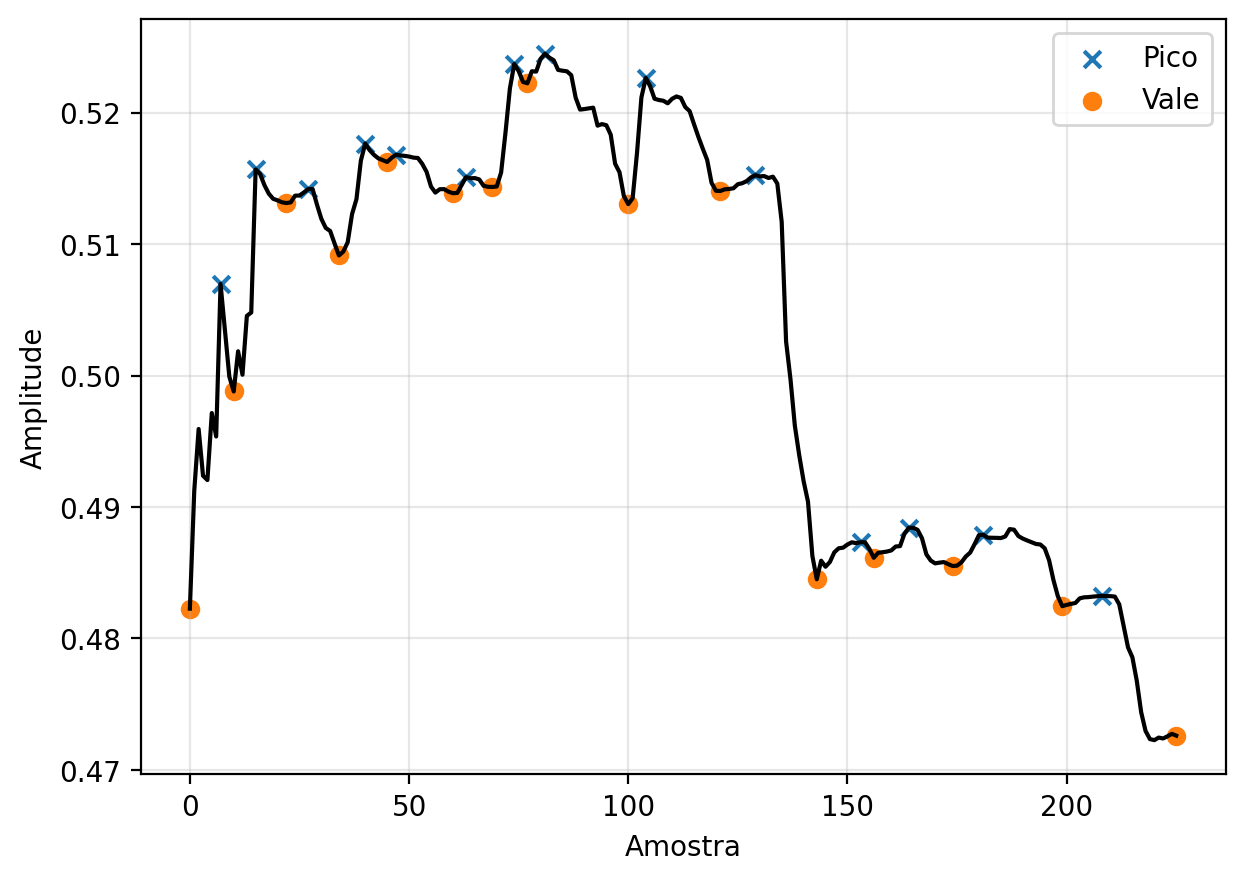

0.0018251675825852614
[ 0.00871444 -0.00149381  0.00346297 -0.00085545 -0.00169873  0.00860411
  0.00077748 -0.00183588 -0.00739938 -0.02791831  0.00109717 -0.00054142
 -0.00464037]
[ 0.01652083  0.01433277 -0.00398636  0.00711119 -0.00237668  0.00047767
  0.00788367 -0.00919431  0.00100338 -0.02953762  0.0016326  -0.0006218
 -0.00305507 -0.00984883]
n° de passos:  15
velocidade:  0.003634183239660919
velocidade em passos:  1.991150442477876
foot off:  30.08849557522124


In [102]:
from findpeaks import findpeaks
fp = findpeaks(method='peakdetect', lookahead=5)

def plot_pv(results):
    #retorna os picos e vales apenas
    peak   = results['df'][results['df']['peak'] == True]
    valley = results['df'][results['df']['valley'] == True]

    #Mostra o gráfico
    plt.figure(dpi=200, figsize=(7,5))
    plt.grid(alpha=0.3)
    plt.plot(results['df']['x'], results['df']['y'], color='k')
    plt.scatter(peak['x'], peak['y'], label='Pico', marker='x')
    plt.scatter(valley['x'], valley['y'], label='Vale', marker='o')
    plt.xlabel('Amostra')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

    return peak, valley

results1 = fp.fit(foot29_x)
peak, valley = plot_pv(results1)

dist_peaks  = np.diff(peak['y'])
dist_valley = np.diff(valley['y'])

step_lenght = abs(np.average(dist_peaks))

print(step_lenght)
print(dist_peaks)
print(dist_valley)

n_passos = len(peak) + 1
velocidade_m = (n_passos * step_lenght)/tx[-1]
velocidade_p = (n_passos)/tx[-1]
print("n° de passos: ", n_passos)
print("velocidade: ", velocidade_m)
print("velocidade em passos: ", velocidade_p)
picos = peak.y
amostra = peak.x
#step_lenght = (picos[-1] - picos[0])/len(picos)

def countX(lst, x): 
    count = 0
    for ele in lst: 
        if (ele == x): 
            count = count + 1
    return count 

foot29r = np.round(foot29_x-0.0005, 3)
nfoot_on = 0

for pico in picos:
    nfoot_on += countX(foot29r, round(pico-0.0005, 3))
    #foot_on += foot29_x
    #foot_on += countX(foot29r, round(pico-0.0004, 3))
    #print(round(pico-0.0005, 3))
    
#print(nfoot_on)
#print(foot_on)
foot_off = ((len(foot29_x) - nfoot_on)/len(foot29_x)) *100
#print(len(foot29_x))
print("foot off: ", foot_off)

Obtenção do Centroide do Paralelogramo (Média entre as coordenadas dos vértices opostos)
(31x+30x/2,31y+30y/2)

In [103]:
centroidex = (foot31_x + foot30_x)/2
centroidey = (foot31_y + foot30_y)/2
centroide = (foot31_x + foot30_x)/2, (foot31_y + foot30_y)/2
print(centroidex)
print(centroidey)
transposta = list(map(lambda *i: [j for j in i], *centroide))
print(transposta)

#centroidex = transposta[:, 0]
#centroidey = transposta[:, 1]

[0.49941339 0.50190316 0.50223468 0.50175045 0.50134361 0.50200127
 0.50218803 0.50529832 0.50289553 0.5057314  0.50375122 0.50897354
 0.50172418 0.51075548 0.5121415  0.50677557 0.50585197 0.50569737
 0.50521994 0.50449118 0.50381775 0.50355804 0.50353703 0.50373545
 0.50379589 0.50383696 0.50407854 0.50428632 0.50434098 0.50453243
 0.50457975 0.50458652 0.50447337 0.50424103 0.50390011 0.50452942
 0.50507164 0.50555536 0.50763728 0.50867726 0.50995123 0.50925045
 0.5084504  0.5076853  0.50696704 0.50650974 0.50634947 0.50638376
 0.50671293 0.50833586 0.50881749 0.50895515 0.50879735 0.50831522
 0.50817275 0.50746888 0.50624937 0.5050206  0.50366013 0.50348252
 0.50353146 0.50405714 0.50631842 0.50793394 0.5092569  0.50937809
 0.50922993 0.50921306 0.50947165 0.50958015 0.50989151 0.50992364
 0.50982127 0.50987622 0.51001488 0.51031423 0.51028214 0.51097876
 0.51203041 0.5129292  0.51451242 0.51541442 0.51582694 0.51577884
 0.51463479 0.51315242 0.51164278 0.50844425 0.50561044 0.5033

Distância do CoG ao Centroide

[0.01284642 0.01467567 0.01386219 0.01137493 0.0134031  0.00454697
 0.00541667 0.00369368 0.01755395 0.01538125 0.01648382 0.01876324
 0.01353313 0.01559812 0.00458489 0.03796876 0.04373654 0.04428054
 0.04486025 0.04548651 0.04629916 0.04674967 0.04678905 0.04615695
 0.04540854 0.04441807 0.04374431 0.04279869 0.0416529  0.04019064
 0.040377   0.04146809 0.04244663 0.04428182 0.04616376 0.04907458
 0.05022475 0.05055678 0.05207641 0.0530286  0.05337506 0.05243224
 0.05260921 0.0503894  0.04817655 0.04576009 0.04422853 0.04458775
 0.04549655 0.04661934 0.04787809 0.05172776 0.05523246 0.05819073
 0.06033967 0.06099666 0.06297186 0.06303059 0.0655532  0.06846535
 0.06654963 0.06435151 0.05987794 0.05732651 0.05711254 0.05827496
 0.05880613 0.06077991 0.06418734 0.0677956  0.0706219  0.07248119
 0.07177691 0.06969963 0.06892891 0.06953683 0.07157301 0.07073098
 0.06824894 0.0678421  0.06994931 0.07044408 0.07056524 0.07610848
 0.0797996  0.08358016 0.08741311 0.09312151 0.09535025 0.0980

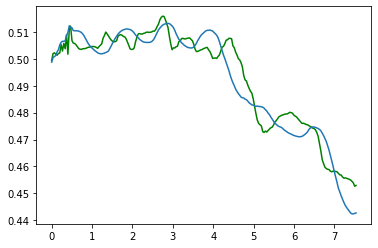

In [104]:
#Distância entre dois pontos
distancia_cog = np.sqrt((body_com_X-centroidex)**2) + ((body_com_Y-centroidey)**2)
print(distancia_cog)
print("distância média: ", np.average(distancia_cog))

for i in (distancia_cog):
    if(i != (len(distancia_cog)-1)):
        print(i, end=",")
    else: 
        print(i)

plt.plot(tx, centroidex, 'g')
plt.plot(tx, body_com_X)

Distância do CoG a borda da BoS

In [44]:
#Distância do ponto às 4 retas (usar o menor valor como distância)
from itertools import chain

norm = np.linalg.norm

# Creating points
p1 = np.array([foot31]) #ponta esquerda
p2 = np.array([foot29]) #calcanhar esquerdo
p3 = np.array([foot32]) #ponta direita
p4 = np.array([foot30]) #calcanhar direito
p5 = np.array([body_com]) #cog
'''
p1 = np.delete(foot31, 1, 1)
p2 = np.delete(foot29, 1, 1) #calcanhar esquerdo
p3 = np.delete(foot32, 1, 1) #ponta direita
p4 = np.delete(foot30, 1, 1) #calcanhar direito
p5 = np.delete(body_com, 1, 1) #cog
'''
# Finding distance of p3 from a 
# line connecting p1 and p2

dis12 = np.abs((np.cross(p2-p1, p1-p5))/norm(p2-p1))
dis13 = np.abs((np.cross(p3-p1, p1-p5))/norm(p3-p1))
dis24 = np.abs((np.cross(p2-p4, p4-p5))/norm(p2-p4))
dis34 = np.abs((np.cross(p3-p4, p4-p5))/norm(p3-p4))

#print(dis12)

#print(pp)

dis12x = dis12[:, :, 0]
dis13x = dis13[:, :, 0]
dis24x = dis24[:, :, 0]
dis34x = dis34[:, :, 0]

dis12y = dis12[:, :, 1]
dis13y = dis13[:, :, 1]
dis24y = dis24[:, :, 1]
dis34y = dis34[:, :, 1]

menor1x = np.minimum(dis12x, dis13x)
menor2x = np.minimum(dis24x, dis34x)
distanciax = np.minimum(menor1x, menor2x)
#print(distanciax)

menor1y = np.minimum(dis12y, dis13y)
menor2y = np.minimum(dis24y, dis34y)
distanciay = np.minimum(menor1y, menor2y)
#print(distanciay)

distancia_borda = np.minimum(distanciax, distanciay)
#print( distancia_borda)
distanciab_avg = np.average(distancia_borda)
distanciab_var = np.var(distancia_borda)
distanciab_desvio = np.std(distancia_borda)
print(distanciab_avg, distanciab_var, distanciab_desvio)
print("dstância até a borda: ", distanciab_avg)
'''
menor1 = np.minimum(dis12, dis13)
menor2 = np.minimum(dis24, dis34)
distanciab = np.minimum(menor1, menor2)

distanciab_avg = np.average(distanciab)
distanciab_var = np.var(distanciab)
distanciab_desvio = np.std(distanciab)
print(distanciab_avg, distanciab_var, distanciab_desvio)
'''

0.0002997596709651764 6.935117627533928e-08 0.0002633461149805314
dstância até a borda:  0.0002997596709651764


'\nmenor1 = np.minimum(dis12, dis13)\nmenor2 = np.minimum(dis24, dis34)\ndistanciab = np.minimum(menor1, menor2)\n\ndistanciab_avg = np.average(distanciab)\ndistanciab_var = np.var(distanciab)\ndistanciab_desvio = np.std(distanciab)\nprint(distanciab_avg, distanciab_var, distanciab_desvio)\n'

In [45]:
import math
#foot29 foot30 foot31 foot32
lado_direito = foot31_y - foot29_y
lado_esquerdo = foot32_y - foot30_y
diagonal_b = np.sqrt((foot29_x-foot30_x)**2) + ((foot29_y-foot30_y)**2)
diagonal_c = np.sqrt((foot31_x-foot32_x)**2) + ((foot31_y-foot32_y)**2)
#print(diagonal_b)
#print(diagonal_c)
centroide = [(diagonal_b+diagonal_c)/2, (lado_direito)]
h = foot29_x - foot30_x

In [46]:
def calculate_area(c):

    '''
    Calculates the area of any quadrivaletral
    from a list of x,y coordinates in the following format:

    [[x1,y1],[x2,y2],[x3,y3],[x4,y4]]
    '''

    first = c[0][0]*c[1][1] + c[1][0]*c[2][1] + c[2][0]*c[3][1] + c[3][0]*c[0][1]

    second = c[1][0]*c[0][1] + c[2][0]*c[1][1] + c[3][0]*c[2][1] + c[0][0]*c[3][1]

    area = 0.5*(first - second)

    return area

p1 = np.delete(foot31, 1, 1)
p2 = np.delete(foot29, 1, 1) #calcanhar esquerdo
p3 = np.delete(foot32, 1, 1) #ponta direita
p4 = np.delete(foot30, 1, 1) #calcanhar direito
c = np.concatenate((p1,p2,p3,p4), axis = 1)
area = calculate_area(c)
print(p1)

[[ 4.90474999e-01  1.64341420e-01]
 [ 4.90543067e-01  8.93534161e-03]
 [ 4.90956008e-01  2.49985121e-02]
 [ 4.91144568e-01  1.25136096e-02]
 [ 4.91744339e-01  2.11291648e-02]
 [ 4.91736025e-01  1.63182747e-02]
 [ 4.91775215e-01  2.03838907e-02]
 [ 4.91909444e-01  2.44377088e-02]
 [ 4.91874993e-01  1.70392133e-02]
 [ 4.91715670e-01  1.33365216e-02]
 [ 4.91589874e-01  1.29562942e-02]
 [ 4.91585493e-01  1.89891979e-02]
 [ 4.91598457e-01  2.10630074e-02]
 [ 4.91510212e-01  1.87418181e-02]
 [ 4.91662264e-01  4.86391522e-02]
 [ 4.92079198e-01  5.96572980e-02]
 [ 4.92066801e-01  5.44538498e-02]
 [ 4.92030054e-01  5.48305437e-02]
 [ 4.91966546e-01  5.87137230e-02]
 [ 4.92830575e-01  6.87359720e-02]
 [ 4.93357182e-01  6.99984357e-02]
 [ 4.94109213e-01  7.13758990e-02]
 [ 4.94958580e-01  6.76226467e-02]
 [ 4.95456070e-01  4.73312475e-02]
 [ 4.96466637e-01  3.13499458e-02]
 [ 4.96233314e-01  1.92764439e-02]
 [ 4.96208668e-01  9.78578068e-03]
 [ 4.94489491e-01  8.30983557e-03]
 [ 4.92158741e-01  7

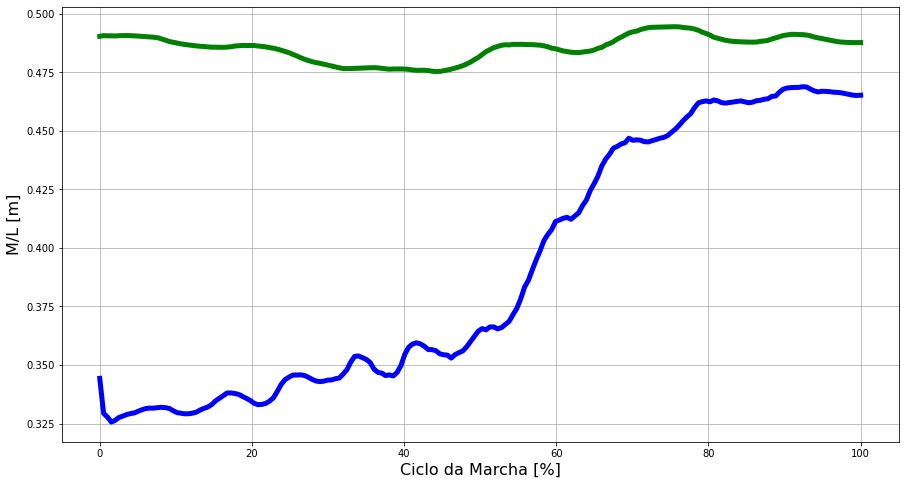

In [47]:
plt.figure(figsize=[15,8])
plt.plot(GaitCycle, body_com_Y, color = 'b', linewidth = 5)
plt.plot(GaitCycle, body_com_X, color = 'g', linewidth = 5)
#plt.plot(tx, foot_com_X1, color = 'b', linewidth = 5)
#plt.plot(foot_com_X1, foot_com_Y1, color = 'y', linewidth = 5)
plt.ylabel('M/L [m]', fontsize=16)
plt.xlabel('Ciclo da Marcha [%]', fontsize=16)
#plt.title('Excursão vertical do CoM na marcha', fontsize=16)
#plt.plot(ty1, foot_y12, 'go')
#plt.plot(tx1, foot_x12, 'ro')
#plt.plot(foot_xj2, foot_yj2, 'g')
#plt.plot(foot_xi2, foot_yi2, 'r')
#plt.plot(ty, foot29_y, 'go')
#plt.plot(ty, foot30_y, 'ro')
#plt.plot(foot_x12, foot_y12, 'ro')
plt.grid()
plt.show()

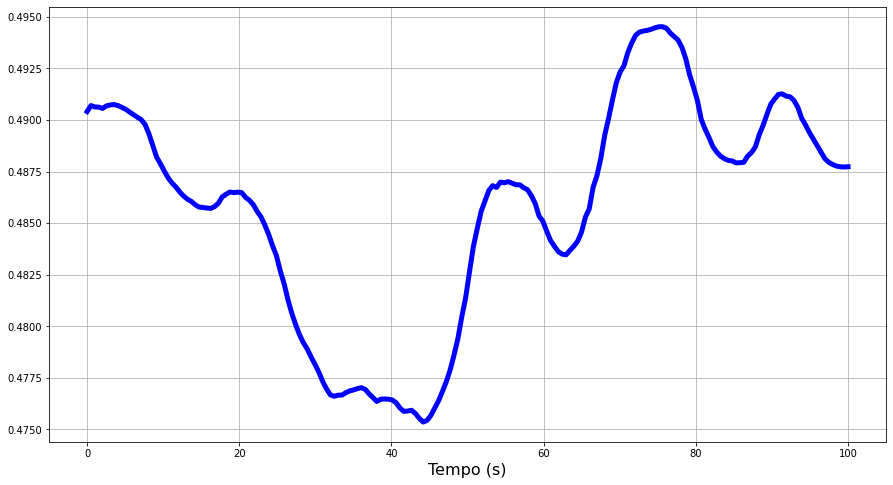

In [48]:
plt.figure(figsize=[15,8])
plt.plot(GaitCycle, body_com_X, color = 'b', linewidth = 5)
#plt.plot(tx, foot_com_X1, color = 'b', linewidth = 5)
#plt.plot(foot_com_X1, foot_com_Y1, color = 'y', linewidth = 5)
#plt.ylabel('A/P', fontsize=16)
plt.xlabel('Tempo (s)', fontsize=16)
#plt.title('Excursão vertical do CoM na marcha', fontsize=16)
#plt.plot(ty1, foot_y12, 'go')
#plt.plot(tx1, foot_x12, 'ro')
#plt.plot(foot_xj2, foot_yj2, 'g')
#plt.plot(foot_xi2, foot_yi2, 'r')
#plt.plot(tx, foot29_x, 'go')
#plt.plot(tx, foot30_x, 'ro')
#plt.plot(foot_x12, foot_y12, 'ro')
plt.grid()
plt.show()

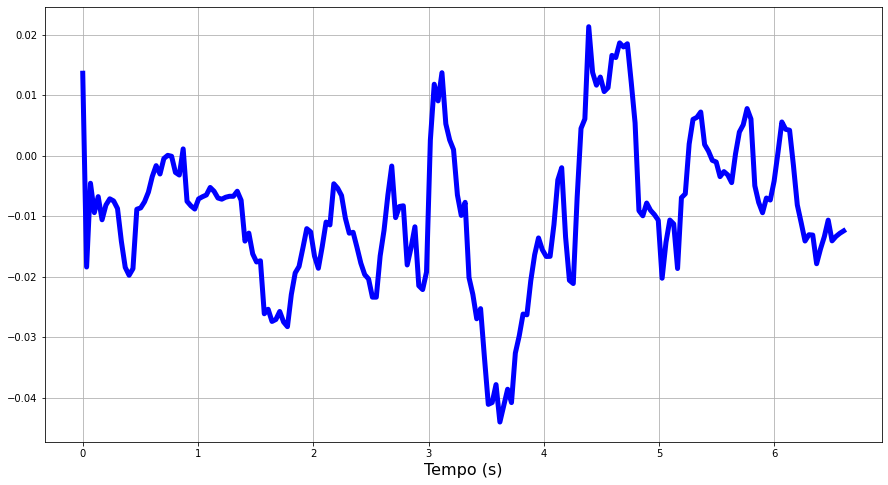

In [49]:

plt.figure(figsize=[15,8])
plt.plot(tz, body_com_Z, color = 'b', linewidth = 5)
#plt.plot(tx, foot_com_X1, color = 'b', linewidth = 5)
#plt.plot(foot_com_X1, foot_com_Y1, color = 'y', linewidth = 5)
#plt.ylabel('A/P', fontsize=16)
plt.xlabel('Tempo (s)', fontsize=16)
#plt.title('Excursão vertical do CoM na marcha', fontsize=16)
#plt.plot(ty1, foot_y12, 'go')
#plt.plot(tx1, foot_x12, 'ro')
#plt.plot(foot_xj2, foot_yj2, 'g')
#plt.plot(foot_xi2, foot_yi2, 'r')
#plt.plot(tx, foot29_x, 'go')
#plt.plot(tx, foot30_x, 'ro')
#plt.plot(foot_x12, foot_y12, 'ro')
plt.grid()
plt.show()

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


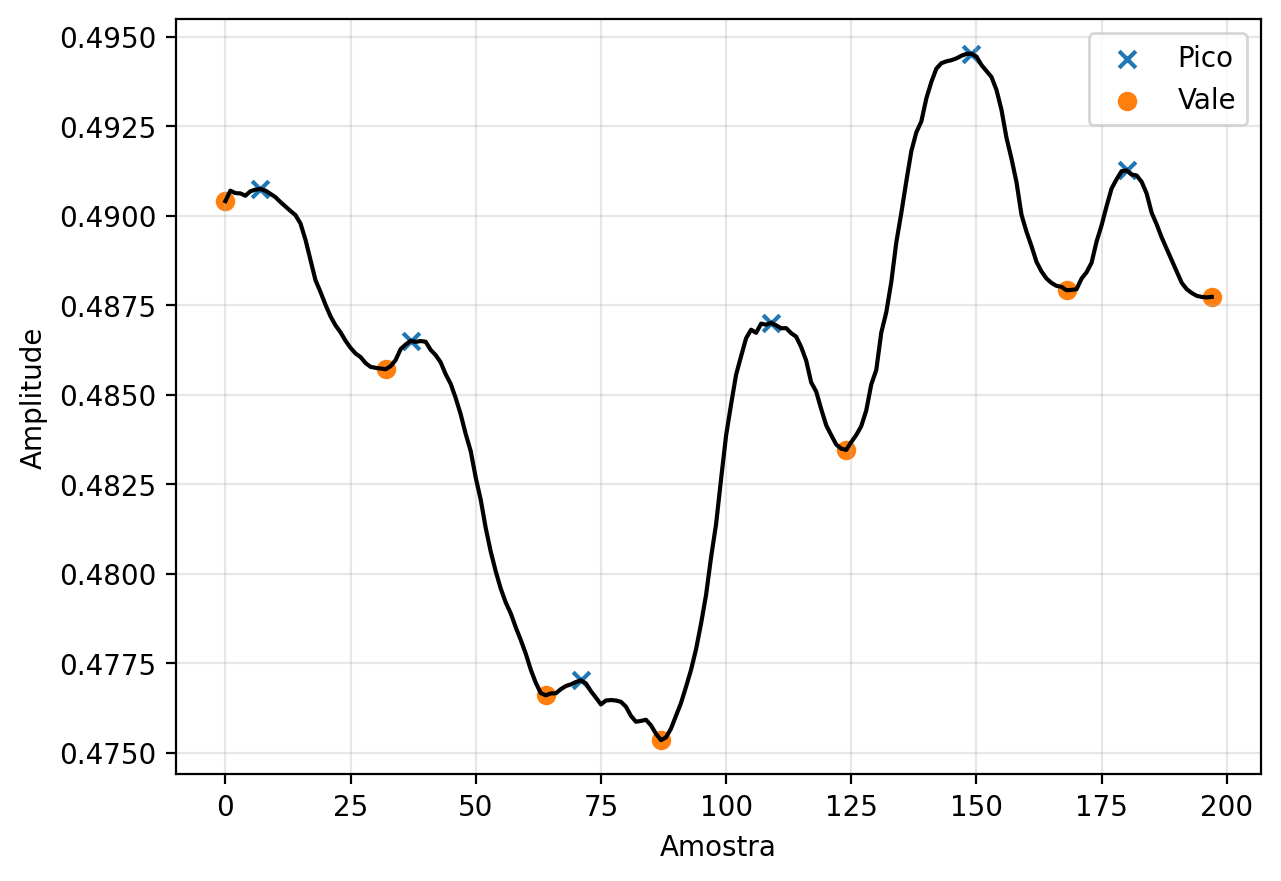

[30 34 38 40 31]
[32 32 23 37 44 29]


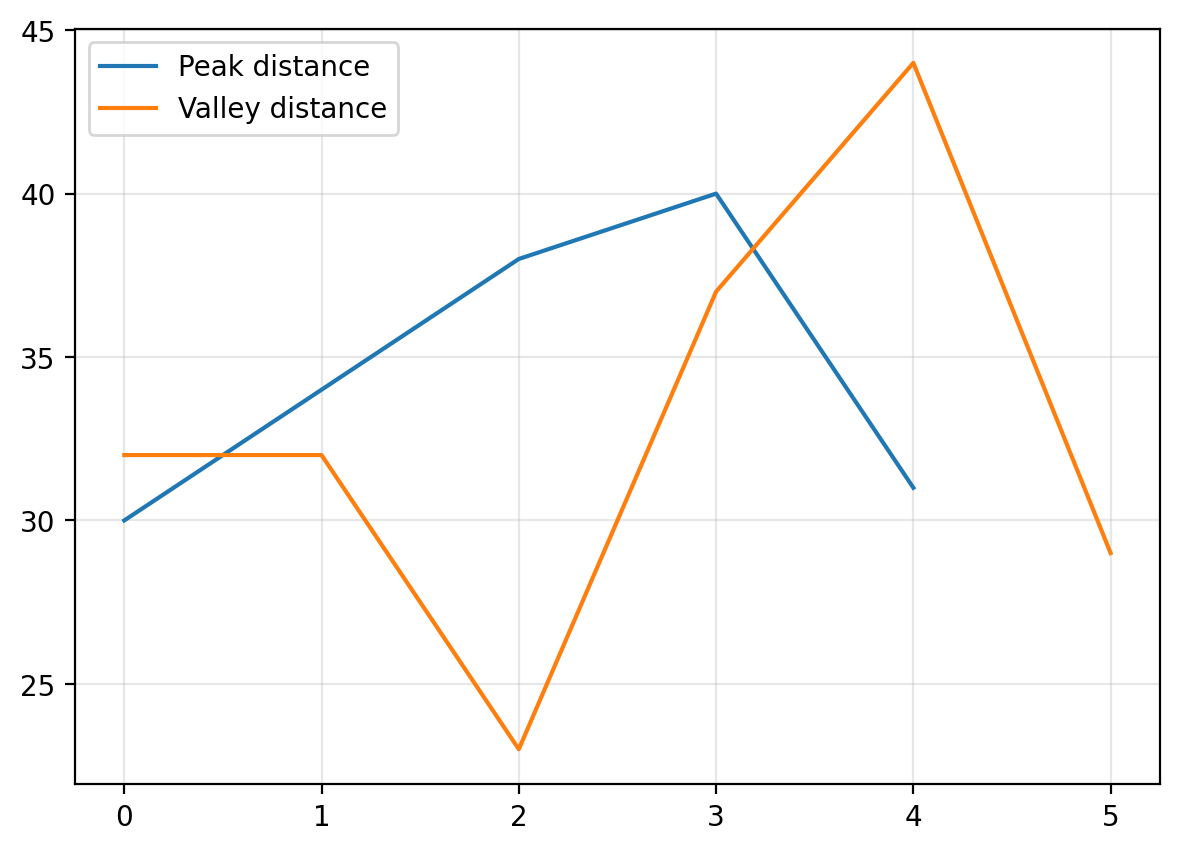

7


In [50]:


#Chama a função com os resultados obtidos anteriormente
#matriz = np.concatenate((tx, filteredx))
results = fp.fit(body_com_X)
peak, valley = plot_pv(results)

dist_peaks  = np.diff(peak['x'])
dist_valley = np.diff(valley['x'])

print(dist_peaks)
print(dist_valley)

plt.figure(dpi=200, figsize=(7,5))
plt.grid(alpha=0.3)
plt.plot(dist_peaks, label='Peak distance')
plt.plot(dist_valley, label='Valley distance')
plt.legend()
plt.show()

print(len(valley))

In [51]:
#print(2*filteredx[45]-filteredx[0])

# Filtragem

In [52]:
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

In [53]:
# apply a 2-pole lowpass filter at 0.15x Nyquist frequency (15 hz is half the max frequency of the video (30Hz))
bx, ax = scipy.signal.butter(2, 0.2)
filteredx = scipy.signal.filtfilt(bx, ax, body_com_X, axis=0)

by, ay = scipy.signal.butter(2, 0.2)
filteredy = scipy.signal.filtfilt(by, ay, body_com_Y, axis=0)

bz, az = scipy.signal.butter(2, 0.2)
filteredz = scipy.signal.filtfilt(bz, az, body_com_Z, axis=0)

b30z, a30z = scipy.signal.butter(2, 0.2)
filtered30z = scipy.signal.filtfilt(b30z, a30z, foot30_z, axis=0)

b29z, a29z = scipy.signal.butter(2, 0.2)
filtered29z = scipy.signal.filtfilt(b29z, a29z, foot29_z, axis=0)

b30y, a30y = scipy.signal.butter(2, 0.2)
filtered30y = scipy.signal.filtfilt(b30y, a30y, foot30_y, axis=0)

b29y, a29y = scipy.signal.butter(2, 0.2)
filtered29y = scipy.signal.filtfilt(b29y, a29y, foot29_y, axis=0)

b30x, a30x = scipy.signal.butter(2, 0.2)
filtered30x = scipy.signal.filtfilt(b30x, a30x, foot30_x, axis=0)

b29x, a29x = scipy.signal.butter(2, 0.2)
filtered29x = scipy.signal.filtfilt(b29x, a29x, foot29_x, axis=0)


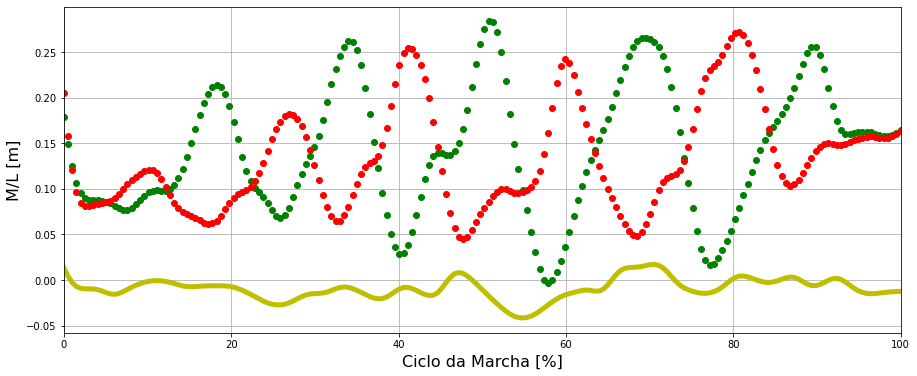

In [54]:
plt.figure(figsize=[15, 6])
plt.plot(GaitCycle, filteredz, color = 'y', linewidth = 5)
plt.ylabel('M/L [m]', fontsize=16)
plt.xlabel('Ciclo da Marcha [%]', fontsize=16)
plt.plot(GaitCycle, filtered30z, 'go')
plt.plot(GaitCycle, filtered29z, 'ro')
#plt.title('Excursão vertical com filtro Butterworth', fontsize=16)
plt.xlim(0, 100)
#plt.ylim(0.03, 0.07)
plt.grid()
plt.show()

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


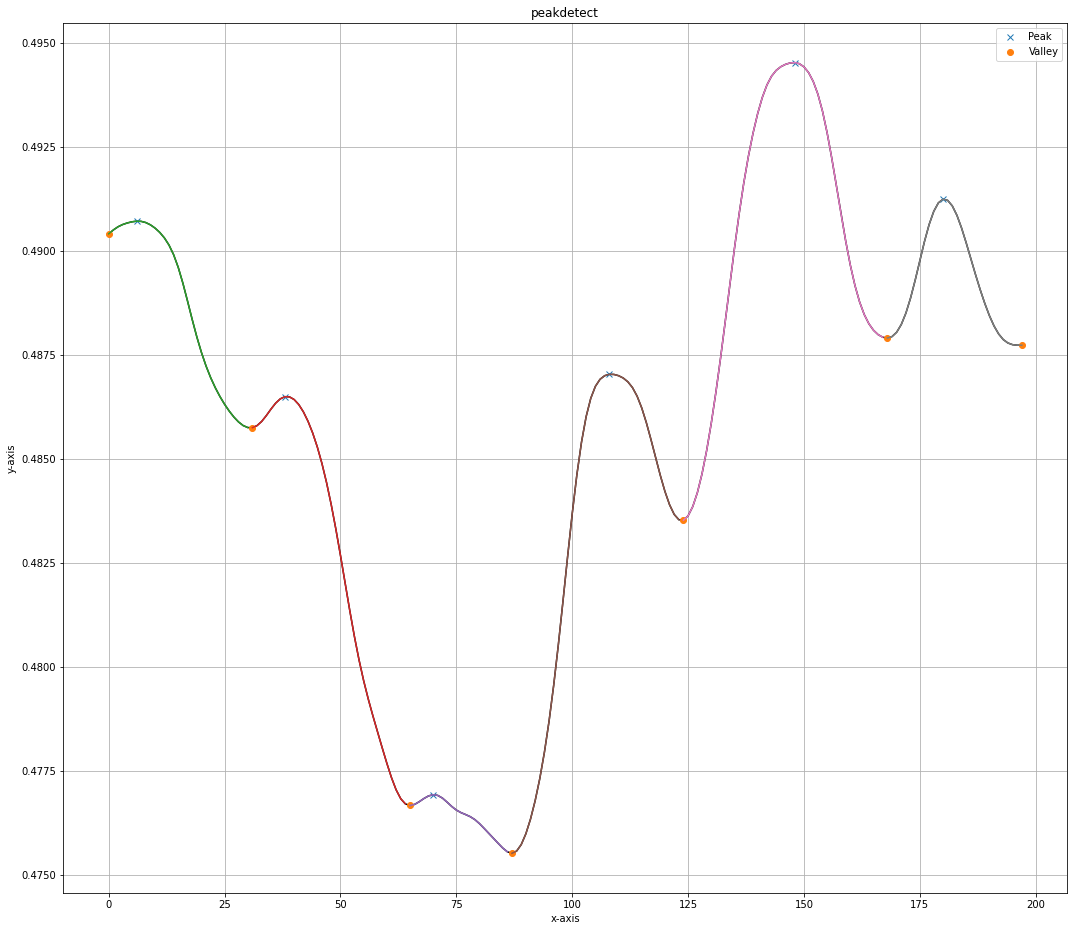

(None,
 <AxesSubplot:title={'center':'peakdetect'}, xlabel='x-axis', ylabel='y-axis'>)

In [55]:

results = fp.fit(filteredx)
fp.plot(figsize=(18,16))


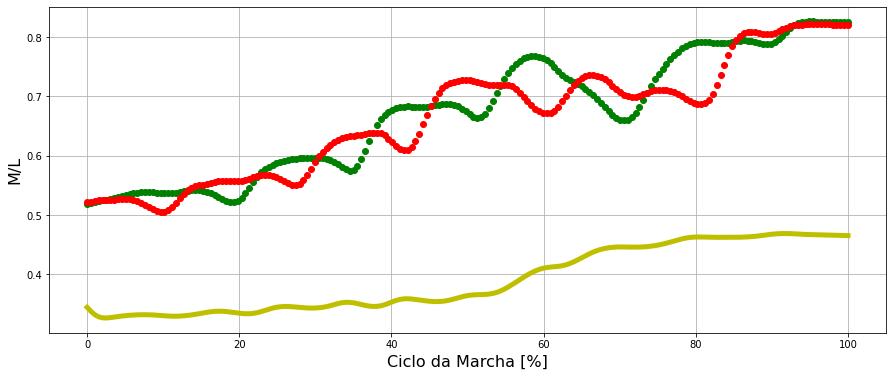

In [56]:
plt.figure(figsize=[15, 6])
plt.plot(GaitCycle, filteredy, color = 'y', linewidth = 5)
plt.ylabel('M/L', fontsize=16)
plt.xlabel('Ciclo da Marcha [%]', fontsize=16)
plt.plot(GaitCycle, filtered30y, 'go')
plt.plot(GaitCycle, filtered29y, 'ro')
#plt.ylim(0.6, 0.9)
#plt.title('', fontsize=16)
plt.grid()
plt.show()

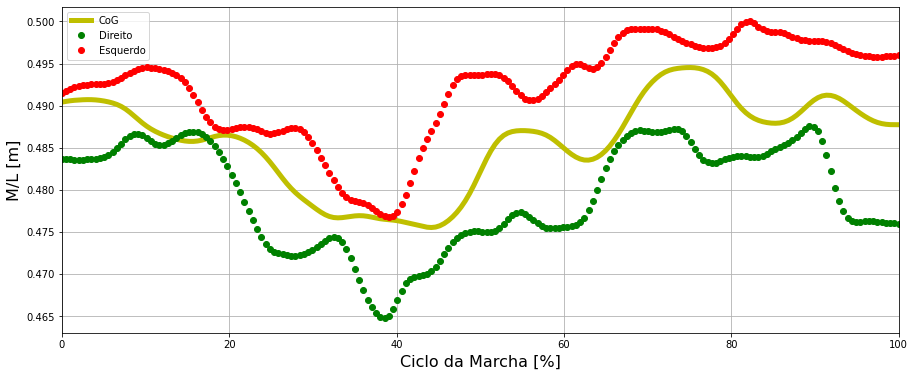

In [57]:
plt.figure(figsize=[15, 6])
plt.plot(GaitCycle, filteredx, color = 'y', linewidth = 5)
plt.ylabel('M/L [m]', fontsize=16)
plt.xlabel('Ciclo da Marcha [%]', fontsize=16)
plt.plot(GaitCycle, filtered30x, 'go')
plt.plot(GaitCycle, filtered29x, 'ro')
plt.xlim(0, 100)
plt.legend(['CoG', 'Direito', 'Esquerdo'])
#plt.title('Excursão vertical com filtro Butterworth', fontsize=16)
plt.grid()
plt.show()

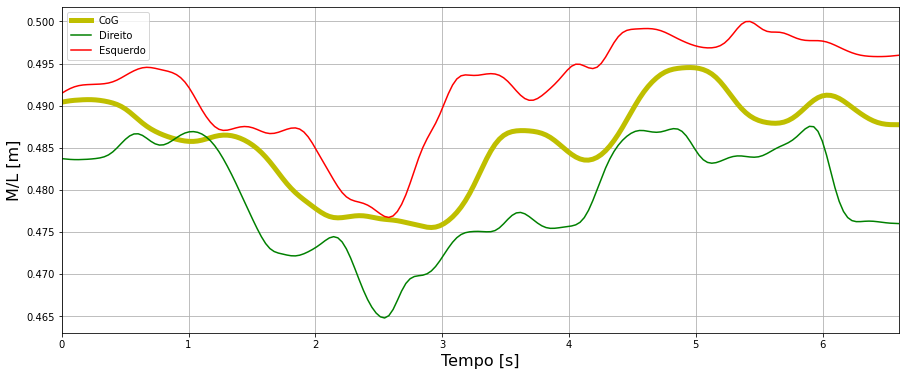

In [58]:
plt.figure(figsize=[15, 6])
plt.plot(tx, filteredx, color = 'y', linewidth = 5)
plt.ylabel('M/L [m]', fontsize=16)
plt.xlabel('Tempo [s]', fontsize=16)
plt.plot(tx, filtered30x, 'g')
plt.plot(tx, filtered29x, 'r')
plt.xlim(0, tx[-1])
plt.legend(['CoG', 'Direito', 'Esquerdo'])
#plt.title('Excursão vertical com filtro Butterworth', fontsize=16)
plt.grid()
plt.show()

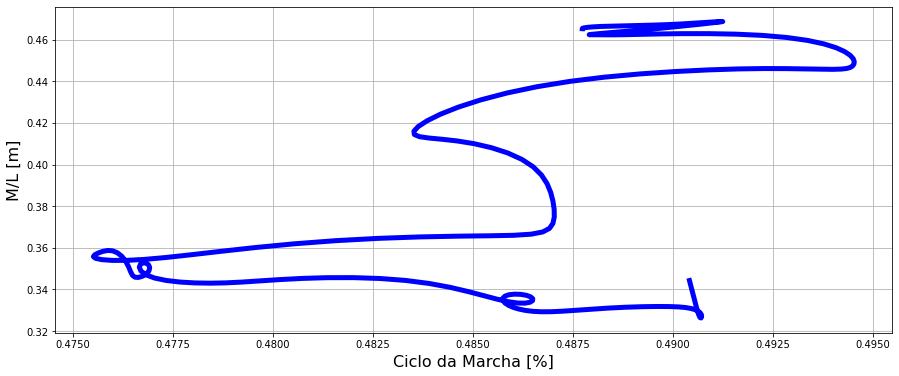

In [59]:
plt.figure(figsize=[15, 6])
#plt.plot(GaitCycle, filteredx, color = 'y', linewidth = 5)
plt.plot(filteredx, filteredy, color = 'b', linewidth = 5)
plt.ylabel('M/L [m]', fontsize=16)
plt.xlabel('Ciclo da Marcha [%]', fontsize=16)
#plt.plot(GaitCycle, filtered30x, 'go')
#plt.plot(GaitCycle, filtered29x, 'ro')
#plt.xlim(0, 100)
#plt.legend(['CoG', 'Direito', 'Esquerdo'])
#plt.title('Excursão vertical com filtro Butterworth', fontsize=16)
plt.grid()
plt.show()

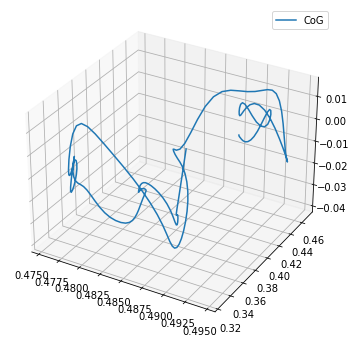

In [60]:
from mpl_toolkits.mplot3d import axes3d

ax = plt.figure(figsize=[15, 6]).add_subplot(projection='3d')

ax.plot(filteredx, filteredy, filteredz, label='CoG')
ax.legend()
plt.show()

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


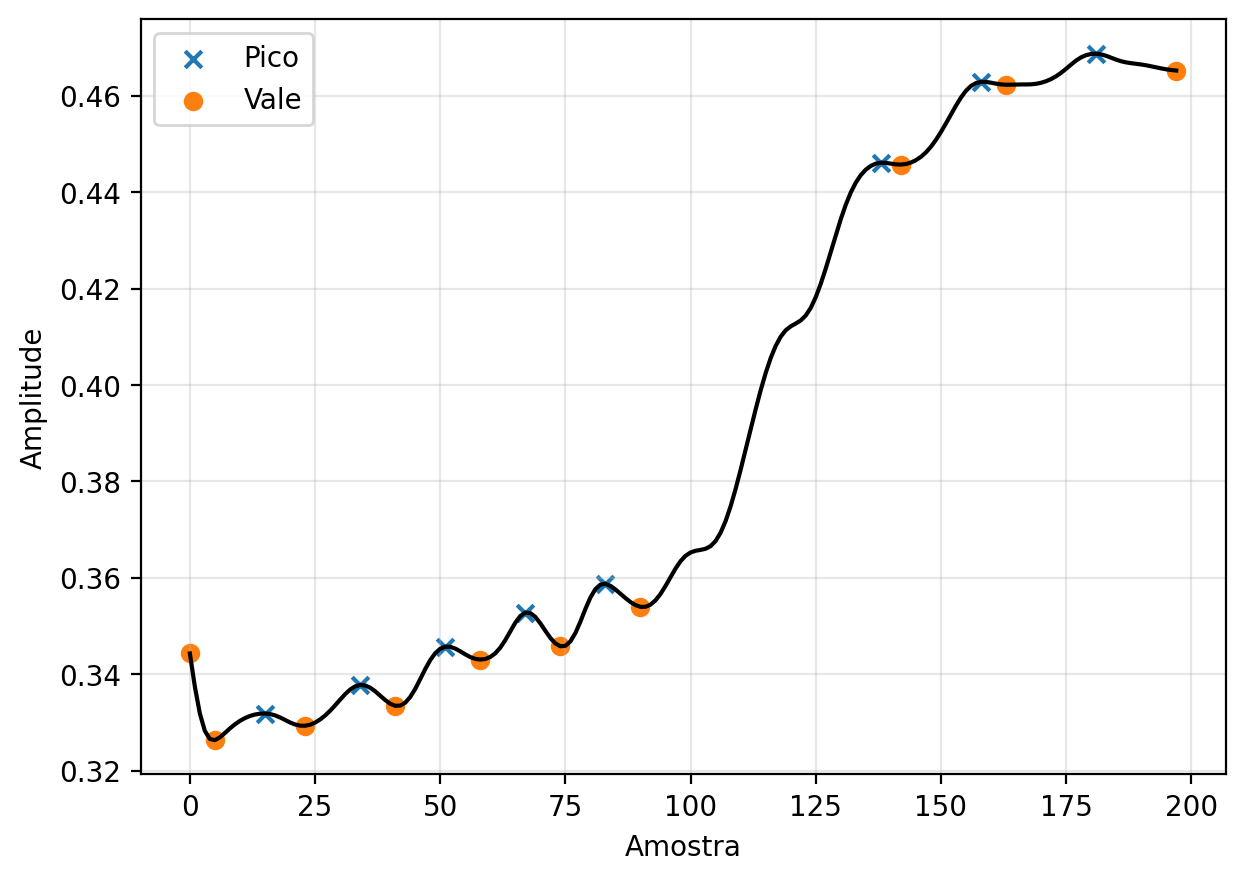

0.019556058462104602
[0.00592446 0.00793156 0.00707325 0.00597763 0.0873694  0.01676956
 0.00584656]
[-0.01797955  0.00298054  0.00414401  0.00959245  0.00275418  0.00818483
  0.09176539  0.01656716  0.00294524]
n° de passos:  12
velocidade:  0.035556469931099274
velocidade em passos:  1.8181818181818183
foot off:  100.0


In [62]:
from findpeaks import findpeaks
fp = findpeaks(method='peakdetect', lookahead=5)

def plot_pv(results):
    #retorna os picos e vales apenas
    peak   = results['df'][results['df']['peak'] == True]
    valley = results['df'][results['df']['valley'] == True]

    #Mostra o gráfico
    plt.figure(dpi=200, figsize=(7,5))
    plt.grid(alpha=0.3)
    plt.plot(results['df']['x'], results['df']['y'], color='k')
    plt.scatter(peak['x'], peak['y'], label='Pico', marker='x')
    plt.scatter(valley['x'], valley['y'], label='Vale', marker='o')
    plt.xlabel('Amostra')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

    return peak, valley

results1 = fp.fit(filteredy)
peak, valley = plot_pv(results1)

dist_peaks  = np.diff(peak['y'])
dist_valley = np.diff(valley['y'])

step_lenght = abs(np.average(dist_peaks))

print(step_lenght)
print(dist_peaks)
print(dist_valley)

n_passos = len(valley) + 2
velocidade_m = (n_passos * step_lenght)/tx[-1]
velocidade_p = (n_passos)/tx[-1]
print("n° de passos: ", n_passos)
print("velocidade: ", velocidade_m)
print("velocidade em passos: ", velocidade_p)
picos = peak.y
amostra = peak.x
#step_lenght = (picos[-1] - picos[0])/len(picos)

def countX(lst, x): 
    count = 0
    for ele in lst: 
        if (ele == x): 
            count = count + 1
    return count 

foot29r = np.round(foot29_x-0.0005, 3)
nfoot_on = 0

for pico in picos:
    nfoot_on += countX(foot29r, round(pico-0.0005, 3))
    #foot_on += foot29_x
    #foot_on += countX(foot29r, round(pico-0.0004, 3))
    #print(round(pico-0.0005, 3))
    
#print(nfoot_on)
#print(foot_on)
foot_off = ((len(foot29_x) - nfoot_on)/len(foot29_x)) *100
#print(len(foot29_x))
print("foot off: ", foot_off)

ICC

In [105]:
#d1 = [0.038749389645609734,0.04564684264769427,0.04629716708696106,0.04680642437234611,0.04632812570230212,0.046118654826032154,0.04604966122750622,0.04611732450522933,0.04623870768635606,0.04644453431888336,0.046277013597867685,0.04606777232742692,0.045844263251434356,0.045078122138775996,0.044172193813110903,0.04353537142843166,0.04283536589039098,0.043257359642899056,0.043673718893533026,0.044635167712210766,0.04512109892612769,0.0459064213080351,0.04744802828186696,0.04917589859248956,0.05159186542473063,0.05317552101624011,0.05402918718207836,0.05347940624853504,0.05287155346446878,0.051615695357242836,0.05058546172869511,0.04970081312011452,0.0490990890454074,0.048671106585492424,0.048297528425600464,0.04723693361527043,0.04583308532751338,0.045612065396475374,0.04686003232924159,0.04818802125838124,0.05056697795223704,0.053920145062972484,0.05739361701582312,0.06186856366125085,0.06422246431009629,0.06399186486695518,0.06318352204080298,0.06242910427407674,0.06214547712807703,0.06244818042846551,0.06165459490117707,0.06103951499871874,0.06026561270940583,0.06081609617124071,0.06175121620178005,0.06282198428005638,0.06445009445698599,0.06667631123373391,0.06988355831591454,0.07286354964216123,0.07531327540757685,0.07636161498622869,0.07300099727651153,0.07227295075853825,0.0731549785410436,0.07418049832750605,0.07468457994680416,0.07247727137239476,0.07096128848839481,0.0733583658327533,0.07593947612436276,0.08246503989212706,0.09095681398721292,0.09855897038545387,0.10387973796071334,0.10593715950398527,0.10918857729566649,0.10793981238116652,0.10762601424642484,0.10384177929913281,0.09927432684525676,0.0963124811490686,0.09664076072418763,0.09970665877419323,0.10234163612022777,0.10561331074078426,0.11224136707384322,0.11952364874928241,0.1250272546619751,0.1310051320860881,0.1349772308847746,0.1384109482070424,0.13789348856231393,0.1371562389167637,0.13826727646378595,0.13821485000286426,0.13726412217231793,0.13493070964387655,0.13053841457076223,0.12619914407567528,0.12525417005943337,0.1253358940613381,0.12553245223088833,0.12658243791176127,0.12914313927138277,0.13512057808330383,0.1407054599088431,0.1438083421049257,0.14406747371131529,0.14127557755638329,0.13792030125882604,0.1360909197755897,0.13073280146784025,0.12735434720541258,0.12408642172427096,0.11900882166348875,0.11669271824127558,0.11457707448910208,0.11143077794971905,0.11091825777276992,0.11020873645813196,0.10937880138487427,0.10738220028284089,0.10624335269009254,0.1045497754367734,0.10765445070784341,0.10929761918405863,0.1080553266770483,0.10511905180301825,0.10065719939383534,0.09673827104098683,0.0919153151396882,0.08743668853968622,0.08310345620208742,0.07894075036713935,0.07486200392123026,0.07044329118129283,0.06574738079456302,0.06608060026220805,0.06568083216291737,0.06660895497919431,0.06814654901103158,0.06927604052787038,0.07281793852289123,0.07666724672823791,0.08199381546361681,0.084946437058027,0.08612408957931157,0.08781642195004642,0.0894769370181854,0.09060113137047877,0.09139892905127961,0.09150202410506848,0.09120143254581659,0.09072591627612347,0.08922306561894319,0.0896211711065445,0.09111995503994584,0.09237518881981303,0.09371338182153334,0.09833499450462352,0.09959075921057019,0.10304050940154796,0.10757699544679238,0.11272898841605948,0.11853750908914529,0.12509820288423384,0.13140165980791083,0.1345348064082858,0.13608607603434997,0.1357360421711,0.13643214886698707,0.13490530192864816,0.13297957034425445,0.1312150013783034,0.13006891793867245,0.12856637706410373,0.1280618139142302,0.1301166992480938,0.13263421228774286,0.13790890381227994,0.14329583071253857,0.14928710455138094,0.15186600653711665,0.1515403685868387,0.15159577729546722,0.15267537522194036,0.15265391745029366,0.15244068432505747,0.1522404339330641,0.15158635332590464,0.15121239382986557,0.15131234590869588,0.15139890775645568,0.15149910197070696,0.1516951411371498,0.1517263624274286,0.15161107267657062]

#d2 = [0.05415402471082135,0.054641376363563046,0.05449095932716428,0.05398249971486908,0.054250956158430244,0.05478766435049109,0.05568379126597761,0.05635411853158532,0.05670846576242518,0.05608947883364452,0.05578708625645955,0.05566972039935938,0.05541863546718454,0.05524648424459554,0.05498234083115497,0.05434401373968608,0.05427412309958232,0.054098530270201076,0.05396802928940989,0.053756523755448725,0.05355528799058844,0.0535051303454878,0.05344068086378246,0.05333773902760846,0.0533879685831075,0.05372068693722742,0.05406509314147184,0.05474915438113991,0.055532139178705975,0.056176877140460185,0.056843266119518406,0.05764853690364595,0.05725484212796299,0.05624774543651346,0.05571500060867901,0.055643835806618136,0.055540339476796964,0.055848976734521764,0.05640014037644617,0.05683625996181252,0.05723729989593935,0.05713138477308896,0.056427452739967826,0.05418324910744531,0.0548434308045394,0.05481841023043077,0.0543676248354703,0.0526931041308284,0.05041241921506164,0.04895950112747821,0.047468838401056465,0.04580006413869124,0.045343795778870634,0.04807988951485242,0.050756931221234404,0.05289918921863192,0.05559719597960656,0.05902825597920058,0.062025933142930034,0.06452729641833915,0.06480591940282793,0.06513026542596047,0.06479749771580261,0.0620465366480766,0.06041885039661259,0.05800232535090115,0.05571220101450894,0.05372699569688418,0.04970275411594781,0.05009621362102491,0.05057223824465779,0.0512547693144181,0.053627033159664,0.05608596208484114,0.060525217611073795,0.06288267472086283,0.06602011106806405,0.06798522726085192,0.06954506123206525,0.0712927169108099,0.07087413352839096,0.07109436430987404,0.0693831291023976,0.06655201473536426,0.06313457280041249,0.05960911047563823,0.057119472781191,0.05769003918771025,0.05699677503107827,0.05809728296728,0.05873149360674767,0.05997434571274543,0.061279831208104193,0.06191078312236535,0.06088551944031734,0.05935226547562375,0.05873397390355276,0.05910373963002522,0.060335409313350574,0.06131243955610785,0.06063531694290722,0.060454234207974696,0.060834544252754016,0.06144248683799784,0.06273962779479028,0.06626031212992388,0.06767566980376466,0.06955860231248231,0.07007462431347966,0.0708065773790461,0.07168042131973384,0.0699236121837353,0.06212671583300146,0.056555041667463585,0.054062410778876385,0.05200003343609351,0.04822032922939143,0.051063299747257845,0.051895481795082465,0.052814224189175606,0.053889723616192514,0.05547508450536725,0.05446593712183822,0.054483434846982495,0.0533599854345865,0.05048972063054967,0.046277370795657316,0.04194424273716211,0.041002486825008067,0.040480410920875926,0.042428999944525723,0.04264867563873954,0.04285165333459732,0.04210932644937281,0.04377408745464194,0.04367602326936487,0.04452202303482474,0.04685507261336297,0.048819760932829345,0.05072559081417716,0.05235675185147333,0.051519748544111,0.05031269448278668,0.04731652404018879,0.04508664250089749,0.044914295363447515,0.03931291597012883,0.040803019339652635,0.037158940529115635,0.03689376011547766,0.03762112069128626,0.03819035204507021,0.04077939847875274,0.04531211001150057,0.04952480708076987,0.05298960243587292,0.05691736044984887,0.057402342202215996,0.057895273808132565,0.05891691042002666,0.05458789236665459,0.05193579217135709,0.05202398402323016,0.051867442982298916,0.052849356942671864,0.05127112860620523,0.05005982722678549,0.047656440156727514,0.0473175737085165,0.05073380415894106,0.05263139045857696,0.054288947653018504,0.05618423651875983,0.05724536276763566,0.059484344678702575,0.06275672336980256,0.06671327040250766,0.06875010161344294,0.07280633312806613,0.0750016399882987,0.07728944761930796,0.0768500383954756,0.07473193570882461,0.07287120033011246,0.06884644376142687,0.06563964975051016,0.0631401972465625,0.06312282153931228,0.06399885297027291,0.06633775988498207,0.0685790266157441,0.07154112611106203,0.07423982690916293,0.07751061436342974,0.08075513226192076,0.08472647057605742,0.08657353000895118,0.08463908058843629,0.08848882195827025,0.08868229437537963,0.08903859999361532,0.08932167306839912,0.09169638216984695,0.09306845900633862,0.09401604266676351,0.09327782703250834,0.09178726679553587,0.08992323432560716,0.08870317204924924,0.08700532050433543,0.08569304279301312,0.08602034051392084,0.08712774283796061,0.08881430224274287,0.09212606438447075,0.09411573863543575,0.09806288610245087,0.10040268229415515,0.10319119253015754,0.10586052600230814,0.10470978919329442,0.10855728612387433,0.10909887190243657,0.11033066770784915,0.10910329562791997,0.10815965630251712,0.11310512749985388,0.11752810083776875,0.121077222770715,0.1273116837741506,0.12969771199794722,0.13323323816642593,0.13642973527971514,0.1401237254060526,0.14337875655164328,0.14440890480826873,0.14774823609722249]

d1 = [0.045036880266204844,0.04448686379431548,0.04443074316228485,0.044306329995504906,0.04417198247448682,0.04348299503327603,0.043156015746601745,0.043221935864424146,0.042722651398885515,0.04233831460361148,0.04238207231736763,0.042859858096544017,0.04340283016254559,0.043378253982474316,0.04327918366805172,0.043319613569715205,0.04349794032669133,0.04344420164961561,0.04304648824524471,0.04310220112151144,0.04237713826395889,0.04173078294724505,0.04107405728302178,0.04083143942446388,0.04118738230815243,0.041568998842324824,0.04260486336440011,0.04352541421524876,0.04545587300502003,0.048414126941478695,0.05090740053900393,0.05177960932946723,0.05245043523583537,0.05101933348575883,0.05178062063753463,0.05170129278291557,0.05098188209695295,0.05067503004919456,0.04809459033721514,0.04763089062674455,0.04713271376227308,0.04639909510056277,0.04480862484131478,0.044355657768236634,0.04483184037422655,0.04625523354783684,0.0474731718742116,0.050934799620072434,0.05391826494063903,0.056924263772775374,0.05996880057022324,0.06189406922106514,0.06139478047939095,0.0620206629100433,0.06220769915778827,0.061099653384670875,0.059626035275821006,0.05873381256963679,0.05873100800726592,0.05758409498796787,0.05846774606634691,0.05748478027522991,0.0578300570029522,0.05928245783075802,0.06184554555595522,0.06588350268422083,0.06798597153980948,0.06915260974801317,0.0717602671683651,0.0705009532270475,0.07118106996990446,0.07131672214133065,0.07040918033965302,0.06911560193859248,0.06934482423864023,0.06990350128866524,0.06981374080673781,0.06687608521865616,0.06203131466563467,0.06312270147580382,0.06540100510121546,0.06874623866083612,0.07537145344962187,0.08015149753434381,0.0889907429399797,0.09225587299009047,0.09218026306370682,0.09356846993877542,0.09461768102832427,0.09314862520331814,0.0926977362743415,0.09160299352691696,0.09035680228534146,0.08815902545385458,0.08855108221319132,0.09048658427367018,0.09286381711827277,0.09710377697072463,0.10306846260440085,0.1094076201710918,0.11265550722561354,0.11299018357413895,0.11287675318533891,0.11382294080401166,0.1131446124358249,0.1118762994005192,0.11337637627760688,0.11261445419087061,0.1113333084750138,0.10980767402859315,0.11305037867209229,0.11644729292487585,0.12590485739164473,0.13316224672028742,0.14711340794944316,0.1562545067838523,0.16497329394037696,0.16585883665069273,0.16517515244195205,0.16467878781234313,0.1662517122778663,0.1663644104680856,0.16835411256868904,0.17020359520173942,0.1736003823790388,0.17029216574922706,0.16701166401015663,0.16113769538942677,0.15837087745686326,0.1605079341604663,0.1676121393118694,0.17854208603541022,0.18632814108167234,0.19069383093493758,0.19509022865720493,0.18947493565174675,0.17894435367393965,0.16314120011248717,0.1501659939846043,0.14082278228056136,0.12918846373416862,0.12006212967124147,0.10828741203136481,0.1005153991023092,0.09359835405994531,0.08768680552431829,0.08062990492189157,0.07548047407145596,0.07136709896306485,0.06828308008537944,0.06594998404800796,0.06663711878367946,0.06954977225343412,0.07374892434833467,0.07657253721826264,0.07518406091179133,0.07618852814396523,0.07630569052597584,0.07620430796409451,0.07584397873127051,0.0757666393132213,0.07663352442699195,0.07695771168683714,0.07596800816502461,0.07477718830648822,0.0753669122798612,0.0746476345136843,0.07411291544346511,0.07639963573588664,0.07867290790007646,0.08325204026400618,0.08885074031744478,0.09425565483896697,0.09886411818858651,0.10113143735857874,0.10475583730331962,0.10541717882899779,0.10603854085720682,0.10609757719739907,0.10566780737217152,0.10529311381689672,0.10535355316103144,0.10550011255534596,0.1050014292470638,0.10290575958090595,0.10188352828590298,0.1017622267643026,0.1021268564769529,0.10175852643951429,0.1001765956625901,0.10097650207962669,0.10350760567046964,0.10620700198368228,0.10990517434491871,0.11463390292341463,0.11888389729509255,0.12231027105781374,0.12511532912153112,0.1270146037181391,0.12856723700539444,0.12909025364854468,0.12856095357003555,0.12767955038416468,0.1265220484145747,0.12578557346372637,0.12435760160658513,0.12289313571416927,0.12172825376396511,0.12152981472923319,0.1209686475117623,0.1205126167152536,0.11997444662935808]

d2 = [0.012846418558673493,0.01467566583766895,0.013862187170148683,0.011374927111293572,0.013403095853239715,0.004546967239838901,0.005416665121768947,0.0036936766240373486,0.01755395076387227,0.015381246012687828,0.016483820611353825,0.01876324378987812,0.013533132219312325,0.015598116310014305,0.004584887032616601,0.037968757120582355,0.04373653688569097,0.04428054333815038,0.044860250664014986,0.045486509355177104,0.04629915500928161,0.046749671734626,0.046789051024136975,0.04615694641668566,0.04540853902977123,0.0444180741090326,0.04374430859496352,0.042798691448729026,0.041652895118353274,0.040190638246598145,0.040376996995398526,0.04146809201841882,0.04244663038942136,0.04428182253070881,0.0461637641161772,0.04907458191087376,0.05022474858826368,0.05055678138174385,0.05207641267045701,0.05302860372360201,0.05337506196032507,0.05243223633804028,0.05260920940406015,0.05038939667912854,0.048176549319122845,0.04576009067223625,0.044228527064775064,0.04458774978209681,0.045496548719655736,0.0466193370160687,0.04787808521900054,0.051727758110399036,0.05523245517624481,0.058190733295131934,0.060339673761255715,0.06099665516780705,0.06297186389016252,0.06303059247572157,0.06555320291416453,0.06846535007962812,0.06654963386207724,0.06435151283351088,0.0598779392832265,0.0573265146720263,0.057112536040154455,0.05827495648911453,0.05880612935394923,0.06077991243433239,0.06418733849361008,0.06779559641468794,0.07062189968164141,0.07248119173105037,0.0717769127162435,0.06969962989577369,0.0689289101989546,0.06953682776254,0.0715730055206255,0.07073098259821713,0.06824894255772444,0.06784209947237066,0.06994931419213155,0.07044407784149963,0.0705652375573582,0.07610848253184935,0.07979959510794356,0.08358016206373614,0.08741311442641997,0.09312150817816815,0.09535024662309076,0.0980316949726498,0.09610700423710694,0.09433801016299562,0.09315480885303239,0.09160824566018812,0.08570952936692769,0.08564097761916617,0.08884306718009334,0.09010885667405666,0.09403045366791127,0.0994641792212414,0.10426256301255213,0.10751353159665816,0.10700614523442754,0.10594785844763757,0.1077279154056428,0.10712620317580683,0.10751431182195376,0.10702604280167681,0.10389730177998248,0.10191204811486962,0.10050570398281232,0.10489064258081421,0.10841339123507927,0.11919299265344564,0.12851435465220196,0.1357067662929661,0.14738417700937598,0.15241473821964327,0.15481155774072375,0.16011998384094833,0.1592023733274201,0.16015306557033168,0.16176819266133355,0.1579246852030051,0.156873560768673,0.152136548767121,0.15385152392178325,0.15330075135696636,0.15501134435125943,0.15770216038751622,0.1573525504652729,0.16149832747626733,0.16991578707324428,0.17787566933569895,0.18348140906914132,0.1878687457667724,0.19688038439099673,0.2001060659378626,0.1981659695428786,0.19779649343452158,0.2000479942782705,0.20036419219800605,0.1956243419209685,0.19356487141023646,0.1916006256918343,0.18329287471729333,0.1754250163827476,0.16334703906005735,0.15847291221414894,0.15016621837395736,0.1397066546039044,0.13886936212611353,0.14143252550868113,0.14342490261672913,0.14684563938993603,0.149598071938499,0.1493044322019551,0.14428897320668987,0.13735200124150337,0.1323522507078025,0.12578610521255837,0.1164168820304474,0.1062699531121251,0.09825244214201476,0.08926713552501025,0.0847770257543196,0.08180492544786797,0.07726764266265193,0.07246830195440583,0.06886508561481264,0.06860104310505123,0.06993881441454972,0.07233451865750684,0.07386379321633924,0.07809638853032283,0.08169955414633483,0.08462475214695458,0.08660185604378201,0.08712360466770568,0.08541444597731995,0.08483454536020558,0.0854567121074956,0.0845778625432677,0.08528531473295808,0.08513864581726913,0.08480663764879512,0.08635367007537849,0.0865597415687083,0.0845847900884144,0.08329428350727101,0.08020338069598401,0.07901188780883263,0.07780590130023983,0.07919735113067075,0.08049397744713979,0.08559382875405734,0.09090567796414128,0.09657437303223544,0.10349095056221666,0.11031238775389335,0.1157826270123571,0.118632726978262,0.12082171834137746,0.12146185150339907,0.12037701473779948,0.11811363791719862,0.11719085056028386,0.11461833014878105,0.11110432745603022,0.11088849106101732,0.11326818037569834,0.11471504542537589,0.11487058489972021,0.11571036805822466,0.11729233132843987,0.11943163097696465,0.1223210605878956,0.12496482709486335,0.1276507035627461,0.1298699393028302,0.1337092410790327,0.13609131121755888,0.13780520557291123,0.13865152379354426,0.13833763391390333,0.1383355340295495]


In [106]:
freq_amostragem = 30 # frames por segundo

td = np.linspace(0, len(d1) / freq_amostragem, len(d1))

In [107]:
tam1 = np.size(d1)
tam2 = np.size(d2)
#tam3 = np.size(filtered3)
#print(np.concatenate((t1, t2, t3), axis=None))
#print(np.ones(tam1)*2)
nteste = np.concatenate(((np.ones(tam1), (np.ones(tam2)*2))))
ndeslocamento = np.concatenate((d1, d2), axis=None)
ntempo = np.concatenate((td, td), axis=None)
nj = np.ones(np.size(nteste))
mm = np.concatenate((list(range(tam1)), list(range(tam2))), axis=None)

print(np.size(nteste))
print(np.size(ndeslocamento))
print(np.size(mm))
print(np.size(ntempo))
#print(mm)

438
438
438
424


In [108]:
import pandas as pd
df = pd.DataFrame({'teste': mm, 'video': nteste, 'deslocamento': ndeslocamento, 'tempo': nteste})
df.head()

,teste,video,deslocamento,tempo
0,0,1.0,0.045037,1.0
1,1,1.0,0.044487,1.0
2,2,1.0,0.044431,1.0
3,3,1.0,0.044306,1.0
4,4,1.0,0.044172,1.0


In [109]:
import pingouin as pg

icc = pg.intraclass_corr(data=df, targets='teste', raters='video', ratings='tempo', nan_policy='omit')

icc.set_index('Type')

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,-1.0,0.0,211,212,1.0,"[-1.0, -1.0]"
ICC2,Single random raters,0.0,NaN,211,211,NaN,"[nan, nan]"
ICC3,Single fixed raters,NaN,NaN,211,211,NaN,"[nan, nan]"
ICC1k,Average raters absolute,-inf,0.0,211,212,1.0,"[-inf, -inf]"
ICC2k,Average random raters,0.0,NaN,211,211,NaN,"[nan, nan]"
ICC3k,Average fixed raters,NaN,NaN,211,211,NaN,"[nan, nan]"


In [110]:
icc = pg.intraclass_corr(data=df, targets='teste', raters='video', ratings='deslocamento', nan_policy='omit')

icc.set_index('Type')

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,0.778086,8.012483,211,212,6.017122e-45,"[0.72, 0.83]"
ICC2,Single random raters,0.777999,7.984411,211,211,1.158609e-44,"[0.72, 0.83]"
ICC3,Single fixed raters,0.777392,7.984411,211,211,1.158609e-44,"[0.72, 0.83]"
ICC1k,Average raters absolute,0.875195,8.012483,211,212,6.017122e-45,"[0.84, 0.9]"
ICC2k,Average random raters,0.875140,7.984411,211,211,1.158609e-44,"[0.84, 0.9]"
ICC3k,Average fixed raters,0.874756,7.984411,211,211,1.158609e-44,"[0.84, 0.9]"
